In [1]:
#! /usr/bin/env python
import os
import argparse
import datetime
import re
import numpy as np
import random


In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

In [3]:
from torchtext import data
from visdom import Visdom
viz = Visdom()

In [4]:
import matplotlib.pyplot as plt

In [5]:
from data import tokenizer, data_split, preprocess_dataset, create_batches
from data import SemEval10_task8

In [6]:
def l2_loss(parameters):
    norm = 0
    for param in parameters:
        norm += torch.sum((param**2))
    return norm

In [7]:
class Baseline_Model(nn.Module):
    def __init__(self, word_vocab, label_vocab, word_emb_dim, pos_emb_dim, hidden_dim, output_dim, MAX_POS = 15, use_gpu = True):
        super(Baseline_Model, self).__init__()
        
        # Set hyper parameters
        self.word_emb_dim = word_emb_dim
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = word_emb_dim + pos_emb_dim * 2
        
        self.MAX_POS = MAX_POS
        
        
        # Set options and other parameters
        self.use_gpu = use_gpu
        self.word_vocab = word_vocab
        self.label_vocab = label_vocab
        #self.pos_vocab = pos_vocab
        
        
        # Free parameters for the model
        # Initialize embeddings (Word and Position embeddings) 
        self.word_emb = nn.Embedding(len(self.word_vocab), self.word_emb_dim).cuda()
        
        self.pos1_emb = nn.Embedding(self.MAX_POS*2+1, self.pos_emb_dim).cuda()
        self.pos1_emb.weight.data.uniform_(-0.05, 0.05)
        self.pos2_emb = nn.Embedding(self.MAX_POS*2+1, self.pos_emb_dim).cuda()
        self.pos2_emb.weight.data.uniform_(-0.05, 0.05)
        
        # Initialize LSTM parameters ()
        self.rnn = nn.GRU(self.input_dim, hidden_dim, bidirectional=True, batch_first = True).cuda()
        
        
        # Initialize Attention parameters ()
        self.attention_hidden = nn.Linear(hidden_dim * 2, hidden_dim,bias=False).cuda()
        self.attention = nn.Linear(hidden_dim, 1, bias=False).cuda()
        
        # Initialize Classifier parameters ()
        #self.classifier_hidden = nn.Linear(hidden_dim * 2, hidden_dim).cuda()
        self.classifier = nn.Linear(hidden_dim * 2, output_dim).cuda()
        
        
        self.word_emb.weight.data.copy_(word_vocab.vectors)
    def prepare_inout(self, X, y=None):
        sents, pos1, pos2 = list(zip(*X))
        #sents = list(zip(*X))
        #pos1 = datas['position_indices_1']
        #pos2 = datas['position_indices_2']
        
        labels = y
        
        words = [ [ self.word_vocab.stoi[word] for word in sent] for sent in sents]
        #print(words)
        words_var = Variable(torch.LongTensor(words).cuda())
        #print(words_var)
        word_embeddings = self.word_emb(words_var)
        #print(word_embedings)
        
        pos1 = np.array(pos1).astype('int')
        #print(pos1)
        pos1_var = Variable(torch.LongTensor(pos1).cuda())
        pos1_embeddings = self.pos1_emb(pos1_var)
        #print(pos1_var)
        #print(pos1_embeddings)

        pos2 = np.array(pos2).astype('int')
        #print(pos2)
        pos2_var = Variable(torch.LongTensor(pos2).cuda())
        pos2_embeddings = self.pos2_emb(pos2_var)
        
        inputs = torch.cat((word_embeddings, pos1_embeddings, pos2_embeddings),-1)
        #print(inputs)
        
        """print(labels)
        if labels:
            labels = [ self.label_vocab.stoi[label] - 1 for label in labels]
            labels_var = Variable(torch.LongTensor(labels).cuda())
            outputs = labels_var
        else:
            outputs = None
        """
        labels = [ self.label_vocab.stoi[label] - 1 for label in labels]
        labels_var = Variable(torch.LongTensor(labels).cuda())
        outputs = labels_var
        return inputs, outputs
        
        
        
        
    def forward(self, X, is_train = True):
        # LSTM layer
        X = F.dropout(X, p=0.3, training=is_train)
        hiddens, for_output = self.rnn(X)
        #rev_hiddens, rev_output = self.rev_lstm(X)
        hiddens = F.dropout(hiddens, p=0.5, training=is_train)
        
        # Self Attentive layer
        att_hidden = F.tanh(self.attention_hidden(hiddens))
        att_hidden = F.dropout(att_hidden, p=0.5, training=is_train)
        att_scores = self.attention(att_hidden)
        
        attention_distrib = F.softmax(att_scores, dim = 1)
        context_vector = F.tanh(torch.sum(hiddens * attention_distrib, dim = 1))

        # Classifier
        #context_hidden = self.classifier_hidden(context_vector)
        #context_hidden = F.dropout(context_hidden, p=0.5, training=is_train)
        
        finals = F.softmax(self.classifier(context_vector), dim = 1)
        if is_train:
            return finals
        else:
            return finals, attention_distrib
    
    def evaluatation(self, input, output, demonstrate_result = True, analyze = False, header=""):
        batch_Xs, batch_ys = create_batches(input, output, 128, shuffle=False)
        
        loss_func = nn.CrossEntropyLoss()
        epoch_loss = 0
        tp = 0
        for batch_X, batch_Y in zip(batch_Xs, batch_ys):
            X, Y = self.prepare_inout(batch_X, batch_Y)
            preds, attention_distribs = relation_extr(X, is_train = False)
            _, preds_Y = torch.max(preds, -1)
            tp += (preds_Y == Y).float().sum().data.cpu().numpy()[0]
            loss = loss_func(preds, Y)
            epoch_loss += loss.data.cpu().numpy()[0]
            if analyze:
                for x, y, preds_y, pred_distirb, attention_distrib in zip(batch_X, batch_Y, preds_Y, preds, attention_distribs):
                    input_str = " ".join(x[0])
                    preds_y = preds_y.data.cpu().numpy()[0] + 1
                    preds = pred_distirb.data.cpu().numpy()
                    
                    print()
                    if y != self.label_vocab.itos[preds_y]:
                        print("input sentence: " + input_str)
                        print('answer label: ', " ",y)
                        print('wrong label: ', " ",self.label_vocab.itos[preds_y])
                        for i in range(len(preds)):
                            print(self.label_vocab.itos[i+1],"\t:\t",preds[i])
                        print()
                        #print(x[0])
                        #print(attention_distrib.data.cpu().numpy())
                        plt.figure(figsize=(20,5))
                        plt.xticks(range(len(x[0])), x[0],  rotation=30)
                        plt.plot(range(len(x[0])), attention_distrib.data.cpu().numpy(), 'ro')
                        plt.ylim(0, 1.0)
                        plt.show()
            del X,Y, loss, preds, attention_distribs
            
        if demonstrate_result:
            #print('Avg loss: ')
            print(header + " accuracy:\t%f"%(tp/float(len(output))))
            print(header + " loss:    \t%f"%(epoch_loss/float(len(output))))
            #print('Macro F1-score')
            #print('Micro F1-score')
        

In [8]:
train, dev = data_split(SemEval10_task8(sub_path='SemEval2010_task8_training/TRAIN_FILE.TXT'), test_rate = 0.1)
test = SemEval10_task8(sub_path='SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')

train_input, train_output = preprocess_dataset(train, entity_normalize = False, directional_consideration = False)
train_words = list(zip(*train_input))[0]

dev_input, dev_output = preprocess_dataset(dev, entity_normalize = False, directional_consideration = False)
dev_words = list(zip(*dev_input))[0]

test_input, test_output = preprocess_dataset(test, entity_normalize = False, directional_consideration = False)
test_words = list(zip(*test_input))[0]

In [9]:
TEXT = data.Field(sequential=True,  lower=False)
TEXT.build_vocab(train_words+test_words+dev_words, vectors="glove.840B.300d")
word_vocab = TEXT.vocab

LABEL = data.Field(sequential=False, use_vocab=False)
LABEL.build_vocab(train_output+test_output+dev_output)
label_vocab = LABEL.vocab

In [10]:
epoch_num = 300

learning_rate = 0.0005
#learning_rate = 0.0002
l2_rate = 0

max_batch_size = 16
#max_num_of_sent = 50
word_emb_dim = 300
pos_emb_dim = 10
hidden_dim = 400

print(len(LABEL.vocab.stoi))
relation_extr = Baseline_Model(word_vocab, 
                               label_vocab, 
                               word_emb_dim = word_emb_dim, 
                               pos_emb_dim = pos_emb_dim, 
                               hidden_dim = hidden_dim, 
                               output_dim = len(LABEL.vocab.stoi)-1)

11


In [11]:
params = list(relation_extr.parameters())
#print(list(relation_extr.named_parameters()))

# gradient clip
torch.nn.utils.clip_grad_norm(params, 1.0)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr = learning_rate)

In [12]:

for i in range(epoch_num):
    epoch_loss = 0
    tp = 0
    batch_Xs, batch_ys = create_batches(train_input, train_output, max_batch_size)
    if (i + 1)%10:
        optimizer
    
    for batch_X, batch_y in zip(batch_Xs, batch_ys):
        X, Y = relation_extr.prepare_inout(batch_X, batch_y)
        
        optimizer.zero_grad()
        preds = relation_extr(X)
        #print(preds)
        _, preds_Y = torch.max(preds, -1)
        #print(preds_Y)
        batch_size = Y.size()[0]
        loss = loss_func(preds, Y)
        batch_loss = loss * batch_size / max_batch_size
        batch_loss += l2_loss(params[1:]) * l2_rate
        #batch_loss = loss
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data.cpu().numpy()[0]
        tp += (preds_Y == Y).float().sum().data.cpu().numpy()[0]
        del X, Y, loss, batch_loss, preds, preds_Y
    print("Train epoch",i)
    relation_extr.evaluatation(train_input, train_output,header = 'Train')
    relation_extr.evaluatation(dev_input, dev_output,header = 'Dev')
    relation_extr.evaluatation(test_input, test_output,header = 'Test', analyze = False)
    #print(params[0])
    
    del epoch_loss, tp
    
    
    
    print()

Train epoch 0
Train accuracy:	0.632083
Train loss:    	0.026959
Dev accuracy:	0.588750
Dev loss:    	0.121459
Test accuracy:	0.638572
Test loss:    	0.044613

Train epoch 1
Train accuracy:	0.726806
Train loss:    	0.025175
Dev accuracy:	0.660000
Dev loss:    	0.115747
Test accuracy:	0.703717
Test loss:    	0.042168

Train epoch 2
Train accuracy:	0.793333
Train loss:    	0.024280
Dev accuracy:	0.697500
Dev loss:    	0.112843
Test accuracy:	0.733530
Test loss:    	0.041600

Train epoch 3
Train accuracy:	0.842500
Train loss:    	0.023533
Dev accuracy:	0.711250
Dev loss:    	0.114347
Test accuracy:	0.741995
Test loss:    	0.041045

Train epoch 4
Train accuracy:	0.875417
Train loss:    	0.022842
Dev accuracy:	0.728750
Dev loss:    	0.109912
Test accuracy:	0.758925
Test loss:    	0.040634

Train epoch 5
Train accuracy:	0.898611
Train loss:    	0.022503
Dev accuracy:	0.721250
Dev loss:    	0.109663
Test accuracy:	0.765918
Test loss:    	0.040440

Train epoch 6
Train accuracy:	0.917500
Train l

In [ ]:
relation_extr.evaluatation(train_input, train_output, header = 'Train')

Train accuracy:	0.946806
Train loss:    	0.021811









input sentence: He has built a formidable reputation writing powerful <e1> dramas </e1> for the stage and screen , based on <e2> real events </e2> or socially vital issues .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.42009592
Cause-Effect 	:	 3.7343756e-07
Component-Whole 	:	 1.4967933e-06
Entity-Destination 	:	 1.9649615e-09
Entity-Origin 	:	 1.7158775e-06
Product-Producer 	:	 1.2883191e-05
Member-Collection 	:	 6.193005e-08
Message-Topic 	:	 0.5798866
Content-Container 	:	 3.5308205e-09
Instrument-Agency 	:	 8.644594e-07



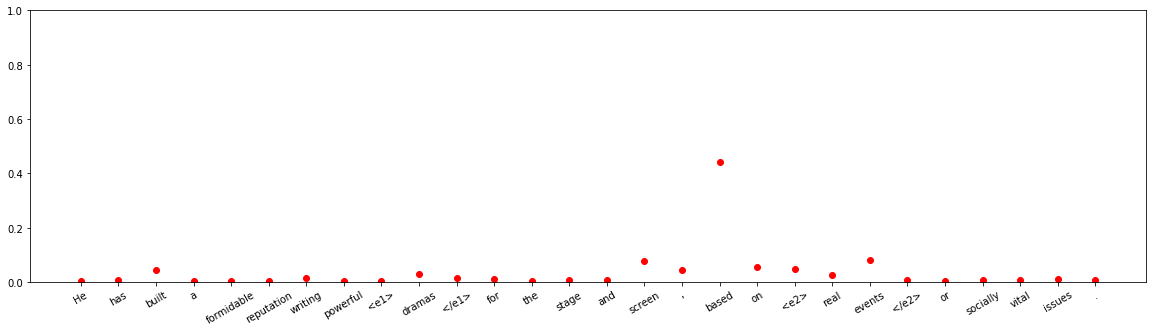


input sentence: By dividing the <e1> space </e1> in a kitchen <e2> drawer </e2> where you keep all your cooking utensils , you grouped items by size or purpose .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.00018242432
Cause-Effect 	:	 4.933733e-07
Component-Whole 	:	 0.001587127
Entity-Destination 	:	 0.011236245
Entity-Origin 	:	 2.4768602e-07
Product-Producer 	:	 1.2036257e-06
Member-Collection 	:	 5.101223e-05
Message-Topic 	:	 1.0121142e-06
Content-Container 	:	 0.9867915
Instrument-Agency 	:	 0.00014871711



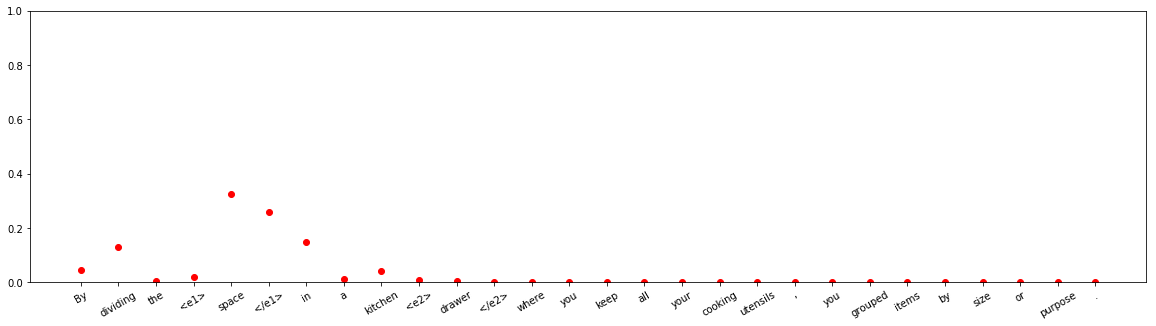








input sentence: Tissues from the dorsal <e1> lobe </e1> of the <e2> pancreas </e2> of 8 starlings ( Sturnus vulgaris ) were examined electron microscopically using conventionally prepared samples .
answer label:    Component-Whole
wrong label:    Member-Collection
Other 	:	 1.4465866e-05
Cause-Effect 	:	 2.6818352e-08
Component-Whole 	:	 0.4813199
Entity-Destination 	:	 1.2820514e-10
Entity-Origin 	:	 2.4672037e-08
Product-Producer 	:	 7.149086e-08
Member-Collection 	:	 0.5186626
Message-Topic 	:	 2.224136e-06
Content-Container 	:	 6.563671e-07
Instrument-Agency 	:	 2.4038176e-11



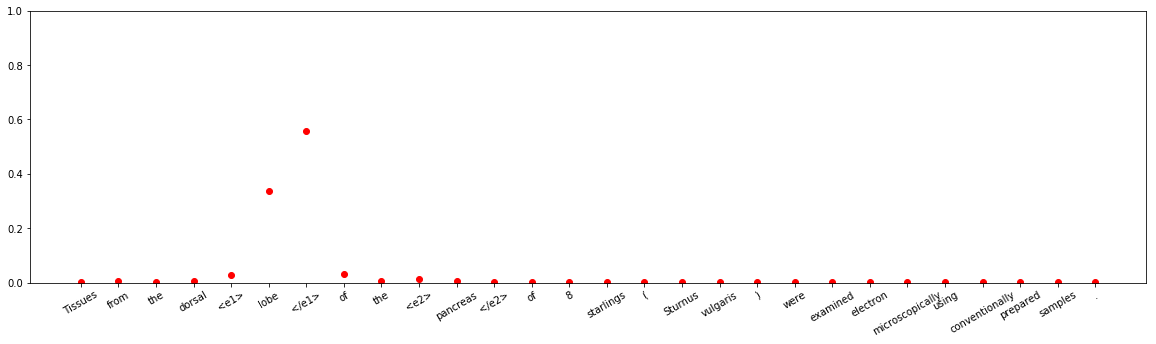













input sentence: The <e1> company </e1> has mocked up a <e2> version </e2> of YouTube built around the HTML5 video tag , playing mini-movies inside a browser sans plug-ins .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.0004395348
Cause-Effect 	:	 5.238053e-08
Component-Whole 	:	 0.0009665388
Entity-Destination 	:	 2.38626e-08
Entity-Origin 	:	 3.514213e-09
Product-Producer 	:	 0.47458702
Member-Collection 	:	 3.375331e-07
Message-Topic 	:	 2.7113194e-07
Content-Container 	:	 2.1860592e-07
Instrument-Agency 	:	 0.524006



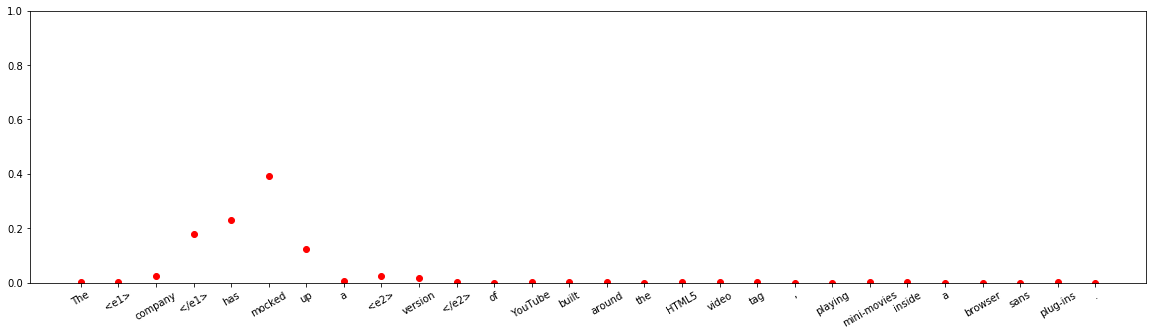










input sentence: He was a solo double bass <e1> player </e1> in a symphony <e2> orchestra </e2> ; at that time that was almost impossible due to racist reasons .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.062124416
Cause-Effect 	:	 0.00018539354
Component-Whole 	:	 0.76708585
Entity-Destination 	:	 2.8403403e-07
Entity-Origin 	:	 2.3154739e-07
Product-Producer 	:	 8.1868643e-07
Member-Collection 	:	 0.17055157
Message-Topic 	:	 8.810455e-07
Content-Container 	:	 4.5342607e-05
Instrument-Agency 	:	 5.086334e-06



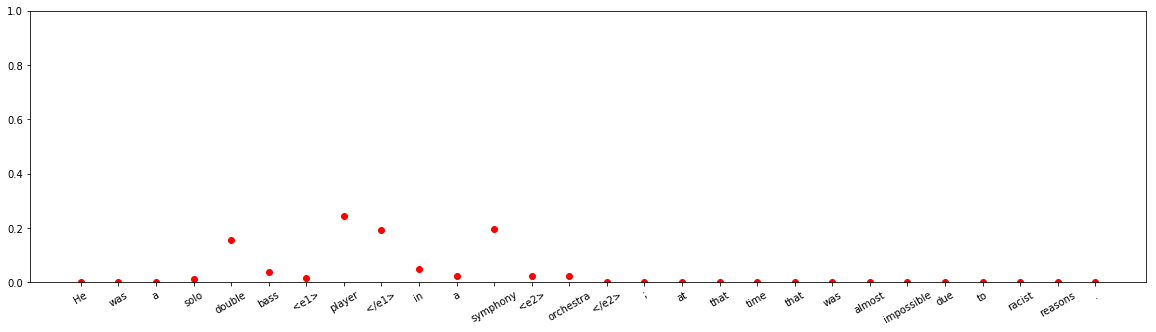




input sentence: A solid round <e1> bar </e1> , 32 '' long , is constructed from ductile <e2> steel </e2> ( Syt=60 ksi , G=11.5 x 106 psi ) .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.0004870047
Cause-Effect 	:	 1.0264735e-06
Component-Whole 	:	 1.0041061e-07
Entity-Destination 	:	 1.6826592e-10
Entity-Origin 	:	 0.0014744655
Product-Producer 	:	 0.99803597
Member-Collection 	:	 2.357579e-09
Message-Topic 	:	 1.3075707e-09
Content-Container 	:	 8.978095e-09
Instrument-Agency 	:	 1.4164482e-06



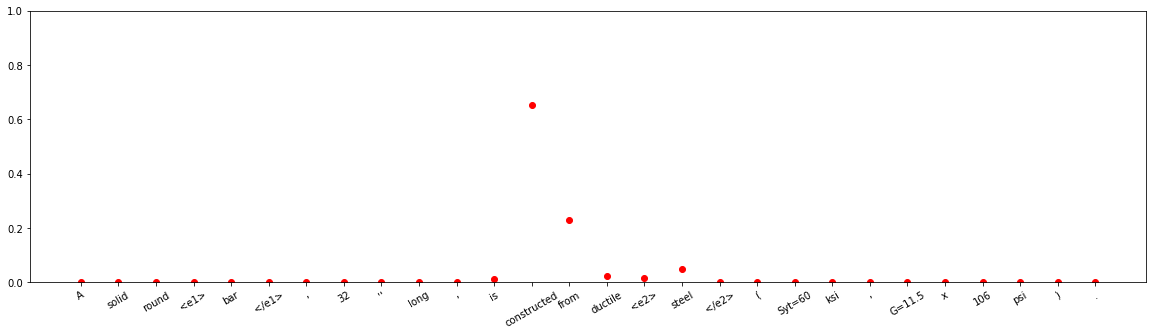



input sentence: To connect your MP3 player to your computer , you need a USB cord that hooks into a <e1> slot </e1> on the <e2> music player </e2> .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.549817
Cause-Effect 	:	 3.8295354e-09
Component-Whole 	:	 0.44908148
Entity-Destination 	:	 0.0007598875
Entity-Origin 	:	 2.7645065e-08
Product-Producer 	:	 1.5295042e-07
Member-Collection 	:	 4.753413e-06
Message-Topic 	:	 0.00031932164
Content-Container 	:	 1.3501904e-06
Instrument-Agency 	:	 1.5992926e-05



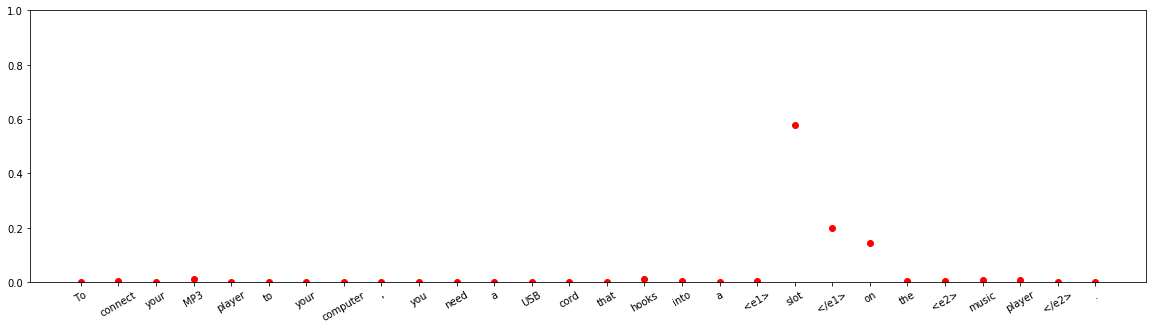


input sentence: Ten short <e1> films </e1> , both single and double screen , reap audio-visual crops from the fertile soil of the <e2> filmmakers </e2> ' florid imaginations .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.65984434
Cause-Effect 	:	 6.595498e-05
Component-Whole 	:	 1.5546771e-08
Entity-Destination 	:	 2.4839583e-05
Entity-Origin 	:	 0.023703014
Product-Producer 	:	 0.3148606
Member-Collection 	:	 6.129143e-06
Message-Topic 	:	 2.582913e-05
Content-Container 	:	 1.6967579e-07
Instrument-Agency 	:	 0.001469202



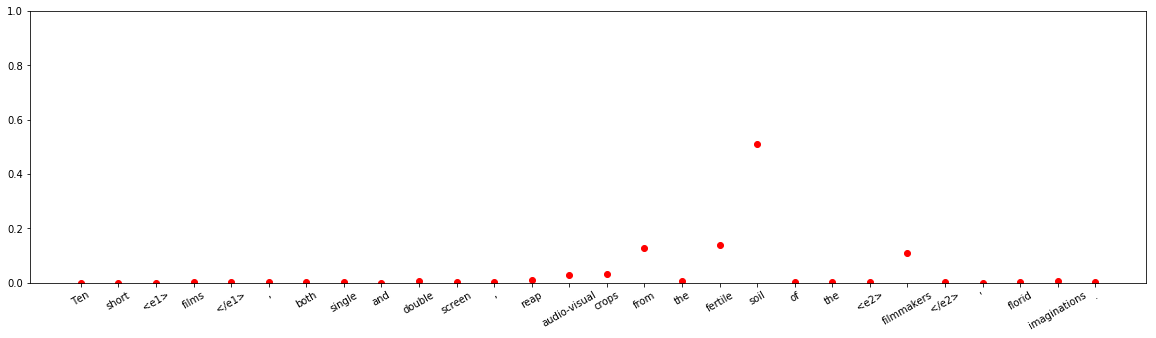





input sentence: Moreover , from the <e1> porch </e1> of the <e2> stoics </e2> he brings out matter , and places it on a par with the Divine Creator .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.0017209919
Cause-Effect 	:	 1.1111021e-08
Component-Whole 	:	 0.9982167
Entity-Destination 	:	 4.5907274e-08
Entity-Origin 	:	 8.327583e-09
Product-Producer 	:	 3.97083e-06
Member-Collection 	:	 4.2269e-05
Message-Topic 	:	 1.5933083e-05
Content-Container 	:	 9.807917e-08
Instrument-Agency 	:	 3.438668e-09



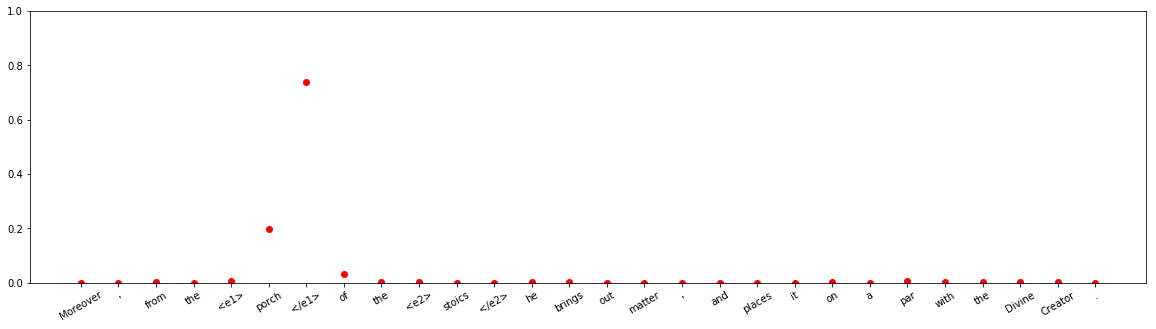





input sentence: A Western <e1> journalist </e1> took an assignment from his newspaper 's <e2> office </e2> for visiting Pakistan and filing exclusive reports on the current nuclear issue .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 5.762726e-06
Cause-Effect 	:	 1.1265406e-09
Component-Whole 	:	 4.9136335e-13
Entity-Destination 	:	 6.557925e-08
Entity-Origin 	:	 0.9999869
Product-Producer 	:	 6.740342e-06
Member-Collection 	:	 3.2414325e-09
Message-Topic 	:	 1.4965906e-10
Content-Container 	:	 3.0149687e-09
Instrument-Agency 	:	 4.2525056e-07



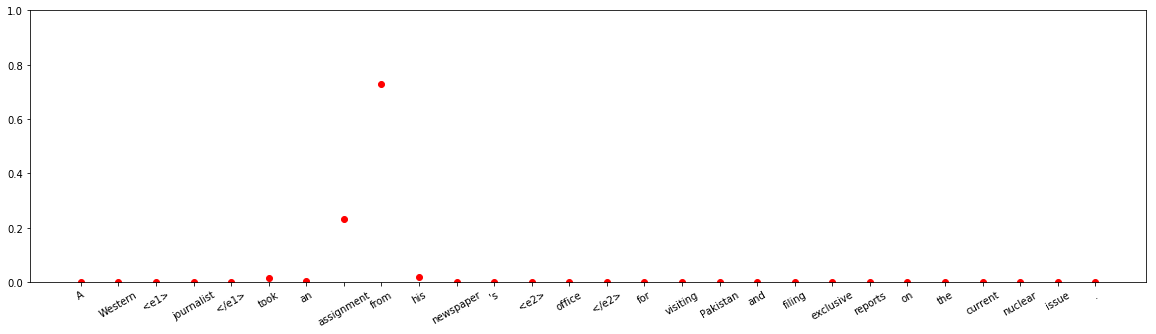



input sentence: While making <e1> observations </e1> the microfossil through the binocular microscope or on a computer <e2> monitor </e2> , the investigator needed to manually move the specimen .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.005042396
Cause-Effect 	:	 8.5325105e-08
Component-Whole 	:	 0.032070473
Entity-Destination 	:	 7.376134e-05
Entity-Origin 	:	 2.525038e-06
Product-Producer 	:	 1.0157535e-06
Member-Collection 	:	 3.8495753e-07
Message-Topic 	:	 6.965511e-05
Content-Container 	:	 1.8310209e-06
Instrument-Agency 	:	 0.9627378



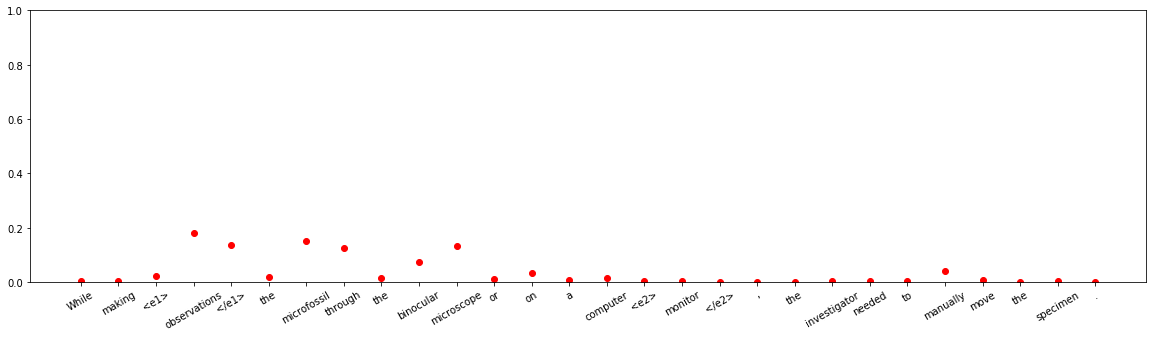




input sentence: This translation is systematic and literal ; with a particular emphasis on preserving the <e1> metaphors </e1> used by the <e2> saint </e2> in their original signification .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 4.9728493e-05
Cause-Effect 	:	 4.429235e-08
Component-Whole 	:	 1.3054306e-06
Entity-Destination 	:	 2.3700073e-08
Entity-Origin 	:	 8.117569e-09
Product-Producer 	:	 0.004833407
Member-Collection 	:	 4.663933e-11
Message-Topic 	:	 2.338751e-06
Content-Container 	:	 4.237201e-10
Instrument-Agency 	:	 0.9951132



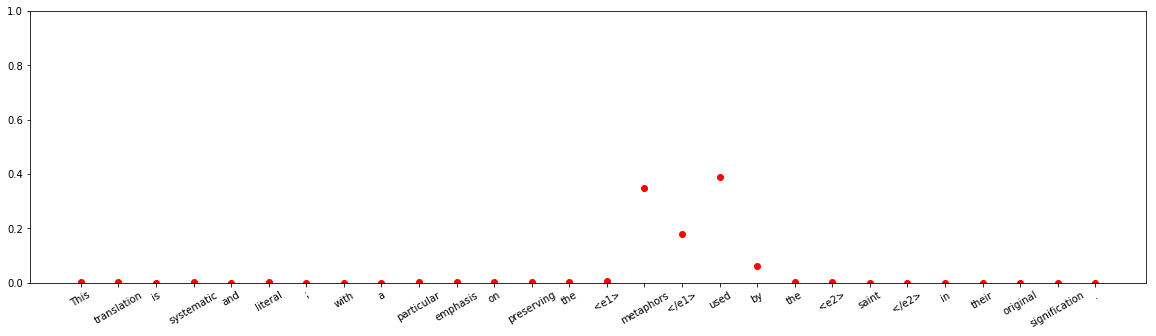


input sentence: <e1> Diabetes </e1> is a group of metabolic <e2> disorders </e2> characterized by a hyperglycemia resulting from defects in insulin secretion , insulin action , or both .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.029742394
Cause-Effect 	:	 0.97024196
Component-Whole 	:	 3.7752727e-08
Entity-Destination 	:	 1.7047688e-10
Entity-Origin 	:	 1.5938411e-06
Product-Producer 	:	 2.699973e-06
Member-Collection 	:	 2.0446091e-06
Message-Topic 	:	 4.4749683e-08
Content-Container 	:	 4.7109894e-09
Instrument-Agency 	:	 9.270998e-06



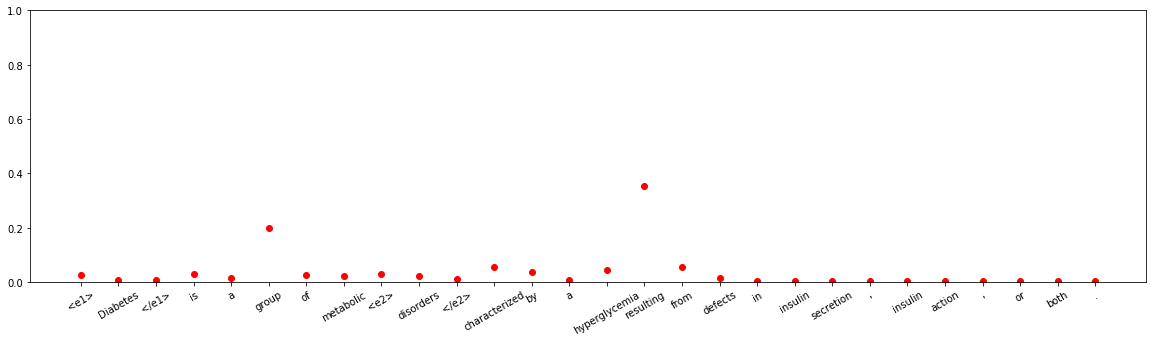


input sentence: Today , I present to you a small <e1> handful </e1> of informational <e2> tidbits </e2> which act as glimpses into the world of a typography enthusiast .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.00022273547
Cause-Effect 	:	 2.3382112e-08
Component-Whole 	:	 2.154616e-06
Entity-Destination 	:	 5.603717e-07
Entity-Origin 	:	 1.4912332e-05
Product-Producer 	:	 0.006379632
Member-Collection 	:	 0.98590785
Message-Topic 	:	 0.00731345
Content-Container 	:	 0.00015824994
Instrument-Agency 	:	 4.1294678e-07



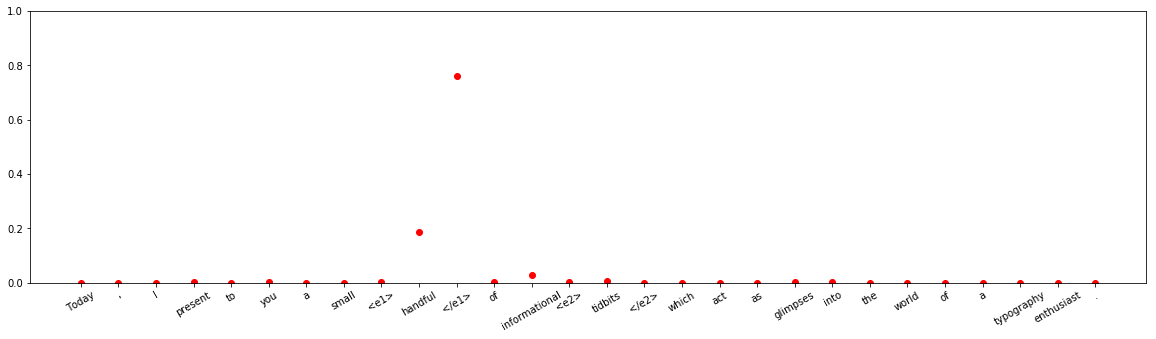


input sentence: The delay in bringing the suit to trial is being caused by a terrific <e1> log- jam </e1> of pending <e2> cases </e2> , court aids explained .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.018230783
Cause-Effect 	:	 0.01528995
Component-Whole 	:	 9.7729964e-05
Entity-Destination 	:	 7.390754e-05
Entity-Origin 	:	 0.0006410791
Product-Producer 	:	 2.88364e-07
Member-Collection 	:	 0.87830025
Message-Topic 	:	 0.08642486
Content-Container 	:	 0.0009393607
Instrument-Agency 	:	 1.782228e-06



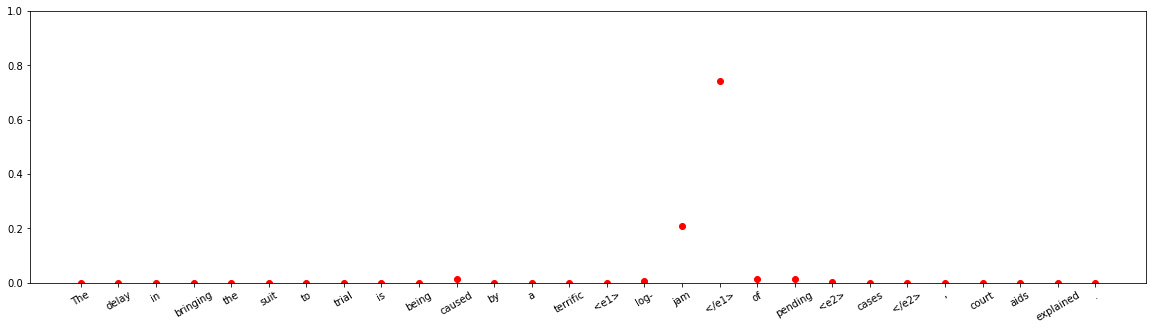





input sentence: I saw come out of London , even unto the presence of the prince , a great <e1> rabble </e1> of mean and light <e2> persons </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.99928325
Cause-Effect 	:	 1.3360495e-05
Component-Whole 	:	 2.430324e-09
Entity-Destination 	:	 2.5209448e-10
Entity-Origin 	:	 4.7245052e-08
Product-Producer 	:	 1.0851769e-08
Member-Collection 	:	 0.00062743155
Message-Topic 	:	 7.524268e-05
Content-Container 	:	 4.888075e-10
Instrument-Agency 	:	 7.053668e-07



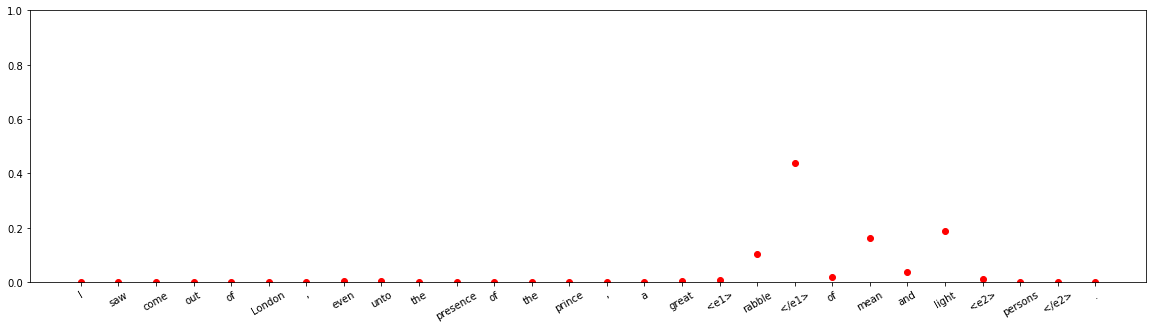



input sentence: To preserve its <e1> catch </e1> of <e2> fish </e2> , each boat loads between 2000 and 3000 kilos of ice before it goes out to sea .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.0032504227
Cause-Effect 	:	 1.11608244e-07
Component-Whole 	:	 0.013230831
Entity-Destination 	:	 6.5297186e-06
Entity-Origin 	:	 9.669272e-05
Product-Producer 	:	 2.9404364e-06
Member-Collection 	:	 0.9824118
Message-Topic 	:	 0.0007016411
Content-Container 	:	 0.00029857337
Instrument-Agency 	:	 5.8819836e-07



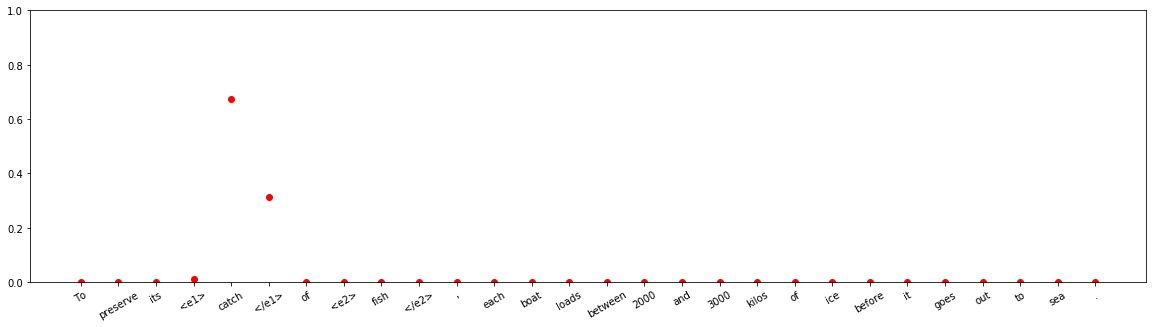


input sentence: Barbauld was also a literary critic , and her <e1> anthology </e1> of eighteenth-century British <e2> novels </e2> helped establish the canon as we know it today .
answer label:    Member-Collection
wrong label:    Message-Topic
Other 	:	 1.7809375e-08
Cause-Effect 	:	 8.104533e-08
Component-Whole 	:	 1.0794986e-05
Entity-Destination 	:	 6.3596517e-10
Entity-Origin 	:	 1.4659222e-06
Product-Producer 	:	 0.052657653
Member-Collection 	:	 0.15894866
Message-Topic 	:	 0.78816694
Content-Container 	:	 0.00021439721
Instrument-Agency 	:	 1.6200689e-08



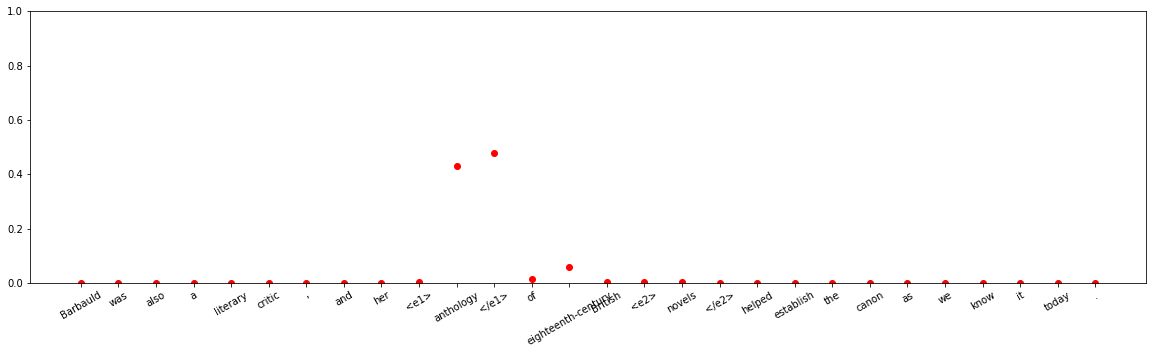








input sentence: The <e1> motet </e1> grows from a short , sparse germinal <e2> idea </e2> in which the intervals of the tone , semitone and augmented fourth predominate .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.8789669
Cause-Effect 	:	 0.0007131367
Component-Whole 	:	 0.120249085
Entity-Destination 	:	 1.927487e-07
Entity-Origin 	:	 6.4726264e-05
Product-Producer 	:	 2.9111225e-06
Member-Collection 	:	 4.7324315e-07
Message-Topic 	:	 4.3955401e-07
Content-Container 	:	 3.2007232e-08
Instrument-Agency 	:	 2.025117e-06



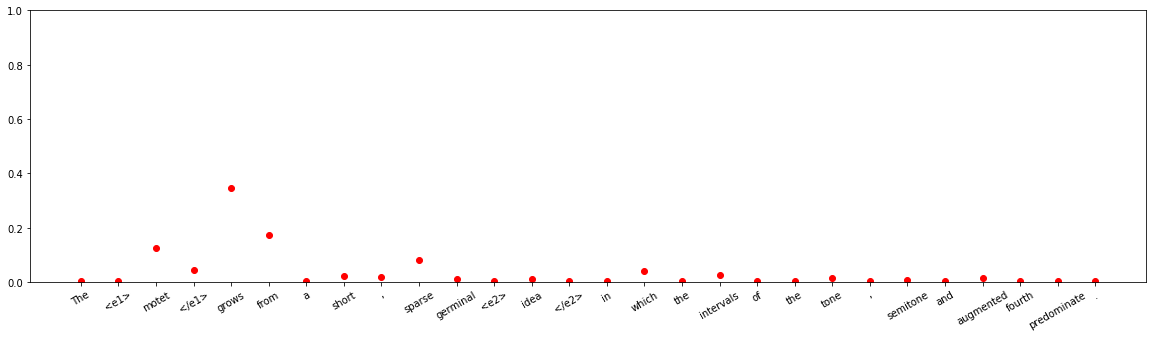









input sentence: The <e1> dynamite </e1> used in <e2> blasting </e2> for the South Island Line had been stored at a depot in Chung Hom Shan , near Stanley .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.0075302813
Cause-Effect 	:	 2.416944e-06
Component-Whole 	:	 0.00031765073
Entity-Destination 	:	 1.9442484e-06
Entity-Origin 	:	 2.4619991e-08
Product-Producer 	:	 2.5380482e-09
Member-Collection 	:	 4.9424237e-08
Message-Topic 	:	 3.1783232e-09
Content-Container 	:	 2.4877775e-08
Instrument-Agency 	:	 0.9921476



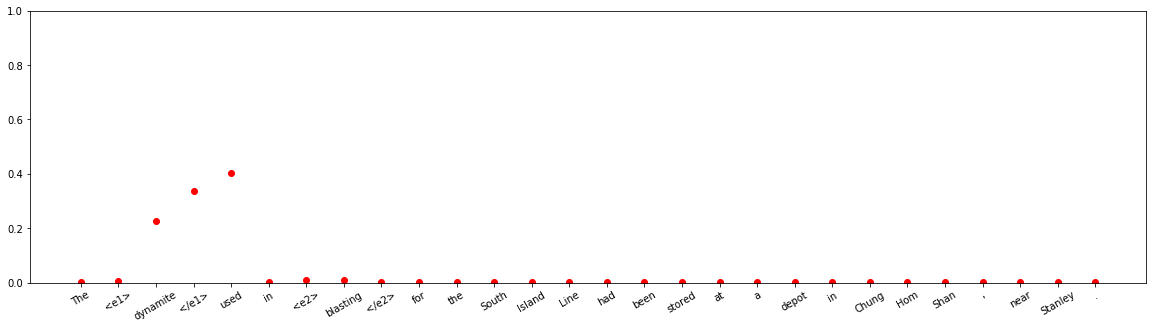


input sentence: A bed of ancient lava seemed to mark the commencement of the <e1> eruption </e1> from the <e2> craters </e2> of the great chain of the Andes .
answer label:    Entity-Origin
wrong label:    Cause-Effect
Other 	:	 3.642368e-05
Cause-Effect 	:	 0.9998995
Component-Whole 	:	 2.6602665e-08
Entity-Destination 	:	 9.6466025e-08
Entity-Origin 	:	 6.3679414e-05
Product-Producer 	:	 4.4494075e-09
Member-Collection 	:	 6.234738e-10
Message-Topic 	:	 1.1693234e-09
Content-Container 	:	 5.3396276e-12
Instrument-Agency 	:	 2.2606486e-07



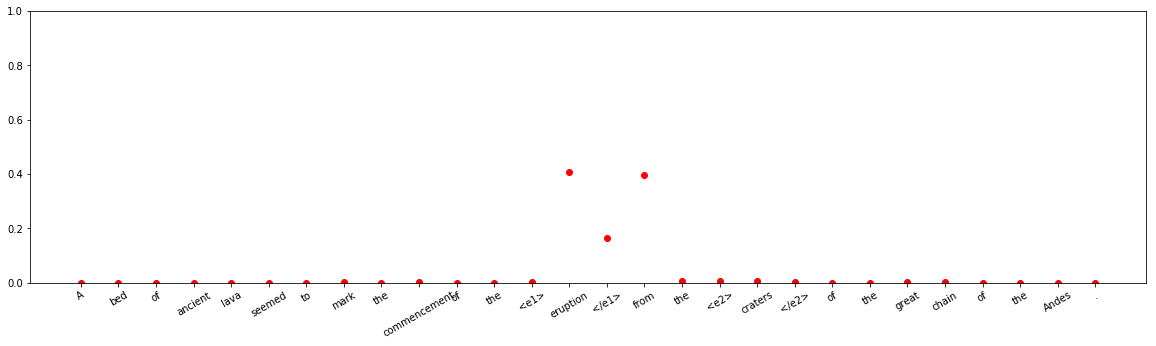













input sentence: The glow from the <e1> blacksmith </e1> 's <e2> forge </e2> led civilization from the dark ages and brought humankind to the standard of living enjoyed today .
answer label:    Instrument-Agency
wrong label:    Product-Producer
Other 	:	 1.1066137e-05
Cause-Effect 	:	 7.582761e-09
Component-Whole 	:	 1.041101e-11
Entity-Destination 	:	 1.0874157e-12
Entity-Origin 	:	 8.3689683e-10
Product-Producer 	:	 0.9999821
Member-Collection 	:	 1.8566908e-09
Message-Topic 	:	 9.787003e-10
Content-Container 	:	 1.0655373e-12
Instrument-Agency 	:	 6.773231e-06



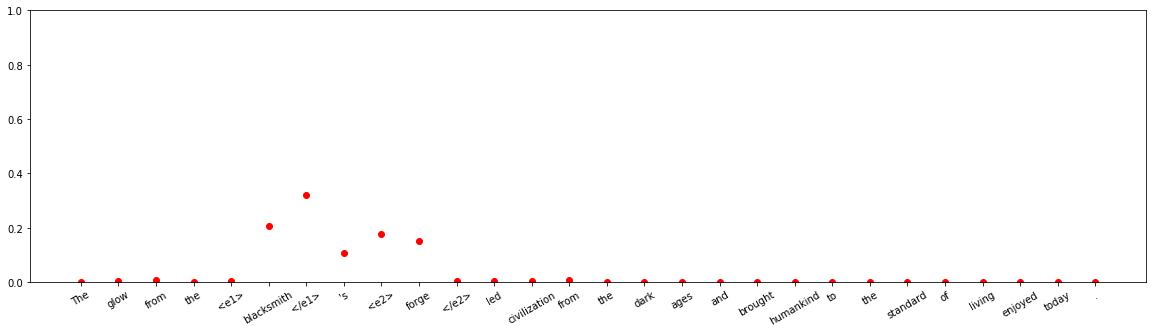


input sentence: Approximately three dozen bus <e1> lines </e1> operate from the port authority bus <e2> terminal </e2> located between Eighth and Ninth Avenues and 40th to 42nd Streets .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 1.8050896e-06
Cause-Effect 	:	 2.0366588e-09
Component-Whole 	:	 0.99998665
Entity-Destination 	:	 1.6720394e-07
Entity-Origin 	:	 2.7356077e-07
Product-Producer 	:	 5.5246274e-10
Member-Collection 	:	 1.2092222e-08
Message-Topic 	:	 1.0809889e-09
Content-Container 	:	 9.346958e-10
Instrument-Agency 	:	 1.11626205e-05



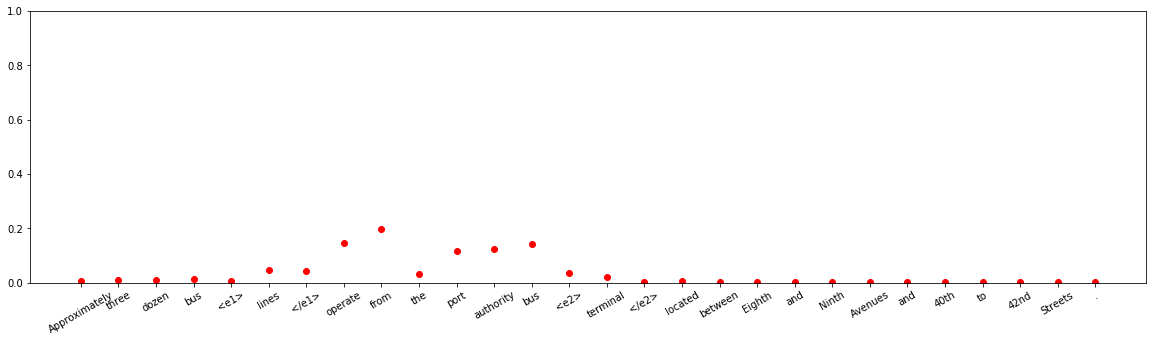


input sentence: Eco-Friendly <e1> tomatoes </e1> grown in a portable <e2> pail </e2> are moved inside and continue to produce delicious tomatoes even when summer is just a hearth-side .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 1.1614163e-05
Cause-Effect 	:	 2.6045791e-08
Component-Whole 	:	 2.567965e-06
Entity-Destination 	:	 0.56601435
Entity-Origin 	:	 0.0004999941
Product-Producer 	:	 1.2524332e-05
Member-Collection 	:	 5.614919e-08
Message-Topic 	:	 1.7785715e-07
Content-Container 	:	 0.43345213
Instrument-Agency 	:	 6.521513e-06



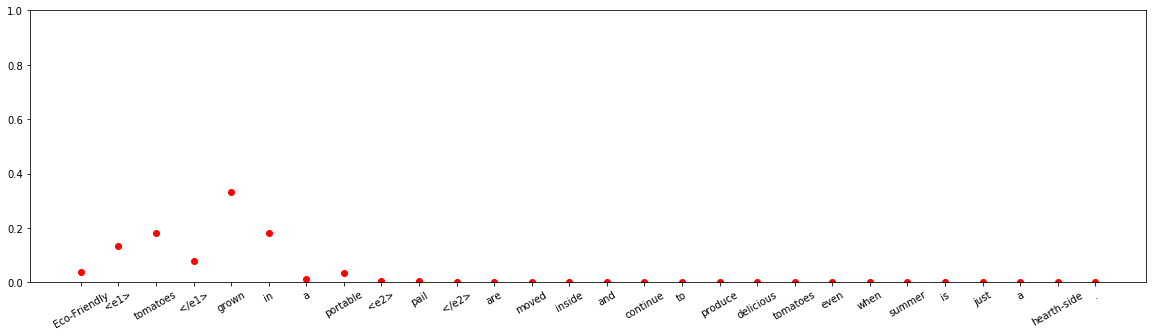


input sentence: Advanced XML Converter has a <e1> wizard </e1> driven <e2> interface </e2> for converting xml files into HTML , CSV , DBF and XLS formats with ease .
answer label:    Component-Whole
wrong label:    Product-Producer
Other 	:	 0.12160944
Cause-Effect 	:	 2.9633455e-07
Component-Whole 	:	 1.2199658e-07
Entity-Destination 	:	 1.0546236e-06
Entity-Origin 	:	 1.0117345e-07
Product-Producer 	:	 0.7903537
Member-Collection 	:	 2.7908245e-06
Message-Topic 	:	 2.6167897e-09
Content-Container 	:	 4.5789466e-09
Instrument-Agency 	:	 0.0880324



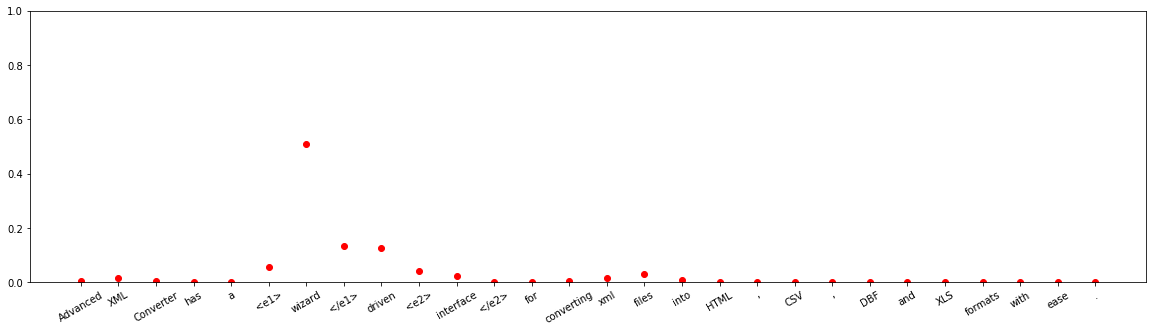


input sentence: The Postmodernism Generator was written by Andrew C. Bulhak using the Dada Engine , a system for generating random <e1> text </e1> from recursive <e2> grammars </e2> .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9500099
Cause-Effect 	:	 0.033634484
Component-Whole 	:	 8.964949e-05
Entity-Destination 	:	 4.0241673e-07
Entity-Origin 	:	 0.0012570446
Product-Producer 	:	 0.00013614596
Member-Collection 	:	 7.756955e-07
Message-Topic 	:	 2.1516698e-05
Content-Container 	:	 9.904578e-08
Instrument-Agency 	:	 0.014849937



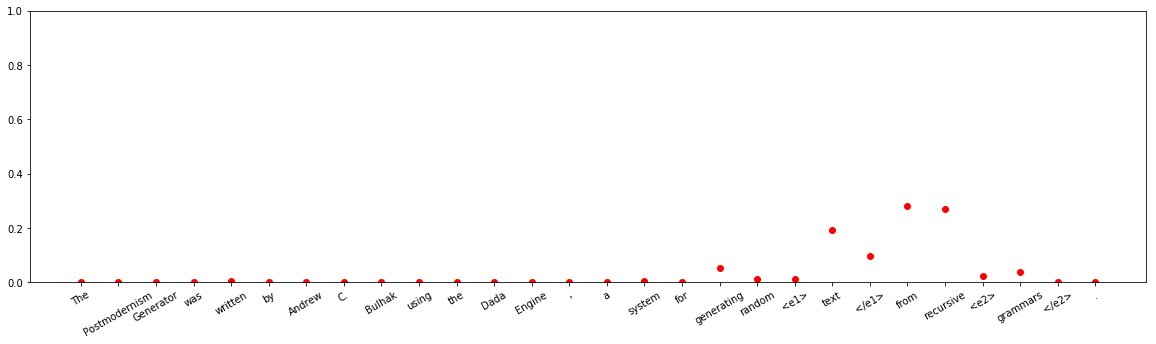






input sentence: The <e1> sections </e1> of the book pertaining to <e2> quantitative methods </e2> are written clearly and contain more detail than usually is found in similar books .
answer label:    Message-Topic
wrong label:    Component-Whole
Other 	:	 5.9562673e-05
Cause-Effect 	:	 1.622542e-08
Component-Whole 	:	 0.53272986
Entity-Destination 	:	 4.2514436e-08
Entity-Origin 	:	 8.992712e-10
Product-Producer 	:	 2.4373229e-08
Member-Collection 	:	 1.3836991e-07
Message-Topic 	:	 0.46720976
Content-Container 	:	 2.912111e-07
Instrument-Agency 	:	 3.135549e-07



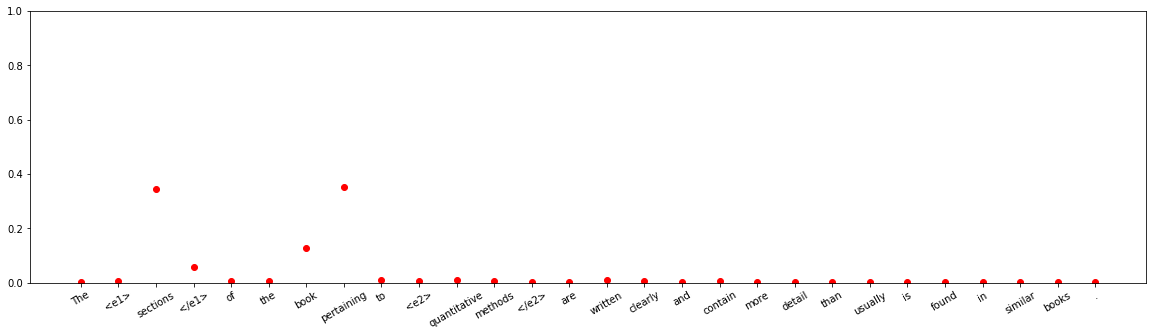




input sentence: The <e1> foundry </e1> 's major product lines include manhole <e2> frames </e2> and utility covers , airport castings , drainage products , Trench Grates , hydrant and valve components , and industrial castings .
answer label:    Product-Producer
wrong label:    Component-Whole
Other 	:	 2.4093234e-07
Cause-Effect 	:	 1.1065872e-06
Component-Whole 	:	 0.69390935
Entity-Destination 	:	 1.3481743e-08
Entity-Origin 	:	 2.1298997e-07
Product-Producer 	:	 0.0019035676
Member-Collection 	:	 3.2168793e-06
Message-Topic 	:	 1.3984845e-07
Content-Container 	:	 1.1816324e-05
Instrument-Agency 	:	 0.30417028



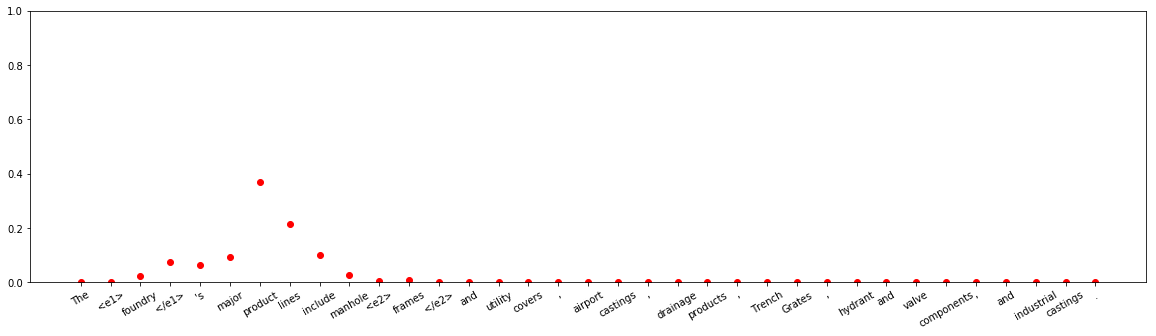



input sentence: The Order of Friars Minor Capuchin ( OFM Cap ) is an <e1> order </e1> of <e2> friars </e2> in the Roman Catholic Church , the chief and only permanent offshoot of the Franciscans .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.75684816
Cause-Effect 	:	 1.6112716e-09
Component-Whole 	:	 0.00012735935
Entity-Destination 	:	 2.756192e-07
Entity-Origin 	:	 5.9729143e-07
Product-Producer 	:	 5.3451776e-09
Member-Collection 	:	 0.24302305
Message-Topic 	:	 1.14189504e-07
Content-Container 	:	 6.024748e-08
Instrument-Agency 	:	 3.2267062e-07



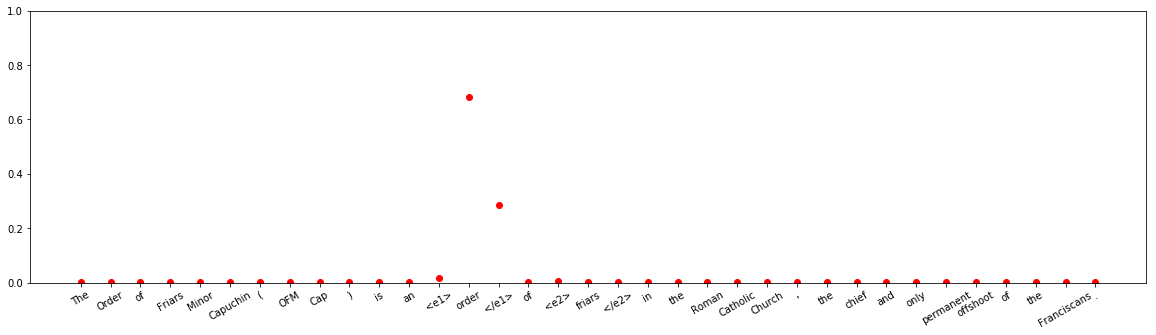




input sentence: There are serious legal <e1> concerns </e1> in relation to <e2> cases </e2> of this kind and these are the factors we have to bear in mind when deciding what we publish or broadcast .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.0026920198
Cause-Effect 	:	 4.1300256e-05
Component-Whole 	:	 9.8161465e-08
Entity-Destination 	:	 1.6405984e-05
Entity-Origin 	:	 5.696802e-10
Product-Producer 	:	 1.6938211e-11
Member-Collection 	:	 4.7632324e-07
Message-Topic 	:	 0.9972494
Content-Container 	:	 9.0258725e-09
Instrument-Agency 	:	 2.1116628e-07



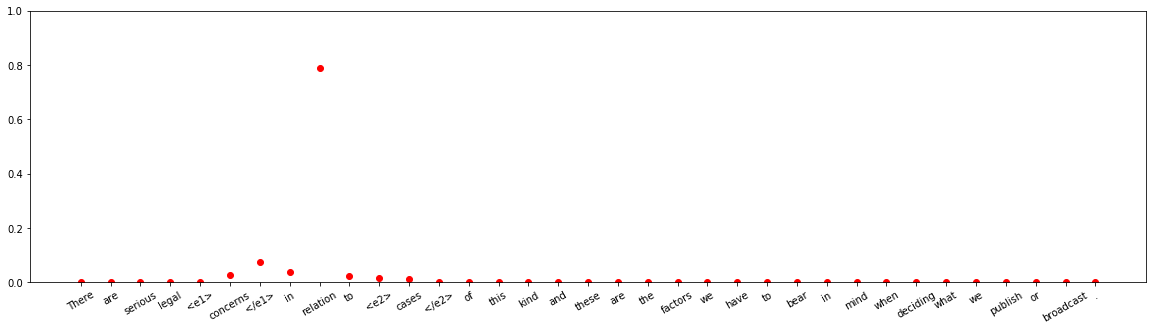





input sentence: As he came near , the <e1> lion </e1> put out his <e2> paw </e2> , which was all swollen and bleeding , and Androcles found that a huge thorn had got into it .
answer label:    Component-Whole
wrong label:    Entity-Destination
Other 	:	 2.4754108e-06
Cause-Effect 	:	 2.5473286e-08
Component-Whole 	:	 0.00026034357
Entity-Destination 	:	 0.9995883
Entity-Origin 	:	 0.00013990756
Product-Producer 	:	 1.3359202e-06
Member-Collection 	:	 2.5165456e-09
Message-Topic 	:	 6.931026e-09
Content-Container 	:	 7.450184e-06
Instrument-Agency 	:	 8.1219795e-08



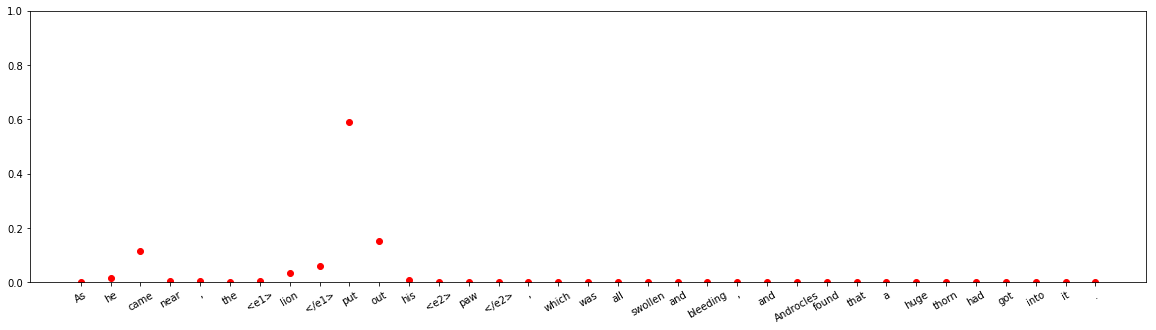








input sentence: The `` Magic E '' was a <e1> rhyme </e1> by an orange alien robot <e2> thing </e2> that sang along the lines of : `` Kit , becomes kite with me ... '' .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 1.4128584e-05
Cause-Effect 	:	 1.2358865e-07
Component-Whole 	:	 0.0024965694
Entity-Destination 	:	 1.1813764e-06
Entity-Origin 	:	 1.2953667e-06
Product-Producer 	:	 0.00030748372
Member-Collection 	:	 2.2914963e-05
Message-Topic 	:	 2.1038332e-08
Content-Container 	:	 1.3023721e-05
Instrument-Agency 	:	 0.9971432



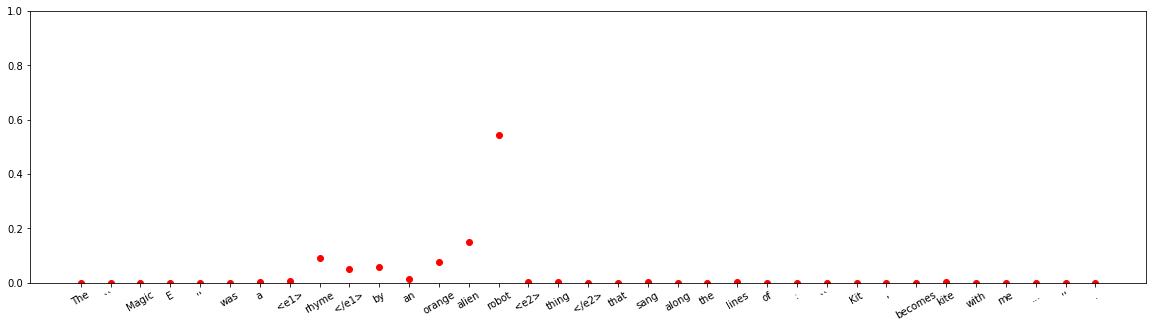








input sentence: An <e1> eyewitness </e1> <e2> account </e2> to a turning point in the Civil War , From the Pen of a She-Rebel chronicles not only a community 's near destruction but also its endurance .
answer label:    Product-Producer
wrong label:    Message-Topic
Other 	:	 5.5510907e-07
Cause-Effect 	:	 8.1125975e-08
Component-Whole 	:	 4.3568144e-07
Entity-Destination 	:	 3.3827033e-05
Entity-Origin 	:	 3.0379535e-06
Product-Producer 	:	 0.0002098263
Member-Collection 	:	 3.3833467e-06
Message-Topic 	:	 0.99487877
Content-Container 	:	 5.3758093e-05
Instrument-Agency 	:	 0.004816295



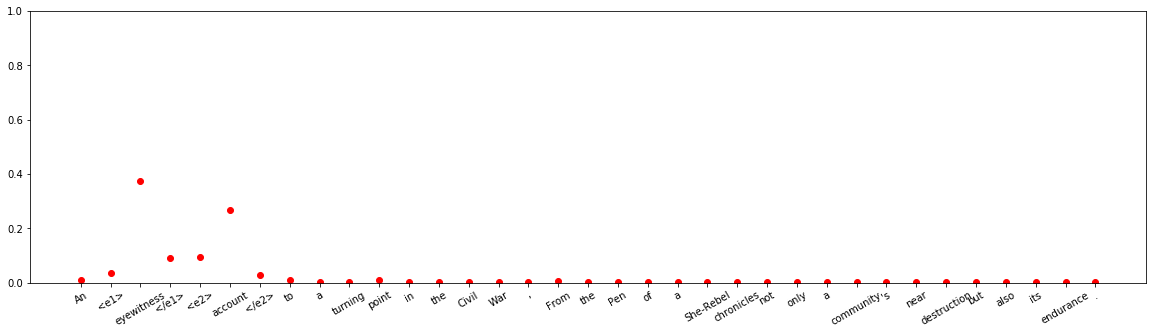





input sentence: Arriving home from this concert , I found an e-mail <e1> message </e1> from a musician <e2> friend </e2> .
answer label:    Product-Producer
wrong label:    Entity-Origin
Other 	:	 3.5523324e-05
Cause-Effect 	:	 0.00011391197
Component-Whole 	:	 3.3623486e-08
Entity-Destination 	:	 7.658902e-06
Entity-Origin 	:	 0.8340801
Product-Producer 	:	 0.1656715
Member-Collection 	:	 4.6069843e-08
Message-Topic 	:	 1.103069e-07
Content-Container 	:	 1.2452106e-05
Instrument-Agency 	:	 7.872217e-05



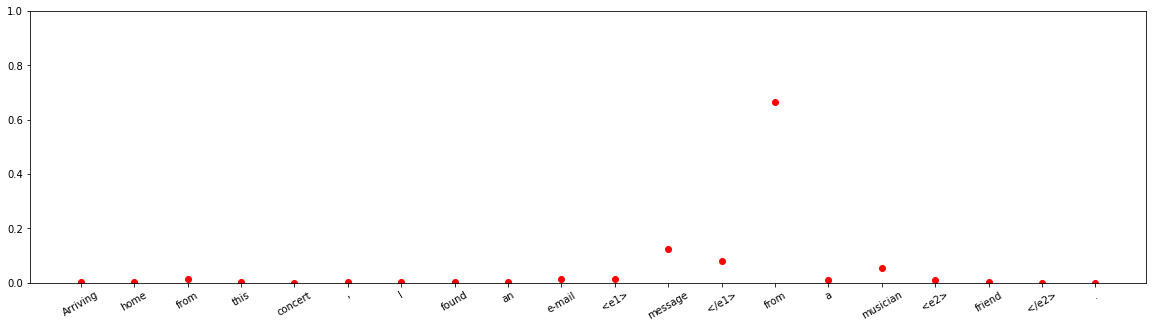




input sentence: These <e1> observations </e1> determine the high spatial resolution stellar <e2> kinematics </e2> within the nuclei of these galaxies .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.69485235
Cause-Effect 	:	 4.857067e-07
Component-Whole 	:	 8.137825e-06
Entity-Destination 	:	 8.182177e-09
Entity-Origin 	:	 7.72827e-08
Product-Producer 	:	 1.7508835e-09
Member-Collection 	:	 0.03085218
Message-Topic 	:	 0.27428332
Content-Container 	:	 4.4490665e-08
Instrument-Agency 	:	 3.36458e-06



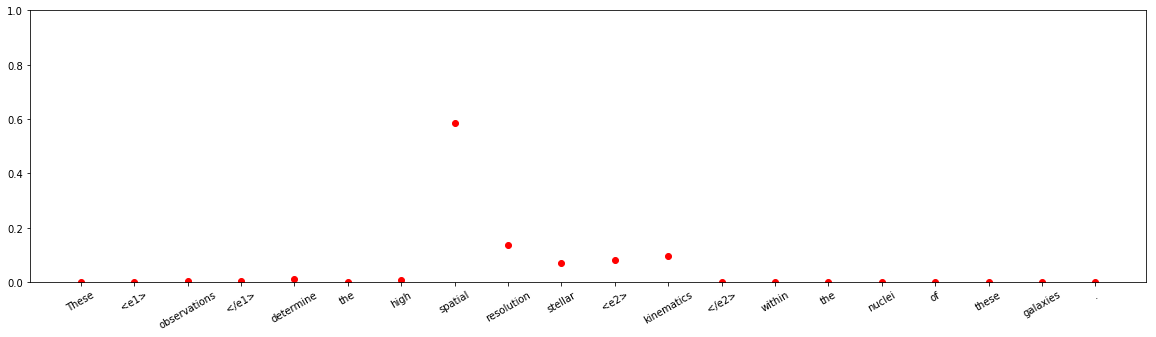



input sentence: The <e1> money </e1> was handed over into notarial <e2> custody </e2> for the purpose of securing an obligation .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.8533945
Cause-Effect 	:	 5.1861804e-08
Component-Whole 	:	 2.6633677e-07
Entity-Destination 	:	 0.14537184
Entity-Origin 	:	 0.0007478931
Product-Producer 	:	 8.953087e-09
Member-Collection 	:	 1.7010996e-07
Message-Topic 	:	 2.4542554e-05
Content-Container 	:	 0.0004604326
Instrument-Agency 	:	 1.05822494e-07



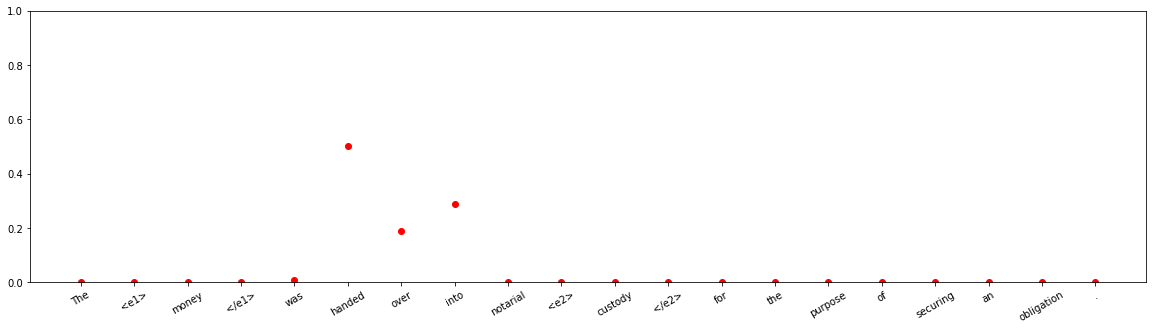


input sentence: The <e1> lioness </e1> drank the poisoned water out of <e2> grief </e2> for the loss of her daughter .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.042922363
Cause-Effect 	:	 0.57154626
Component-Whole 	:	 2.198486e-05
Entity-Destination 	:	 4.310095e-05
Entity-Origin 	:	 0.3775225
Product-Producer 	:	 0.0001567663
Member-Collection 	:	 2.9752067e-05
Message-Topic 	:	 1.4684254e-06
Content-Container 	:	 0.0069533195
Instrument-Agency 	:	 0.0008023894



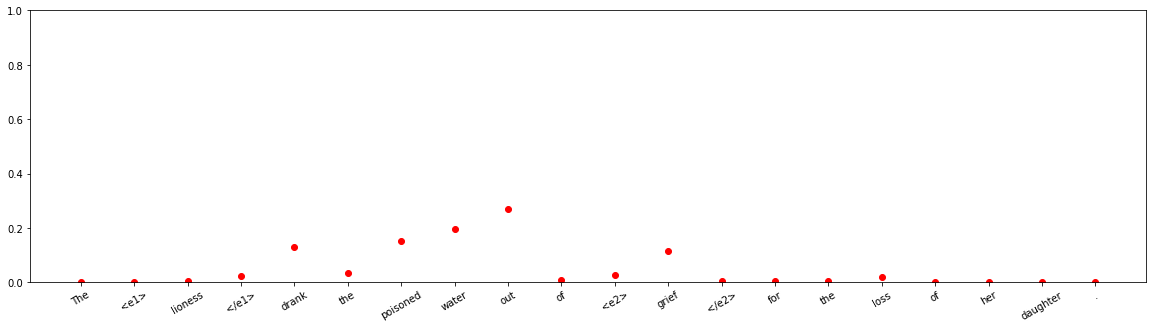



input sentence: The same <e1> effect </e1> is achieved the traditional <e2> way </e2> , with a team of workers like Keebler elves .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.6291285
Cause-Effect 	:	 0.36875483
Component-Whole 	:	 8.805188e-09
Entity-Destination 	:	 2.5123924e-07
Entity-Origin 	:	 4.4716155e-09
Product-Producer 	:	 7.326794e-08
Member-Collection 	:	 1.31021105e-08
Message-Topic 	:	 0.0021135467
Content-Container 	:	 1.2918906e-11
Instrument-Agency 	:	 2.8544077e-06



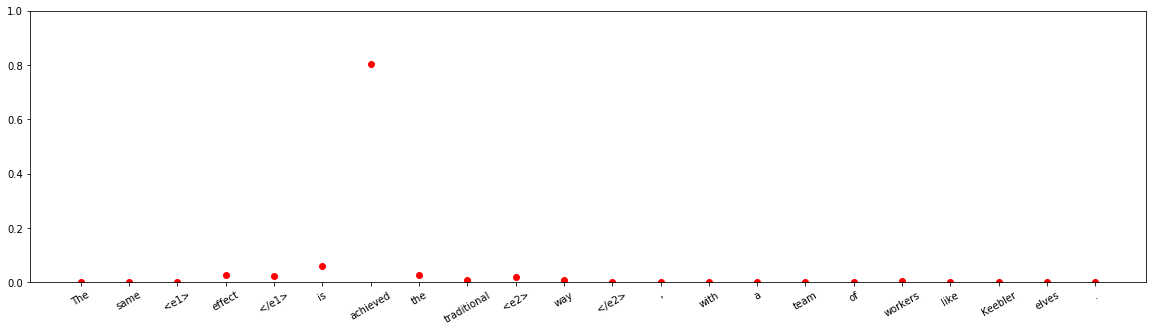


input sentence: Then , the target PET <e1> bottle </e1> was put inside of a metal <e2> container </e2> , which was grounded .
answer label:    Entity-Destination
wrong label:    Content-Container
Other 	:	 1.211914e-10
Cause-Effect 	:	 9.919103e-12
Component-Whole 	:	 1.8095548e-08
Entity-Destination 	:	 0.23331662
Entity-Origin 	:	 1.6879916e-07
Product-Producer 	:	 3.1601615e-09
Member-Collection 	:	 1.1852459e-09
Message-Topic 	:	 9.419678e-10
Content-Container 	:	 0.76668316
Instrument-Agency 	:	 3.7519827e-09



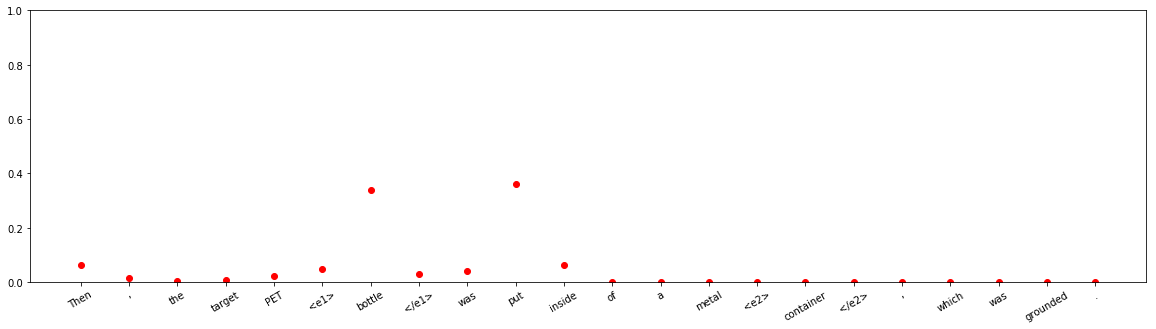






input sentence: We dissolved the <e1> contents </e1> of one packet in a <e2> carafe </e2> of water and ran the brew cycle .
answer label:    Entity-Destination
wrong label:    Content-Container
Other 	:	 4.4025636e-10
Cause-Effect 	:	 1.6987522e-09
Component-Whole 	:	 8.641934e-08
Entity-Destination 	:	 0.09693409
Entity-Origin 	:	 3.050729e-07
Product-Producer 	:	 3.094177e-10
Member-Collection 	:	 2.3115053e-08
Message-Topic 	:	 3.557108e-09
Content-Container 	:	 0.9030655
Instrument-Agency 	:	 1.1106447e-09



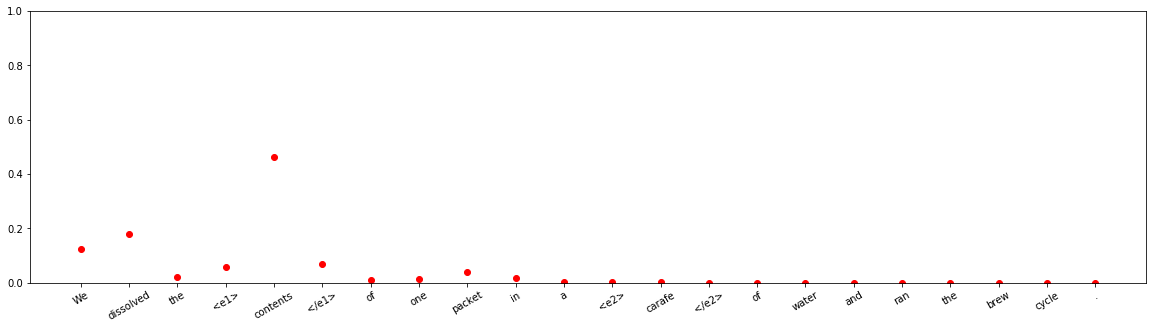


input sentence: A <e1> tableau </e1> like this one is placed inside the king 's <e2> room </e2> and refers to court ceremonies .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 0.00021705416
Cause-Effect 	:	 8.149918e-12
Component-Whole 	:	 2.2631566e-05
Entity-Destination 	:	 0.9997589
Entity-Origin 	:	 2.7537632e-07
Product-Producer 	:	 6.409176e-10
Member-Collection 	:	 1.2514927e-09
Message-Topic 	:	 1.0011855e-09
Content-Container 	:	 9.610909e-07
Instrument-Agency 	:	 1.9824535e-07



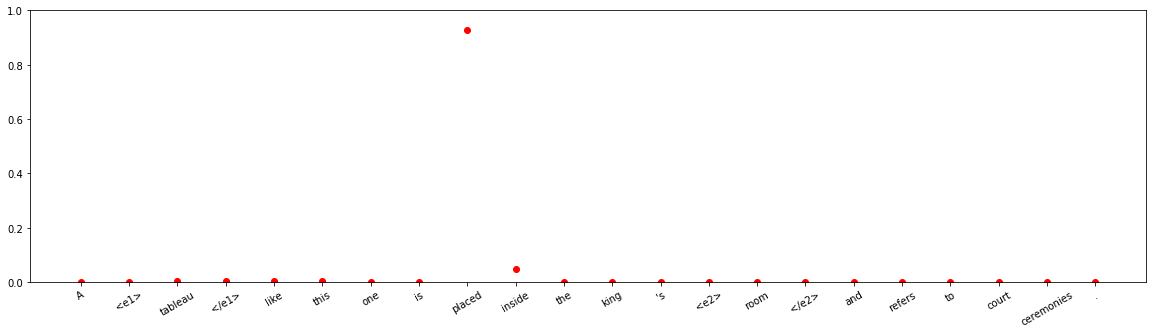




input sentence: <e1> Bone </e1> is built up of many <e2> cell </e2> types and so far we have only investigated human osteoblasts .
answer label:    Component-Whole
wrong label:    Product-Producer
Other 	:	 0.021298576
Cause-Effect 	:	 8.430712e-06
Component-Whole 	:	 0.010078299
Entity-Destination 	:	 4.6801327e-07
Entity-Origin 	:	 2.789017e-07
Product-Producer 	:	 0.96851516
Member-Collection 	:	 1.8078907e-06
Message-Topic 	:	 3.8175696e-07
Content-Container 	:	 5.239533e-06
Instrument-Agency 	:	 9.138671e-05



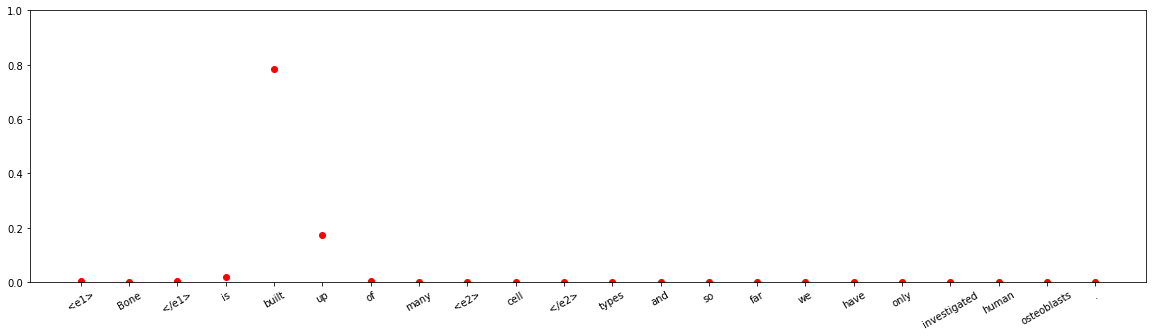






input sentence: The <e1> text </e1> handles all of this <e2> material </e2> well , integrating it into the flow of the argument .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 2.5987085e-05
Cause-Effect 	:	 4.736541e-10
Component-Whole 	:	 0.9999076
Entity-Destination 	:	 2.2659098e-07
Entity-Origin 	:	 1.1923203e-10
Product-Producer 	:	 7.695549e-09
Member-Collection 	:	 6.4067223e-09
Message-Topic 	:	 4.9693995e-06
Content-Container 	:	 6.7243764e-07
Instrument-Agency 	:	 6.0482897e-05



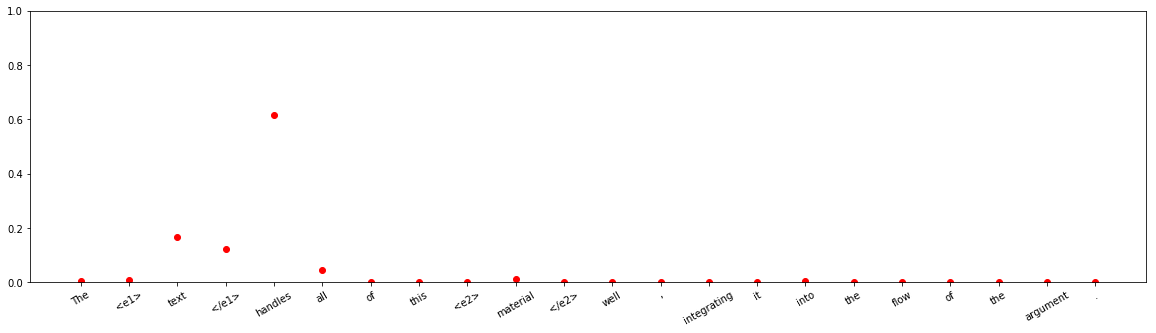


input sentence: There is a curb between the sidewalk and the shared bus and bike <e1> lane </e1> on the <e2> road </e2> .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.99977916
Cause-Effect 	:	 9.940037e-10
Component-Whole 	:	 0.00021431892
Entity-Destination 	:	 2.9466406e-08
Entity-Origin 	:	 8.5913504e-10
Product-Producer 	:	 2.754779e-10
Member-Collection 	:	 3.62868e-10
Message-Topic 	:	 6.319322e-06
Content-Container 	:	 2.2260358e-12
Instrument-Agency 	:	 2.0182428e-07



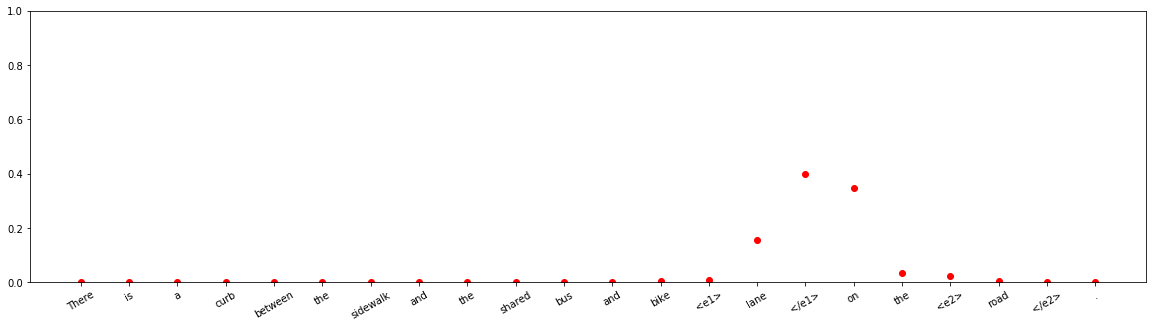






input sentence: I realized then that the <e1> jam </e1> of <e2> trucks </e2> at the gate probably belonged to his young charges .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.00021747635
Cause-Effect 	:	 6.6535636e-06
Component-Whole 	:	 0.9952199
Entity-Destination 	:	 4.4970293e-05
Entity-Origin 	:	 0.004316494
Product-Producer 	:	 6.863958e-08
Member-Collection 	:	 0.00016151746
Message-Topic 	:	 2.0404851e-08
Content-Container 	:	 1.2465298e-05
Instrument-Agency 	:	 2.049393e-05



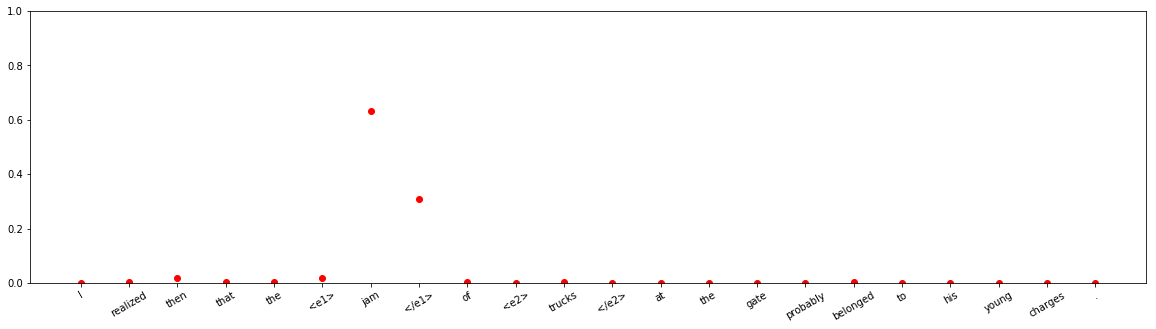










input sentence: The <e1> film </e1> departed from typical documentary <e2> fare </e2> by emphasizing the commentaries of Thompson 's friends and peers .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 3.8131034e-07
Cause-Effect 	:	 2.6619485e-08
Component-Whole 	:	 1.2176071e-11
Entity-Destination 	:	 1.4663241e-11
Entity-Origin 	:	 0.9999994
Product-Producer 	:	 5.125435e-08
Member-Collection 	:	 3.7481983e-11
Message-Topic 	:	 2.9592584e-07
Content-Container 	:	 2.984498e-10
Instrument-Agency 	:	 4.3956933e-10



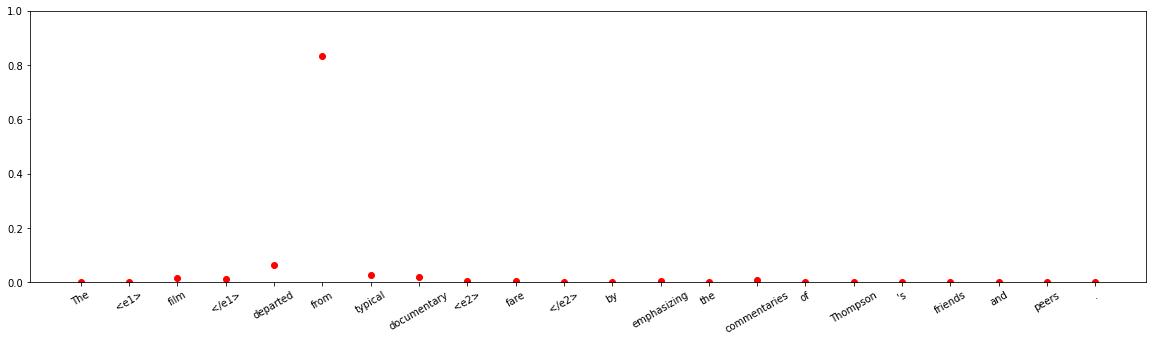


input sentence: A more spare , less robust use of classical <e1> motifs </e1> is evident in a <e2> ewer </e2> of 1784-85 .
answer label:    Component-Whole
wrong label:    Message-Topic
Other 	:	 0.24677882
Cause-Effect 	:	 4.5153597e-06
Component-Whole 	:	 3.2855223e-05
Entity-Destination 	:	 1.5473242e-07
Entity-Origin 	:	 2.5883796e-06
Product-Producer 	:	 1.8521641e-09
Member-Collection 	:	 5.036227e-07
Message-Topic 	:	 0.7526484
Content-Container 	:	 0.0005322323
Instrument-Agency 	:	 4.6754383e-09



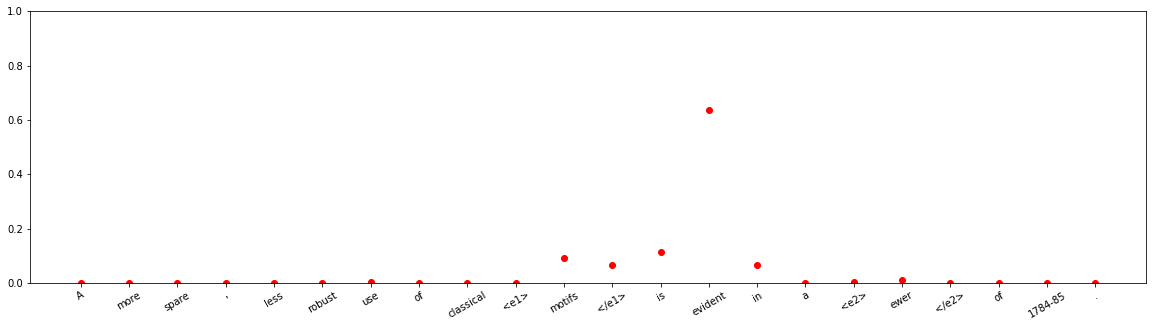



input sentence: The <e1> ghost-ship </e1> <e2> fleet </e2> anchored idle off Singabore is an interesting proxy for the collapse in world trade .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.66997373
Cause-Effect 	:	 1.587592e-05
Component-Whole 	:	 0.20782013
Entity-Destination 	:	 0.0003046154
Entity-Origin 	:	 0.00012517066
Product-Producer 	:	 0.00020101425
Member-Collection 	:	 0.11985329
Message-Topic 	:	 0.0014758417
Content-Container 	:	 9.314654e-06
Instrument-Agency 	:	 0.00022088362



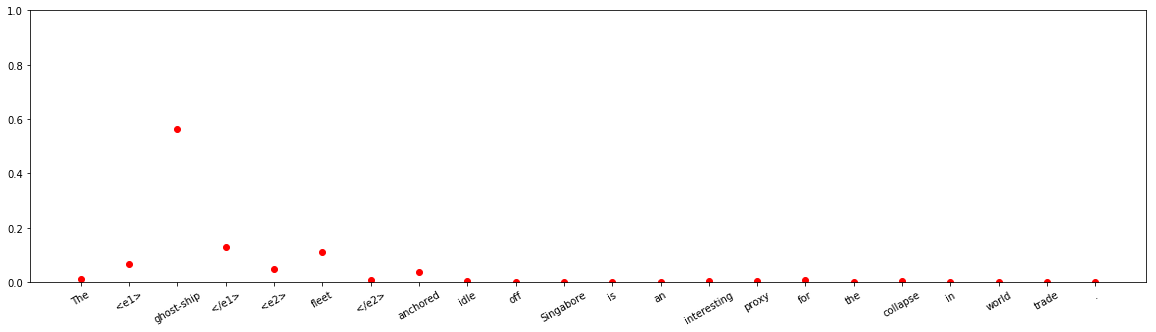











input sentence: The seven <e1> chains </e1> have given away a total of 5.6 billion single-use <e2> bags </e2> in the past year .
answer label:    Entity-Origin
wrong label:    Entity-Destination
Other 	:	 0.00059840805
Cause-Effect 	:	 9.785946e-05
Component-Whole 	:	 6.911453e-06
Entity-Destination 	:	 0.97073764
Entity-Origin 	:	 7.683634e-05
Product-Producer 	:	 0.0028736491
Member-Collection 	:	 1.379579e-06
Message-Topic 	:	 2.8128477e-07
Content-Container 	:	 0.024059119
Instrument-Agency 	:	 0.0015479387



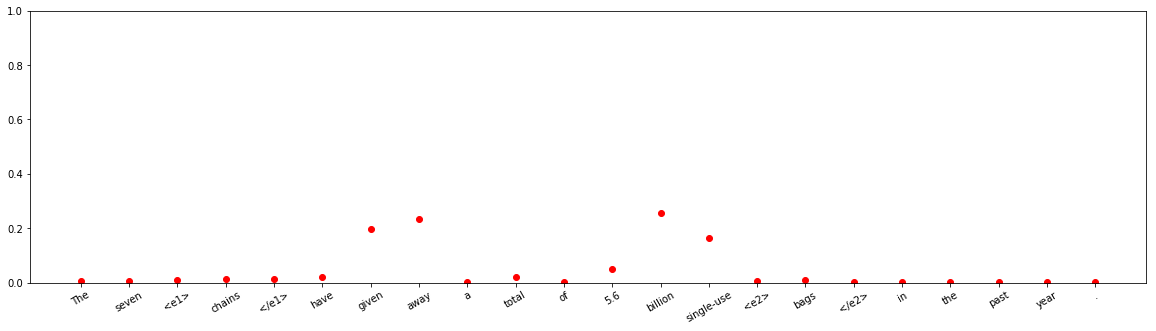




input sentence: He then maps the development of Anglo-American <e1> formalism </e1> from Modernist <e2> literature </e2> to the American and British academies .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.5818888
Cause-Effect 	:	 4.7314775e-06
Component-Whole 	:	 5.087554e-09
Entity-Destination 	:	 9.484172e-08
Entity-Origin 	:	 0.41721252
Product-Producer 	:	 0.00067489524
Member-Collection 	:	 5.458657e-06
Message-Topic 	:	 0.00021318487
Content-Container 	:	 9.32082e-09
Instrument-Agency 	:	 4.4653345e-07



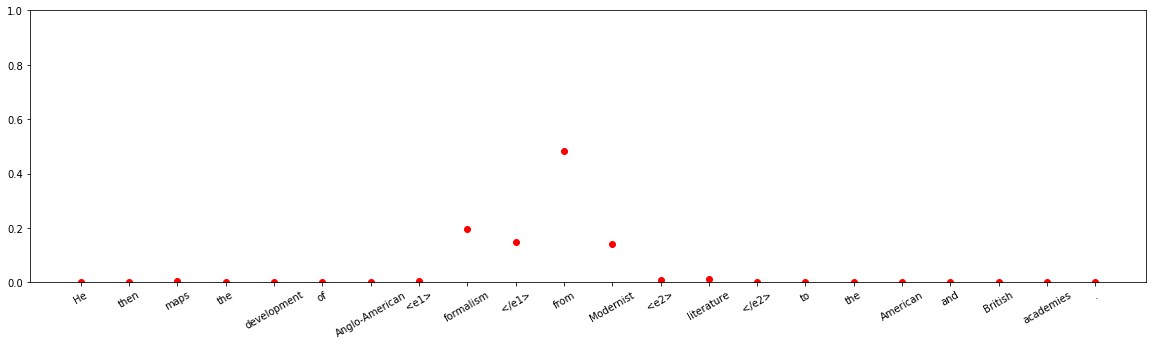








input sentence: The Boyd Group is a British based , independent <e1> think tank </e1> considering <e2> issues </e2> relating to animal testing .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.0003916246
Cause-Effect 	:	 8.1436513e-10
Component-Whole 	:	 2.3924795e-09
Entity-Destination 	:	 2.2714307e-10
Entity-Origin 	:	 2.3368006e-08
Product-Producer 	:	 4.837436e-06
Member-Collection 	:	 1.3634696e-05
Message-Topic 	:	 0.9995895
Content-Container 	:	 5.0426923e-08
Instrument-Agency 	:	 3.6343727e-07



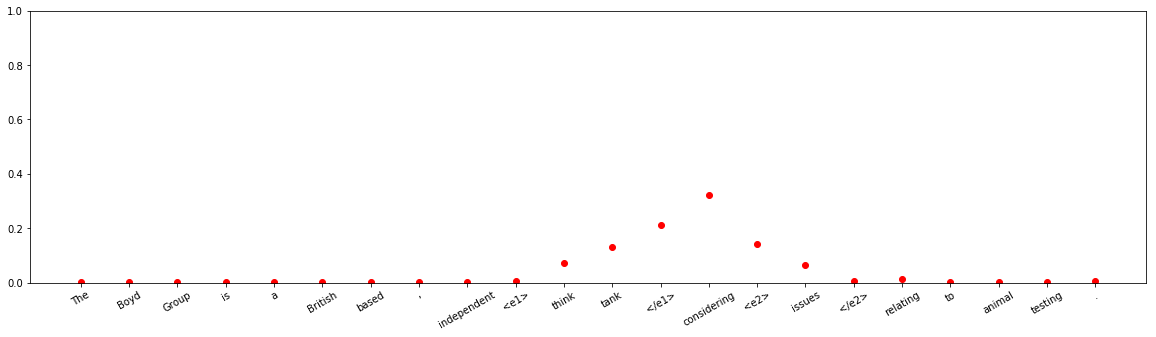


input sentence: <e1> Science </e1> is part of our daily <e2> lives </e2> : all day , every day , everywhere we go .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.015626194
Cause-Effect 	:	 1.0479398e-06
Component-Whole 	:	 0.9838621
Entity-Destination 	:	 1.06718645e-07
Entity-Origin 	:	 1.1828522e-06
Product-Producer 	:	 1.374271e-10
Member-Collection 	:	 0.000104918305
Message-Topic 	:	 0.00040226313
Content-Container 	:	 2.0732161e-06
Instrument-Agency 	:	 6.882153e-09



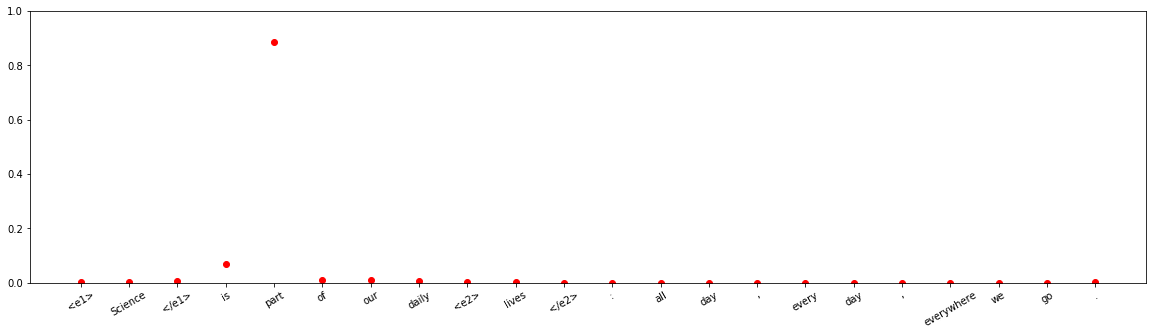






input sentence: The Earth 's <e1> surface </e1> is divided into huge , thick <e2> plates </e2> that drift atop the soft mantle .
answer label:    Component-Whole
wrong label:    Entity-Destination
Other 	:	 0.00032959567
Cause-Effect 	:	 6.586021e-08
Component-Whole 	:	 0.006295662
Entity-Destination 	:	 0.9933702
Entity-Origin 	:	 1.9532996e-08
Product-Producer 	:	 3.533161e-07
Member-Collection 	:	 1.0296922e-07
Message-Topic 	:	 5.6987886e-07
Content-Container 	:	 1.3939584e-06
Instrument-Agency 	:	 1.9638044e-06



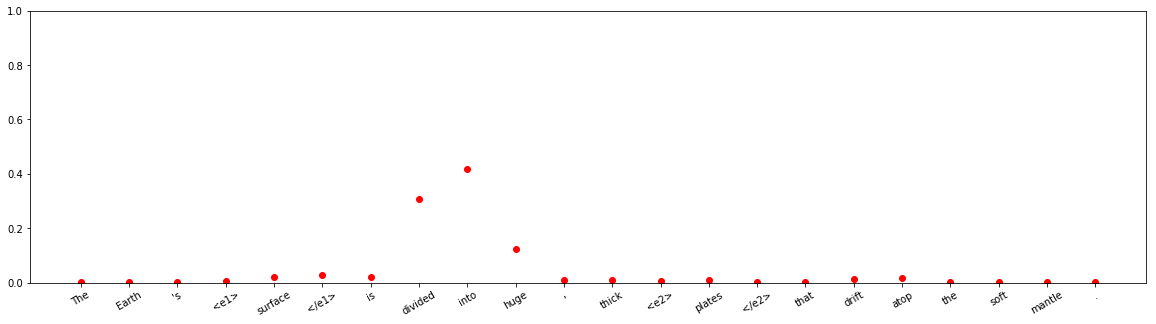





input sentence: The <e1> man </e1> pulled it and the staples off the door , prying gently with a putty <e2> knife </e2> .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 2.270593e-05
Cause-Effect 	:	 3.848161e-09
Component-Whole 	:	 0.85782295
Entity-Destination 	:	 2.1189152e-07
Entity-Origin 	:	 1.460561e-09
Product-Producer 	:	 1.4214799e-08
Member-Collection 	:	 8.4819884e-10
Message-Topic 	:	 3.4138609e-10
Content-Container 	:	 4.682167e-08
Instrument-Agency 	:	 0.14215407



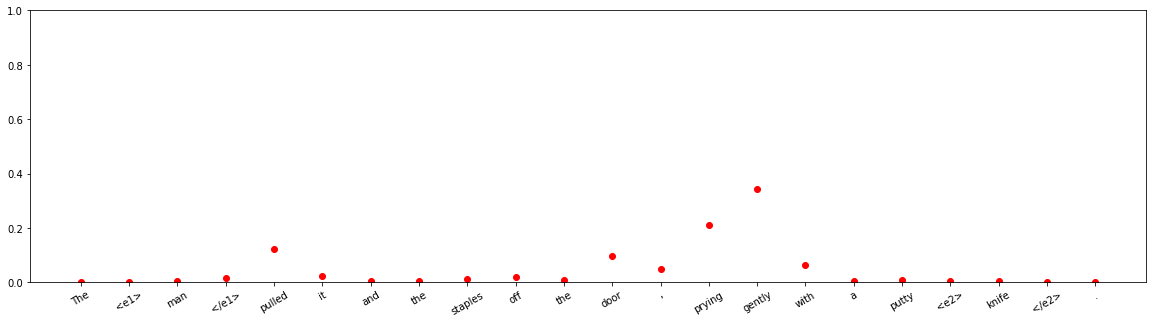





input sentence: The <e1> paddle </e1> , called a dasher , fits inside a <e2> canister </e2> that holds the ice cream mixture .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.00018769776
Cause-Effect 	:	 5.1304088e-08
Component-Whole 	:	 0.7823834
Entity-Destination 	:	 0.003756251
Entity-Origin 	:	 1.0249366e-06
Product-Producer 	:	 2.126149e-05
Member-Collection 	:	 1.5453089e-06
Message-Topic 	:	 8.9116096e-05
Content-Container 	:	 0.21346633
Instrument-Agency 	:	 9.333784e-05



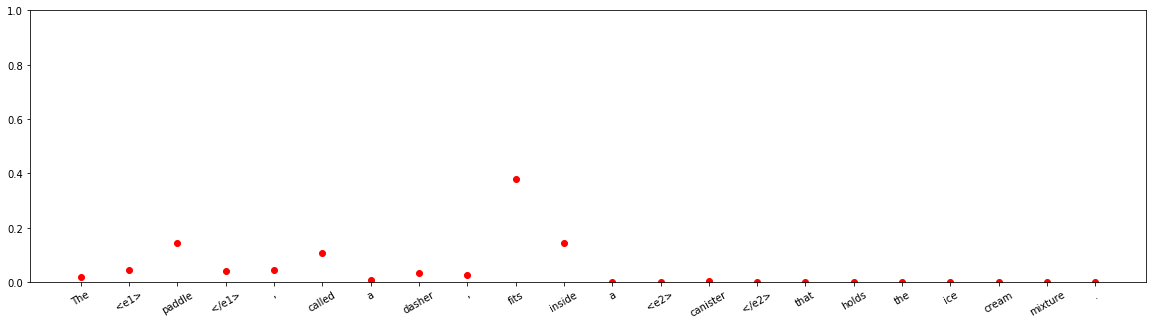


input sentence: That is one of the many reasons that a CEO 's <e1> team </e1> includes an experienced <e2> general counsel </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9993893
Cause-Effect 	:	 1.8052523e-06
Component-Whole 	:	 6.9606544e-06
Entity-Destination 	:	 2.3497373e-10
Entity-Origin 	:	 1.4397962e-07
Product-Producer 	:	 3.6484963e-07
Member-Collection 	:	 0.00047833312
Message-Topic 	:	 1.7906965e-06
Content-Container 	:	 9.650138e-09
Instrument-Agency 	:	 0.00012142185



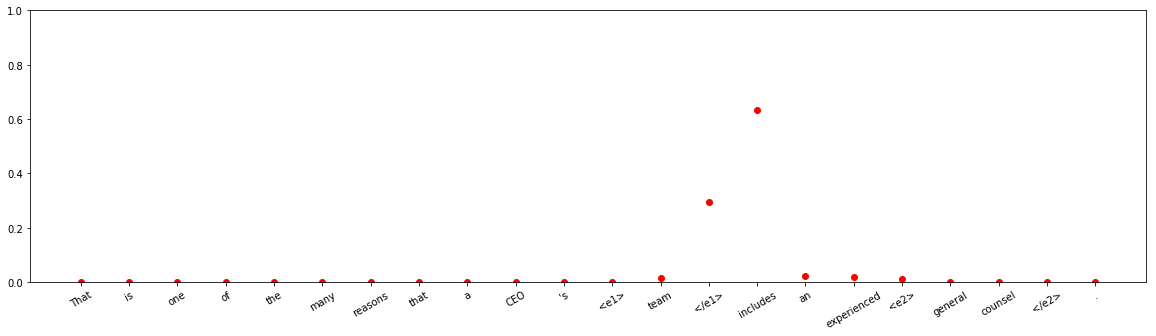


input sentence: The <e1> meeting </e1> decided definitively by secret <e2> vote </e2> of at least 2/3 of those present entitled to vote .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.99249166
Cause-Effect 	:	 8.828323e-06
Component-Whole 	:	 1.730741e-06
Entity-Destination 	:	 6.012149e-08
Entity-Origin 	:	 1.18485914e-07
Product-Producer 	:	 0.0020929382
Member-Collection 	:	 3.2691432e-07
Message-Topic 	:	 0.005401687
Content-Container 	:	 3.032477e-08
Instrument-Agency 	:	 2.5200775e-06



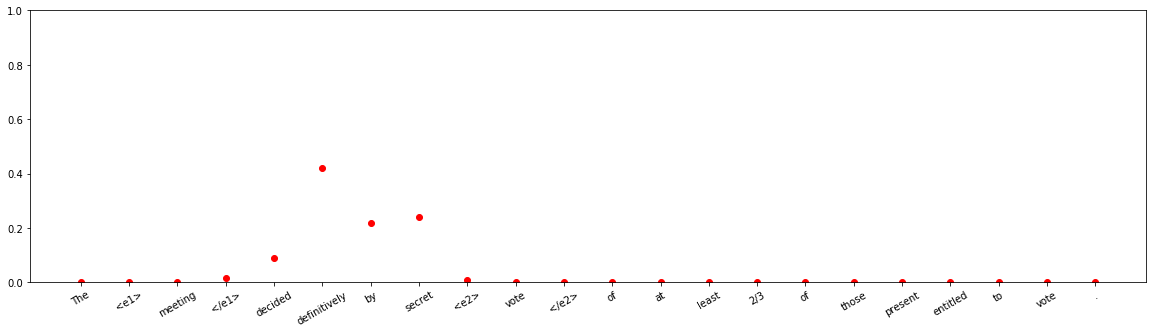



input sentence: The <e1> folks </e1> at the Lilly Endowment were interested in the study of philanthropy through a biographical <e2> lens </e2> .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 0.00039035198
Cause-Effect 	:	 1.4347419e-05
Component-Whole 	:	 0.99825233
Entity-Destination 	:	 2.215876e-05
Entity-Origin 	:	 1.5877406e-05
Product-Producer 	:	 6.1363994e-06
Member-Collection 	:	 1.3102288e-05
Message-Topic 	:	 0.0005834658
Content-Container 	:	 0.0005396243
Instrument-Agency 	:	 0.00016260291



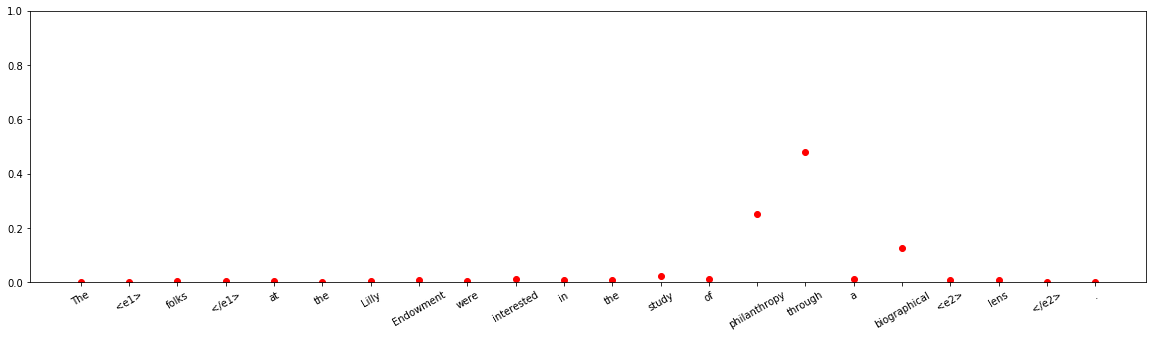







input sentence: Paint <e1> dust </e1> collected from a grit-blasting operation inside a <e2> caisson </e2> was stirred up using a leave blower .
answer label:    Entity-Origin
wrong label:    Entity-Destination
Other 	:	 9.909162e-06
Cause-Effect 	:	 9.797422e-05
Component-Whole 	:	 1.7139002e-06
Entity-Destination 	:	 0.9280863
Entity-Origin 	:	 0.0690477
Product-Producer 	:	 4.6012765e-06
Member-Collection 	:	 1.681673e-07
Message-Topic 	:	 7.784042e-09
Content-Container 	:	 0.0025748415
Instrument-Agency 	:	 0.00017669432



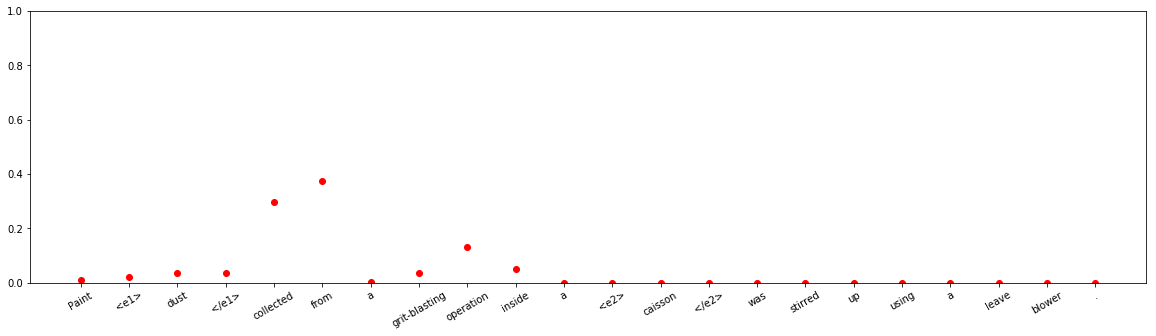




input sentence: The pyramid of champagne flutes is like the <e1> communion </e1> of local <e2> churches </e2> that comprise the Catholic Church .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.94659984
Cause-Effect 	:	 3.9978136e-07
Component-Whole 	:	 3.6594905e-05
Entity-Destination 	:	 1.176679e-06
Entity-Origin 	:	 2.1520184e-06
Product-Producer 	:	 1.9356754e-07
Member-Collection 	:	 0.053357005
Message-Topic 	:	 1.9675263e-06
Content-Container 	:	 4.3097089e-07
Instrument-Agency 	:	 2.0481652e-07



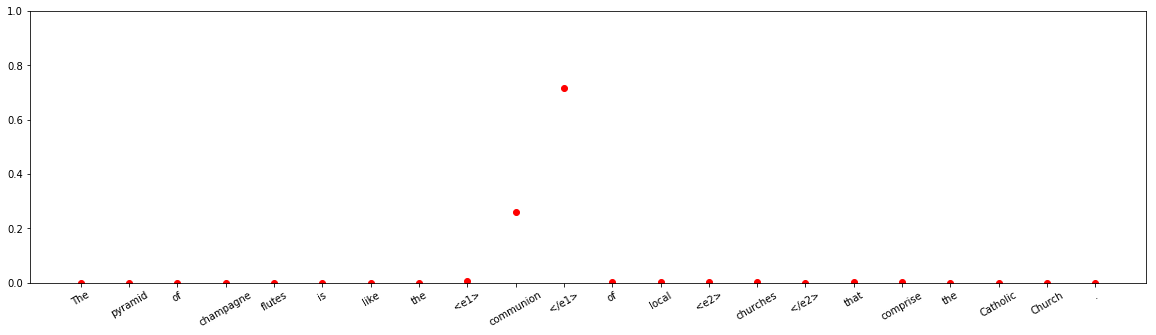





input sentence: That 's why I gave birth in the toilet and hid the <e1> baby </e1> in a <e2> cupboard drawer </e2> .
answer label:    Other
wrong label:    Content-Container
Other 	:	 7.002341e-08
Cause-Effect 	:	 2.5499618e-08
Component-Whole 	:	 0.00016856713
Entity-Destination 	:	 0.028172666
Entity-Origin 	:	 8.399525e-08
Product-Producer 	:	 6.727876e-07
Member-Collection 	:	 9.440255e-08
Message-Topic 	:	 3.7745576e-07
Content-Container 	:	 0.97165585
Instrument-Agency 	:	 1.6074866e-06



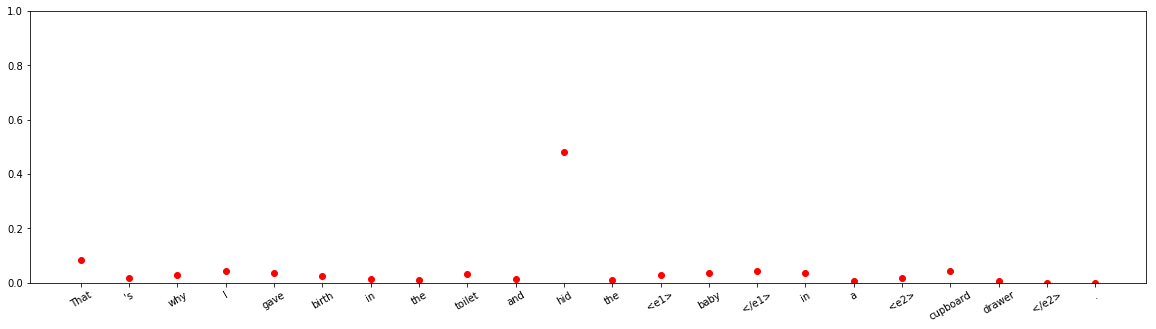







input sentence: A <e1> photograph </e1> reminds Frederic about a forgotten childhood <e2> memory </e2> about a mysterious woman in white a young .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 5.425584e-11
Cause-Effect 	:	 5.788176e-11
Component-Whole 	:	 8.870616e-12
Entity-Destination 	:	 3.9035474e-13
Entity-Origin 	:	 2.7365383e-09
Product-Producer 	:	 6.4505365e-09
Member-Collection 	:	 2.6319927e-10
Message-Topic 	:	 0.99999964
Content-Container 	:	 4.1083402e-07
Instrument-Agency 	:	 4.109029e-11



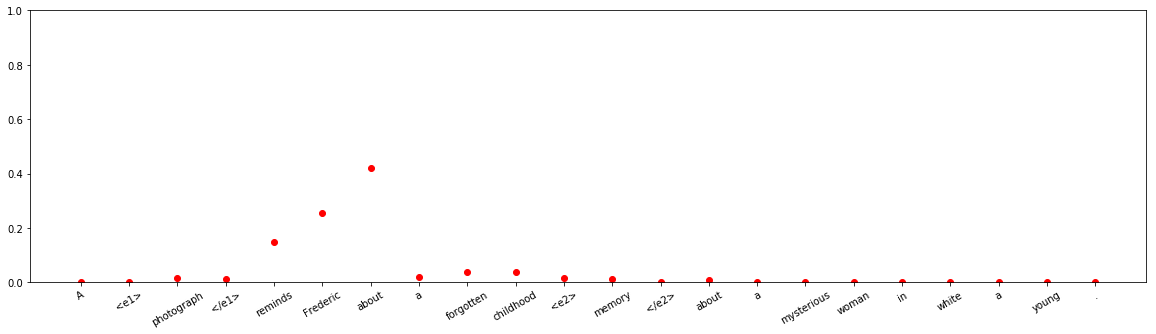











input sentence: The <e1> conference </e1> started with the general <e2> debate </e2> at which heads of delegations are delivering their national statements .
answer label:    Component-Whole
wrong label:    Message-Topic
Other 	:	 0.017170684
Cause-Effect 	:	 8.7005117e-07
Component-Whole 	:	 0.032132335
Entity-Destination 	:	 1.3859763e-07
Entity-Origin 	:	 4.3634476e-08
Product-Producer 	:	 1.3400332e-05
Member-Collection 	:	 1.9937809e-06
Message-Topic 	:	 0.95067877
Content-Container 	:	 1.1144012e-06
Instrument-Agency 	:	 5.195333e-07



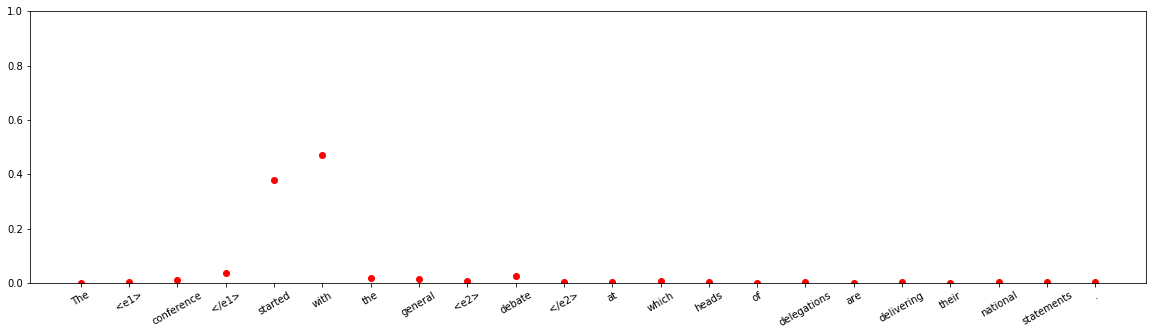



input sentence: Little Irish girl Becky called a <e1> demolition </e1> <e2> company </e2> and asked if they would knock her school down .
answer label:    Cause-Effect
wrong label:    Product-Producer
Other 	:	 0.0022121842
Cause-Effect 	:	 0.00021958807
Component-Whole 	:	 5.5700866e-09
Entity-Destination 	:	 2.0269256e-08
Entity-Origin 	:	 7.924908e-09
Product-Producer 	:	 0.99749726
Member-Collection 	:	 6.981675e-08
Message-Topic 	:	 3.0239795e-07
Content-Container 	:	 1.6438284e-09
Instrument-Agency 	:	 7.034412e-05



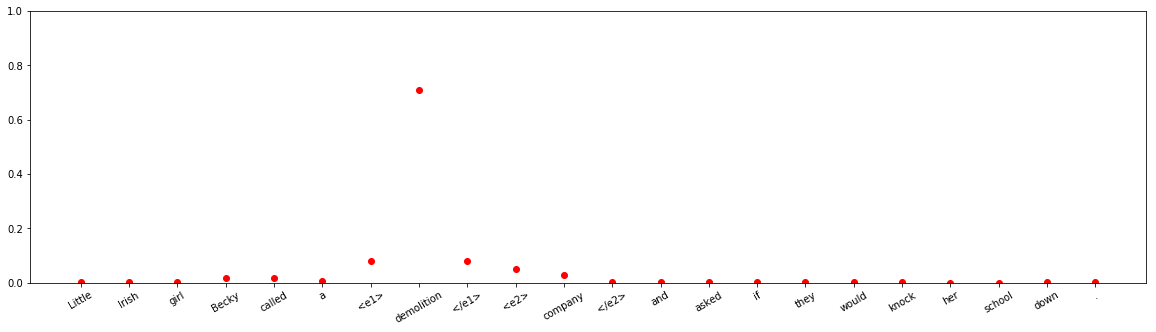


input sentence: The <e1> motor </e1> drives the blade using a <e2> belt </e2> rather than being directly connected like the portable models .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 2.5767735e-08
Cause-Effect 	:	 7.589765e-09
Component-Whole 	:	 0.99546635
Entity-Destination 	:	 1.2955458e-10
Entity-Origin 	:	 6.1470463e-13
Product-Producer 	:	 3.205368e-11
Member-Collection 	:	 8.7293e-10
Message-Topic 	:	 1.3412563e-12
Content-Container 	:	 1.1953992e-10
Instrument-Agency 	:	 0.0045336606



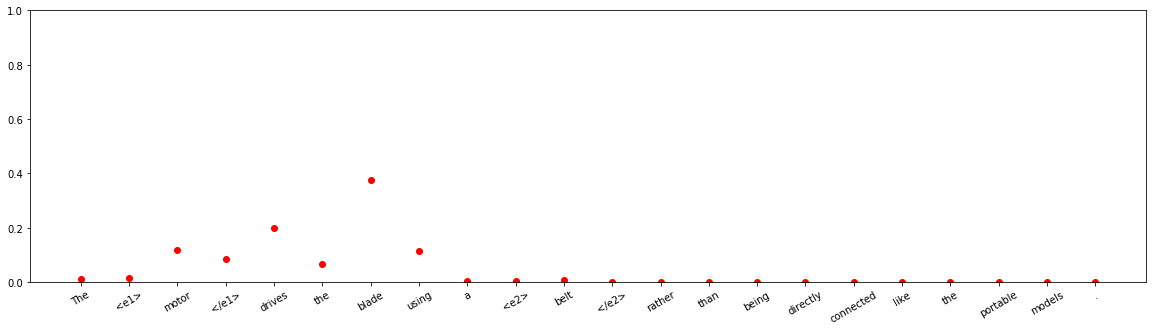












input sentence: In Dutch camping culture empty beer cases are saved and stacked up into a <e1> wall </e1> by <e2> youths </e2> .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9999082
Cause-Effect 	:	 7.628137e-06
Component-Whole 	:	 7.757364e-06
Entity-Destination 	:	 6.5360695e-08
Entity-Origin 	:	 6.421495e-08
Product-Producer 	:	 6.8980924e-05
Member-Collection 	:	 3.1903588e-07
Message-Topic 	:	 6.374544e-06
Content-Container 	:	 9.320932e-09
Instrument-Agency 	:	 4.748564e-07



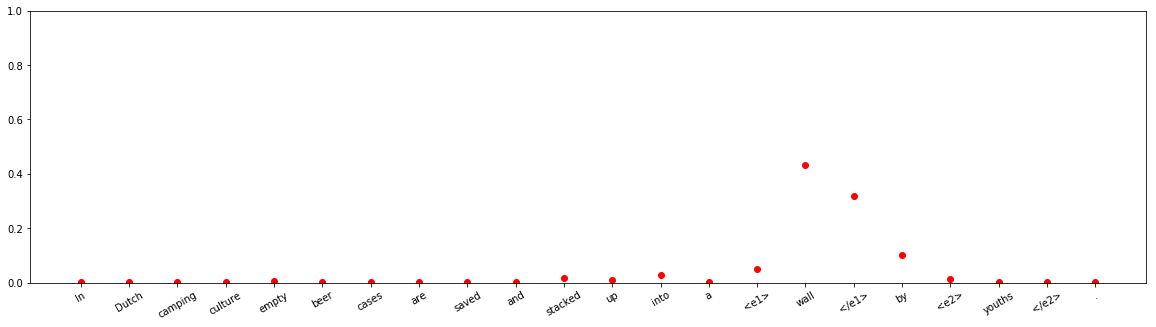



input sentence: Nonetheless , people in the <e1> film </e1> <e2> industry </e2> were sounding alarm bells by the end of the year .
answer label:    Product-Producer
wrong label:    Message-Topic
Other 	:	 3.6310626e-05
Cause-Effect 	:	 0.00014086855
Component-Whole 	:	 0.019334069
Entity-Destination 	:	 1.0091433e-06
Entity-Origin 	:	 0.00040012508
Product-Producer 	:	 0.0031842866
Member-Collection 	:	 9.465276e-06
Message-Topic 	:	 0.9745145
Content-Container 	:	 3.4712004e-05
Instrument-Agency 	:	 0.0023446456



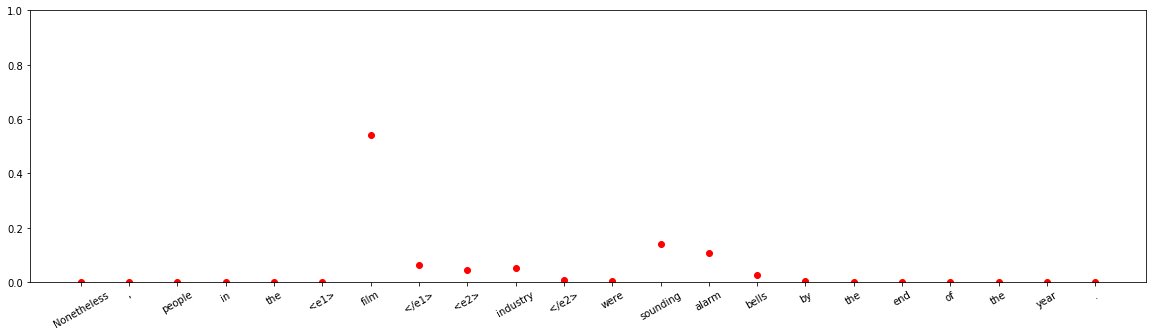













input sentence: Essentially , the <e1> blisters </e1> that appear in the mouth are caused by the <e2> herpes simplex virus </e2> type 1 , HSV-1 for short .
answer label:    Product-Producer
wrong label:    Cause-Effect
Other 	:	 1.3753176e-09
Cause-Effect 	:	 1.0
Component-Whole 	:	 4.9118964e-10
Entity-Destination 	:	 2.4232233e-13
Entity-Origin 	:	 1.20983865e-11
Product-Producer 	:	 2.6974421e-11
Member-Collection 	:	 1.2044508e-15
Message-Topic 	:	 4.3153303e-14
Content-Container 	:	 4.0557322e-15
Instrument-Agency 	:	 8.819236e-11



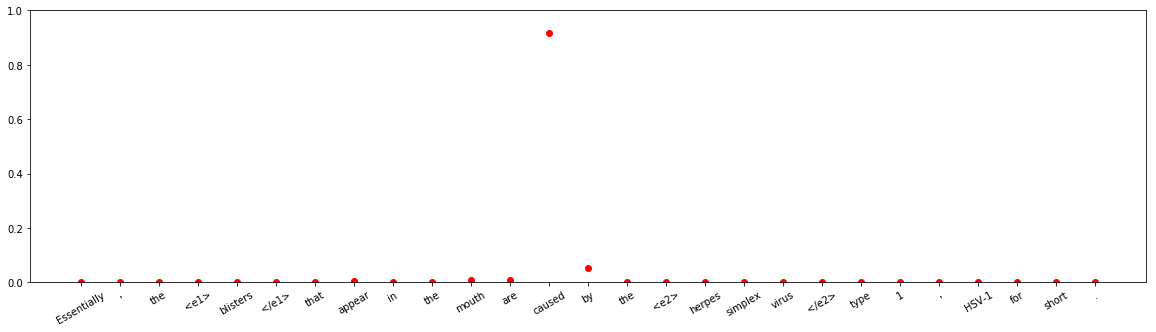










input sentence: These types of scripts help visually impaired individuals to get more <e1> enjoyment </e1> from <e2> programming </e2> because the action on-screen is described for them .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.98990405
Cause-Effect 	:	 0.010095321
Component-Whole 	:	 2.7929895e-08
Entity-Destination 	:	 1.0807867e-09
Entity-Origin 	:	 1.7516953e-07
Product-Producer 	:	 1.44499916e-11
Member-Collection 	:	 3.2698897e-09
Message-Topic 	:	 4.856247e-07
Content-Container 	:	 3.4071405e-12
Instrument-Agency 	:	 1.6456629e-07



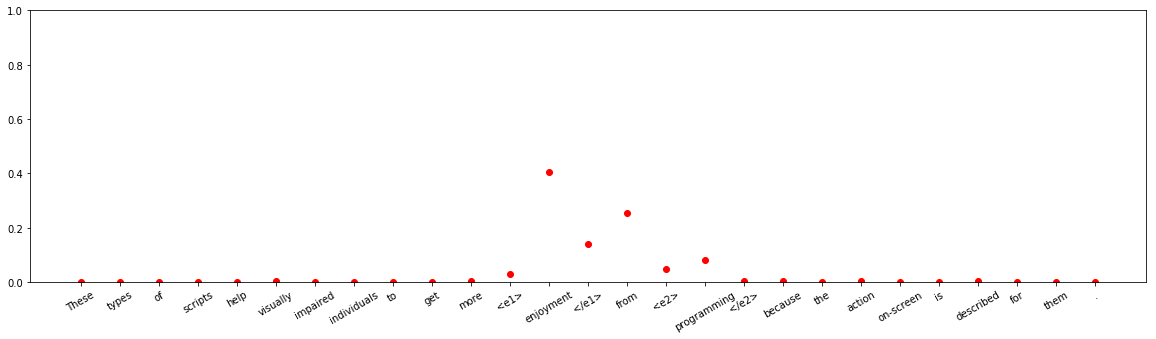



input sentence: I wo n't tell you how much music means now , in these times , when you are battling <e1> depression </e1> from <e2> unemployment </e2> .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.99655473
Cause-Effect 	:	 0.0031968658
Component-Whole 	:	 8.94836e-11
Entity-Destination 	:	 6.3126876e-10
Entity-Origin 	:	 0.00024783777
Product-Producer 	:	 9.683285e-09
Member-Collection 	:	 2.5537363e-09
Message-Topic 	:	 5.734318e-07
Content-Container 	:	 4.192349e-11
Instrument-Agency 	:	 3.9041494e-09



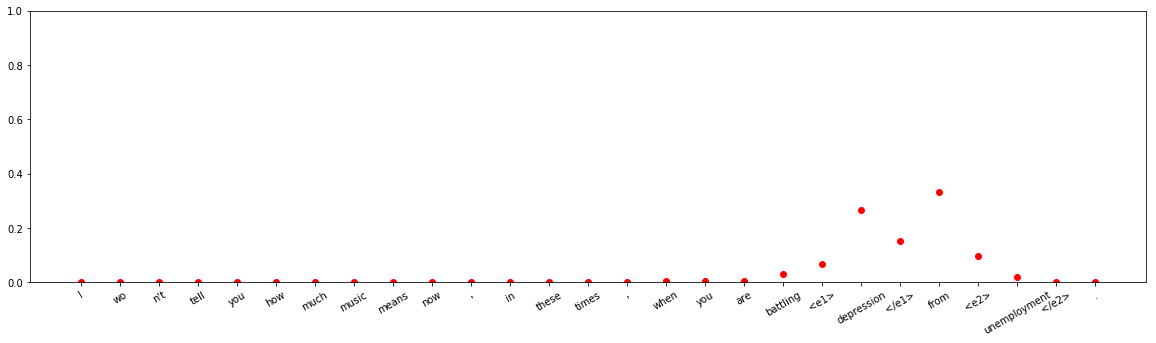




input sentence: On instruments with stoppable strings , such as the violin or guitar , the <e1> player </e1> shortens the vibrating length of the <e2> string </e2> .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 0.0002169275
Cause-Effect 	:	 0.0005130366
Component-Whole 	:	 0.9914868
Entity-Destination 	:	 7.122773e-09
Entity-Origin 	:	 1.9370328e-10
Product-Producer 	:	 2.8664875e-09
Member-Collection 	:	 8.1622744e-07
Message-Topic 	:	 3.3436895e-10
Content-Container 	:	 1.334175e-09
Instrument-Agency 	:	 0.007782343



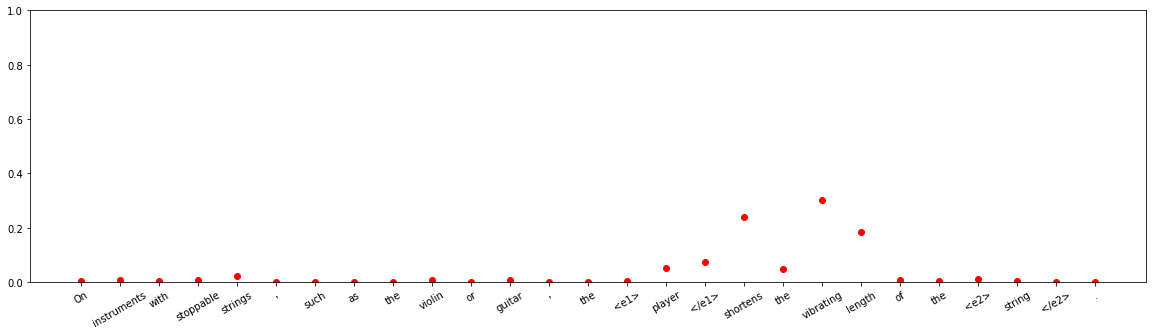










input sentence: In <e1> praise </e1> of these beautiful <e2> classics </e2> we organized 'mekko exhibition ' out of DIY fashion shoots and nostalgic photos from family albums .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 8.505529e-06
Cause-Effect 	:	 4.436411e-05
Component-Whole 	:	 3.237779e-06
Entity-Destination 	:	 1.6416998e-08
Entity-Origin 	:	 2.1320067e-08
Product-Producer 	:	 7.7284254e-05
Member-Collection 	:	 0.9879888
Message-Topic 	:	 0.011872645
Content-Container 	:	 4.6347736e-06
Instrument-Agency 	:	 4.2320255e-07



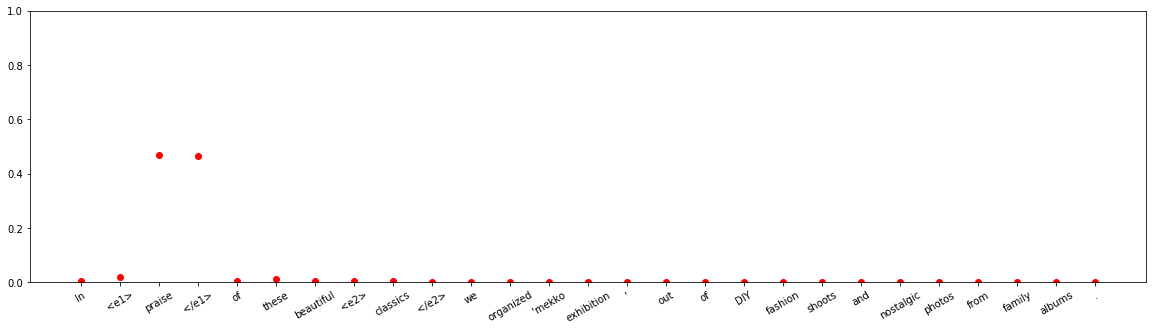


input sentence: After sound waves enter the outer ear , they travel through the <e1> ear </e1> <e2> canal </e2> and make their way to the middle ear .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.7356049
Cause-Effect 	:	 0.000711108
Component-Whole 	:	 0.26297453
Entity-Destination 	:	 0.00028392984
Entity-Origin 	:	 4.3060736e-06
Product-Producer 	:	 1.6259471e-06
Member-Collection 	:	 1.7869418e-07
Message-Topic 	:	 9.5151216e-07
Content-Container 	:	 2.1352438e-08
Instrument-Agency 	:	 0.0004184419



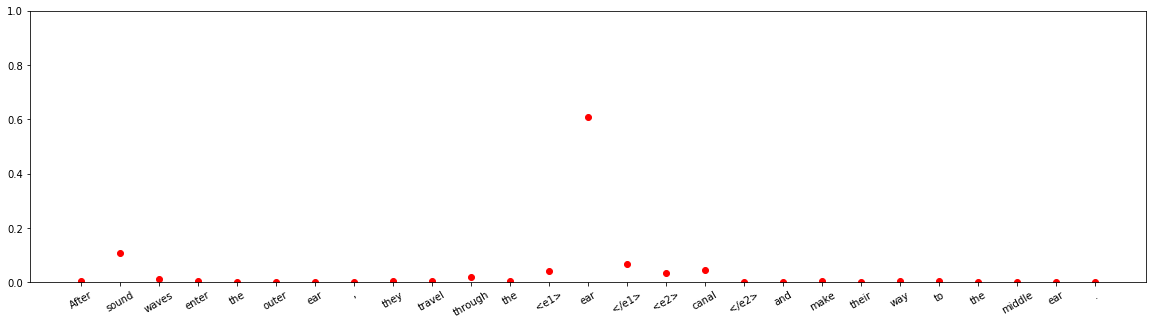









input sentence: In this grotto the boy was also born , and exposed ; the mother leaves the <e1> child </e1> behind in a woven <e2> basket </e2> .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.074215114
Cause-Effect 	:	 1.5550138e-06
Component-Whole 	:	 0.0019006805
Entity-Destination 	:	 0.1635023
Entity-Origin 	:	 0.0113472305
Product-Producer 	:	 0.0022748893
Member-Collection 	:	 3.5167348e-06
Message-Topic 	:	 0.0073980326
Content-Container 	:	 0.7392246
Instrument-Agency 	:	 0.00013210339



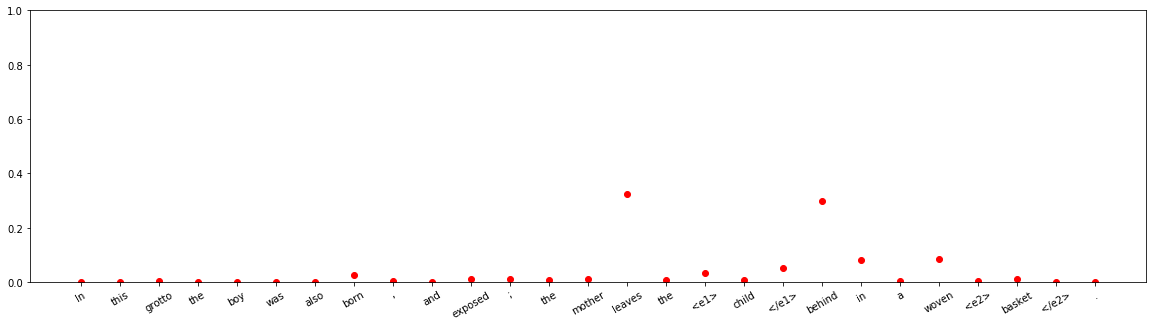



input sentence: During experiments in captivity , <e1> capuchins </e1> have made flint <e2> knives </e2> after banging a piece of flint against the floor until it broke .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.013124273
Cause-Effect 	:	 4.453061e-07
Component-Whole 	:	 0.0851059
Entity-Destination 	:	 2.3220182e-06
Entity-Origin 	:	 0.0014858784
Product-Producer 	:	 0.006725583
Member-Collection 	:	 1.0052038e-05
Message-Topic 	:	 2.222366e-08
Content-Container 	:	 3.6616623e-06
Instrument-Agency 	:	 0.8935419



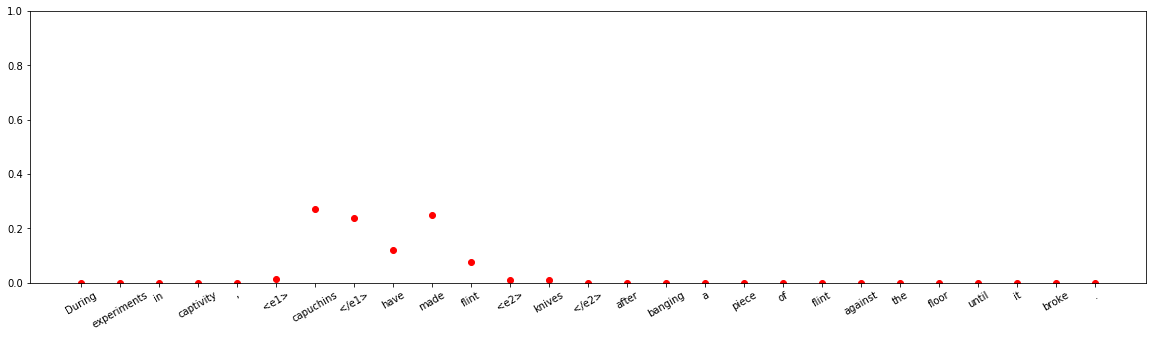



input sentence: A really enjoyable drinking <e1> experience </e1> ensued from this red <e2> blend </e2> from this boutique winery from the Cowra area of Central Western NSW .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.9790952
Cause-Effect 	:	 0.017808989
Component-Whole 	:	 2.9755245e-09
Entity-Destination 	:	 1.0559519e-08
Entity-Origin 	:	 0.003095451
Product-Producer 	:	 1.786236e-10
Member-Collection 	:	 9.150566e-10
Message-Topic 	:	 7.709997e-08
Content-Container 	:	 8.048045e-12
Instrument-Agency 	:	 1.8324474e-07



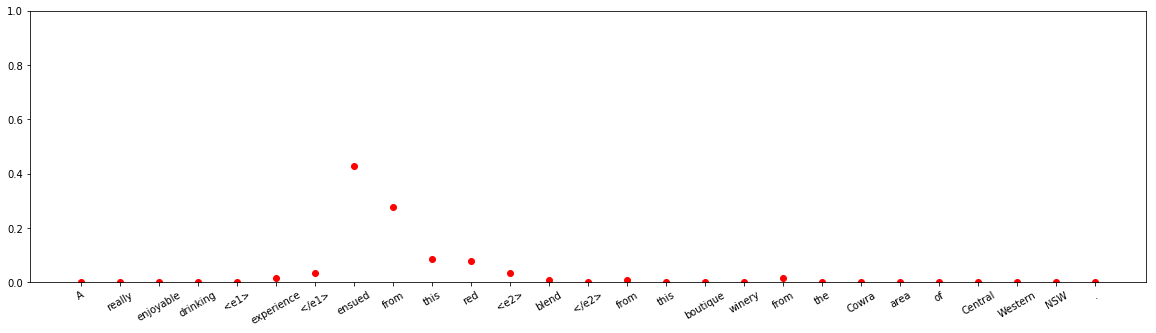




input sentence: Although some of the <e1> stories </e1> were based on <e2> historical truths </e2> , most were a weaving of Greek , Roman and Celtic myths .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 1.0417149e-06
Cause-Effect 	:	 6.9599847e-12
Component-Whole 	:	 7.4771925e-12
Entity-Destination 	:	 7.222291e-12
Entity-Origin 	:	 8.762467e-06
Product-Producer 	:	 2.3561848e-08
Member-Collection 	:	 3.9742078e-11
Message-Topic 	:	 0.9999902
Content-Container 	:	 3.8309592e-10
Instrument-Agency 	:	 1.01206404e-10



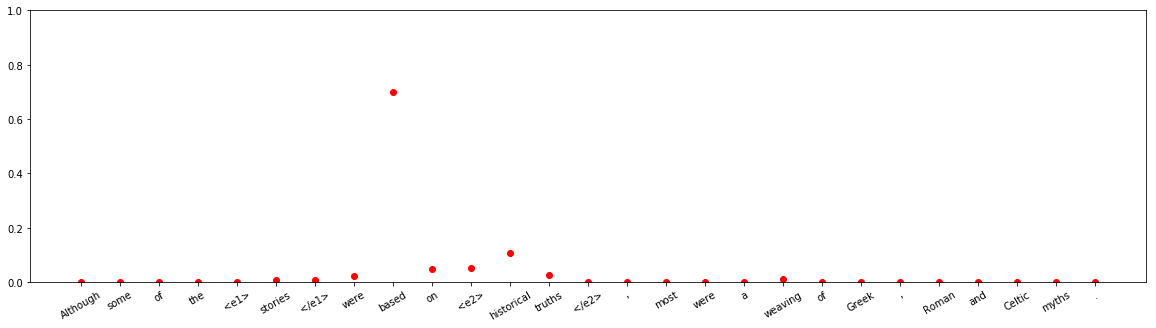



input sentence: Several major manufacturers of <e1> chain </e1> <e2> saws </e2> claim to have invented the first chain saw and all their claims point to the 1920s .
answer label:    Component-Whole
wrong label:    Instrument-Agency
Other 	:	 9.3631536e-07
Cause-Effect 	:	 9.6936465e-06
Component-Whole 	:	 0.052558646
Entity-Destination 	:	 1.2773855e-08
Entity-Origin 	:	 5.426111e-08
Product-Producer 	:	 0.011568951
Member-Collection 	:	 1.3495594e-05
Message-Topic 	:	 1.1396304e-07
Content-Container 	:	 1.2076296e-06
Instrument-Agency 	:	 0.9358469



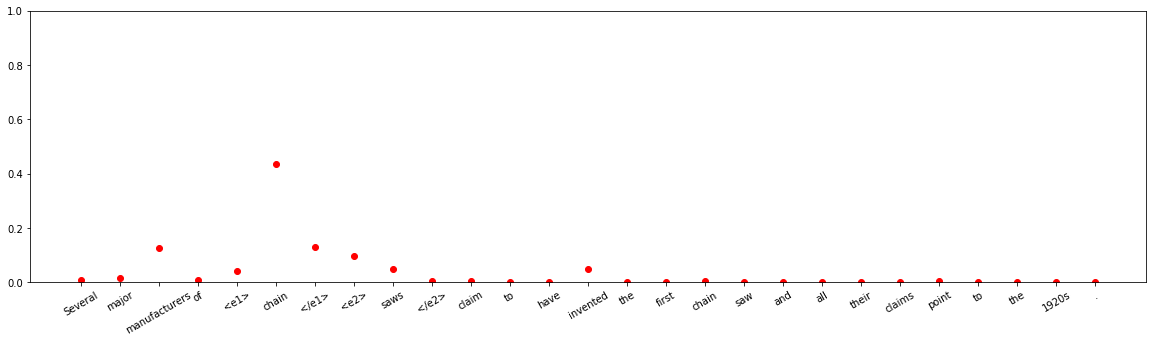


input sentence: He sees <e1> taxation </e1> as a central instrument for the <e2> government </e2> ( over and above revenue raising ) especially for re-distribution of wealth .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.9797325
Cause-Effect 	:	 3.240859e-07
Component-Whole 	:	 0.012586271
Entity-Destination 	:	 3.9639867e-06
Entity-Origin 	:	 2.2772376e-08
Product-Producer 	:	 1.0992282e-07
Member-Collection 	:	 1.0220729e-08
Message-Topic 	:	 1.4470277e-05
Content-Container 	:	 7.729475e-09
Instrument-Agency 	:	 0.0076623913



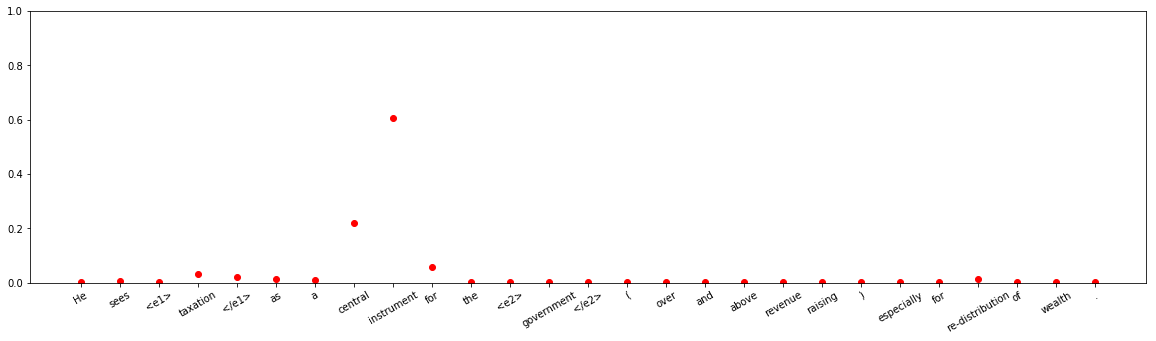





input sentence: As late as the 1950s , for example , only one Mexican served as a <e1> policeman </e1> in the entire Chicago <e2> police force </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.99940574
Cause-Effect 	:	 1.0633706e-08
Component-Whole 	:	 1.2024849e-07
Entity-Destination 	:	 3.284715e-08
Entity-Origin 	:	 3.9579007e-08
Product-Producer 	:	 3.192466e-08
Member-Collection 	:	 0.00058013527
Message-Topic 	:	 2.3103311e-07
Content-Container 	:	 1.19335e-07
Instrument-Agency 	:	 1.3682139e-05



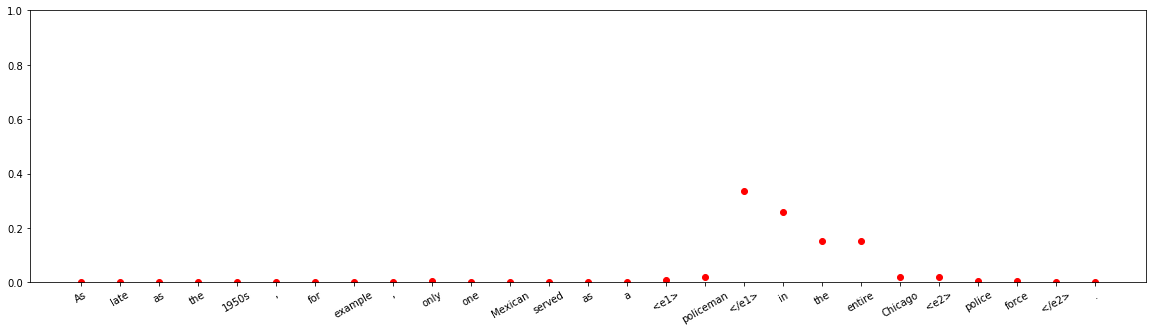


input sentence: And the <e1> citation </e1> from Whelpton 's <e2> books </e2> was listed first in the assortment of quotations specifically characterized as `` comparatively modest '' .
answer label:    Entity-Origin
wrong label:    Product-Producer
Other 	:	 1.6566231e-08
Cause-Effect 	:	 0.0008860432
Component-Whole 	:	 3.3202888e-08
Entity-Destination 	:	 1.714654e-07
Entity-Origin 	:	 0.05286811
Product-Producer 	:	 0.9448613
Member-Collection 	:	 2.524457e-06
Message-Topic 	:	 1.7494467e-05
Content-Container 	:	 5.195126e-06
Instrument-Agency 	:	 0.0013591327



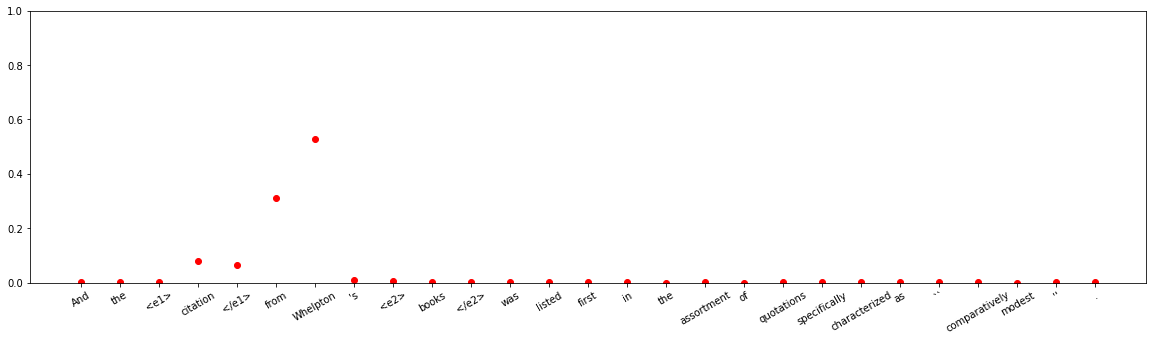




input sentence: I look around to discover he 's about two metres away , obscured from view by a <e1> clutch </e1> of Force India <e2> mechanics </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9953902
Cause-Effect 	:	 4.009394e-08
Component-Whole 	:	 2.4443547e-05
Entity-Destination 	:	 2.101108e-08
Entity-Origin 	:	 1.8847004e-08
Product-Producer 	:	 3.234735e-08
Member-Collection 	:	 0.004320649
Message-Topic 	:	 0.00026431275
Content-Container 	:	 2.1065382e-07
Instrument-Agency 	:	 2.2803778e-07



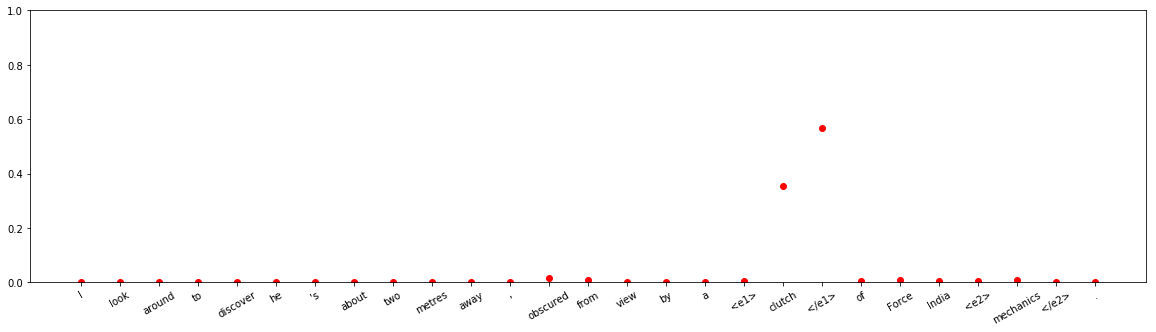



input sentence: Make two holes in the <e1> jar </e1> <e2> lid </e2> , one hole in the middle of the lid and the other near the edge .
answer label:    Component-Whole
wrong label:    Content-Container
Other 	:	 6.970846e-07
Cause-Effect 	:	 9.066189e-09
Component-Whole 	:	 0.013746941
Entity-Destination 	:	 0.052450452
Entity-Origin 	:	 8.0395985e-06
Product-Producer 	:	 2.556584e-08
Member-Collection 	:	 1.8370349e-07
Message-Topic 	:	 4.624881e-09
Content-Container 	:	 0.9337923
Instrument-Agency 	:	 1.3763251e-06



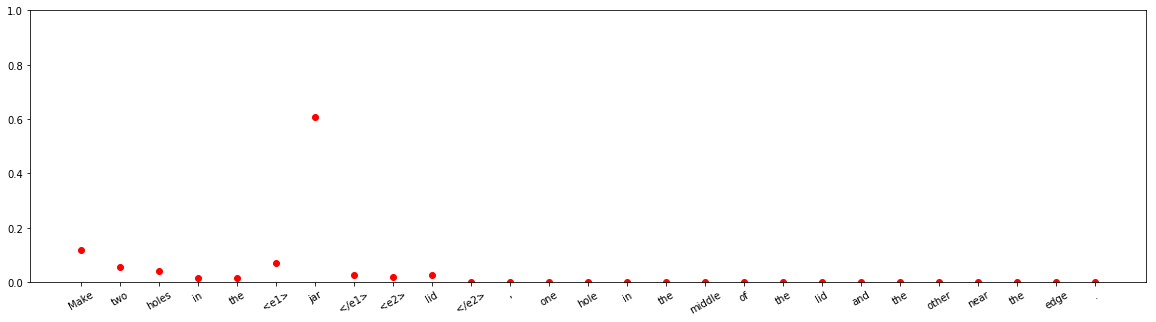


input sentence: Clearwire customers in a <e1> handful </e1> of <e2> locations </e2> were unable to get online for several hours due to a network outage late Tuesday .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.0065901917
Cause-Effect 	:	 2.3002947e-08
Component-Whole 	:	 0.0001777303
Entity-Destination 	:	 0.0005672814
Entity-Origin 	:	 0.0016931236
Product-Producer 	:	 0.00034080943
Member-Collection 	:	 0.9901337
Message-Topic 	:	 1.4286506e-06
Content-Container 	:	 0.00045325657
Instrument-Agency 	:	 4.2506847e-05



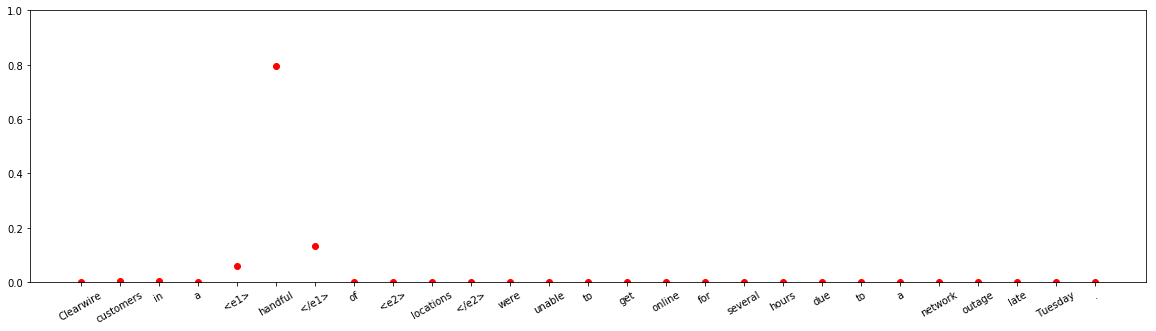





input sentence: The efficiency of the <e1> biosurfactant </e1> produced from used vegetable <e2> oil </e2> was compared to other commercially available surfactants and the results were comparable .
answer label:    Entity-Origin
wrong label:    Cause-Effect
Other 	:	 0.06806224
Cause-Effect 	:	 0.52889496
Component-Whole 	:	 1.4506389e-09
Entity-Destination 	:	 4.1173447e-05
Entity-Origin 	:	 0.40280512
Product-Producer 	:	 6.5237437e-06
Member-Collection 	:	 8.149819e-10
Message-Topic 	:	 2.2790327e-07
Content-Container 	:	 1.4244e-09
Instrument-Agency 	:	 0.00018980018



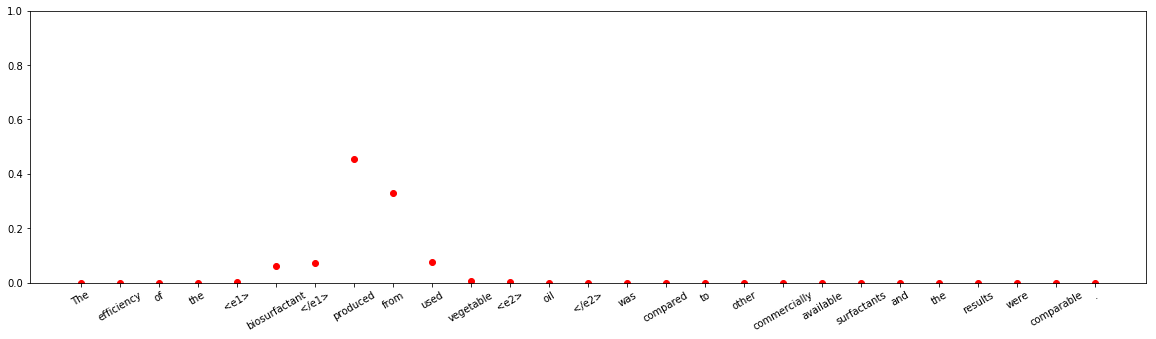








input sentence: In a <e1> cistern </e1> that stores cold <e2> liquids </e2> , the concrete ring serving as juncture element may be thermally lagged against the rock .
answer label:    Content-Container
wrong label:    Component-Whole
Other 	:	 0.0039763693
Cause-Effect 	:	 5.6197926e-08
Component-Whole 	:	 0.9876501
Entity-Destination 	:	 0.00043195998
Entity-Origin 	:	 1.36924355e-05
Product-Producer 	:	 3.5154253e-06
Member-Collection 	:	 1.684028e-05
Message-Topic 	:	 1.0622384e-06
Content-Container 	:	 0.0074153547
Instrument-Agency 	:	 0.000491076



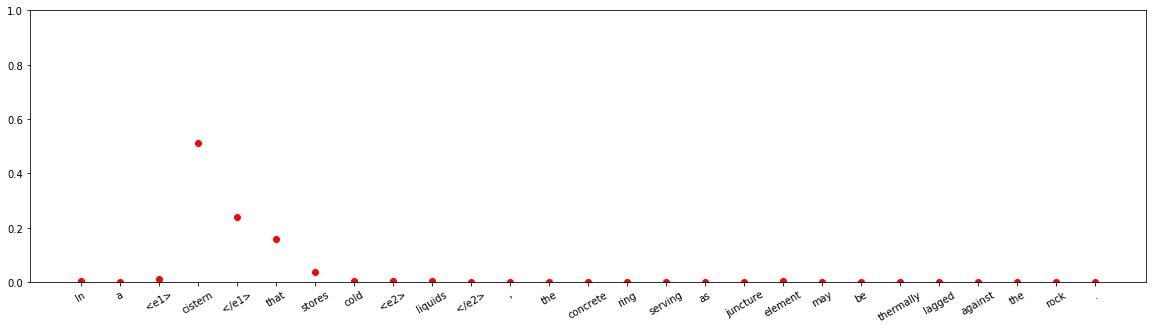


input sentence: Pressure <e1> regulation </e1> using the <e2> valve </e2> and different amounts of fluid goes a long way in keeping your hydraulic log splitter in action .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 1.7791639e-05
Cause-Effect 	:	 1.5905111e-07
Component-Whole 	:	 0.9982811
Entity-Destination 	:	 2.9807214e-07
Entity-Origin 	:	 5.4480684e-11
Product-Producer 	:	 1.3369848e-11
Member-Collection 	:	 1.802615e-09
Message-Topic 	:	 1.939398e-07
Content-Container 	:	 2.5032274e-09
Instrument-Agency 	:	 0.001700291



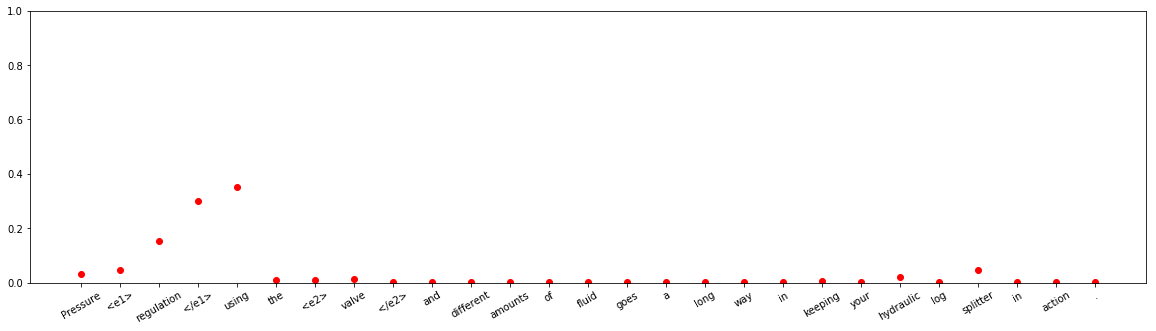







input sentence: A <e1> chip </e1> of his breastbone the shape and size of a pinkie fingernail is preserved in a <e2> reliquary </e2> kept in the rectory .
answer label:    Content-Container
wrong label:    Component-Whole
Other 	:	 1.5038132e-05
Cause-Effect 	:	 1.4751275e-07
Component-Whole 	:	 0.9941823
Entity-Destination 	:	 9.865144e-06
Entity-Origin 	:	 6.1128117e-07
Product-Producer 	:	 7.2156525e-09
Member-Collection 	:	 6.7781457e-06
Message-Topic 	:	 2.33929e-08
Content-Container 	:	 0.0056385794
Instrument-Agency 	:	 0.00014671539



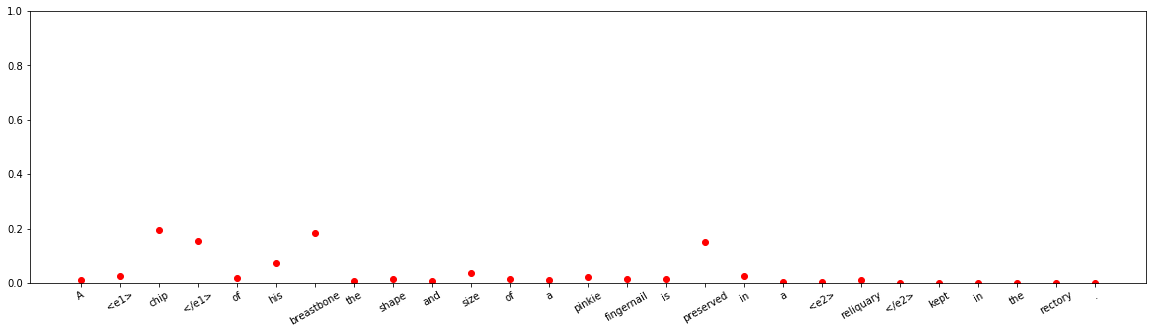



input sentence: A group of women from Curves Timaru won best-dressed prize with their <e1> ensemble </e1> of purple <e2> clothes </e2> , colourful wigs and sparkly tiaras .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.06402641
Cause-Effect 	:	 5.4473117e-07
Component-Whole 	:	 0.015544188
Entity-Destination 	:	 6.715383e-06
Entity-Origin 	:	 4.4593276e-06
Product-Producer 	:	 1.3305197e-05
Member-Collection 	:	 0.9185028
Message-Topic 	:	 9.8517825e-09
Content-Container 	:	 0.00040535166
Instrument-Agency 	:	 0.0014962732



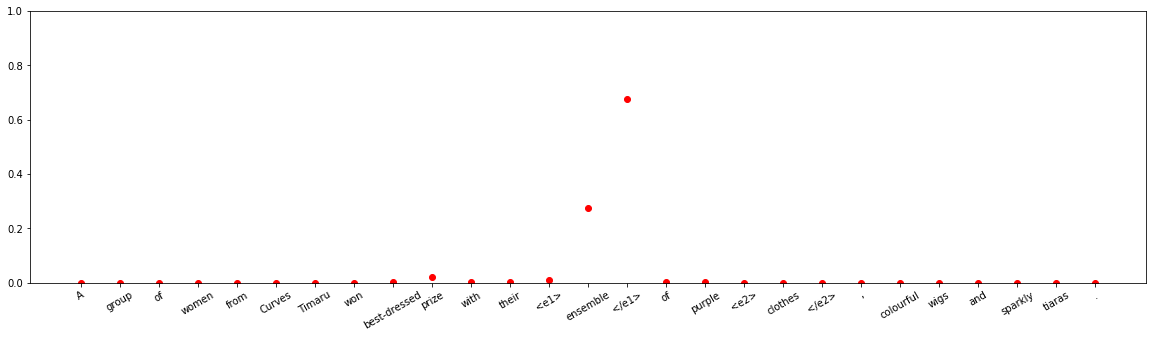



input sentence: Tongsville uses a <e1> menage </e1> of pixel <e2> styles </e2> that are best compared to famed digitally designed experiences like Netbabyworld and eBoy 's eCity .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.0020012725
Cause-Effect 	:	 1.3808418e-07
Component-Whole 	:	 0.9543214
Entity-Destination 	:	 2.3531628e-08
Entity-Origin 	:	 6.717863e-07
Product-Producer 	:	 3.5413822e-07
Member-Collection 	:	 0.040794317
Message-Topic 	:	 2.0806168e-07
Content-Container 	:	 1.6364663e-06
Instrument-Agency 	:	 0.0028799996



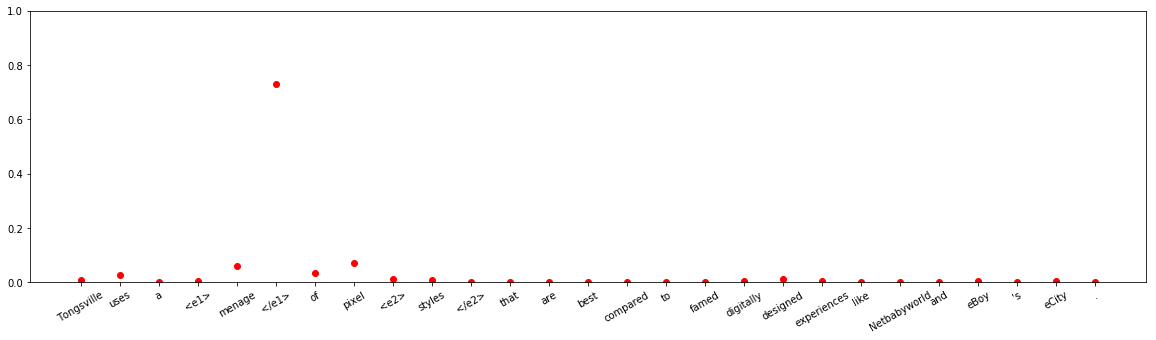


input sentence: This is due to the amount of <e1> sand </e1> in the <e2> hourglass </e2> and the size of the hole the sand must pass through .
answer label:    Content-Container
wrong label:    Other
Other 	:	 0.9952584
Cause-Effect 	:	 8.400892e-08
Component-Whole 	:	 0.0045389053
Entity-Destination 	:	 0.00012276645
Entity-Origin 	:	 4.002528e-07
Product-Producer 	:	 2.4732008e-09
Member-Collection 	:	 2.0256877e-05
Message-Topic 	:	 1.8131863e-07
Content-Container 	:	 4.0815765e-05
Instrument-Agency 	:	 1.8188062e-05



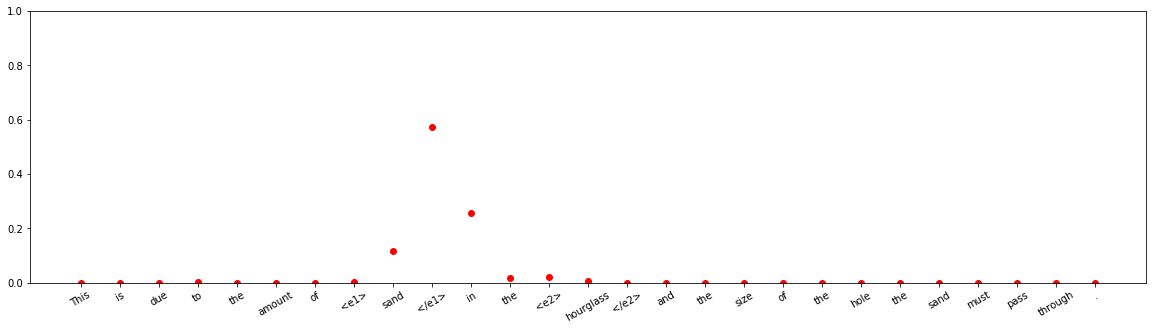














input sentence: All <e1> staff </e1> , from the <e2> chairman </e2> , Charlie Mayfield , to part-time shelf stackers in Waitrose , get the same percentage payout .
answer label:    Member-Collection
wrong label:    Entity-Origin
Other 	:	 4.459947e-05
Cause-Effect 	:	 3.886608e-07
Component-Whole 	:	 1.1243425e-11
Entity-Destination 	:	 5.1851003e-08
Entity-Origin 	:	 0.9978672
Product-Producer 	:	 0.0020836873
Member-Collection 	:	 1.3956046e-07
Message-Topic 	:	 6.6172874e-12
Content-Container 	:	 4.8770904e-10
Instrument-Agency 	:	 3.8582766e-06



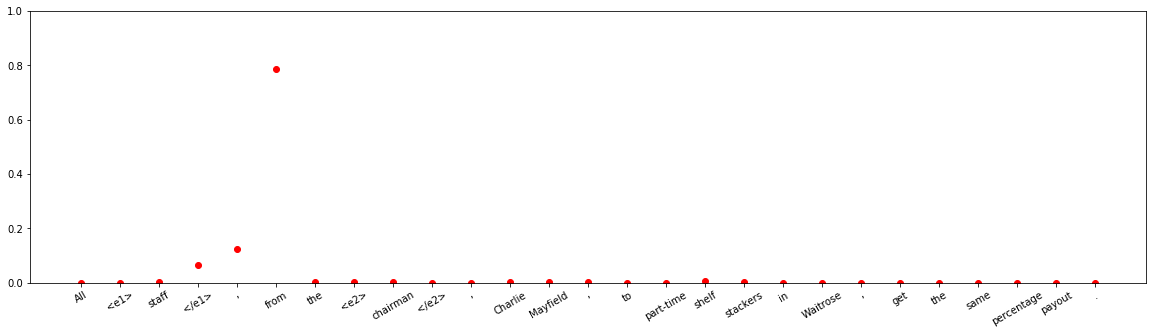



input sentence: They were added to the <e1> photograph </e1> by an unknown <e2> hand </e2> after the picture had been circulating on the Internet for several years .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.0020945426
Cause-Effect 	:	 0.00013709968
Component-Whole 	:	 2.701278e-05
Entity-Destination 	:	 0.17163885
Entity-Origin 	:	 0.00069520366
Product-Producer 	:	 0.807799
Member-Collection 	:	 2.6143592e-08
Message-Topic 	:	 1.783112e-06
Content-Container 	:	 0.00013854522
Instrument-Agency 	:	 0.017467955



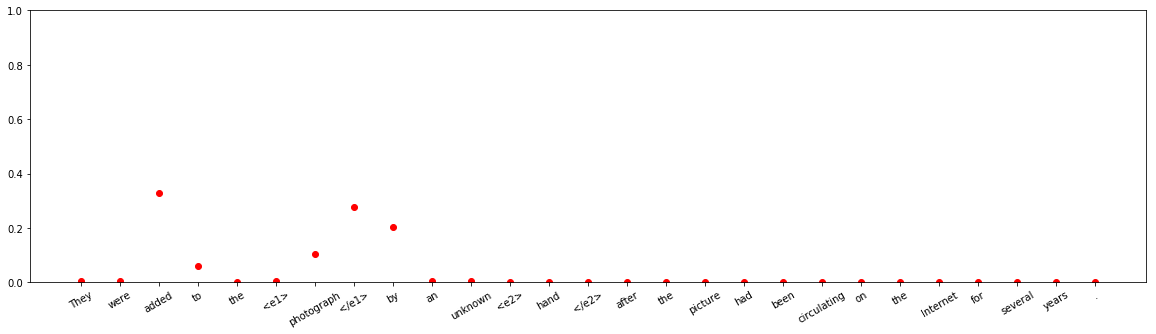







input sentence: The <e1> film </e1> uses <e2> flashbacks </e2> as a device to tell the story , which was based on a 1947 novel by David Goodis .
answer label:    Component-Whole
wrong label:    Cause-Effect
Other 	:	 2.280823e-05
Cause-Effect 	:	 0.4373736
Component-Whole 	:	 0.0051480383
Entity-Destination 	:	 1.4257705e-09
Entity-Origin 	:	 0.0008658531
Product-Producer 	:	 0.0002640539
Member-Collection 	:	 1.8344999e-06
Message-Topic 	:	 0.24905877
Content-Container 	:	 3.2556418e-05
Instrument-Agency 	:	 0.30723253



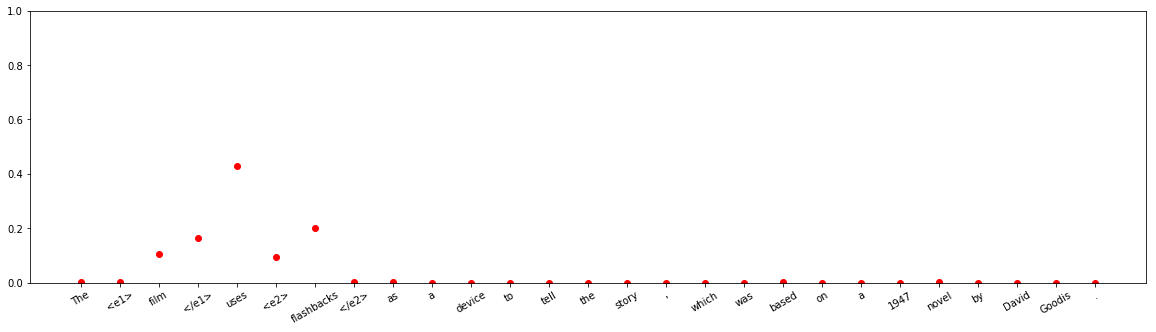







input sentence: The <e1> blisters </e1> are caused by <e2> antibodies </e2> against desmogleins ( Dsgs ) , which are glycoproteins present in the junctions between skin cells .
answer label:    Product-Producer
wrong label:    Cause-Effect
Other 	:	 2.0045191e-11
Cause-Effect 	:	 1.0
Component-Whole 	:	 1.5118195e-13
Entity-Destination 	:	 2.4020251e-15
Entity-Origin 	:	 6.2029597e-13
Product-Producer 	:	 3.0478452e-12
Member-Collection 	:	 4.4697013e-16
Message-Topic 	:	 3.7614705e-15
Content-Container 	:	 1.1626423e-16
Instrument-Agency 	:	 4.3891626e-13



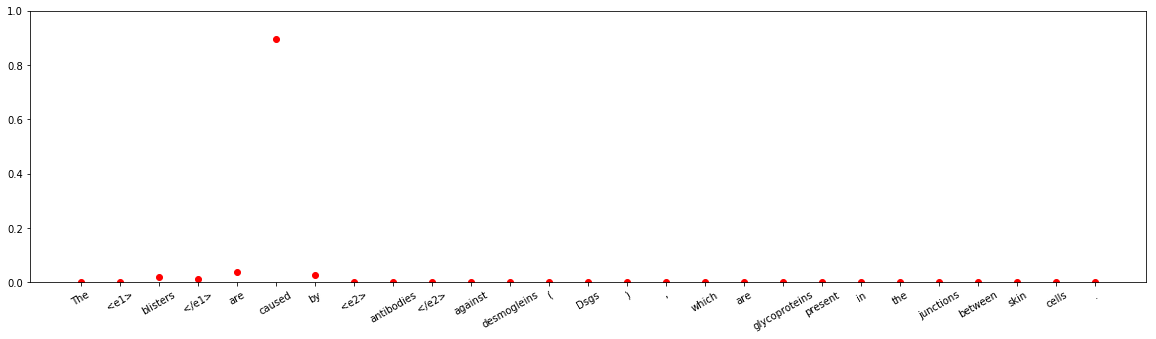


input sentence: There were two wounds on the surface and one was the exit wound of the <e1> gunshot </e1> from the victim 's left <e2> forearm </e2> .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.29477805
Cause-Effect 	:	 0.40855625
Component-Whole 	:	 0.007881604
Entity-Destination 	:	 0.00028205613
Entity-Origin 	:	 0.28458124
Product-Producer 	:	 8.095501e-09
Member-Collection 	:	 2.1702479e-05
Message-Topic 	:	 3.066823e-08
Content-Container 	:	 1.5185221e-06
Instrument-Agency 	:	 0.003897564



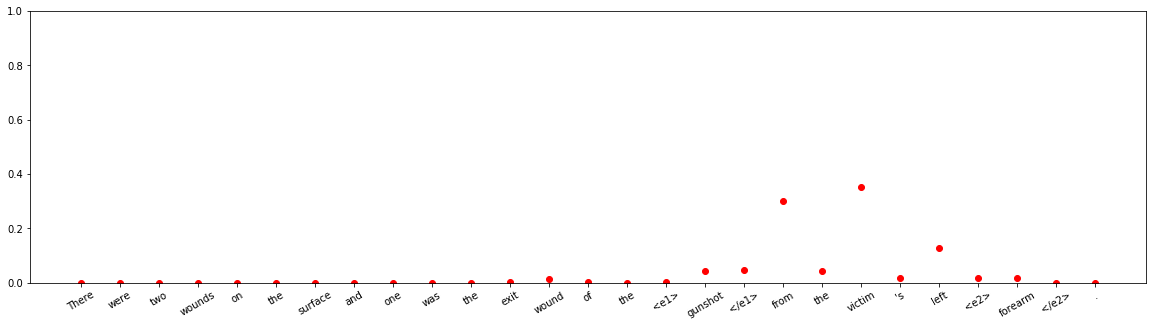



input sentence: Here 's the <e1> theory </e1> I wrote down the other night on the cocktail <e2> napkin </e2> I fished out of my purse just now .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.0003891769
Cause-Effect 	:	 3.0184813e-07
Component-Whole 	:	 0.0007837777
Entity-Destination 	:	 0.0005053138
Entity-Origin 	:	 3.3960656e-05
Product-Producer 	:	 0.06869204
Member-Collection 	:	 3.6314106e-08
Message-Topic 	:	 0.9209569
Content-Container 	:	 0.0003734465
Instrument-Agency 	:	 0.008265007



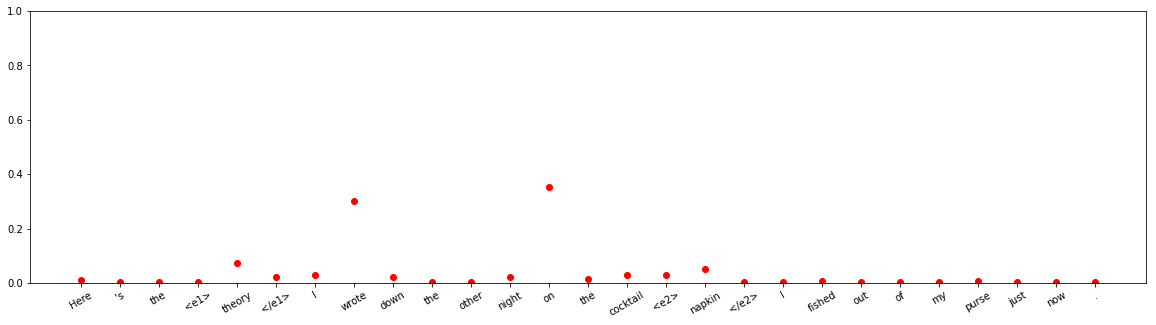



input sentence: A multiple goal model structure is formulated for a <e1> garment </e1> <e2> factory </e2> based on the objectives of the company including minimisation of lateness .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9025861
Cause-Effect 	:	 0.00020367089
Component-Whole 	:	 2.4361777e-06
Entity-Destination 	:	 1.0352501e-08
Entity-Origin 	:	 1.6189722e-06
Product-Producer 	:	 0.09508671
Member-Collection 	:	 5.663549e-06
Message-Topic 	:	 1.4343771e-05
Content-Container 	:	 2.656241e-07
Instrument-Agency 	:	 0.002099256



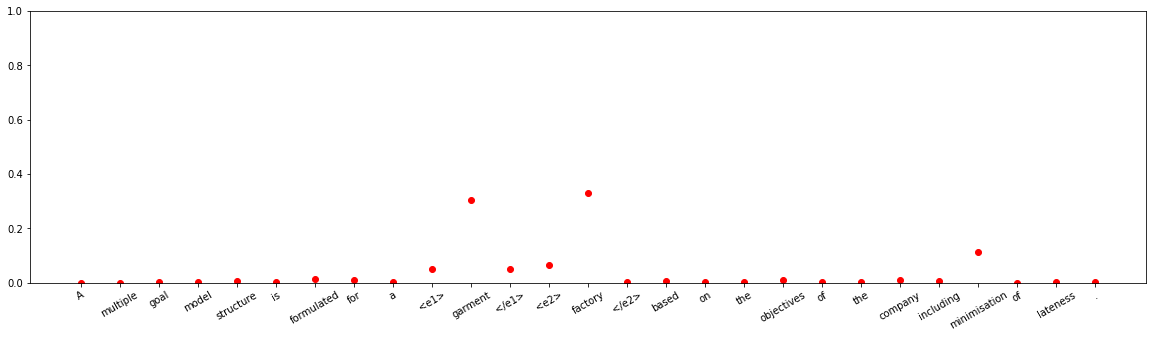


input sentence: The <e1> cabinet </e1> encloses a 6 1/2 inch cone <e2> woofer </e2> , 4 inch cone midrange , and a 7/8 inch balanced dome tweeter .
answer label:    Component-Whole
wrong label:    Content-Container
Other 	:	 3.1185504e-08
Cause-Effect 	:	 1.988474e-08
Component-Whole 	:	 0.053939868
Entity-Destination 	:	 8.414712e-05
Entity-Origin 	:	 3.44003e-08
Product-Producer 	:	 2.3580125e-05
Member-Collection 	:	 6.032569e-07
Message-Topic 	:	 3.3166305e-07
Content-Container 	:	 0.9459464
Instrument-Agency 	:	 4.913192e-06



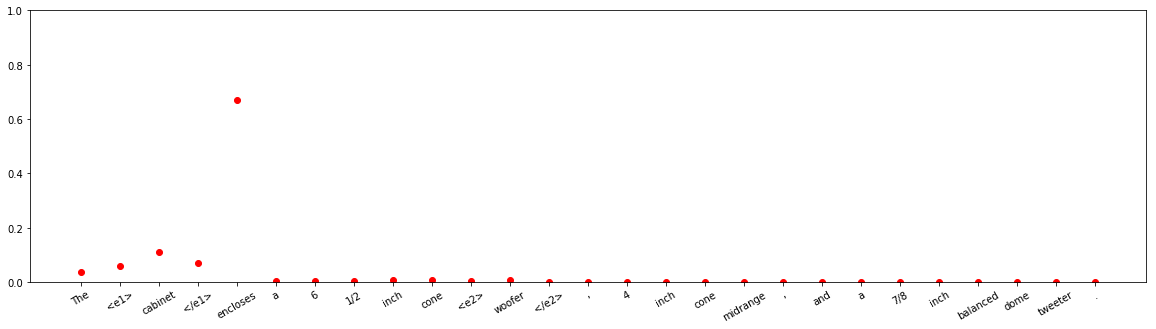


input sentence: <e1> Politicians </e1> are discovering Sufi <e2> teachings </e2> as a means against religious extremism .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.99731404
Cause-Effect 	:	 9.709061e-06
Component-Whole 	:	 1.3447888e-09
Entity-Destination 	:	 1.1953365e-07
Entity-Origin 	:	 5.6887806e-05
Product-Producer 	:	 0.000102656966
Member-Collection 	:	 9.182745e-05
Message-Topic 	:	 0.002353395
Content-Container 	:	 5.244452e-08
Instrument-Agency 	:	 7.144358e-05



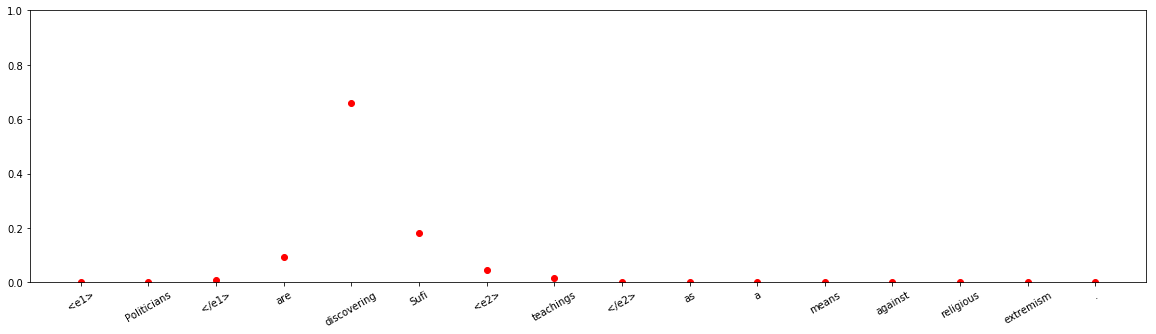


input sentence: The ideal <e1> candidate </e1> has graduated from an approved <e2> program </e2> in Radiography .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.94129795
Cause-Effect 	:	 2.00715e-08
Component-Whole 	:	 2.6041867e-08
Entity-Destination 	:	 0.00020212439
Entity-Origin 	:	 0.058488082
Product-Producer 	:	 7.4495706e-06
Member-Collection 	:	 1.0087908e-08
Message-Topic 	:	 6.690372e-10
Content-Container 	:	 1.2280343e-09
Instrument-Agency 	:	 4.495351e-06



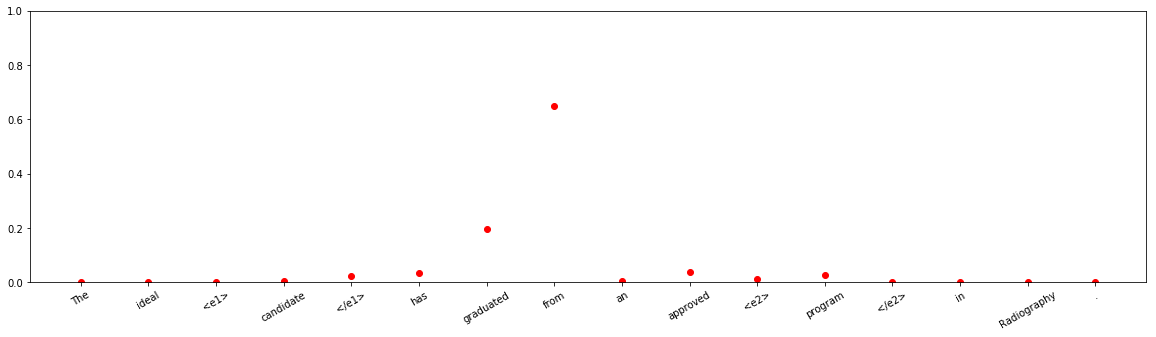




input sentence: The first <e1> couple </e1> of <e2> weeks </e2> at Palm have been a whirlwind .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.00064610614
Cause-Effect 	:	 2.3768223e-07
Component-Whole 	:	 0.998692
Entity-Destination 	:	 7.366637e-07
Entity-Origin 	:	 1.4801778e-07
Product-Producer 	:	 2.0531415e-08
Member-Collection 	:	 0.0005174536
Message-Topic 	:	 0.00012497691
Content-Container 	:	 1.477639e-05
Instrument-Agency 	:	 3.7147997e-06



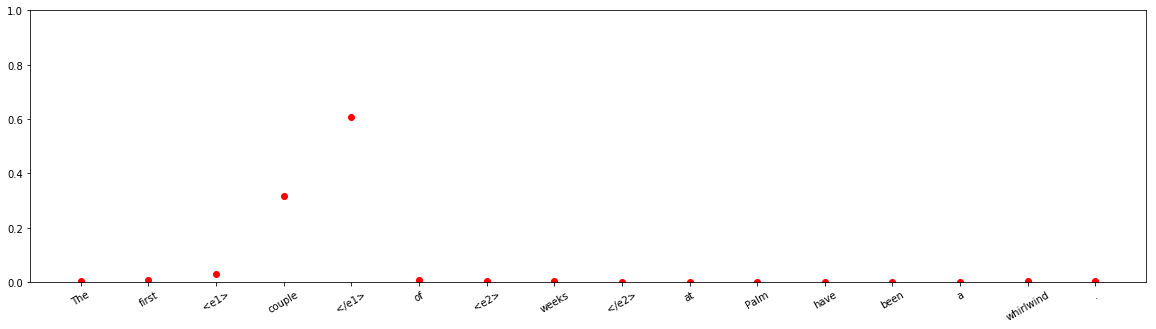






input sentence: The proposal was debated and enthusiastically endorsed in 2002 by a <e1> convocation </e1> of international <e2> scholars </e2> that included many prominent academics , among them scientists of the stature of the late H. Curien , H. Varmus , P. Crutzen and J. Sachs .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 3.366048e-07
Cause-Effect 	:	 3.258679e-11
Component-Whole 	:	 1.0098726e-08
Entity-Destination 	:	 5.1112253e-11
Entity-Origin 	:	 9.709906e-09
Product-Producer 	:	 1.3248421e-08
Member-Collection 	:	 0.99996924
Message-Topic 	:	 3.0105459e-05
Content-Container 	:	 2.8566845e-07
Instrument-Agency 	:	 1.3236058e-10



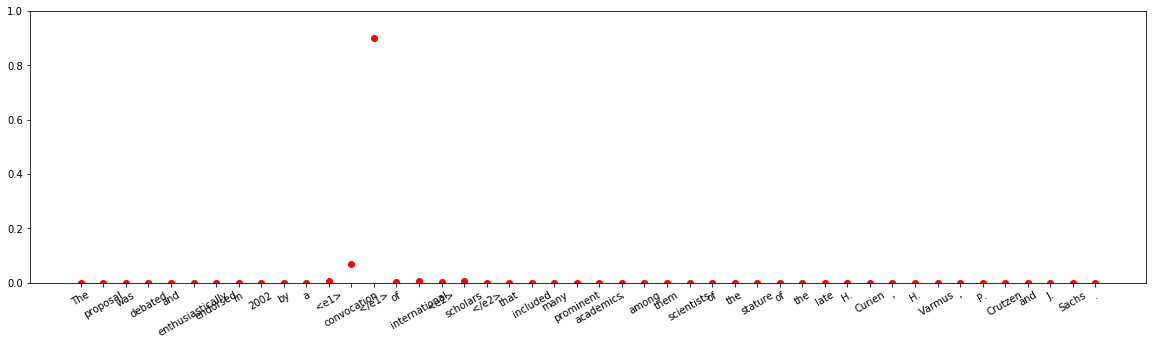






input sentence: I found , moreover , a <e1> body </e1> of trained and earnest school <e2> workers </e2> , whose wealth of experience , professional spirit , and loyal support of the new organization gave ample assurance of advancement in all departments of public school work .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9989907
Cause-Effect 	:	 9.840088e-06
Component-Whole 	:	 5.49689e-08
Entity-Destination 	:	 1.3508351e-08
Entity-Origin 	:	 3.2994117e-07
Product-Producer 	:	 0.00074199925
Member-Collection 	:	 3.9911687e-05
Message-Topic 	:	 0.00020333358
Content-Container 	:	 2.2312664e-08
Instrument-Agency 	:	 1.37813295e-05



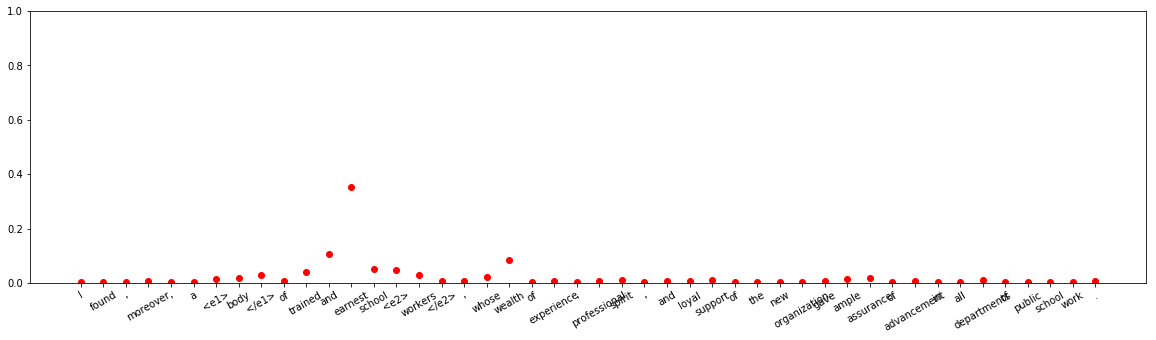


input sentence: The thick slab of spiced <e1> ham </e1> was the best part of this year 's new breakfast <e2> sandwich </e2> ; the salty meat was griddled to a crisp , nut-brown sear , and it outshone the surrounding egg , cheese , and bun .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 2.190447e-05
Cause-Effect 	:	 6.976538e-09
Component-Whole 	:	 0.9999763
Entity-Destination 	:	 1.807804e-07
Entity-Origin 	:	 5.8187656e-08
Product-Producer 	:	 2.7471112e-09
Member-Collection 	:	 1.6080554e-07
Message-Topic 	:	 1.0367989e-07
Content-Container 	:	 3.7721807e-07
Instrument-Agency 	:	 9.3550517e-07



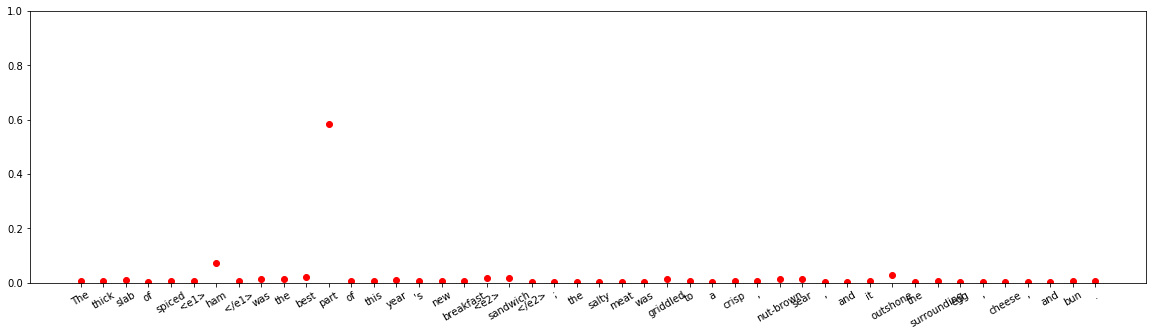





input sentence: The <e1> hall </e1> has a 'vineyard-style ' seating <e2> arrangement </e2> similar to that of Walt Disney Hall , in Los Angeles ; here the audience will be arrayed on raised terraces surrounding an orchestra platform .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 2.4142264e-07
Cause-Effect 	:	 6.336379e-11
Component-Whole 	:	 0.99999964
Entity-Destination 	:	 9.23756e-11
Entity-Origin 	:	 1.7459816e-12
Product-Producer 	:	 5.523769e-11
Member-Collection 	:	 4.0753383e-09
Message-Topic 	:	 5.9761684e-09
Content-Container 	:	 1.2468454e-08
Instrument-Agency 	:	 7.656976e-08



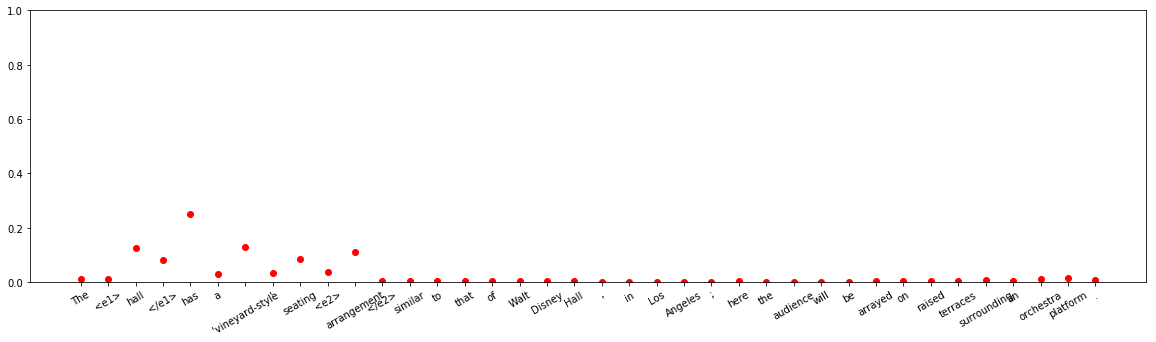




input sentence: The <e1> shop </e1> has since `` fixed '' the problem with a <e2> method </e2> of their own ( with approval from FSA apparently ) and i have the cranks on my bike ready to use .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.9851066
Cause-Effect 	:	 1.3285411e-05
Component-Whole 	:	 0.011707575
Entity-Destination 	:	 1.3114443e-08
Entity-Origin 	:	 2.122889e-09
Product-Producer 	:	 2.5538034e-07
Member-Collection 	:	 6.2686745e-08
Message-Topic 	:	 0.0016211065
Content-Container 	:	 6.232872e-08
Instrument-Agency 	:	 0.0015510683



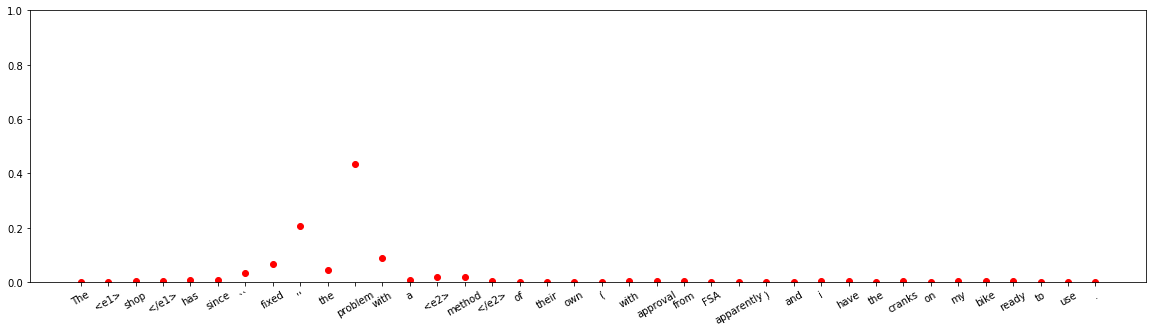
















input sentence: The complete <e1> statue </e1> , topped by an imposing <e2> head </e2> , was originally nearly five metres high .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 7.915477e-06
Cause-Effect 	:	 4.2699511e-07
Component-Whole 	:	 4.6196044e-05
Entity-Destination 	:	 2.5888164e-07
Entity-Origin 	:	 5.100568e-07
Product-Producer 	:	 0.99993527
Member-Collection 	:	 1.3086905e-09
Message-Topic 	:	 2.374073e-11
Content-Container 	:	 1.4245651e-06
Instrument-Agency 	:	 8.025082e-06



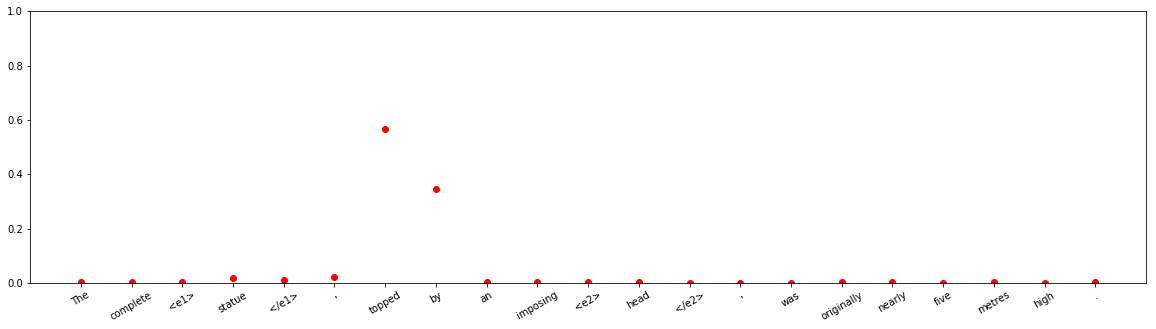






input sentence: The <e1> website </e1> publishes analytical <e2> articles </e2> as well as advanced statistics and projections for individuals and teams .
answer label:    Component-Whole
wrong label:    Message-Topic
Other 	:	 4.3371634e-10
Cause-Effect 	:	 3.4015604e-09
Component-Whole 	:	 3.258429e-06
Entity-Destination 	:	 1.3195578e-09
Entity-Origin 	:	 5.72416e-10
Product-Producer 	:	 0.029302536
Member-Collection 	:	 6.011024e-07
Message-Topic 	:	 0.9706925
Content-Container 	:	 2.3754194e-07
Instrument-Agency 	:	 9.08994e-07



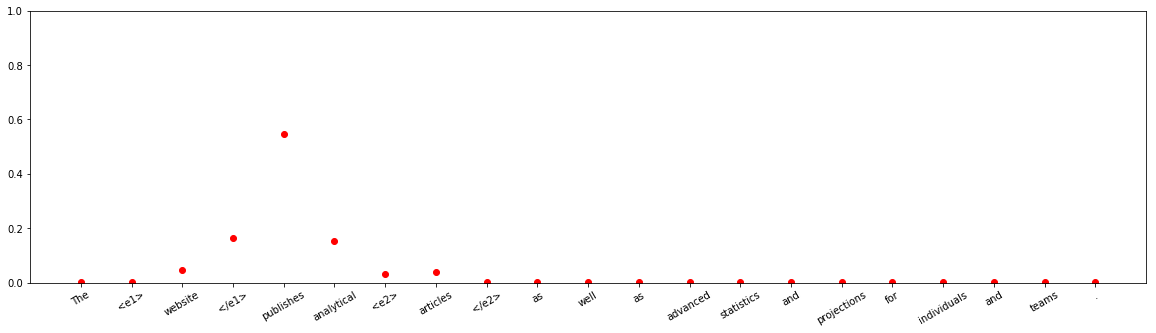




input sentence: That measured moisture content of bagged <e1> samples </e1> inserted in a <e2> beaker </e2> of soil at various depths .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 1.6495095e-11
Cause-Effect 	:	 2.940031e-11
Component-Whole 	:	 2.595777e-10
Entity-Destination 	:	 0.90817165
Entity-Origin 	:	 1.2802911e-06
Product-Producer 	:	 7.627088e-09
Member-Collection 	:	 1.1016844e-09
Message-Topic 	:	 8.376059e-10
Content-Container 	:	 0.09182711
Instrument-Agency 	:	 2.6287832e-08



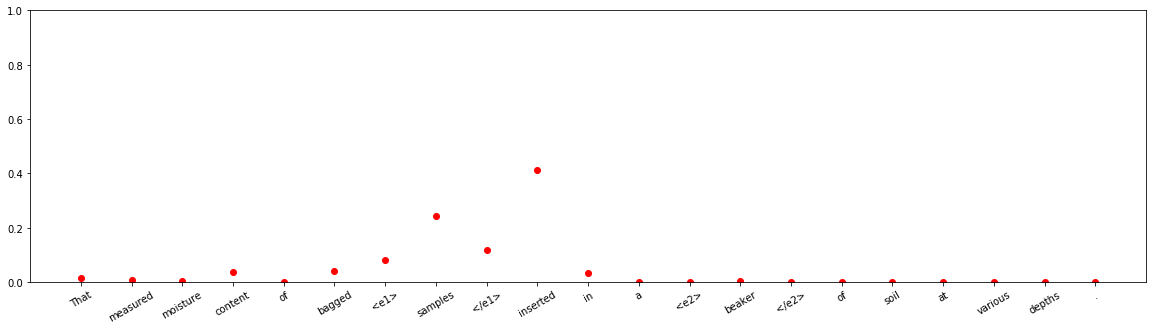







input sentence: These pages are intended to assist you in accessing Belgian library <e1> book </e1> <e2> catalogues </e2> over the internet .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 6.345393e-08
Cause-Effect 	:	 8.843175e-08
Component-Whole 	:	 0.5222475
Entity-Destination 	:	 2.27e-06
Entity-Origin 	:	 7.1365093e-06
Product-Producer 	:	 0.39253277
Member-Collection 	:	 0.006444106
Message-Topic 	:	 0.026907066
Content-Container 	:	 0.05103296
Instrument-Agency 	:	 0.000826083



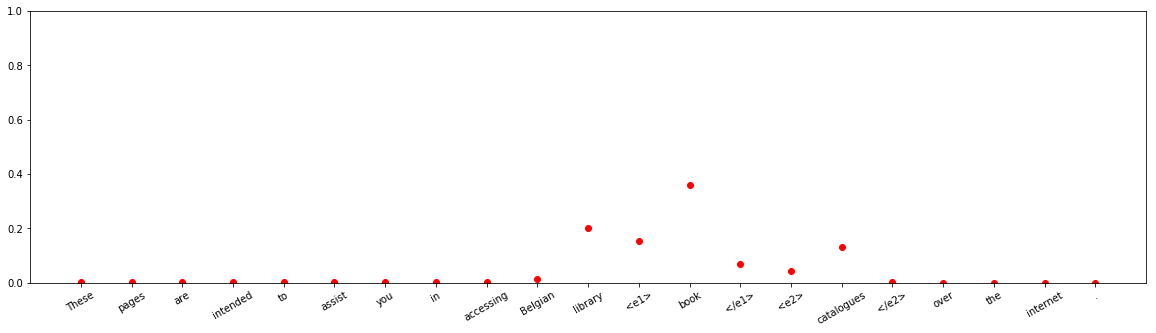





input sentence: A latching device removably secures and sealingly engages a closure around an <e1> opening </e1> in a <e2> cask </e2> .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.00076856976
Cause-Effect 	:	 6.3261444e-07
Component-Whole 	:	 0.25243455
Entity-Destination 	:	 0.018823838
Entity-Origin 	:	 1.889962e-08
Product-Producer 	:	 3.7726886e-07
Member-Collection 	:	 1.0765811e-05
Message-Topic 	:	 0.022953773
Content-Container 	:	 0.70499724
Instrument-Agency 	:	 1.0145333e-05



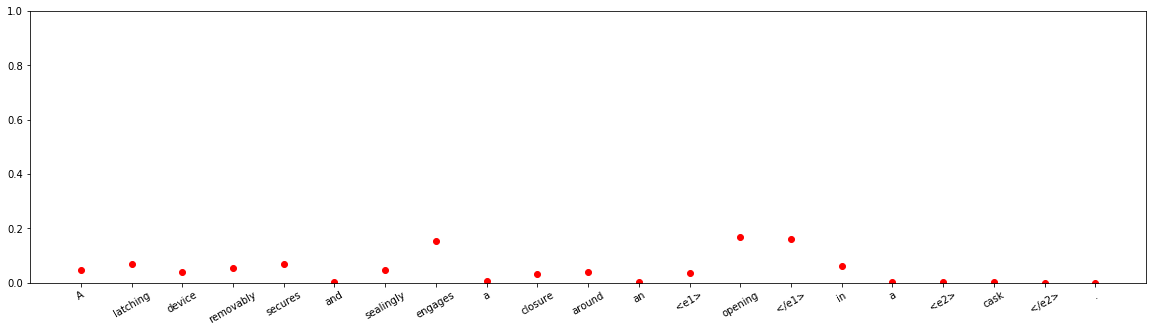


input sentence: Ansari allegdely bombed Jhaveri Bazaar and the <e1> family </e1> took the <e2> taxi </e2> to the Gateway of India .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.5648912
Cause-Effect 	:	 5.409192e-08
Component-Whole 	:	 0.00017163716
Entity-Destination 	:	 3.6070516e-05
Entity-Origin 	:	 2.2791017e-05
Product-Producer 	:	 0.00054502214
Member-Collection 	:	 7.83343e-07
Message-Topic 	:	 2.8554148e-06
Content-Container 	:	 4.1576595e-08
Instrument-Agency 	:	 0.43432945



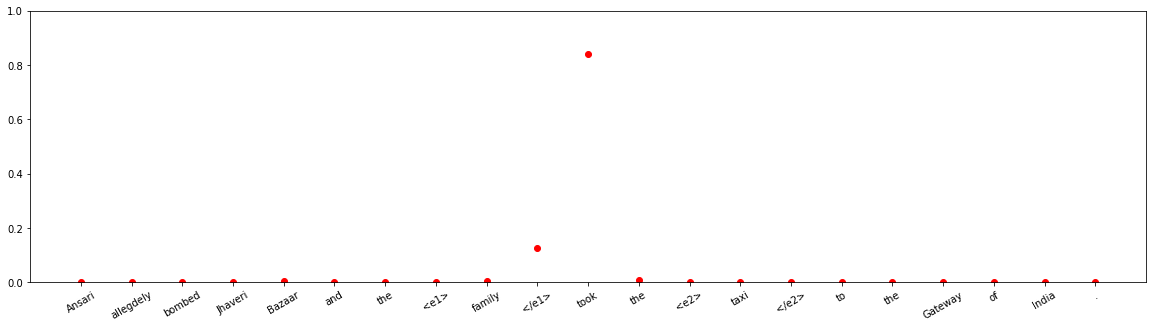



input sentence: One <e1> topic </e1> that came up in the <e2> discussion </e2> with the audience was the future of news .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 1.7126751e-09
Cause-Effect 	:	 2.264666e-10
Component-Whole 	:	 1.7944847e-09
Entity-Destination 	:	 8.4659585e-11
Entity-Origin 	:	 2.9732158e-10
Product-Producer 	:	 5.0368985e-08
Member-Collection 	:	 6.591195e-11
Message-Topic 	:	 1.0
Content-Container 	:	 3.0053682e-09
Instrument-Agency 	:	 4.5376418e-11



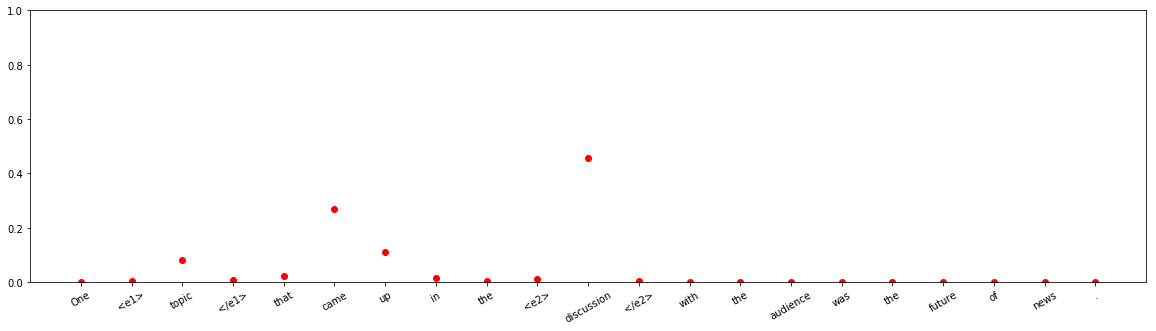



input sentence: The <e1> criminal </e1> just got out of <e2> jail </e2> from a mutli-million dollar fraud involving his old company .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.9999931
Cause-Effect 	:	 4.5645006e-06
Component-Whole 	:	 1.8338351e-08
Entity-Destination 	:	 1.7758857e-08
Entity-Origin 	:	 4.1051953e-07
Product-Producer 	:	 1.1196435e-09
Member-Collection 	:	 4.774283e-09
Message-Topic 	:	 1.0574155e-06
Content-Container 	:	 1.0084079e-10
Instrument-Agency 	:	 9.4774623e-07



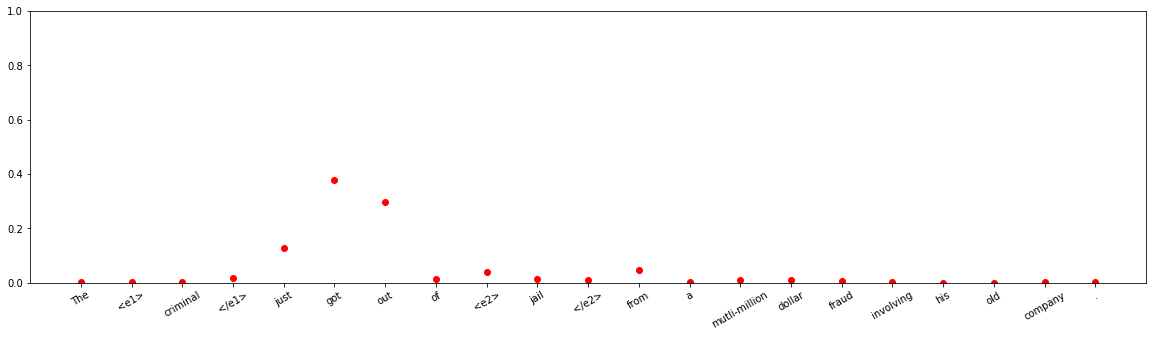


input sentence: The shrinkage debate suddenly gained prominence last month with a blunt <e1> comment </e1> by the acting <e2> mayor </e2> .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.98085713
Cause-Effect 	:	 1.9395806e-05
Component-Whole 	:	 9.784194e-07
Entity-Destination 	:	 2.4242755e-08
Entity-Origin 	:	 1.0843732e-07
Product-Producer 	:	 0.017029857
Member-Collection 	:	 6.6189244e-08
Message-Topic 	:	 0.0020182051
Content-Container 	:	 1.0652478e-09
Instrument-Agency 	:	 7.428007e-05



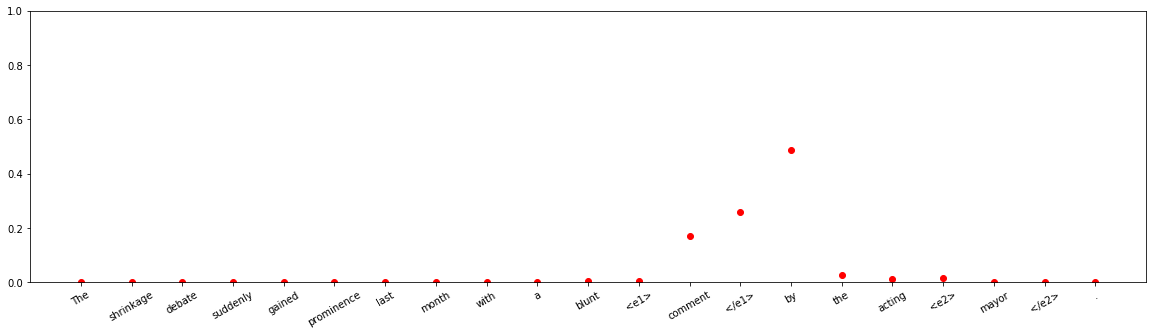


input sentence: She indicated to the deputy sheriff that a <e1> gun </e1> was in a <e2> box </e2> in her bedroom .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 6.078485e-06
Cause-Effect 	:	 1.737305e-08
Component-Whole 	:	 5.3239164e-06
Entity-Destination 	:	 0.80642253
Entity-Origin 	:	 1.4905177e-06
Product-Producer 	:	 4.1932527e-08
Member-Collection 	:	 9.2703864e-08
Message-Topic 	:	 5.6546116e-05
Content-Container 	:	 0.19350356
Instrument-Agency 	:	 4.3155933e-06



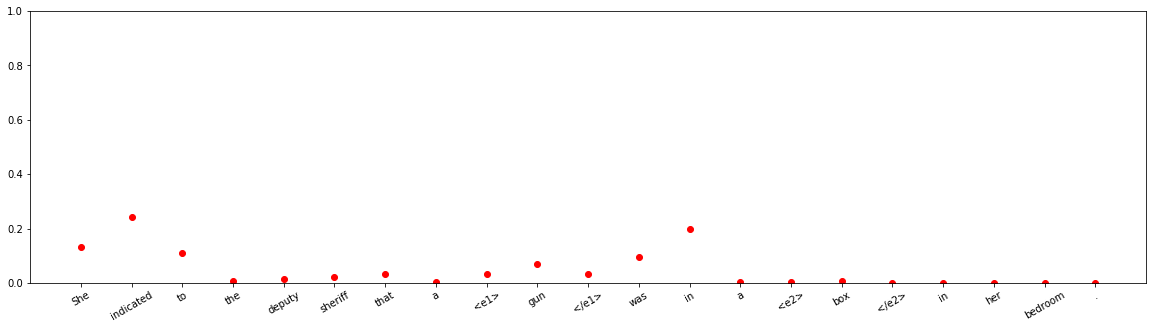







input sentence: This <e1> list </e1> has been prepared on the basis of <e2> records </e2> and information available to the secretariat .
answer label:    Entity-Origin
wrong label:    Message-Topic
Other 	:	 7.5933535e-06
Cause-Effect 	:	 1.1002429e-11
Component-Whole 	:	 4.922741e-08
Entity-Destination 	:	 1.3077489e-09
Entity-Origin 	:	 3.3268357e-08
Product-Producer 	:	 2.4521754e-08
Member-Collection 	:	 1.2343237e-07
Message-Topic 	:	 0.9999918
Content-Container 	:	 3.2344417e-07
Instrument-Agency 	:	 2.2317242e-10



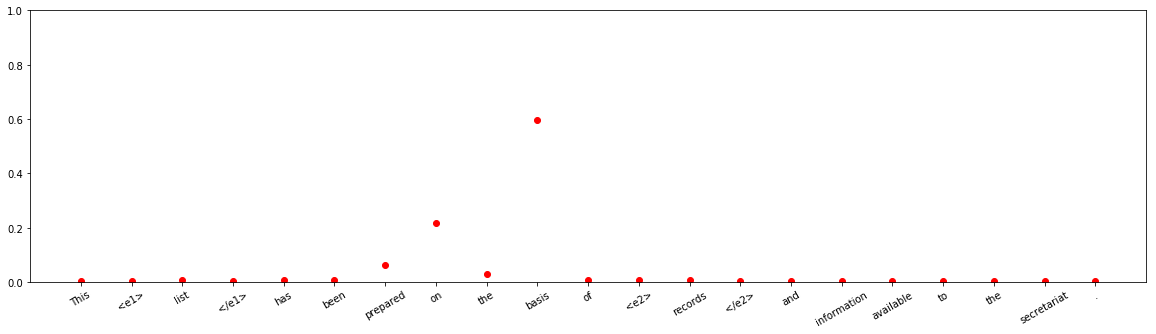




input sentence: He encourages <e1> students </e1> to read beyond the mandatory <e2> texts </e2> in order to prepare for his exam .
answer label:    Instrument-Agency
wrong label:    Message-Topic
Other 	:	 0.035200752
Cause-Effect 	:	 6.324513e-08
Component-Whole 	:	 1.6927133e-05
Entity-Destination 	:	 6.9994334e-05
Entity-Origin 	:	 3.5182822e-08
Product-Producer 	:	 0.00783745
Member-Collection 	:	 1.4926562e-07
Message-Topic 	:	 0.9554163
Content-Container 	:	 3.2698185e-08
Instrument-Agency 	:	 0.0014583613



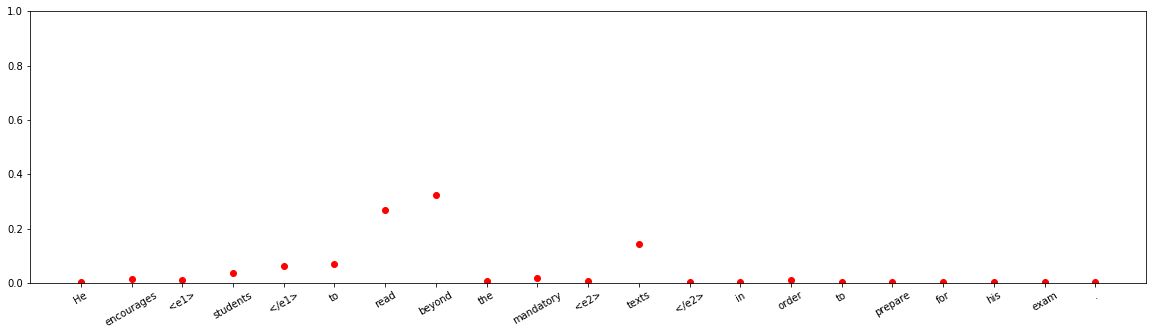


input sentence: The message <e1> body </e1> was comprised of the <e2> phrase </e2> `` hey , check this out ! `` .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 1.5117155e-06
Cause-Effect 	:	 4.3282715e-09
Component-Whole 	:	 0.99986947
Entity-Destination 	:	 4.882363e-08
Entity-Origin 	:	 5.9537097e-08
Product-Producer 	:	 4.1496128e-07
Member-Collection 	:	 0.00011187779
Message-Topic 	:	 5.454367e-10
Content-Container 	:	 1.6480177e-05
Instrument-Agency 	:	 2.5879723e-07



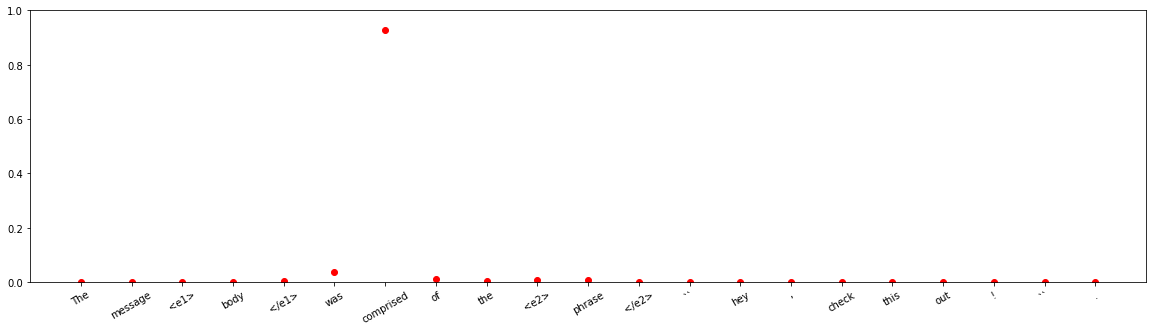



input sentence: The <e1> evidence </e1> arose from the <e2> results </e2> of several GWS studies in which our team has participated .
answer label:    Entity-Origin
wrong label:    Cause-Effect
Other 	:	 0.19806193
Cause-Effect 	:	 0.5796434
Component-Whole 	:	 2.94717e-09
Entity-Destination 	:	 1.7379816e-07
Entity-Origin 	:	 0.22225738
Product-Producer 	:	 3.881204e-07
Member-Collection 	:	 5.144102e-08
Message-Topic 	:	 3.6578676e-05
Content-Container 	:	 7.9642637e-10
Instrument-Agency 	:	 2.4552174e-08



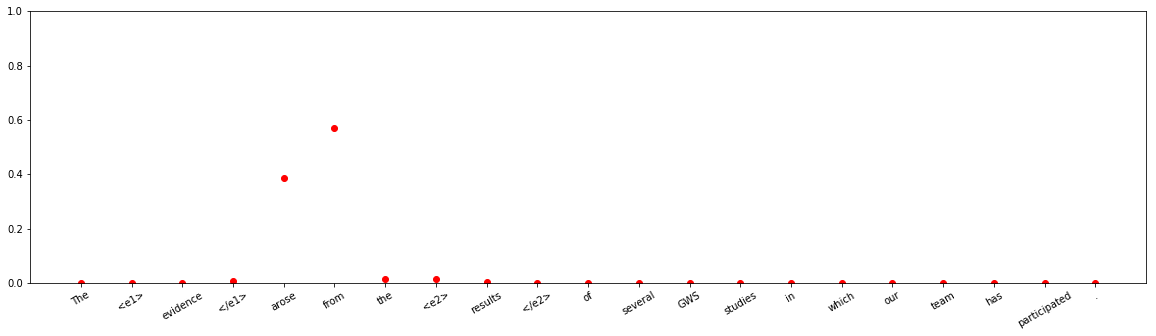


input sentence: There was weeping and wailing and gnashing of teeth in the <e1> camp </e1> of the <e2> outsiders </e2> now .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.99853253
Cause-Effect 	:	 6.121114e-09
Component-Whole 	:	 0.0010089187
Entity-Destination 	:	 1.4937068e-07
Entity-Origin 	:	 1.7017872e-08
Product-Producer 	:	 4.173777e-08
Member-Collection 	:	 0.00011160297
Message-Topic 	:	 0.0003467917
Content-Container 	:	 1.3273948e-08
Instrument-Agency 	:	 6.3189973e-09



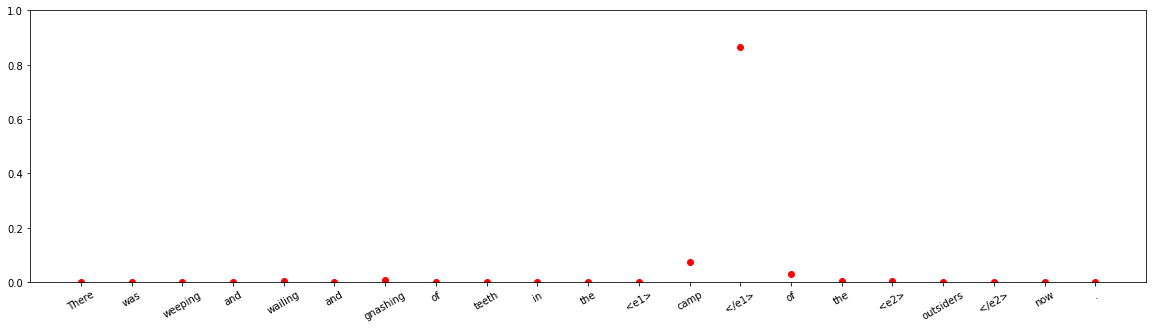


input sentence: Patty the Milkmaid was going to market carrying her <e1> milk </e1> in a <e2> pail </e2> on her head .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 1.8804056e-06
Cause-Effect 	:	 9.9977076e-09
Component-Whole 	:	 5.590211e-07
Entity-Destination 	:	 0.9985399
Entity-Origin 	:	 2.1153664e-06
Product-Producer 	:	 8.68804e-07
Member-Collection 	:	 2.1615167e-09
Message-Topic 	:	 9.3026745e-07
Content-Container 	:	 0.0014505285
Instrument-Agency 	:	 3.140219e-06



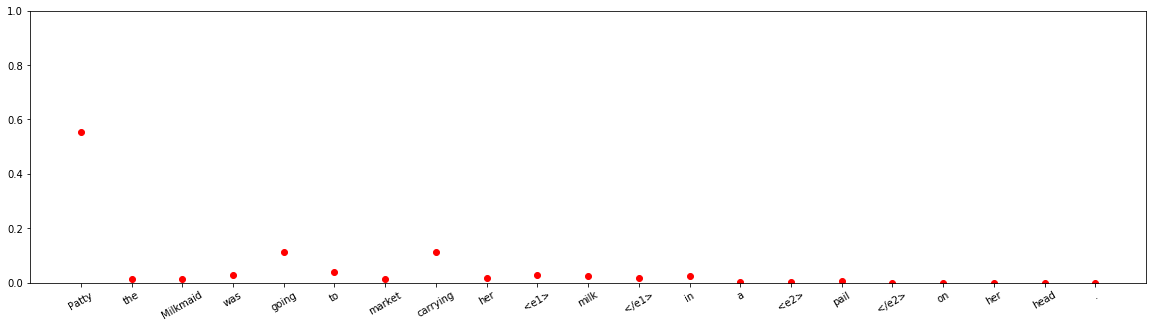









input sentence: The <e1> weather report </e1> informed me about the high wind <e2> storm conditions </e2> that was already in place .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.9932475
Cause-Effect 	:	 0.0001926386
Component-Whole 	:	 1.4522227e-07
Entity-Destination 	:	 1.8337596e-08
Entity-Origin 	:	 2.6642589e-05
Product-Producer 	:	 3.134935e-07
Member-Collection 	:	 2.3808683e-08
Message-Topic 	:	 0.006522386
Content-Container 	:	 2.3634747e-09
Instrument-Agency 	:	 1.033301e-05



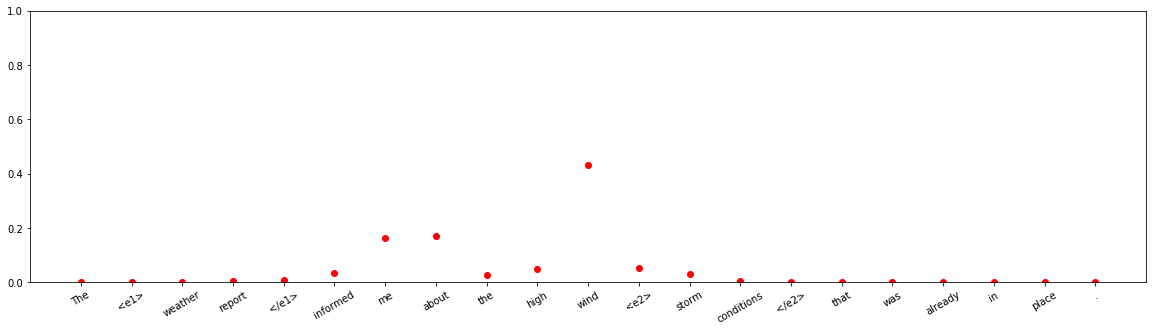






input sentence: She knew each favorite <e1> clump </e1> of concealing <e2> reeds </e2> along the river that the buffalo loved best .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 7.052177e-05
Cause-Effect 	:	 2.687593e-07
Component-Whole 	:	 0.99572927
Entity-Destination 	:	 9.592125e-06
Entity-Origin 	:	 5.4921147e-05
Product-Producer 	:	 7.809294e-09
Member-Collection 	:	 0.003994254
Message-Topic 	:	 4.839813e-11
Content-Container 	:	 0.00013685324
Instrument-Agency 	:	 4.2216684e-06



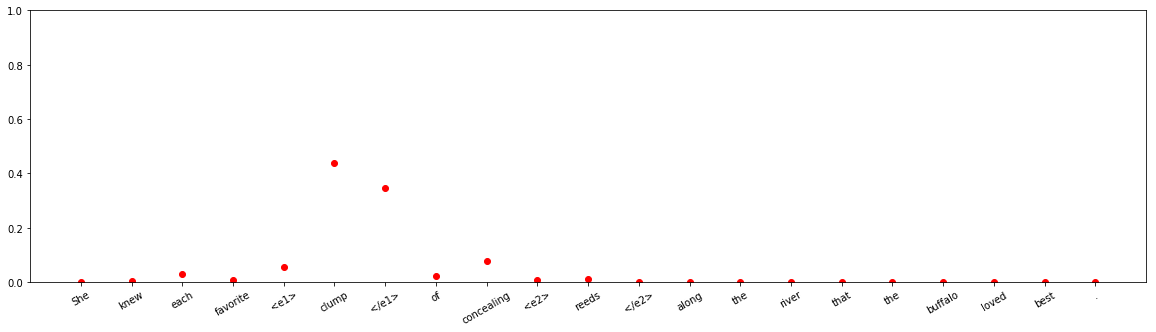










input sentence: The NTSB determined that the <e1> aircraft </e1> departed from controlled <e2> flight </e2> and crashed into the Atlantic Ocean .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 0.0001637366
Cause-Effect 	:	 3.8693534e-10
Component-Whole 	:	 2.2032037e-13
Entity-Destination 	:	 5.0726005e-08
Entity-Origin 	:	 0.9998362
Product-Producer 	:	 2.0284394e-10
Member-Collection 	:	 1.7952058e-11
Message-Topic 	:	 5.947785e-14
Content-Container 	:	 3.9068867e-13
Instrument-Agency 	:	 1.312536e-08



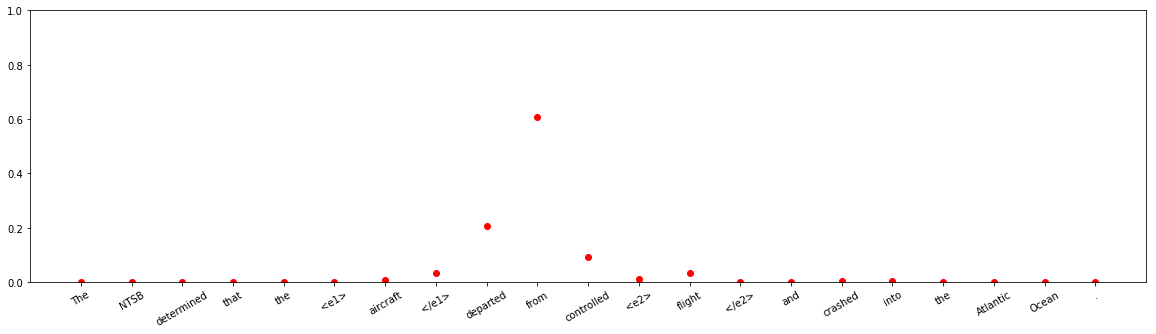


input sentence: The feature analysis storage stores the <e1> plurality </e1> of predetermined <e2> features </e2> extracted from the retrieved textual opinions .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.2742028
Cause-Effect 	:	 9.965381e-06
Component-Whole 	:	 0.34939137
Entity-Destination 	:	 1.8935512e-05
Entity-Origin 	:	 7.2134444e-06
Product-Producer 	:	 0.0002477447
Member-Collection 	:	 0.35848886
Message-Topic 	:	 0.0018319006
Content-Container 	:	 0.0003857527
Instrument-Agency 	:	 0.015415469



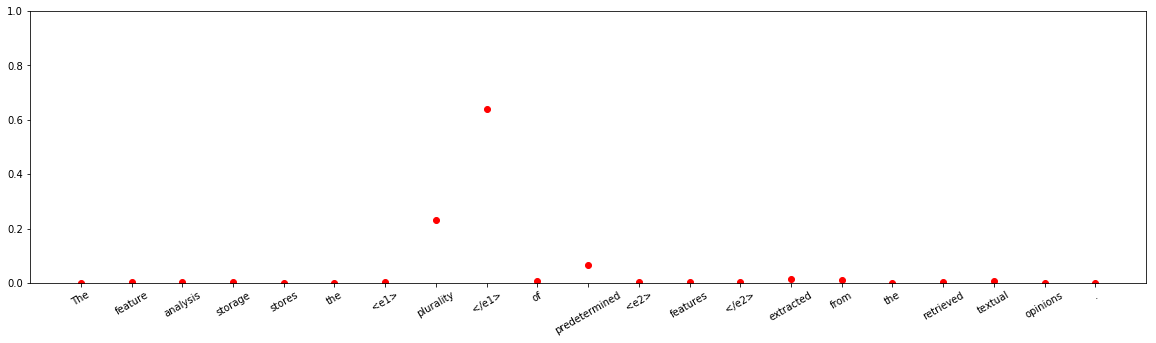







input sentence: The <e1> abridger </e1> did his job carefully , and with a fairly good <e2> eye </e2> for consequential alterations .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.005116147
Cause-Effect 	:	 2.539735e-08
Component-Whole 	:	 9.275888e-08
Entity-Destination 	:	 7.1348046e-07
Entity-Origin 	:	 3.290368e-08
Product-Producer 	:	 0.0051691066
Member-Collection 	:	 1.5551908e-08
Message-Topic 	:	 5.3800534e-07
Content-Container 	:	 2.936521e-09
Instrument-Agency 	:	 0.9897133



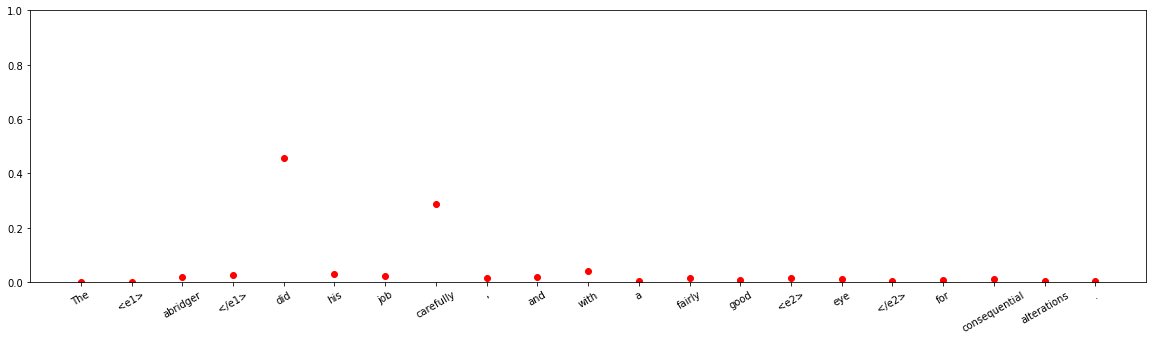



input sentence: This primary school <e1> teacher </e1> has completed a whole <e2> book </e2> with his class in just one week .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 2.665013e-07
Cause-Effect 	:	 3.3517213e-11
Component-Whole 	:	 2.596925e-11
Entity-Destination 	:	 3.3775747e-09
Entity-Origin 	:	 9.738238e-10
Product-Producer 	:	 0.9999994
Member-Collection 	:	 1.6758385e-10
Message-Topic 	:	 2.0536248e-10
Content-Container 	:	 7.0459005e-10
Instrument-Agency 	:	 3.192217e-07



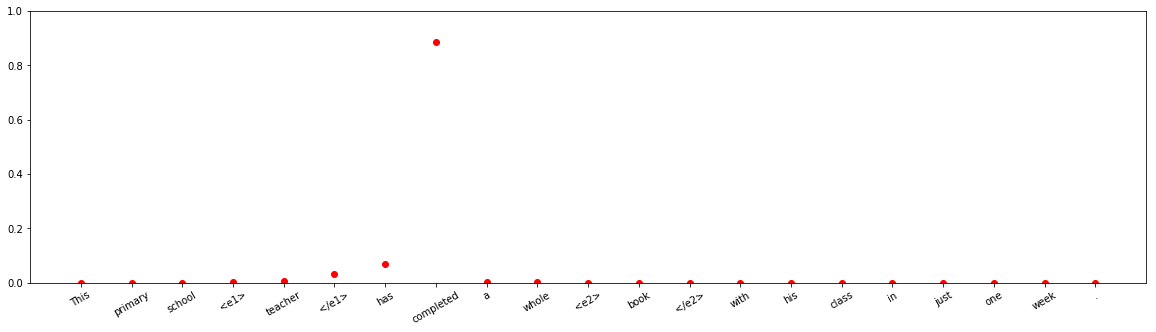


input sentence: A French <e1> initiative </e1> aimed at tackling childhood <e2> obesity </e2> is adopted in a town in North Lanarkshire .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.73444915
Cause-Effect 	:	 1.986051e-05
Component-Whole 	:	 7.965137e-08
Entity-Destination 	:	 2.9981506e-10
Entity-Origin 	:	 1.8127237e-08
Product-Producer 	:	 1.6945782e-07
Member-Collection 	:	 5.728629e-07
Message-Topic 	:	 0.26552993
Content-Container 	:	 6.602229e-10
Instrument-Agency 	:	 1.7380692e-07



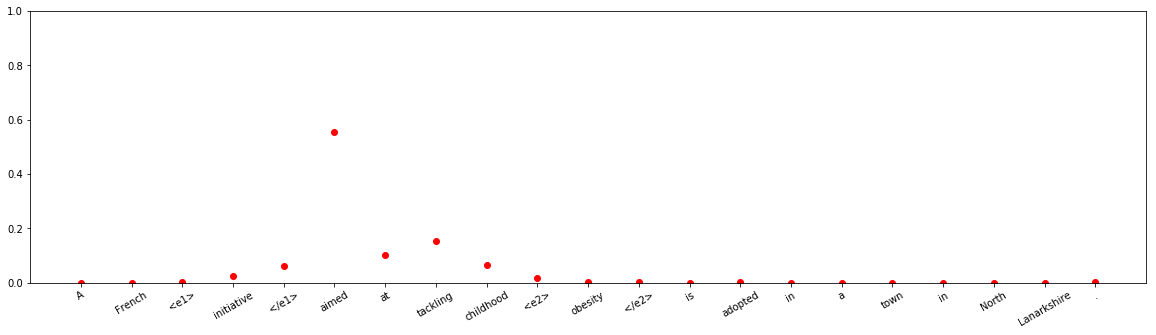


input sentence: An icon is a small <e1> picture </e1> representing a <e2> file </e2> , folder or program on your computer .
answer label:    Other
wrong label:    Content-Container
Other 	:	 4.6948065e-07
Cause-Effect 	:	 2.1886224e-07
Component-Whole 	:	 4.559961e-06
Entity-Destination 	:	 0.013344205
Entity-Origin 	:	 0.00013454573
Product-Producer 	:	 0.0023500721
Member-Collection 	:	 3.782138e-05
Message-Topic 	:	 0.00012406085
Content-Container 	:	 0.98208296
Instrument-Agency 	:	 0.001921081



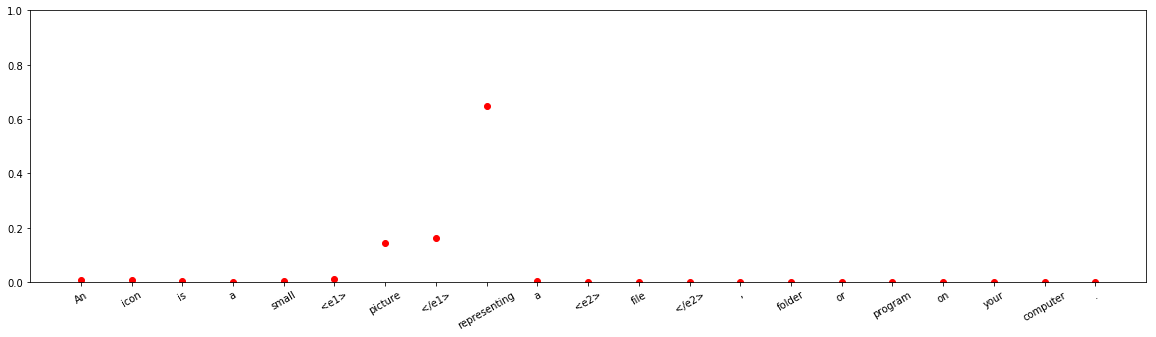






input sentence: These <e1> tests </e1> work by using a <e2> substance </e2> that changes color once it is bound to hCG .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.56373787
Cause-Effect 	:	 3.748778e-08
Component-Whole 	:	 1.3811477e-06
Entity-Destination 	:	 4.200539e-08
Entity-Origin 	:	 8.536452e-09
Product-Producer 	:	 3.824733e-06
Member-Collection 	:	 1.9878703e-10
Message-Topic 	:	 2.722118e-06
Content-Container 	:	 2.6991986e-10
Instrument-Agency 	:	 0.43625396



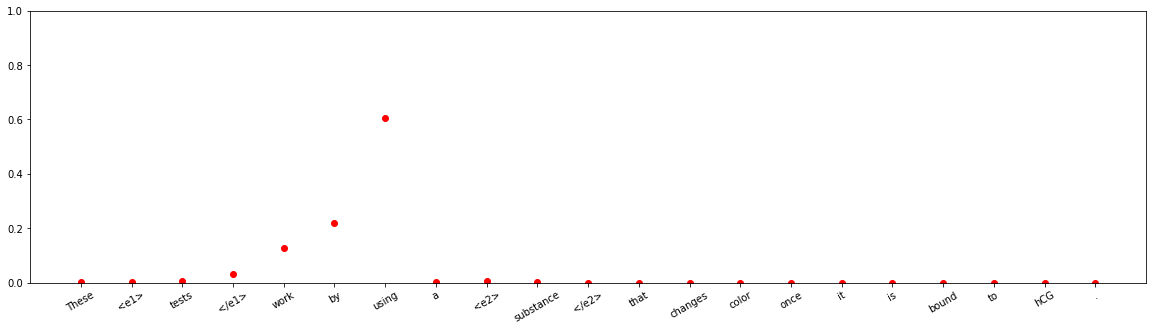





input sentence: The <e1> body </e1> is built up of many different things such as <e2> muscle </e2> and fat and water .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.011594194
Cause-Effect 	:	 6.7513365e-06
Component-Whole 	:	 0.9881435
Entity-Destination 	:	 5.051122e-07
Entity-Origin 	:	 1.2783642e-07
Product-Producer 	:	 0.0001062226
Member-Collection 	:	 5.1909706e-07
Message-Topic 	:	 1.6874897e-06
Content-Container 	:	 2.8296324e-06
Instrument-Agency 	:	 0.00014387688



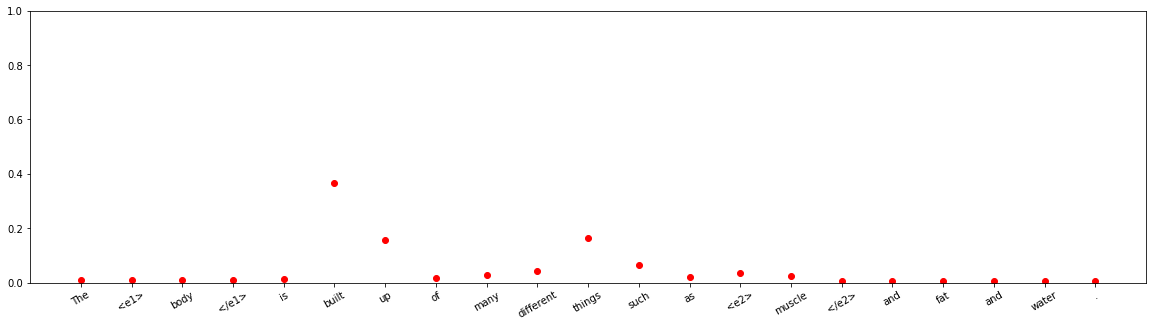




input sentence: <e1> Lasers </e1> work by using various soft pulsing light <e2> wavelengths </e2> and intensities to help reshape scar tissue .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.5073144
Cause-Effect 	:	 0.48371312
Component-Whole 	:	 0.0005509185
Entity-Destination 	:	 4.669163e-08
Entity-Origin 	:	 2.2833465e-06
Product-Producer 	:	 1.4261616e-08
Member-Collection 	:	 5.112027e-08
Message-Topic 	:	 4.4078433e-08
Content-Container 	:	 6.987342e-11
Instrument-Agency 	:	 0.008419092



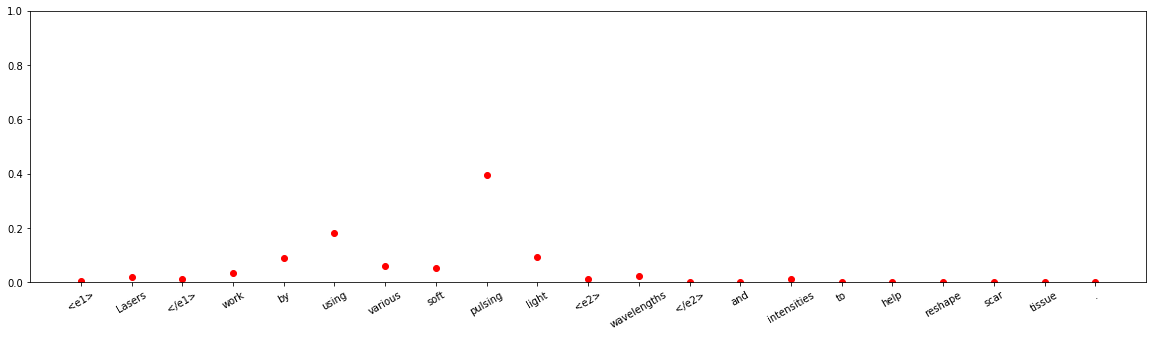


input sentence: Relaxation involves concentration and slow , deep breathing to release <e1> tension </e1> from <e2> muscles </e2> and relieve pain .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 5.950082e-07
Cause-Effect 	:	 0.9999994
Component-Whole 	:	 1.8508183e-09
Entity-Destination 	:	 7.2976553e-13
Entity-Origin 	:	 4.766904e-10
Product-Producer 	:	 1.8194488e-14
Member-Collection 	:	 6.440382e-12
Message-Topic 	:	 1.5452386e-11
Content-Container 	:	 4.890504e-14
Instrument-Agency 	:	 1.1025569e-09



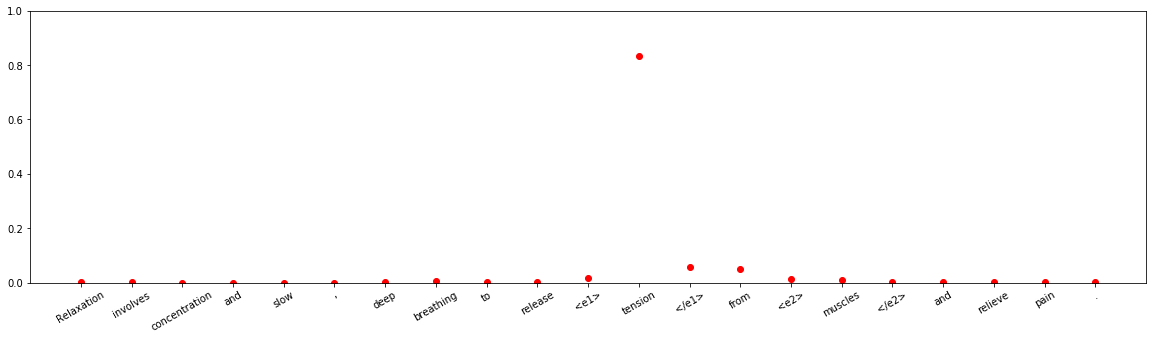



input sentence: A <e1> scheme </e1> establishing <e2> access </e2> to the East Sussex countryside for disabled people draws to a close .
answer label:    Cause-Effect
wrong label:    Message-Topic
Other 	:	 0.026998853
Cause-Effect 	:	 3.5949215e-06
Component-Whole 	:	 0.0006808477
Entity-Destination 	:	 6.3257676e-06
Entity-Origin 	:	 9.638061e-09
Product-Producer 	:	 2.2068362e-07
Member-Collection 	:	 8.478426e-06
Message-Topic 	:	 0.9721552
Content-Container 	:	 4.9435806e-07
Instrument-Agency 	:	 0.00014607018



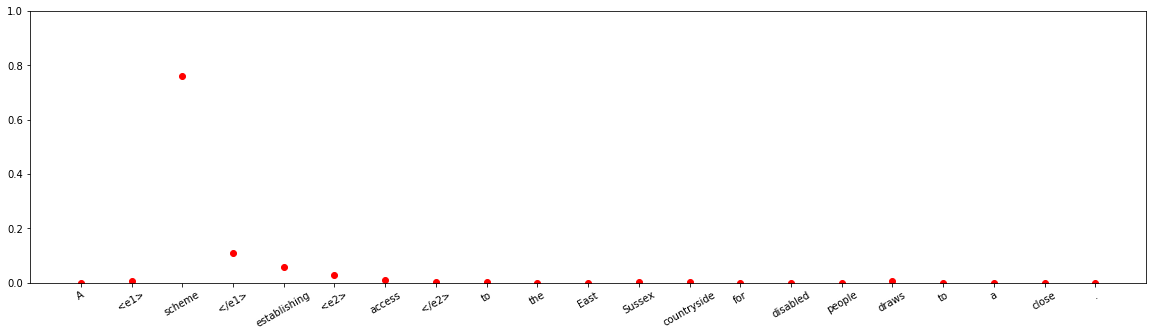


input sentence: The plasma processing <e1> apparatus </e1> produces a plasma in a <e2> vessel </e2> and processes samples using the plasma .
answer label:    Component-Whole
wrong label:    Product-Producer
Other 	:	 1.2139017e-06
Cause-Effect 	:	 0.024223538
Component-Whole 	:	 1.3493457e-07
Entity-Destination 	:	 9.331357e-07
Entity-Origin 	:	 1.1575711e-06
Product-Producer 	:	 0.95661473
Member-Collection 	:	 5.787416e-07
Message-Topic 	:	 1.3534033e-08
Content-Container 	:	 0.0001299731
Instrument-Agency 	:	 0.019027673



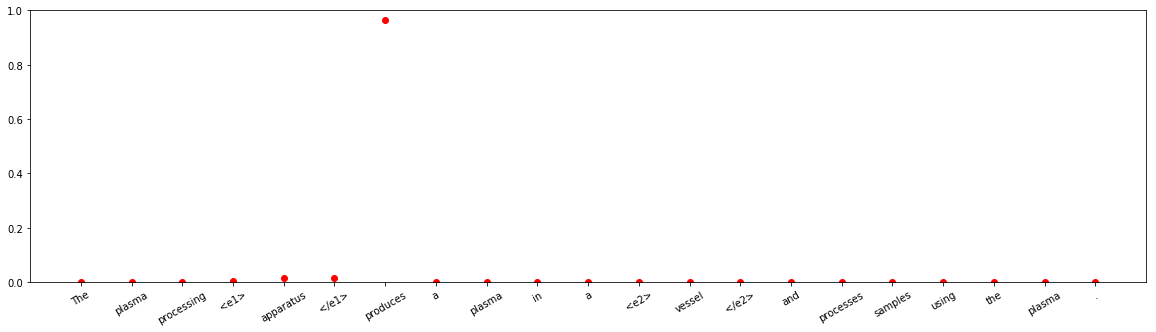


input sentence: Those models were chain driven and the <e1> mechanism </e1> was enclosed in a very visible oil <e2> bath </e2> .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.000777545
Cause-Effect 	:	 9.1992945e-08
Component-Whole 	:	 0.65399504
Entity-Destination 	:	 0.00071728416
Entity-Origin 	:	 3.3645854e-08
Product-Producer 	:	 1.8261302e-09
Member-Collection 	:	 2.9583498e-07
Message-Topic 	:	 0.00030597672
Content-Container 	:	 0.34420317
Instrument-Agency 	:	 5.404916e-07



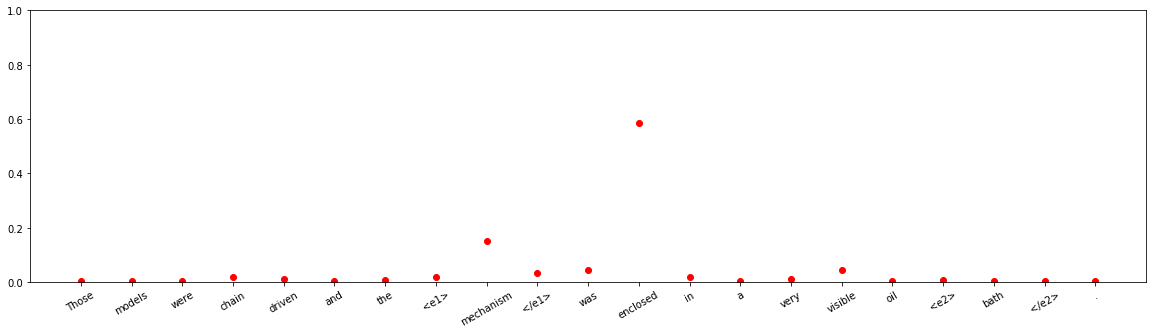





input sentence: In 1993 the <e1> party </e1> won the governorship with a <e2> pledge </e2> to cut income taxes 30 % .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9963567
Cause-Effect 	:	 1.0472786e-07
Component-Whole 	:	 3.0345912e-09
Entity-Destination 	:	 2.6948038e-07
Entity-Origin 	:	 2.678314e-09
Product-Producer 	:	 0.0036389641
Member-Collection 	:	 1.5468389e-07
Message-Topic 	:	 9.784895e-07
Content-Container 	:	 9.436745e-10
Instrument-Agency 	:	 2.9785904e-06



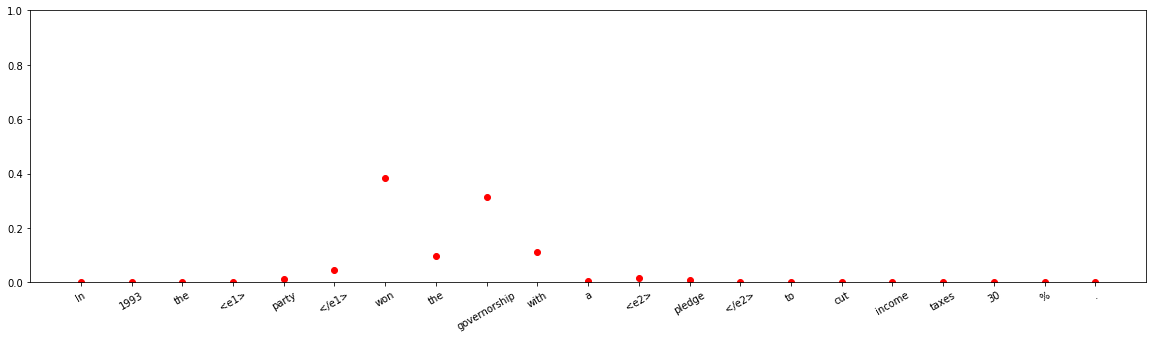


input sentence: The <e1> song </e1> is featured in the 1990 film Riff-Raff , performed by the main female <e2> character </e2> .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.4130979
Cause-Effect 	:	 3.452979e-06
Component-Whole 	:	 0.0011668617
Entity-Destination 	:	 1.6964417e-07
Entity-Origin 	:	 4.2777792e-05
Product-Producer 	:	 0.111758485
Member-Collection 	:	 2.6057369e-06
Message-Topic 	:	 0.4735468
Content-Container 	:	 7.989345e-07
Instrument-Agency 	:	 0.00038017237



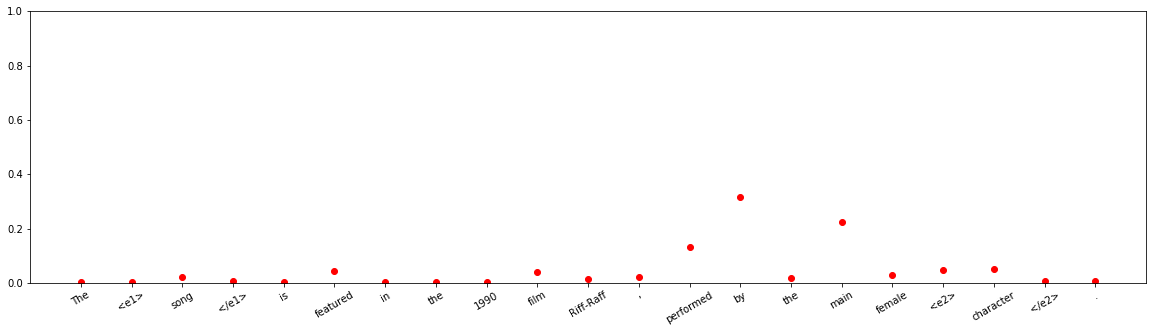











input sentence: The 400 V <e1> power supply </e1> ( unstabilized ) was derived from a conventional <e2> power-pack </e2> with n-filter .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 6.528021e-08
Cause-Effect 	:	 2.1078169e-08
Component-Whole 	:	 5.2051256e-13
Entity-Destination 	:	 1.0201684e-08
Entity-Origin 	:	 0.9999999
Product-Producer 	:	 7.589779e-10
Member-Collection 	:	 2.969704e-12
Message-Topic 	:	 1.2390445e-14
Content-Container 	:	 5.2135567e-11
Instrument-Agency 	:	 1.5957227e-08



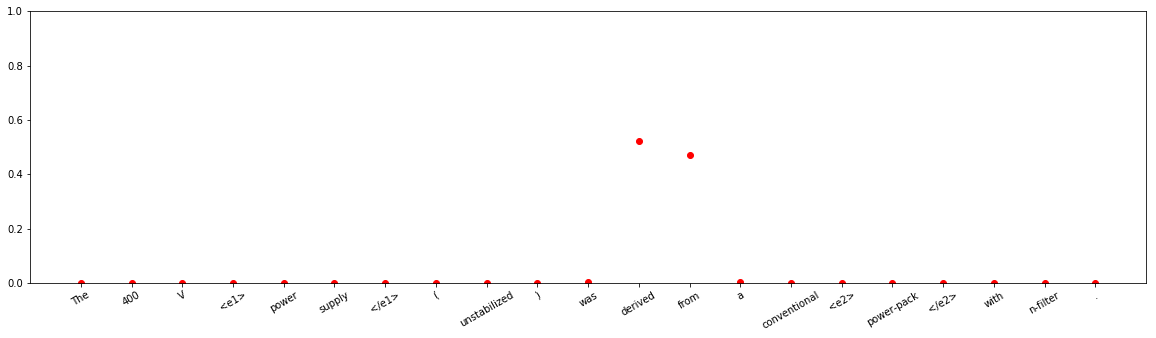


input sentence: The coal <e1> industry </e1> has been recycling the material into <e2> backfill </e2> and building materials such as cement .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.021435814
Cause-Effect 	:	 3.1586535e-07
Component-Whole 	:	 3.1623912e-07
Entity-Destination 	:	 0.21415012
Entity-Origin 	:	 3.7473706e-06
Product-Producer 	:	 0.7583167
Member-Collection 	:	 5.077181e-09
Message-Topic 	:	 0.005939004
Content-Container 	:	 7.7951995e-07
Instrument-Agency 	:	 0.00015309625



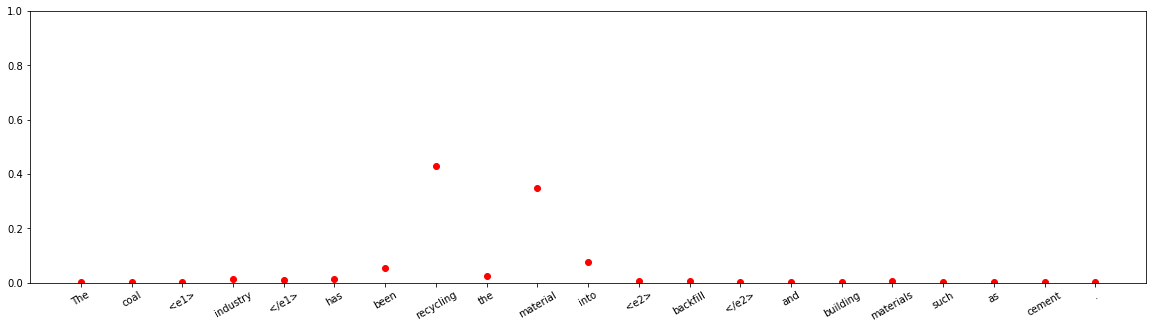



input sentence: This is a collection of many of the best <e1> images </e1> from NASA 's planetary exploration <e2> program </e2> .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.8645447
Cause-Effect 	:	 0.00016514692
Component-Whole 	:	 3.881769e-06
Entity-Destination 	:	 0.04960635
Entity-Origin 	:	 0.004684103
Product-Producer 	:	 0.00019626536
Member-Collection 	:	 1.2708944e-07
Message-Topic 	:	 0.08058726
Content-Container 	:	 2.2627768e-07
Instrument-Agency 	:	 0.00021211678



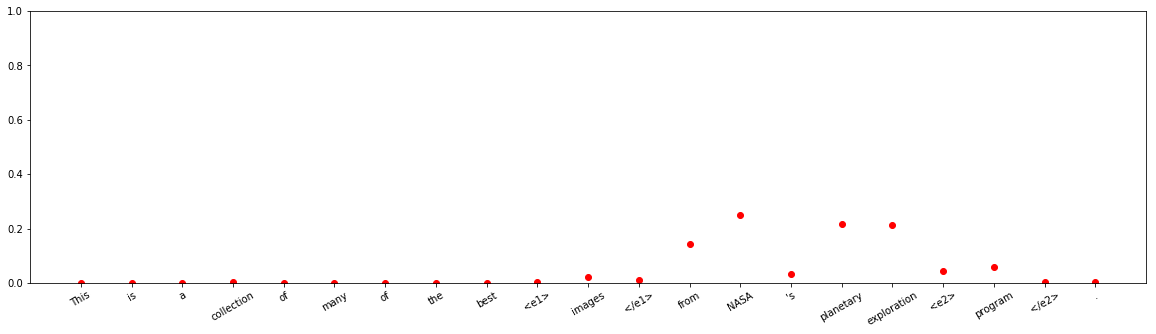


input sentence: Then the <e1> driver </e1> turned the car into a dark and narrow <e2> street </e2> and reduced his speed .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.9654426
Cause-Effect 	:	 2.5016735e-09
Component-Whole 	:	 3.2983536e-07
Entity-Destination 	:	 0.015656136
Entity-Origin 	:	 1.9649632e-07
Product-Producer 	:	 0.0014769183
Member-Collection 	:	 1.8931064e-07
Message-Topic 	:	 1.7749068e-07
Content-Container 	:	 4.5909725e-09
Instrument-Agency 	:	 0.01742327



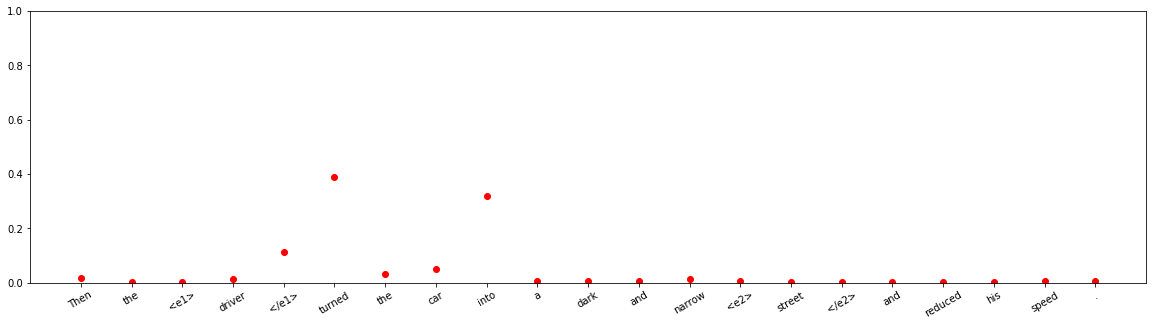







input sentence: Wilderness tour guides often maintain a <e1> pace </e1> of <e2> asses </e2> to carry the equipment necessary for camping .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.8810184
Cause-Effect 	:	 1.7697588e-06
Component-Whole 	:	 3.1037612e-06
Entity-Destination 	:	 2.9892817e-08
Entity-Origin 	:	 2.5367479e-08
Product-Producer 	:	 2.2168597e-06
Member-Collection 	:	 0.11897005
Message-Topic 	:	 1.4733117e-06
Content-Container 	:	 1.2354442e-09
Instrument-Agency 	:	 2.9659088e-06



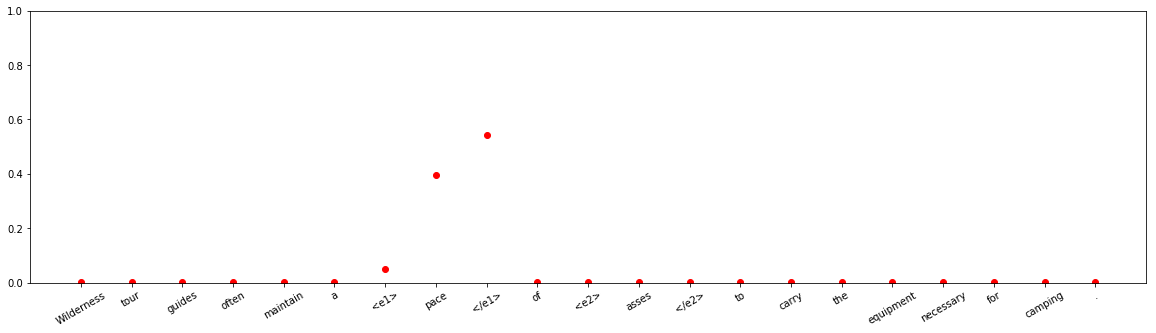


input sentence: The major phytochemical <e1> constitutes </e1> of the <e2> plant </e2> are elephantopin , triterpenes , stigmasterol epifriedelinol and lupeol .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.3620817
Cause-Effect 	:	 0.00021406748
Component-Whole 	:	 0.62480867
Entity-Destination 	:	 2.3293926e-05
Entity-Origin 	:	 7.5847197e-06
Product-Producer 	:	 4.6524383e-05
Member-Collection 	:	 0.0013184537
Message-Topic 	:	 0.0003421353
Content-Container 	:	 1.669747e-05
Instrument-Agency 	:	 0.011140914



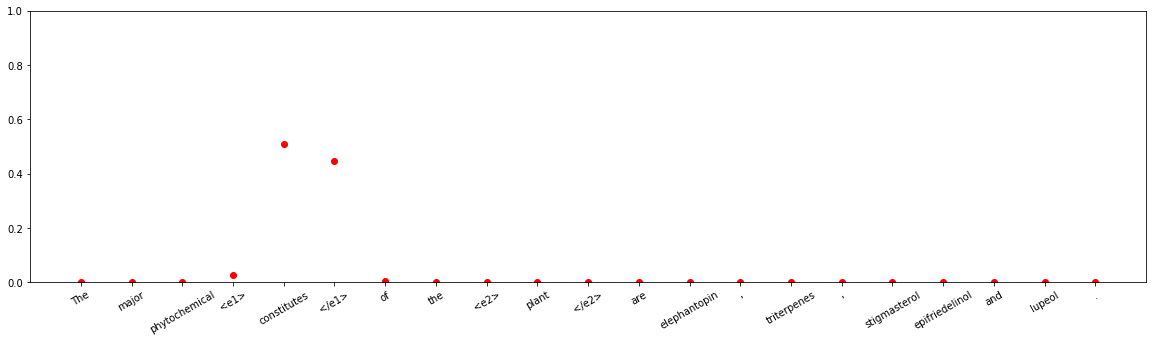


input sentence: And so this <e1> book </e1> involves the reader in a true educational <e2> process </e2> which is also fun .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.01257425
Cause-Effect 	:	 9.1699195e-07
Component-Whole 	:	 0.00019346594
Entity-Destination 	:	 1.1478217e-08
Entity-Origin 	:	 2.7780942e-09
Product-Producer 	:	 7.023114e-07
Member-Collection 	:	 2.1031813e-08
Message-Topic 	:	 0.9872034
Content-Container 	:	 1.3590605e-07
Instrument-Agency 	:	 2.7046635e-05



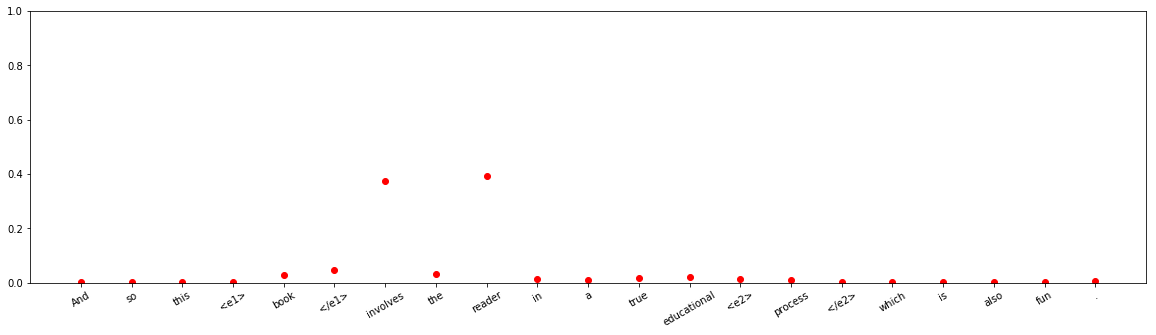



input sentence: The <e1> foundry </e1> 's main business is the manufacture of church <e2> bells </e2> and their fittings and accessories .
answer label:    Product-Producer
wrong label:    Component-Whole
Other 	:	 0.0008923463
Cause-Effect 	:	 4.9747476e-05
Component-Whole 	:	 0.9633386
Entity-Destination 	:	 3.0969665e-09
Entity-Origin 	:	 1.1626037e-05
Product-Producer 	:	 0.012629145
Member-Collection 	:	 0.00015428511
Message-Topic 	:	 3.0320464e-06
Content-Container 	:	 8.155488e-06
Instrument-Agency 	:	 0.022913067



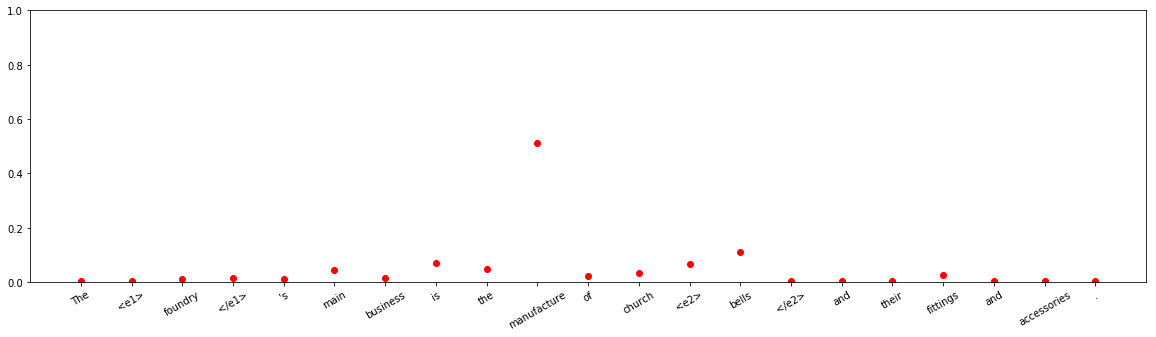

















input sentence: In 2006 we reported on a robotic <e1> hand </e1> that formed rock , paper , scissors <e2> gestures </e2> by reading a human subject 's mind via an MRI scanner .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 4.2848415e-06
Cause-Effect 	:	 5.076411e-07
Component-Whole 	:	 0.0011864232
Entity-Destination 	:	 2.922812e-09
Entity-Origin 	:	 2.5833325e-08
Product-Producer 	:	 0.15804864
Member-Collection 	:	 7.92251e-09
Message-Topic 	:	 2.4307878e-05
Content-Container 	:	 2.5504553e-07
Instrument-Agency 	:	 0.84073555



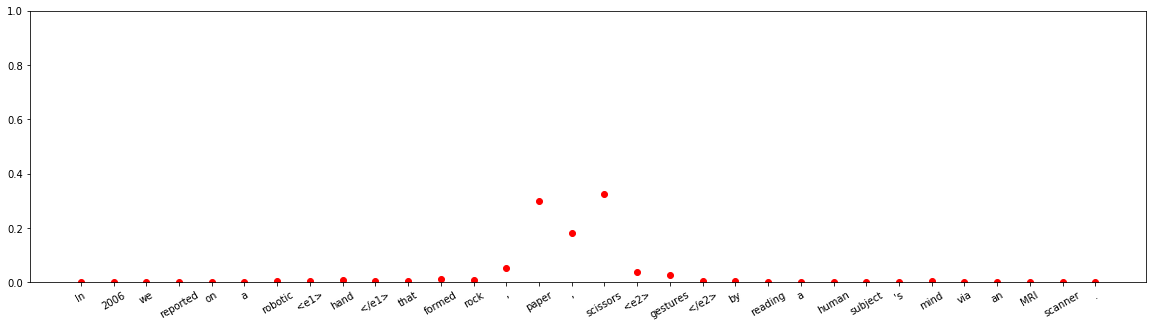


input sentence: We dissect the body of people who make up a <e1> dance </e1> <e2> company </e2> , offering an insight into the roles and responsibilities involved in running a successful company .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 1.5794065e-05
Cause-Effect 	:	 8.301915e-09
Component-Whole 	:	 6.795123e-09
Entity-Destination 	:	 8.6709974e-08
Entity-Origin 	:	 7.8362605e-10
Product-Producer 	:	 0.999969
Member-Collection 	:	 1.1662022e-08
Message-Topic 	:	 3.2715107e-07
Content-Container 	:	 2.3152369e-10
Instrument-Agency 	:	 1.4757392e-05



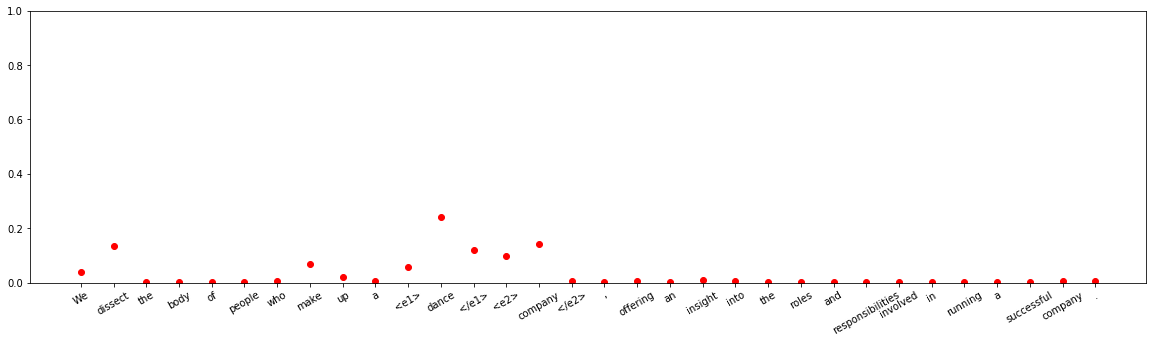




input sentence: In March 1995 the <e1> defendant </e1> swore an <e2> affidavit </e2> in which he referred to sales of parts of the farm land and an offer for the Wareham property .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.78529286
Cause-Effect 	:	 4.6168716e-07
Component-Whole 	:	 2.998275e-10
Entity-Destination 	:	 1.0810031e-07
Entity-Origin 	:	 6.704398e-06
Product-Producer 	:	 0.21426882
Member-Collection 	:	 2.4558858e-06
Message-Topic 	:	 2.2935132e-05
Content-Container 	:	 2.1151926e-08
Instrument-Agency 	:	 0.00040565137



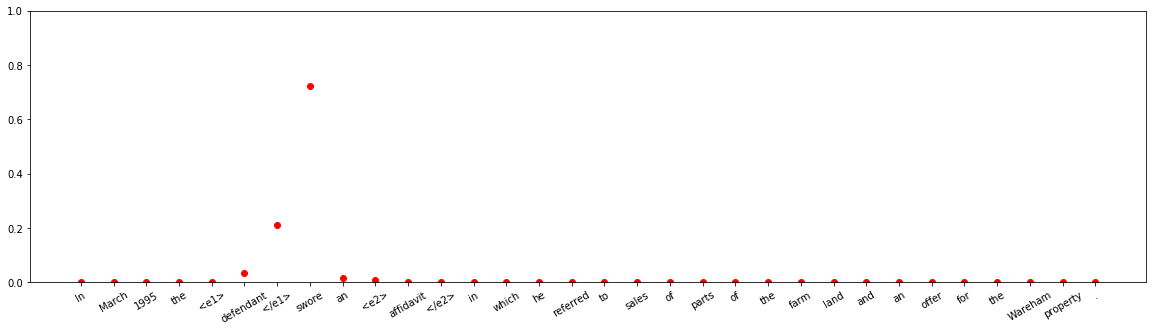





input sentence: There are people who have learnt about <e1> benchmarking </e1> from a range of <e2> sources </e2> , most notably practitioner-oriented literature , networking , and reflections on their own practice .
answer label:    Message-Topic
wrong label:    Entity-Origin
Other 	:	 2.3043256e-06
Cause-Effect 	:	 1.9413946e-07
Component-Whole 	:	 7.0628786e-10
Entity-Destination 	:	 9.2254626e-10
Entity-Origin 	:	 0.9999857
Product-Producer 	:	 3.3452209e-06
Member-Collection 	:	 7.665374e-06
Message-Topic 	:	 6.5493396e-07
Content-Container 	:	 1.0817563e-07
Instrument-Agency 	:	 1.0328098e-07



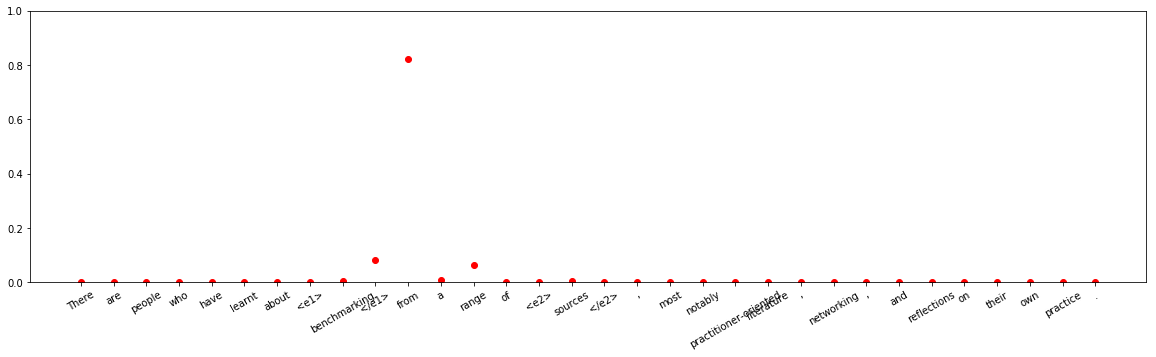






input sentence: As I travelled the world and had facials in every corner , I have finally found a <e1> therapist </e1> with such a perfect <e2> way </e2> of touching my face .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.9999994
Cause-Effect 	:	 2.5417946e-11
Component-Whole 	:	 1.4115965e-09
Entity-Destination 	:	 4.0198494e-11
Entity-Origin 	:	 1.1979252e-11
Product-Producer 	:	 5.5685248e-11
Member-Collection 	:	 1.09647055e-10
Message-Topic 	:	 1.7312602e-09
Content-Container 	:	 2.0919062e-13
Instrument-Agency 	:	 6.378224e-07



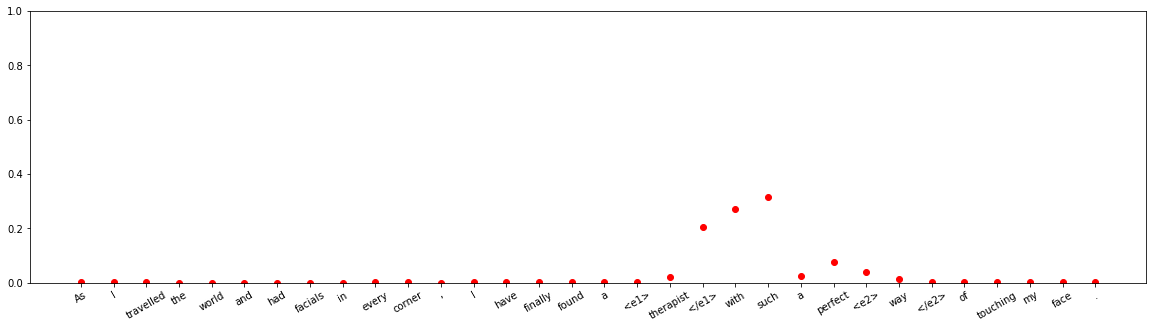









input sentence: Before the Council , Ireland had such a <e1> superfluity </e1> of Catholic <e2> priests </e2> that it exported many of them to Glasgow , England , and the United States .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.008160958
Cause-Effect 	:	 2.4636412e-08
Component-Whole 	:	 2.957908e-09
Entity-Destination 	:	 5.859901e-10
Entity-Origin 	:	 4.0659407e-07
Product-Producer 	:	 2.5479824e-07
Member-Collection 	:	 0.9918384
Message-Topic 	:	 3.961216e-08
Content-Container 	:	 1.6909967e-09
Instrument-Agency 	:	 3.5809242e-10



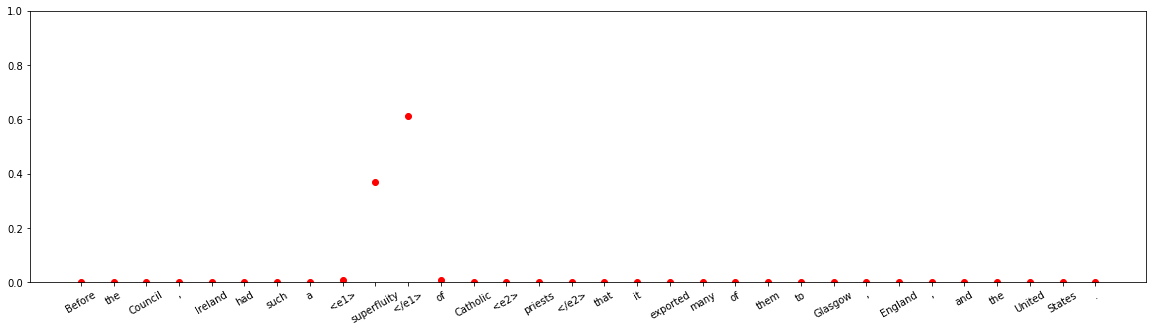








input sentence: The child 's <e1> body </e1> was abandoned placed in a <e2> laundry bag </e2> that was sealed in a plastic garbage bag before it was left behind in the woods .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 3.485634e-07
Cause-Effect 	:	 1.4111471e-12
Component-Whole 	:	 2.717453e-09
Entity-Destination 	:	 0.9973514
Entity-Origin 	:	 1.211457e-06
Product-Producer 	:	 1.0135296e-10
Member-Collection 	:	 4.3300342e-11
Message-Topic 	:	 1.0498644e-08
Content-Container 	:	 0.0026470993
Instrument-Agency 	:	 1.407278e-10



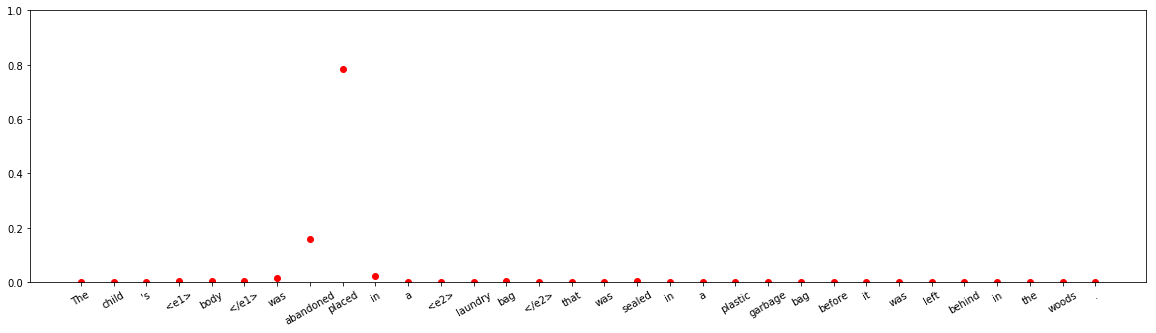



input sentence: The word `` song '' is used to describe the pattern of regular and predictable <e1> sounds </e1> made by some <e2> species </e2> of whales , notably the humpback whale .
answer label:    Cause-Effect
wrong label:    Product-Producer
Other 	:	 0.3330593
Cause-Effect 	:	 0.12327373
Component-Whole 	:	 1.386564e-07
Entity-Destination 	:	 1.9353804e-07
Entity-Origin 	:	 8.440687e-06
Product-Producer 	:	 0.5375197
Member-Collection 	:	 0.00023489079
Message-Topic 	:	 0.0058690393
Content-Container 	:	 8.890307e-08
Instrument-Agency 	:	 3.4544035e-05



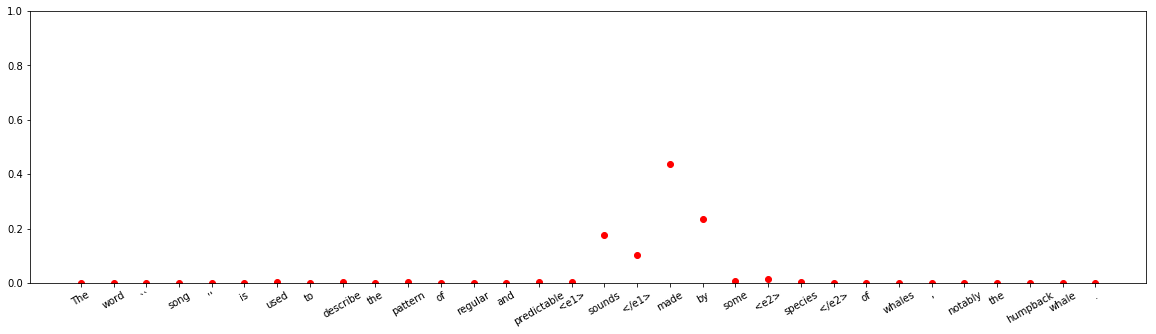



input sentence: A <e1> calendar </e1> of <e2> saints </e2> forms a way of organising a liturgical year on the finely-granulated level of days by assigning each day to association with a saint .
answer label:    Message-Topic
wrong label:    Member-Collection
Other 	:	 0.07595586
Cause-Effect 	:	 1.8601165e-07
Component-Whole 	:	 1.7275292e-05
Entity-Destination 	:	 2.2339466e-06
Entity-Origin 	:	 1.1386014e-06
Product-Producer 	:	 9.4619776e-07
Member-Collection 	:	 0.88274693
Message-Topic 	:	 0.04124003
Content-Container 	:	 3.526173e-05
Instrument-Agency 	:	 7.301667e-08



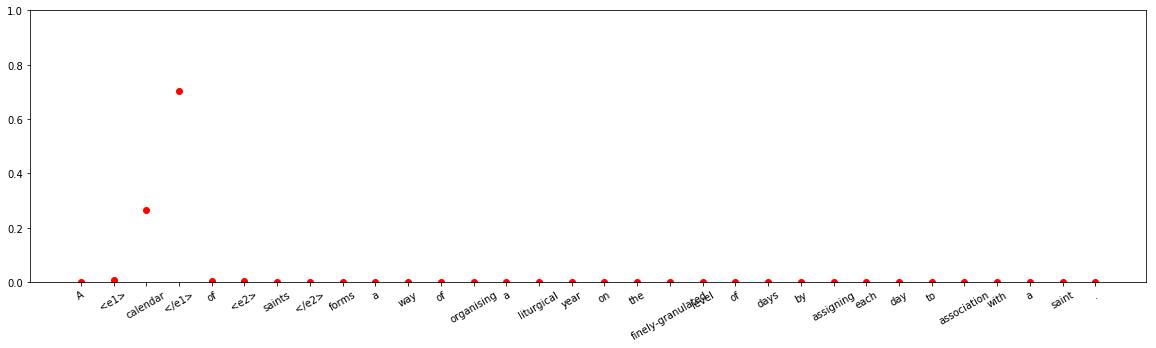







input sentence: Adam Smith 's first <e1> measure </e1> of fame was gained from a series of public <e2> lectures </e2> on rhetoric and belles lettres delivered in Edinburgh from 1748 to 1751 .
answer label:    Cause-Effect
wrong label:    Entity-Origin
Other 	:	 8.294954e-07
Cause-Effect 	:	 5.043697e-09
Component-Whole 	:	 1.5667115e-12
Entity-Destination 	:	 5.393495e-10
Entity-Origin 	:	 0.9999989
Product-Producer 	:	 1.8750951e-07
Member-Collection 	:	 1.5370127e-08
Message-Topic 	:	 2.1359196e-10
Content-Container 	:	 2.0369129e-09
Instrument-Agency 	:	 3.941497e-10



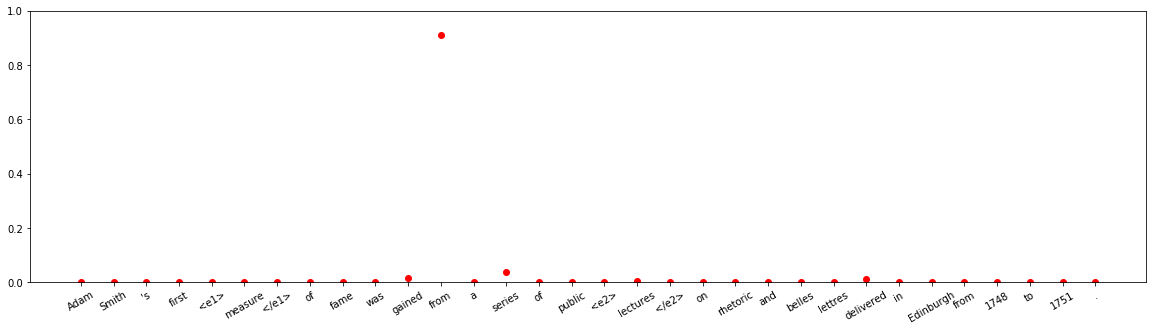



input sentence: Halfway into the flight to LA , a <e1> passenger </e1> took a <e2> photograph </e2> and the icy blue flash from the camera bounced momentarily across the dimly lit cabin .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.034644756
Cause-Effect 	:	 2.6096518e-06
Component-Whole 	:	 1.1580951e-05
Entity-Destination 	:	 0.00066066335
Entity-Origin 	:	 0.00015072039
Product-Producer 	:	 0.08401055
Member-Collection 	:	 2.4736348e-05
Message-Topic 	:	 8.4579455e-07
Content-Container 	:	 0.000117459334
Instrument-Agency 	:	 0.8803761



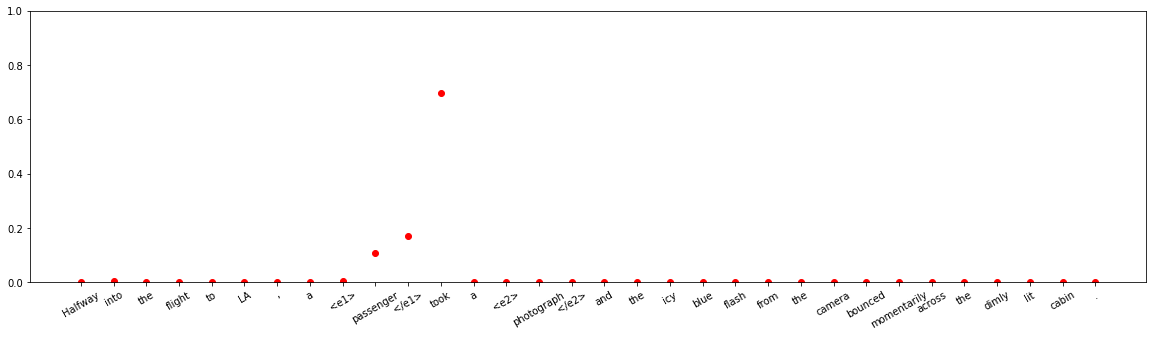






input sentence: My <e1> view </e1> of how the brain works is rooted in an evolutionary <e2> perspective </e2> that moves from the fact that our mental life reflects the actions of many .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.99944764
Cause-Effect 	:	 1.9290141e-07
Component-Whole 	:	 3.9501495e-07
Entity-Destination 	:	 4.0796722e-10
Entity-Origin 	:	 2.42087e-08
Product-Producer 	:	 1.1038728e-10
Member-Collection 	:	 2.6661933e-09
Message-Topic 	:	 0.0005517518
Content-Container 	:	 4.225429e-11
Instrument-Agency 	:	 4.5340046e-10



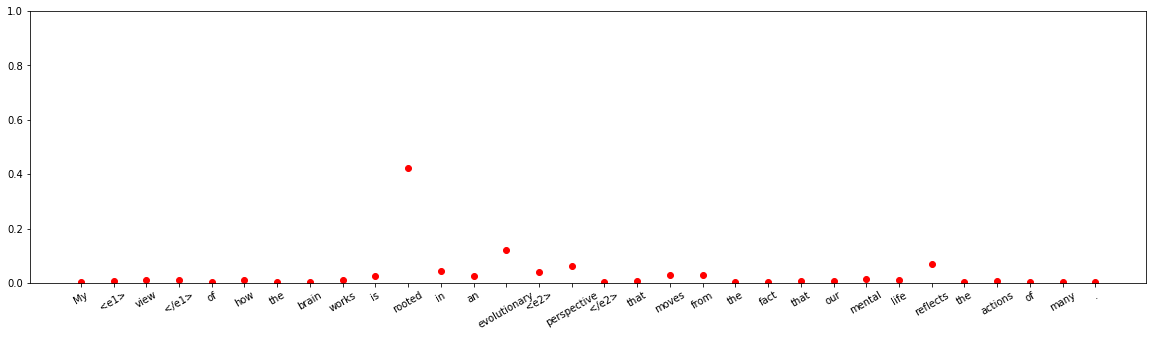




input sentence: The <e1> sample </e1> was pressed from <e2> powder </e2> into a platelet with about 10 mm thickness , which was cut into a rectangle and put on the platinum leads .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 7.7742163e-07
Cause-Effect 	:	 5.714646e-09
Component-Whole 	:	 1.6738499e-05
Entity-Destination 	:	 9.060581e-06
Entity-Origin 	:	 0.9999721
Product-Producer 	:	 3.891524e-09
Member-Collection 	:	 3.6481596e-11
Message-Topic 	:	 1.7472755e-09
Content-Container 	:	 1.2148837e-06
Instrument-Agency 	:	 1.4150895e-07



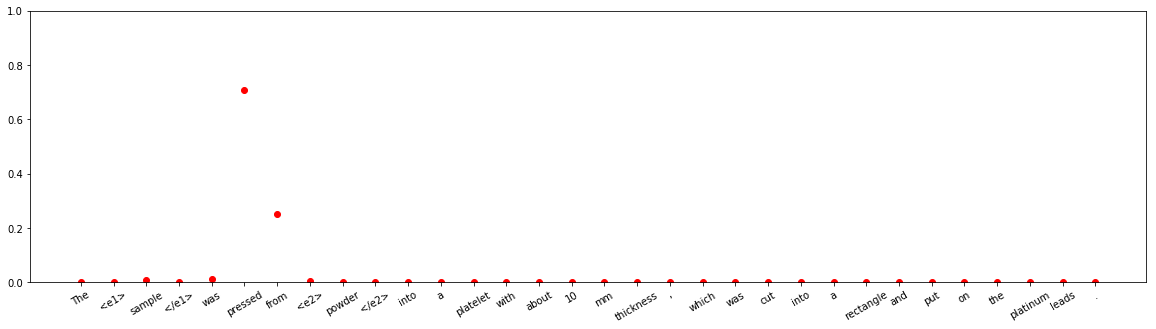



input sentence: The <e1> entrance </e1> to the temple was originally from the <e2> east </e2> , near the southeastern corner and decorated with twin monolithic limestone pillars colored red and bearing on the exterior side vertical hieroglyphic inscriptions in sunk relief with the queen 's titulary , name and depiction .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 6.748477e-05
Cause-Effect 	:	 1.4873914e-09
Component-Whole 	:	 2.2501272e-06
Entity-Destination 	:	 3.9445172e-07
Entity-Origin 	:	 0.9999299
Product-Producer 	:	 2.0279032e-09
Member-Collection 	:	 5.5800135e-11
Message-Topic 	:	 4.866577e-10
Content-Container 	:	 2.6313873e-10
Instrument-Agency 	:	 2.0264086e-11



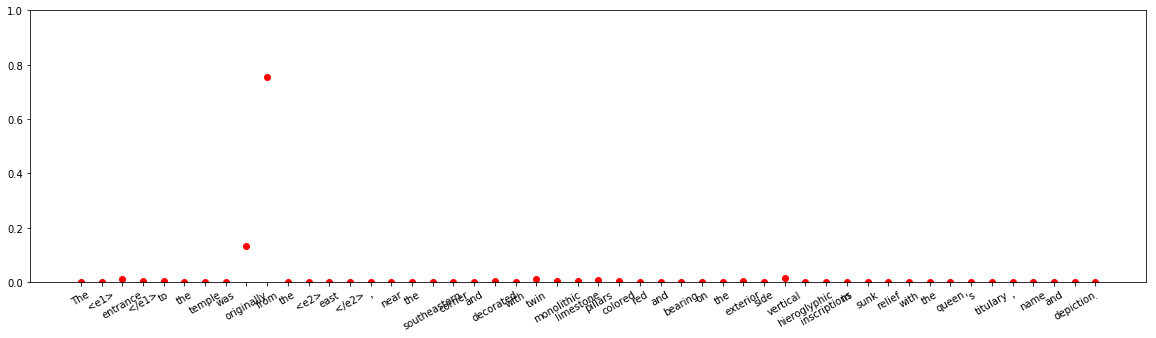






input sentence: One simple <e1> method </e1> for clearing small clogs is to use a tried-and-true <e2> combination </e2> of baking soda and vinegar .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.27926788
Cause-Effect 	:	 8.047636e-05
Component-Whole 	:	 0.0023704004
Entity-Destination 	:	 3.5222843e-08
Entity-Origin 	:	 2.626967e-08
Product-Producer 	:	 2.2809027e-07
Member-Collection 	:	 1.3191218e-08
Message-Topic 	:	 5.083644e-06
Content-Container 	:	 1.845213e-08
Instrument-Agency 	:	 0.7182758



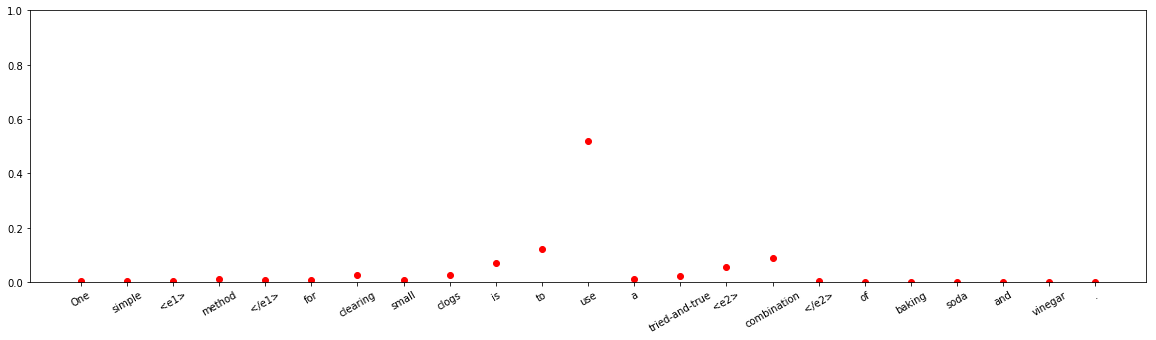




input sentence: The <e1> body </e1> unleashes its extraterrestrial <e2> passenger </e2> , which proceeds to infect the student population at a breakneck pace .
answer label:    Entity-Origin
wrong label:    Product-Producer
Other 	:	 0.0012142219
Cause-Effect 	:	 0.00017042848
Component-Whole 	:	 0.0002660374
Entity-Destination 	:	 0.0017244813
Entity-Origin 	:	 2.102151e-05
Product-Producer 	:	 0.9952865
Member-Collection 	:	 0.00028029323
Message-Topic 	:	 8.874261e-07
Content-Container 	:	 3.0976124e-05
Instrument-Agency 	:	 0.0010053181



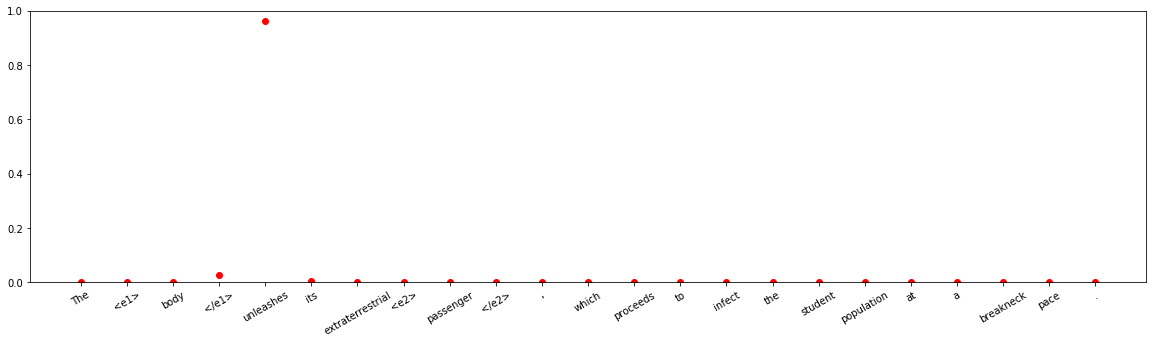




input sentence: Anyway , the <e1> guy </e1> convinced some local with a <e2> car </e2> to drive somewhere to procure us some beer .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.2481226
Cause-Effect 	:	 6.4295216e-07
Component-Whole 	:	 1.5012542e-05
Entity-Destination 	:	 1.8500755e-06
Entity-Origin 	:	 6.8104504e-07
Product-Producer 	:	 0.004294292
Member-Collection 	:	 4.8274165e-07
Message-Topic 	:	 4.6844296e-05
Content-Container 	:	 4.107043e-08
Instrument-Agency 	:	 0.7475175



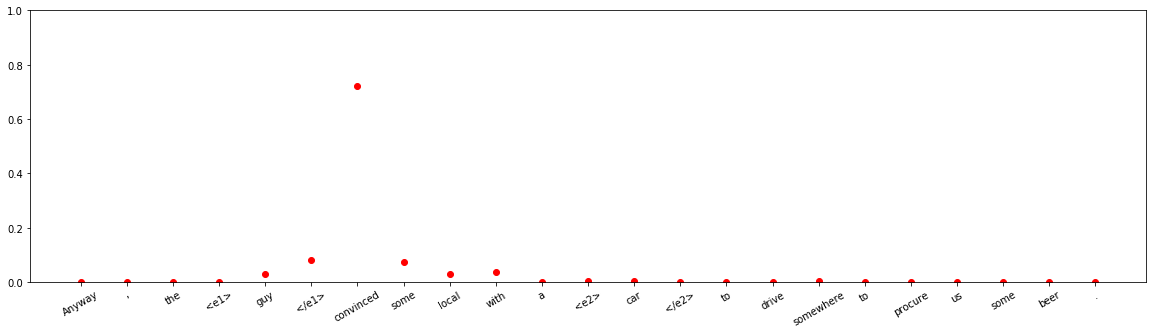













input sentence: The <e1> students </e1> had decorated the blackboard with a <e2> drawing </e2> of a young woman and a bright yellow moon .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 2.0704258e-06
Cause-Effect 	:	 6.618428e-10
Component-Whole 	:	 0.011527922
Entity-Destination 	:	 1.5682694e-08
Entity-Origin 	:	 2.1833502e-10
Product-Producer 	:	 0.002128758
Member-Collection 	:	 4.5219048e-07
Message-Topic 	:	 2.5096475e-07
Content-Container 	:	 4.6422956e-05
Instrument-Agency 	:	 0.9862941



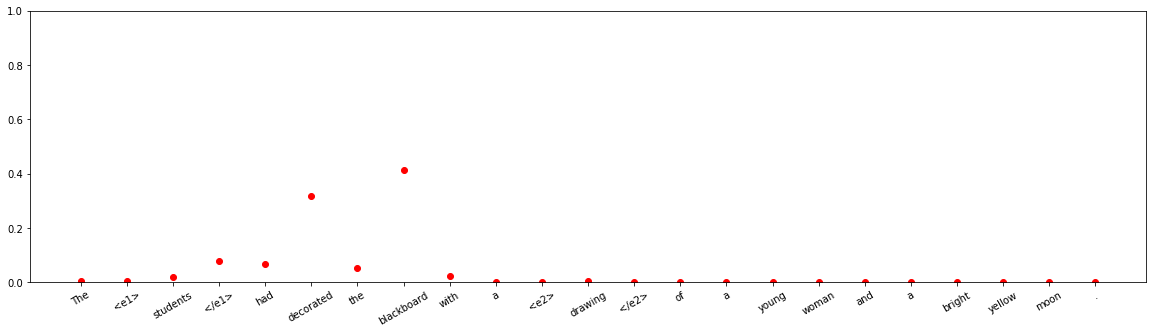


input sentence: The propaganda <e1> machine </e1> tells us about these tin-pot <e2> dictators </e2> , which are the greatest threat to the world .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 2.8808708e-10
Cause-Effect 	:	 5.4092595e-11
Component-Whole 	:	 1.01212505e-08
Entity-Destination 	:	 9.6228876e-12
Entity-Origin 	:	 2.831044e-11
Product-Producer 	:	 1.3984352e-07
Member-Collection 	:	 6.4844237e-09
Message-Topic 	:	 0.9999999
Content-Container 	:	 4.7810134e-09
Instrument-Agency 	:	 3.4352703e-09



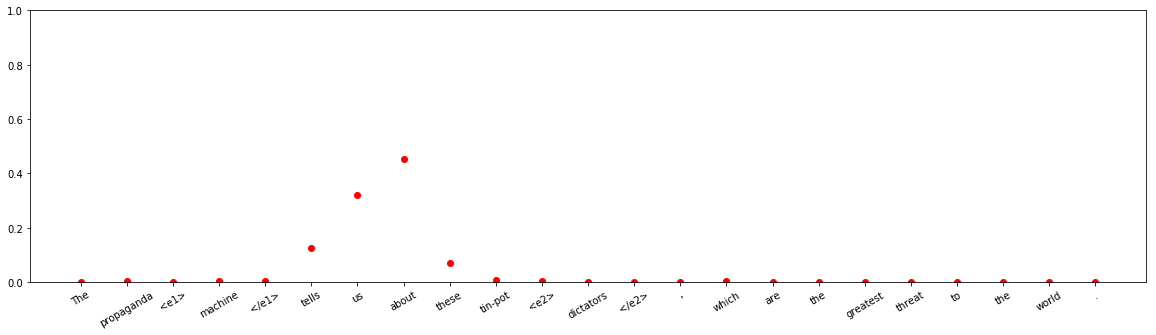



input sentence: For 31 years , the <e1> symposium </e1> has assembled international <e2> physicians </e2> and researchers from academic institutions and private organisations .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.0011590376
Cause-Effect 	:	 1.0049227e-07
Component-Whole 	:	 0.016562747
Entity-Destination 	:	 9.4579076e-07
Entity-Origin 	:	 1.3121097e-05
Product-Producer 	:	 0.00029787986
Member-Collection 	:	 0.00014523418
Message-Topic 	:	 0.9818139
Content-Container 	:	 6.886259e-06
Instrument-Agency 	:	 8.9153225e-08



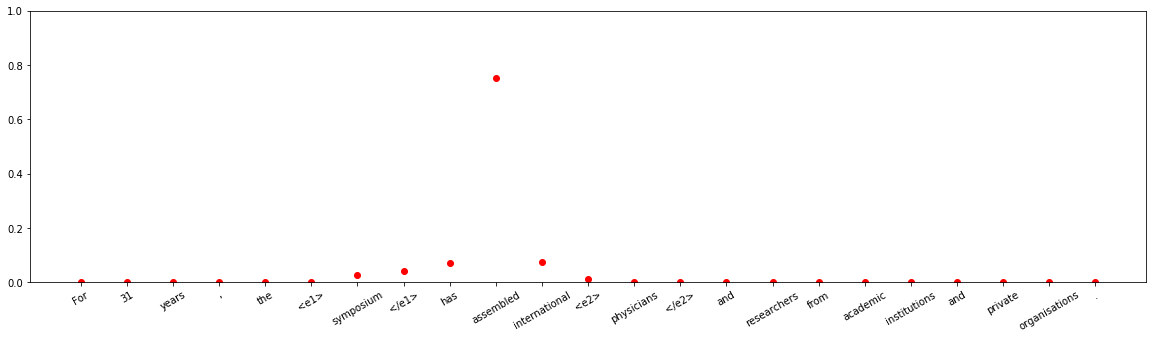




input sentence: Stroker Serpentine alerted me to a very messy situation this evening involving a huge <e1> cache </e1> of stolen <e2> goods </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.8635525
Cause-Effect 	:	 6.386602e-06
Component-Whole 	:	 1.7151113e-05
Entity-Destination 	:	 0.0008295362
Entity-Origin 	:	 0.00022147561
Product-Producer 	:	 0.00010731536
Member-Collection 	:	 0.1056412
Message-Topic 	:	 0.0021153719
Content-Container 	:	 0.019490628
Instrument-Agency 	:	 0.008018428



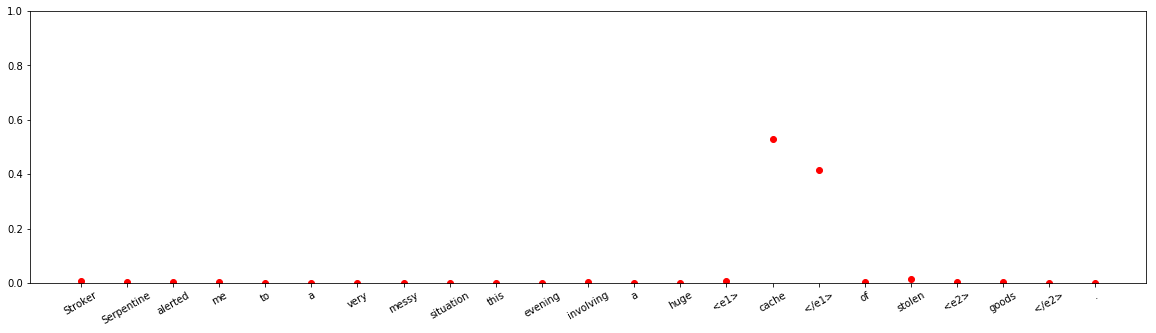





input sentence: Be sure and always stack on an elevated stack pad so the <e1> moisture </e1> runs away from the <e2> stack </e2> .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.95843387
Cause-Effect 	:	 0.00012737146
Component-Whole 	:	 7.185696e-08
Entity-Destination 	:	 5.5558276e-06
Entity-Origin 	:	 0.04143304
Product-Producer 	:	 4.049402e-09
Member-Collection 	:	 8.737054e-11
Message-Topic 	:	 7.7601625e-10
Content-Container 	:	 9.629769e-11
Instrument-Agency 	:	 1.3003365e-09



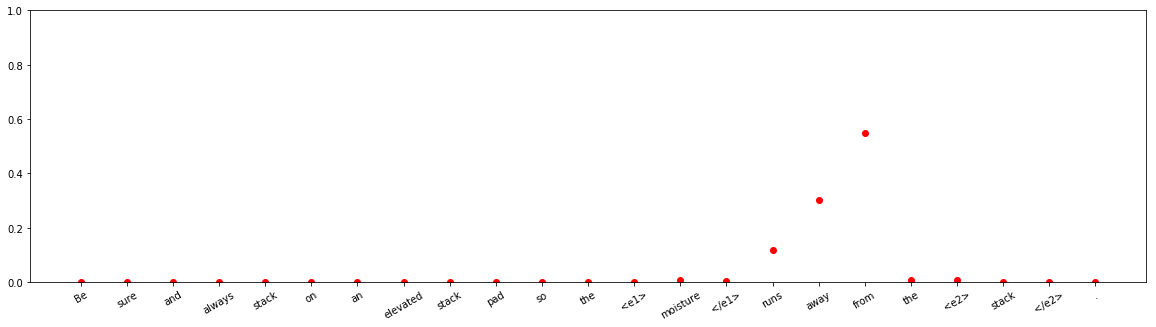








input sentence: Complementing the unique arsenal is a vibrant <e1> world </e1> that employs a cel-shaded <e2> animation </e2> reminiscent of a comic book .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.12627867
Cause-Effect 	:	 0.00034686102
Component-Whole 	:	 2.036843e-05
Entity-Destination 	:	 8.158213e-10
Entity-Origin 	:	 2.103806e-08
Product-Producer 	:	 0.0019889453
Member-Collection 	:	 9.7182994e-05
Message-Topic 	:	 0.000282017
Content-Container 	:	 2.2268905e-08
Instrument-Agency 	:	 0.87098587



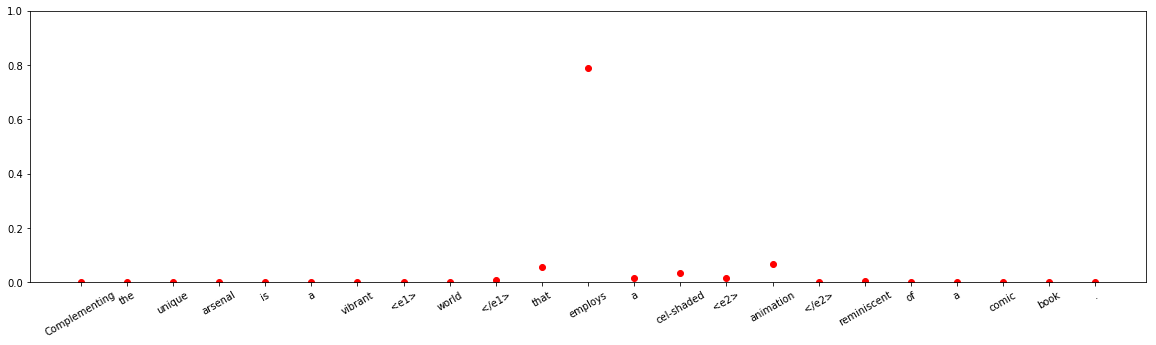



input sentence: A <e1> project </e1> to regulate the <e2> standard </e2> of private rental properties in Dumfries and Galloway looks set to close .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.05202662
Cause-Effect 	:	 3.6961168e-07
Component-Whole 	:	 0.5049561
Entity-Destination 	:	 0.16204698
Entity-Origin 	:	 8.299853e-09
Product-Producer 	:	 8.284663e-07
Member-Collection 	:	 6.561938e-07
Message-Topic 	:	 0.28083074
Content-Container 	:	 4.616275e-07
Instrument-Agency 	:	 0.00013719349



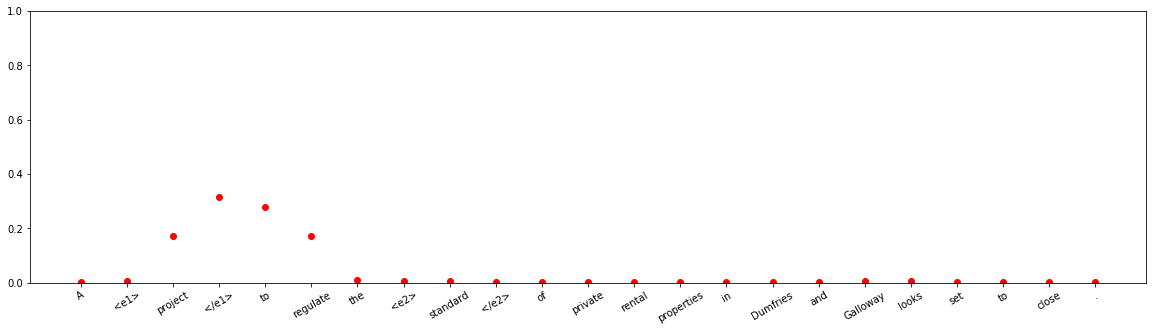


input sentence: The outer <e1> bark </e1> composed of dead <e2> phloem </e2> alternating with bands of cork is called , technically , rhytidome .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 3.3721385e-08
Cause-Effect 	:	 6.006885e-10
Component-Whole 	:	 0.9999999
Entity-Destination 	:	 2.4572284e-12
Entity-Origin 	:	 3.1869546e-10
Product-Producer 	:	 1.0295388e-09
Member-Collection 	:	 1.5165836e-07
Message-Topic 	:	 9.962016e-13
Content-Container 	:	 1.7343174e-10
Instrument-Agency 	:	 5.4756435e-11



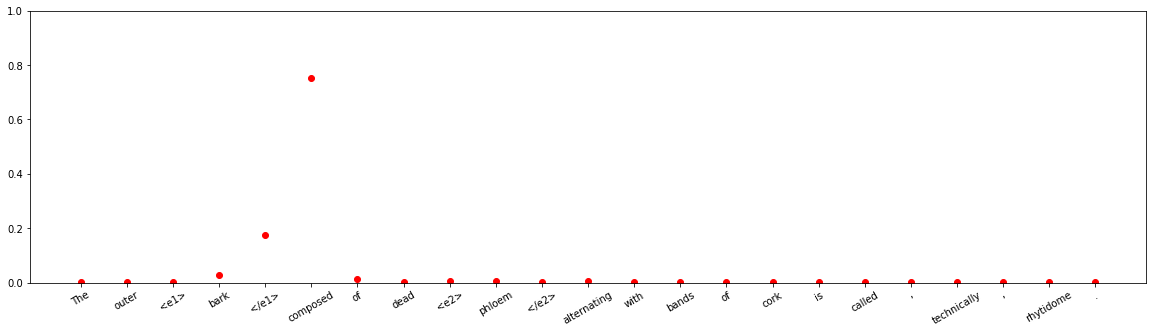






input sentence: A <e1> blood </e1> <e2> clot </e2> is a normal reaction of the body that occurs if a blood vessel is injured .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.28977853
Cause-Effect 	:	 0.6507572
Component-Whole 	:	 0.0021674223
Entity-Destination 	:	 3.3544923e-06
Entity-Origin 	:	 0.0029110042
Product-Producer 	:	 3.531538e-05
Member-Collection 	:	 0.00092006265
Message-Topic 	:	 7.922784e-05
Content-Container 	:	 0.00044315142
Instrument-Agency 	:	 0.05290493



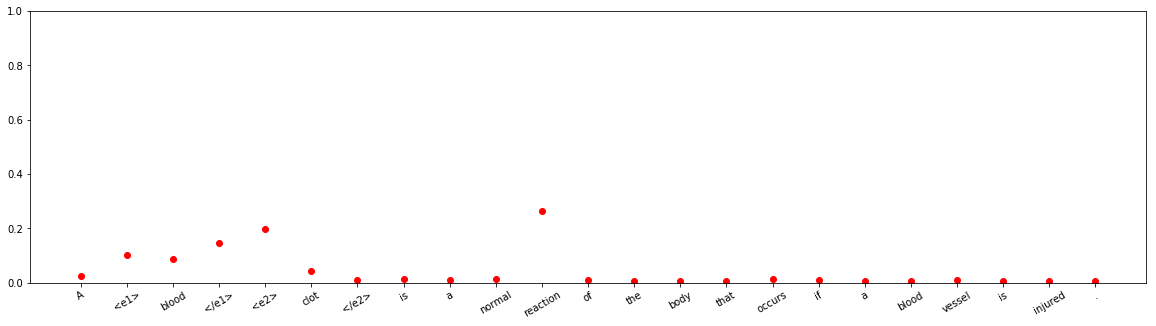



input sentence: <e1> Considerations </e1> have been concerned with <e2> cases </e2> where the forces between particles can be handled in a satisfactory manner .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.009012178
Cause-Effect 	:	 9.3492745e-05
Component-Whole 	:	 0.00019701436
Entity-Destination 	:	 1.3892038e-06
Entity-Origin 	:	 2.762511e-08
Product-Producer 	:	 4.580072e-09
Member-Collection 	:	 1.2055484e-06
Message-Topic 	:	 0.99066764
Content-Container 	:	 4.3142427e-06
Instrument-Agency 	:	 2.2651586e-05



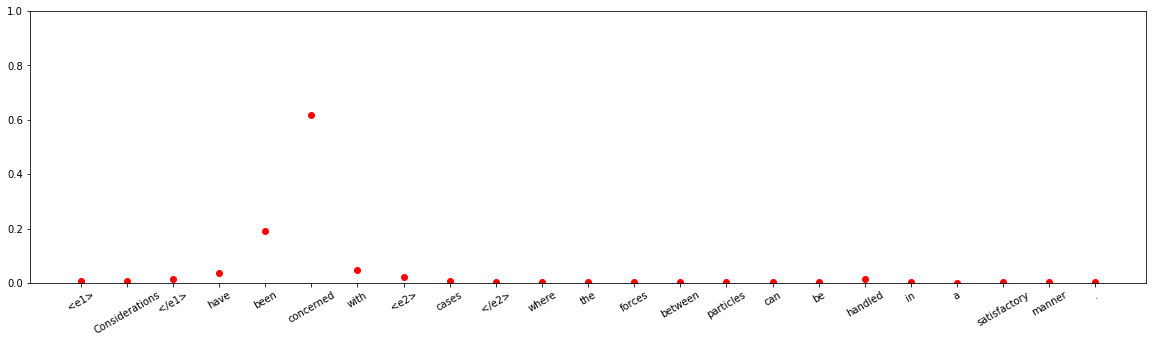




input sentence: It is a <e1> dispute </e1> over a <e2> plot </e2> of land where hundreds of babies are believed to be buried .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.3518617
Cause-Effect 	:	 0.0003427288
Component-Whole 	:	 3.9890733e-07
Entity-Destination 	:	 2.825533e-07
Entity-Origin 	:	 2.7386628e-07
Product-Producer 	:	 5.9042964e-07
Member-Collection 	:	 1.8268847e-05
Message-Topic 	:	 0.64772344
Content-Container 	:	 4.945021e-06
Instrument-Agency 	:	 4.74007e-05



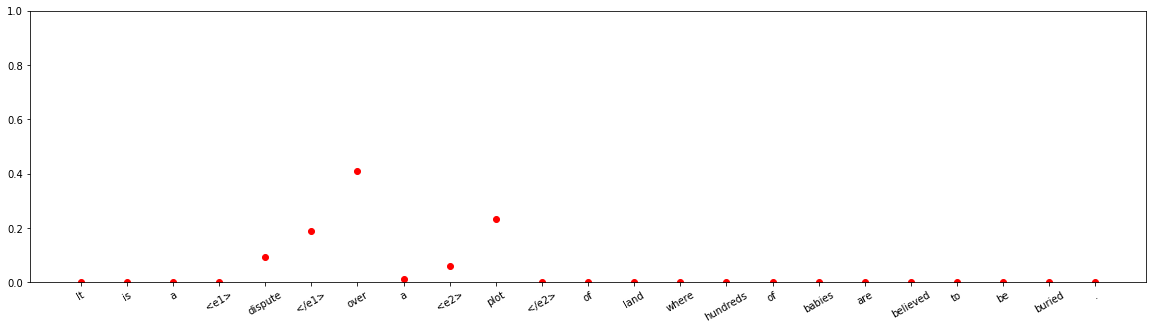



input sentence: The <e1> administration </e1> has established a number of health posts and health <e2> centres </e2> to provide health care to Amerindians .
answer label:    Product-Producer
wrong label:    Message-Topic
Other 	:	 0.29152867
Cause-Effect 	:	 1.1746357e-05
Component-Whole 	:	 0.20815934
Entity-Destination 	:	 1.3213009e-05
Entity-Origin 	:	 8.2010564e-07
Product-Producer 	:	 0.013960787
Member-Collection 	:	 0.000403201
Message-Topic 	:	 0.4844341
Content-Container 	:	 6.841378e-06
Instrument-Agency 	:	 0.0014812058



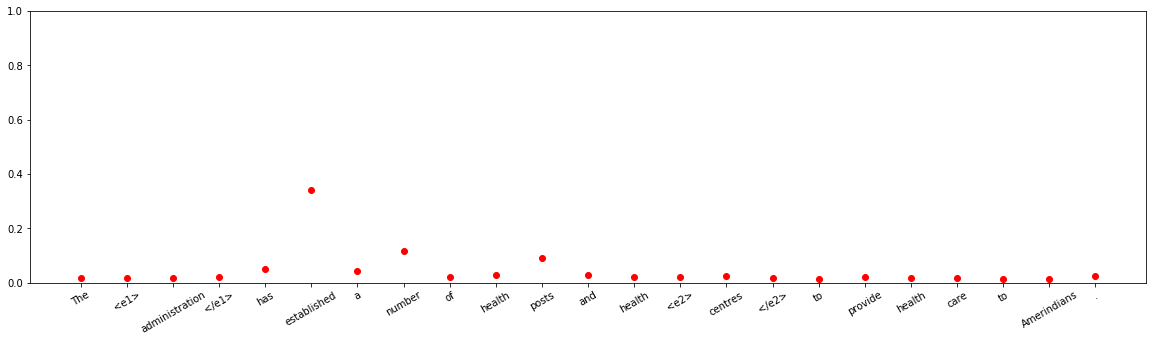


input sentence: It is a common informal <e1> convention </e1> to reserve or declare full or partial <e2> ownership </e2> of a community resource .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.012850295
Cause-Effect 	:	 8.008431e-09
Component-Whole 	:	 8.687521e-08
Entity-Destination 	:	 6.2829963e-10
Entity-Origin 	:	 4.795936e-09
Product-Producer 	:	 1.5513365e-08
Member-Collection 	:	 3.2847421e-07
Message-Topic 	:	 0.9871493
Content-Container 	:	 3.8150812e-08
Instrument-Agency 	:	 7.1974795e-09



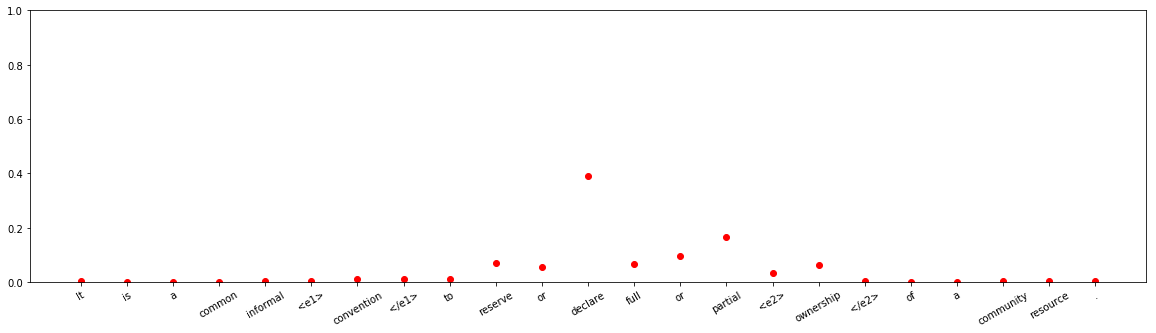







input sentence: She began to create a <e1> brew </e1> in her <e2> cauldron </e2> , that would take an entire year to prepare .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 1.0447743e-07
Cause-Effect 	:	 1.12632364e-07
Component-Whole 	:	 1.4443283e-06
Entity-Destination 	:	 0.95231235
Entity-Origin 	:	 1.3264408e-06
Product-Producer 	:	 0.00014880007
Member-Collection 	:	 8.310021e-08
Message-Topic 	:	 6.94567e-07
Content-Container 	:	 0.04753404
Instrument-Agency 	:	 9.13431e-07



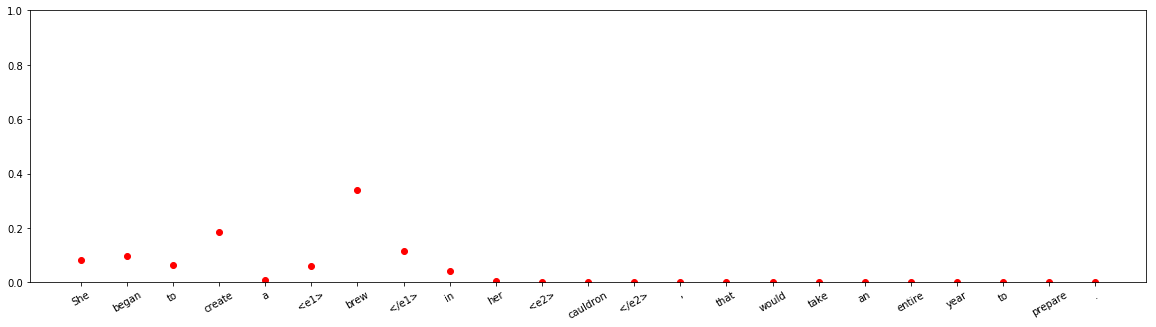


input sentence: But now there came from out the niche a low <e1> laugh </e1> that erected the <e2> hairs </e2> upon my head .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.00258891
Cause-Effect 	:	 2.8866287e-07
Component-Whole 	:	 0.9973579
Entity-Destination 	:	 8.660273e-08
Entity-Origin 	:	 2.7992401e-08
Product-Producer 	:	 2.4795684e-06
Member-Collection 	:	 1.2380511e-05
Message-Topic 	:	 1.4400607e-07
Content-Container 	:	 2.0220671e-08
Instrument-Agency 	:	 3.781361e-05



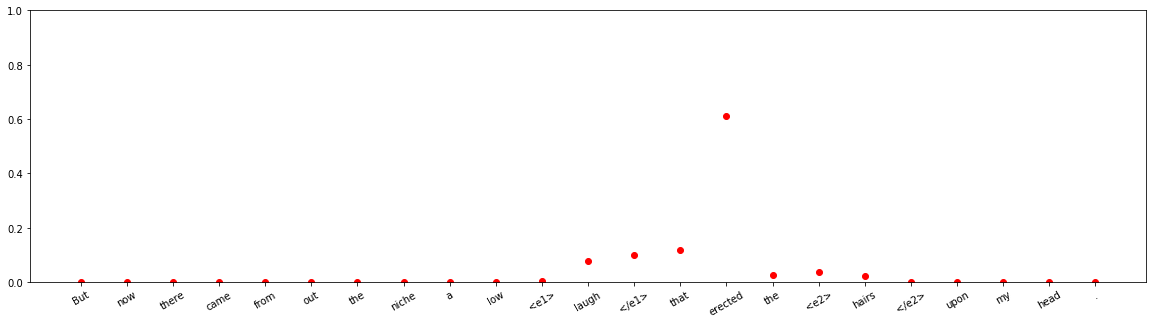










input sentence: The <e1> crisis </e1> originated in an over-leveraged corporate <e2> sector </e2> and a banking sector that had mismatched assets and liabilities .
answer label:    Entity-Origin
wrong label:    Cause-Effect
Other 	:	 0.01885206
Cause-Effect 	:	 0.97695345
Component-Whole 	:	 8.734294e-10
Entity-Destination 	:	 0.000102215236
Entity-Origin 	:	 0.004012532
Product-Producer 	:	 4.5384905e-09
Member-Collection 	:	 5.3708455e-08
Message-Topic 	:	 7.9646015e-05
Content-Container 	:	 3.9129777e-08
Instrument-Agency 	:	 2.4955511e-08



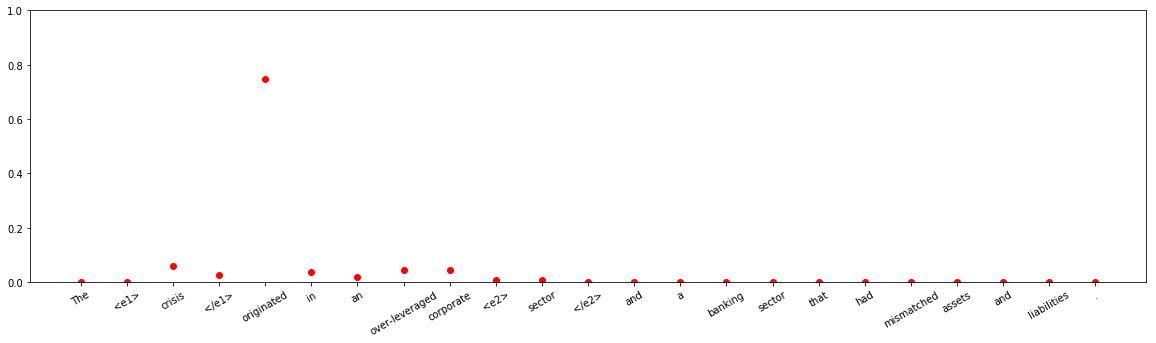





input sentence: My dish is attached to a <e1> pole </e1> that resides in a <e2> receptacle </e2> designed for just such a purpose .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 0.02376913
Cause-Effect 	:	 1.4589277e-07
Component-Whole 	:	 0.07884009
Entity-Destination 	:	 0.84035933
Entity-Origin 	:	 8.6474596e-05
Product-Producer 	:	 1.0878208e-06
Member-Collection 	:	 0.0001355545
Message-Topic 	:	 1.0227942e-05
Content-Container 	:	 0.056760296
Instrument-Agency 	:	 3.766974e-05



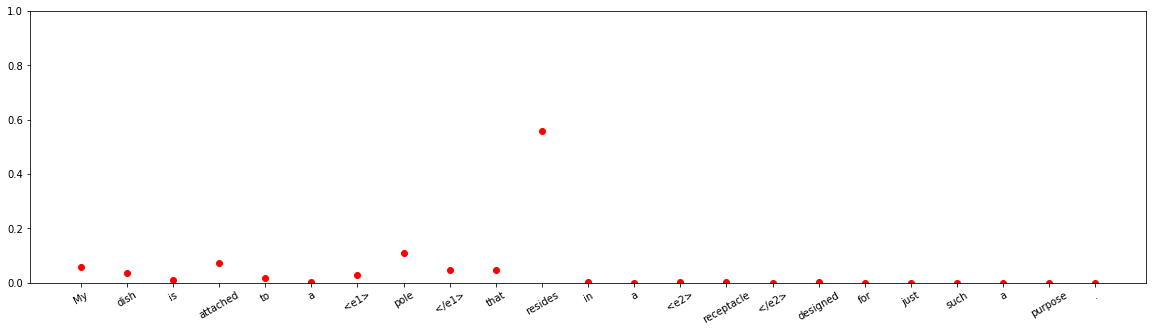















input sentence: The <e1> instrument </e1> was inside a <e2> vacuum chamber </e2> , and both piston and anvil were cooled with liquid nitrogen .
answer label:    Content-Container
wrong label:    Other
Other 	:	 0.8705048
Cause-Effect 	:	 3.8142963e-07
Component-Whole 	:	 0.093622535
Entity-Destination 	:	 0.007482445
Entity-Origin 	:	 1.3333062e-06
Product-Producer 	:	 5.307292e-08
Member-Collection 	:	 2.855704e-06
Message-Topic 	:	 1.3338551e-05
Content-Container 	:	 0.02835537
Instrument-Agency 	:	 1.6802547e-05



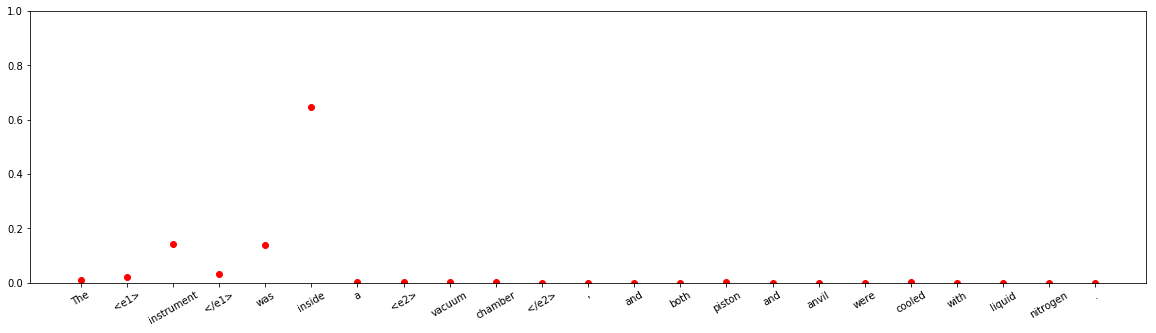


input sentence: The glass tealight <e1> holder </e1> appears to float inside the metal <e2> spiral </e2> as it spins in the gentle breeze .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 3.857663e-05
Cause-Effect 	:	 9.424224e-09
Component-Whole 	:	 0.9999598
Entity-Destination 	:	 3.0332524e-07
Entity-Origin 	:	 9.0579627e-10
Product-Producer 	:	 9.565286e-11
Member-Collection 	:	 1.913768e-08
Message-Topic 	:	 5.767781e-10
Content-Container 	:	 5.5144073e-07
Instrument-Agency 	:	 5.4392274e-07



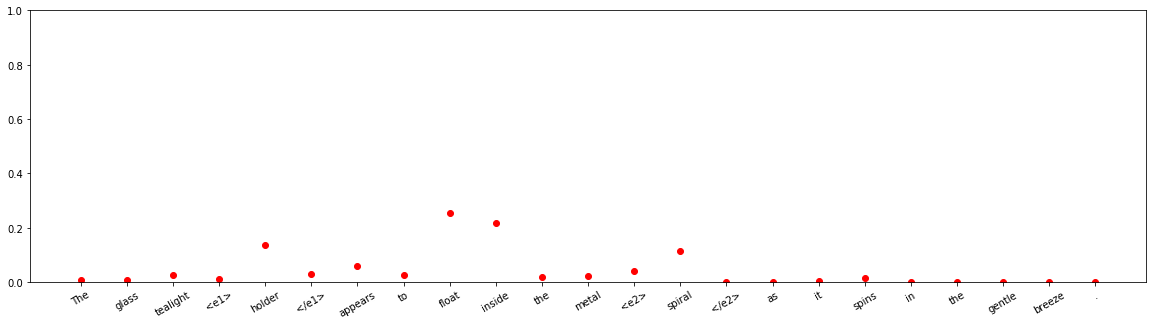



input sentence: I dunno , I 'm kinda leaning towards some props for the <e1> person </e1> that came up with <e2> brakes </e2> .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.21437156
Cause-Effect 	:	 0.0016621352
Component-Whole 	:	 0.03712122
Entity-Destination 	:	 5.5103887e-05
Entity-Origin 	:	 0.0005010361
Product-Producer 	:	 0.0018210054
Member-Collection 	:	 3.3452725e-06
Message-Topic 	:	 7.680048e-06
Content-Container 	:	 9.667966e-06
Instrument-Agency 	:	 0.74444723



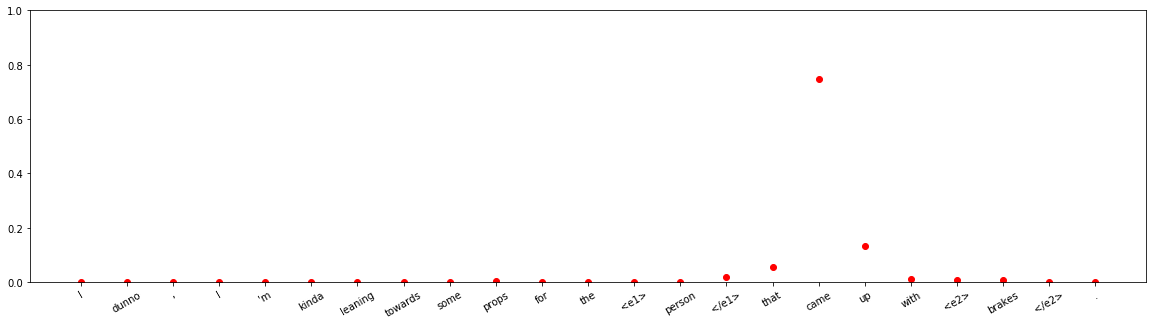



input sentence: To that end , the <e1> coalition </e1> has established some local recreational <e2> activities </e2> , including Laser Tag and paintball .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.99940944
Cause-Effect 	:	 2.1444949e-07
Component-Whole 	:	 3.7126945e-05
Entity-Destination 	:	 6.001372e-09
Entity-Origin 	:	 2.646213e-08
Product-Producer 	:	 1.3568349e-05
Member-Collection 	:	 1.2159342e-05
Message-Topic 	:	 2.9982135e-05
Content-Container 	:	 1.2315131e-10
Instrument-Agency 	:	 0.0004973852



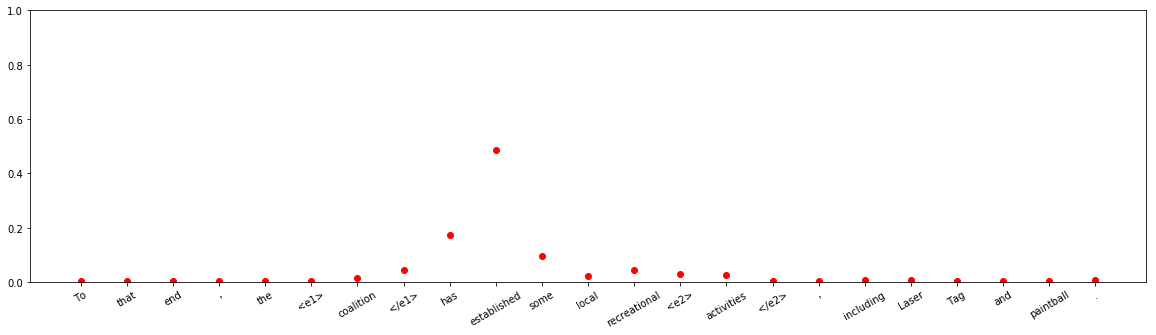




input sentence: The <e1> man </e1> completed a full <e2> lap </e2> before being stopped by guards , but he never interfered with Shorter .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.16386394
Cause-Effect 	:	 7.588894e-07
Component-Whole 	:	 1.3139805e-05
Entity-Destination 	:	 8.561041e-05
Entity-Origin 	:	 4.0191907e-08
Product-Producer 	:	 0.835117
Member-Collection 	:	 8.562105e-08
Message-Topic 	:	 4.942133e-08
Content-Container 	:	 1.3193427e-08
Instrument-Agency 	:	 0.00091939105



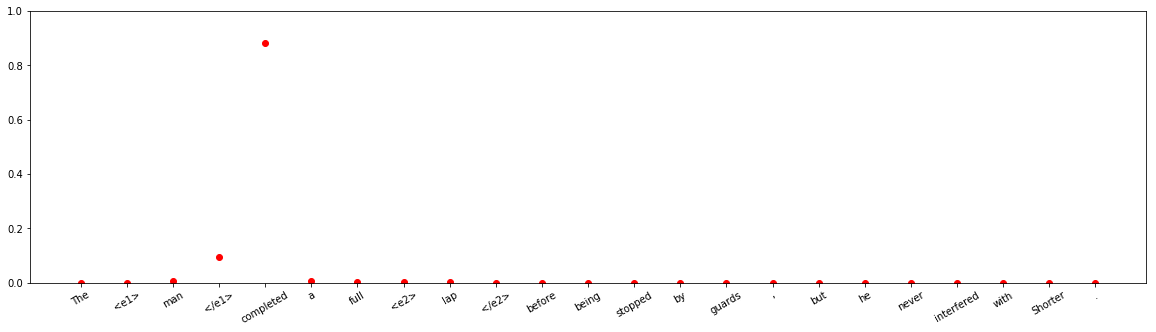



input sentence: The <e1> impact </e1> of the floating body effect on noise is investigated in this <e2> work </e2> for the first time .
answer label:    Message-Topic
wrong label:    Cause-Effect
Other 	:	 0.007115165
Cause-Effect 	:	 0.9926374
Component-Whole 	:	 0.000101027974
Entity-Destination 	:	 3.99967e-07
Entity-Origin 	:	 2.2213978e-08
Product-Producer 	:	 8.700127e-10
Member-Collection 	:	 9.307128e-08
Message-Topic 	:	 9.423931e-05
Content-Container 	:	 6.3183285e-09
Instrument-Agency 	:	 5.1681196e-05



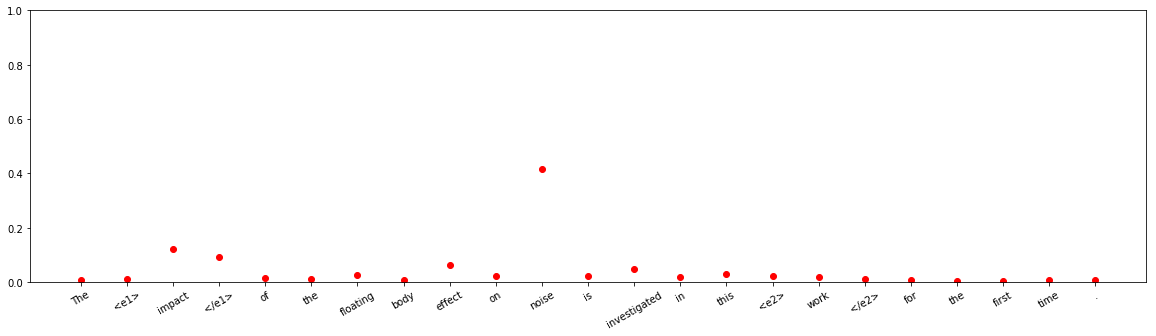





input sentence: Most of the <e1> hairstyles </e1> from past <e2> days </e2> of Hollywood glory have unique features that are set in place .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.90010476
Cause-Effect 	:	 1.4771233e-05
Component-Whole 	:	 1.8860172e-08
Entity-Destination 	:	 1.0343007e-07
Entity-Origin 	:	 0.09988038
Product-Producer 	:	 8.574796e-09
Member-Collection 	:	 5.2791457e-08
Message-Topic 	:	 9.02081e-09
Content-Container 	:	 3.2836605e-11
Instrument-Agency 	:	 3.857093e-08



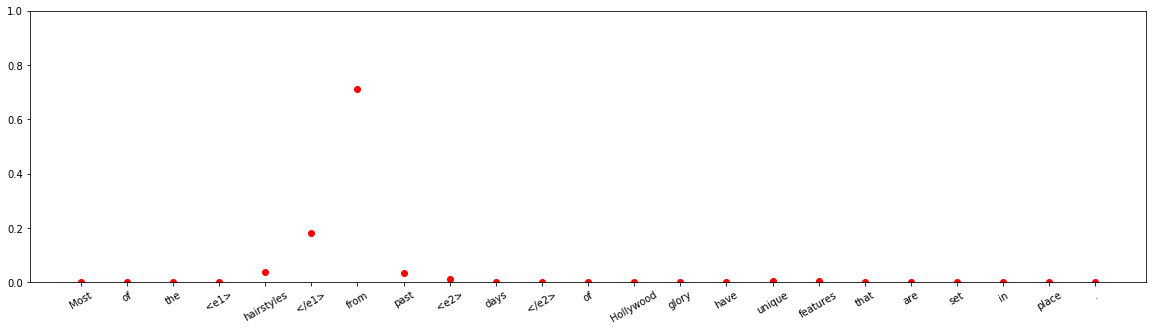




input sentence: This <e1> plan </e1> is the result of a focused analysis of <e2> crime </e2> and disorder over the last three years .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.4243396
Cause-Effect 	:	 0.0063965423
Component-Whole 	:	 0.00028936725
Entity-Destination 	:	 4.621465e-09
Entity-Origin 	:	 5.8295928e-08
Product-Producer 	:	 4.2839932e-08
Member-Collection 	:	 4.3208393e-06
Message-Topic 	:	 0.56896204
Content-Container 	:	 1.2356676e-07
Instrument-Agency 	:	 7.894265e-06



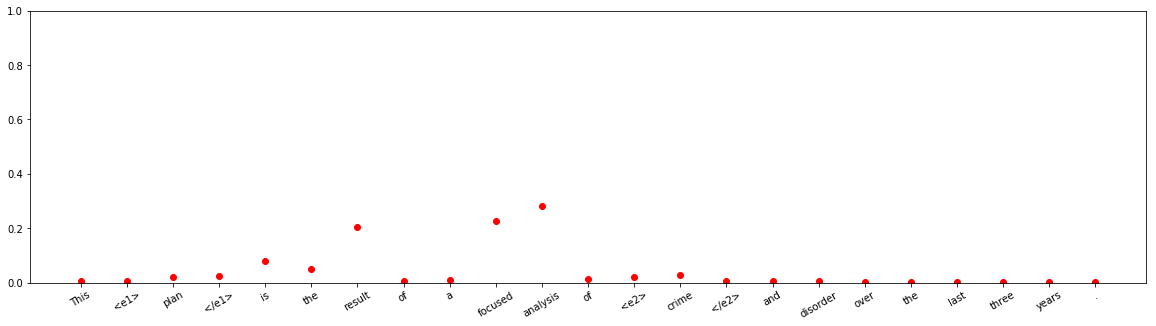






input sentence: With the help of its diaspora , China has won the race to be the <e1> world </e1> 's <e2> factory </e2> .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 7.6002925e-07
Cause-Effect 	:	 6.1293355e-07
Component-Whole 	:	 2.3838359e-08
Entity-Destination 	:	 1.7773231e-09
Entity-Origin 	:	 1.8833646e-08
Product-Producer 	:	 0.9999634
Member-Collection 	:	 4.901687e-09
Message-Topic 	:	 2.3297102e-09
Content-Container 	:	 3.0329232e-08
Instrument-Agency 	:	 3.5214875e-05



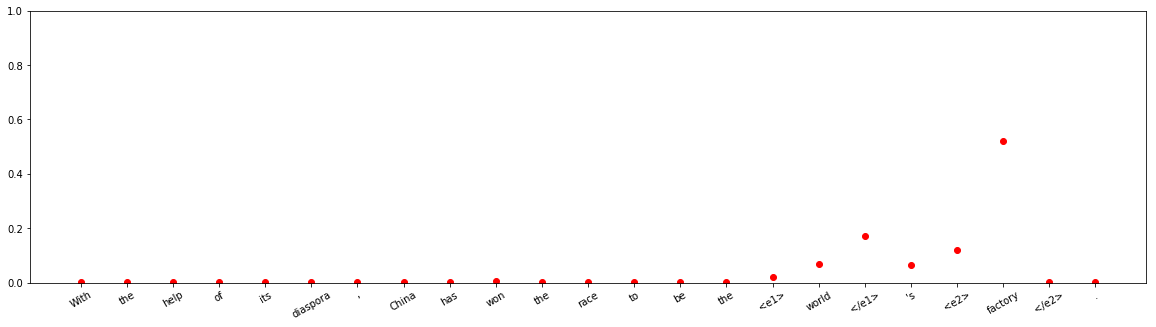



input sentence: Lots of people were having picture taking sessions at the big <e1> patch </e1> of yellow <e2> flowers </e2> in Showa Kinen .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.00015728177
Cause-Effect 	:	 2.8197854e-07
Component-Whole 	:	 0.99793774
Entity-Destination 	:	 6.211576e-07
Entity-Origin 	:	 3.2924108e-06
Product-Producer 	:	 3.9431345e-08
Member-Collection 	:	 0.001820884
Message-Topic 	:	 2.3331073e-05
Content-Container 	:	 5.661425e-05
Instrument-Agency 	:	 2.0805786e-08



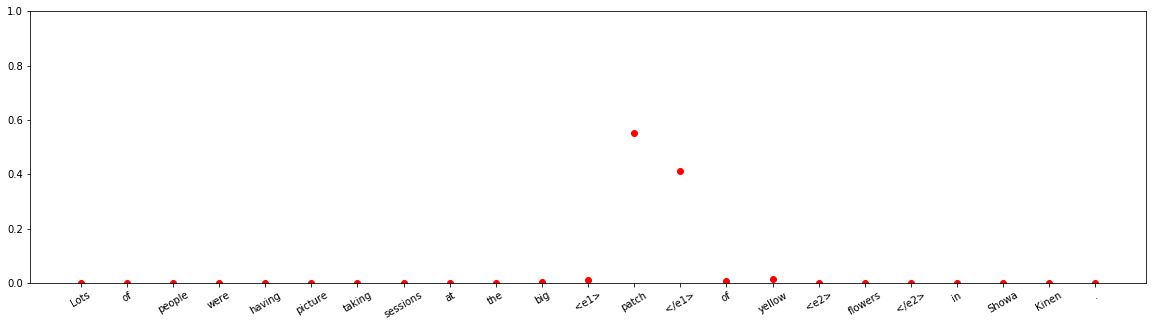










input sentence: Along the way the <e1> women </e1> developed a distinctive <e2> style </e2> , noted for its lively improvisations and geometric simplicity .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.20930277
Cause-Effect 	:	 4.0805517e-06
Component-Whole 	:	 0.038545456
Entity-Destination 	:	 3.230204e-07
Entity-Origin 	:	 2.4012404e-06
Product-Producer 	:	 0.019931197
Member-Collection 	:	 4.2960064e-06
Message-Topic 	:	 8.4825515e-06
Content-Container 	:	 8.704561e-08
Instrument-Agency 	:	 0.7322009



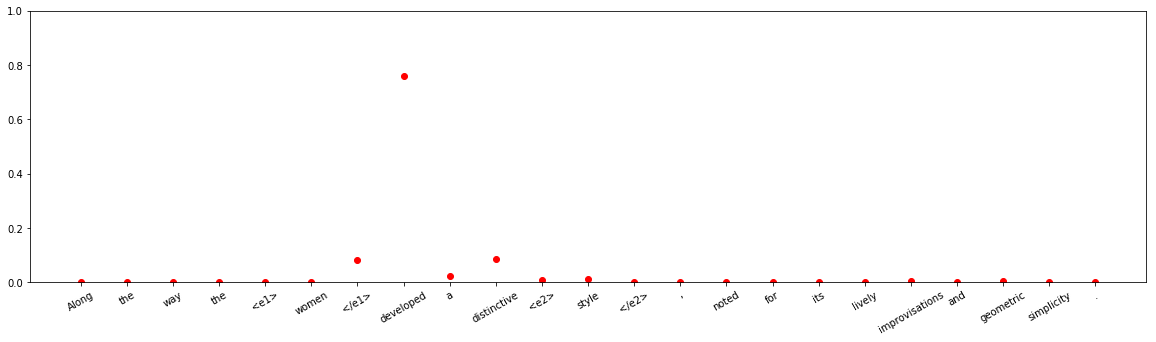






input sentence: Okay , after a <e1> discussion </e1> with my <e2> husband </e2> we have decided to work on the emergency fund first .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 5.7171423e-05
Cause-Effect 	:	 3.6677243e-06
Component-Whole 	:	 0.00024046827
Entity-Destination 	:	 4.220458e-06
Entity-Origin 	:	 2.2700188e-08
Product-Producer 	:	 6.423047e-05
Member-Collection 	:	 2.6233087e-07
Message-Topic 	:	 0.99797505
Content-Container 	:	 4.0051273e-06
Instrument-Agency 	:	 0.0016508853



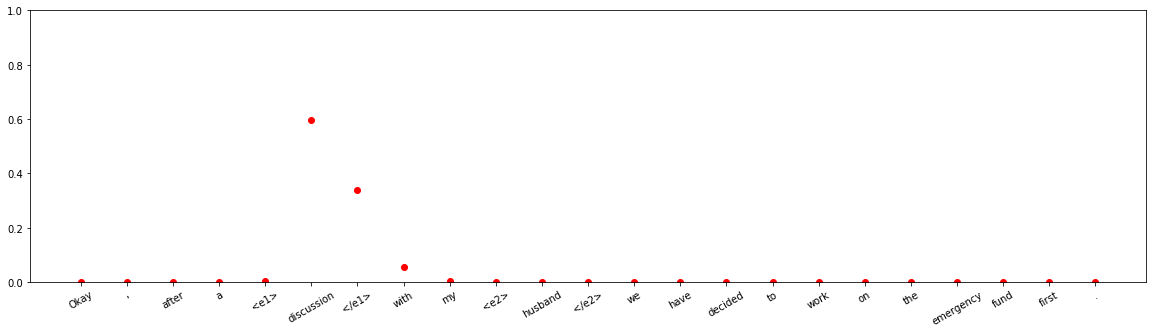



input sentence: A few days before the service , Tom Burris had thrown into Karen 's <e1> casket </e1> his wedding <e2> ring </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.997649
Cause-Effect 	:	 1.4309103e-07
Component-Whole 	:	 0.0004328775
Entity-Destination 	:	 4.228882e-05
Entity-Origin 	:	 6.742924e-06
Product-Producer 	:	 4.3060674e-05
Member-Collection 	:	 7.754271e-05
Message-Topic 	:	 3.6510282e-05
Content-Container 	:	 0.00043237684
Instrument-Agency 	:	 0.0012793296



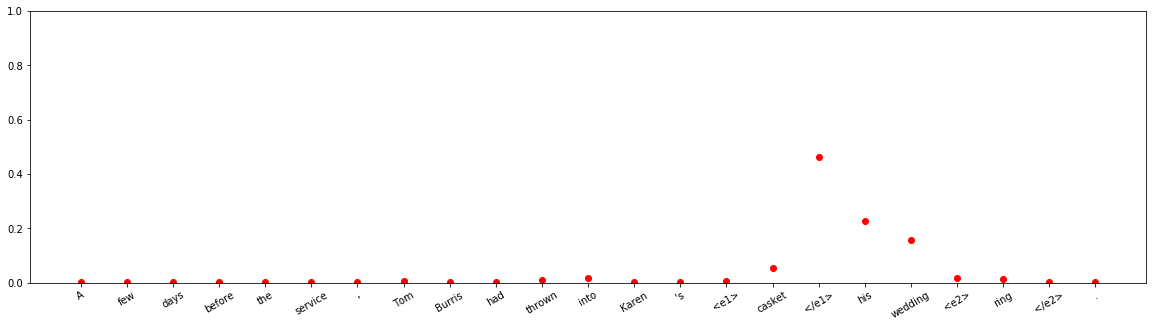








input sentence: The <e1> treaty </e1> establishes a double majority <e2> rule </e2> for Council decisions .
answer label:    Cause-Effect
wrong label:    Message-Topic
Other 	:	 0.031500705
Cause-Effect 	:	 1.026135e-05
Component-Whole 	:	 0.016509198
Entity-Destination 	:	 8.077807e-07
Entity-Origin 	:	 8.946775e-09
Product-Producer 	:	 0.00017982158
Member-Collection 	:	 0.0009245636
Message-Topic 	:	 0.9508368
Content-Container 	:	 1.2125074e-05
Instrument-Agency 	:	 2.5717518e-05



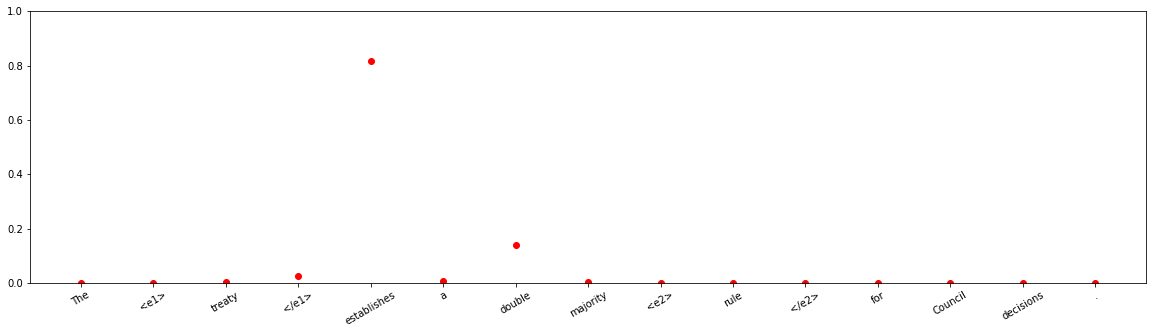




input sentence: We used fried <e1> cheese </e1> as an element in a <e2> dish </e2> .
answer label:    Component-Whole
wrong label:    Entity-Destination
Other 	:	 0.00438356
Cause-Effect 	:	 7.0121405e-06
Component-Whole 	:	 0.17901963
Entity-Destination 	:	 0.6175297
Entity-Origin 	:	 4.199668e-05
Product-Producer 	:	 3.549696e-07
Member-Collection 	:	 8.895908e-06
Message-Topic 	:	 0.00158917
Content-Container 	:	 0.1940983
Instrument-Agency 	:	 0.0033213093



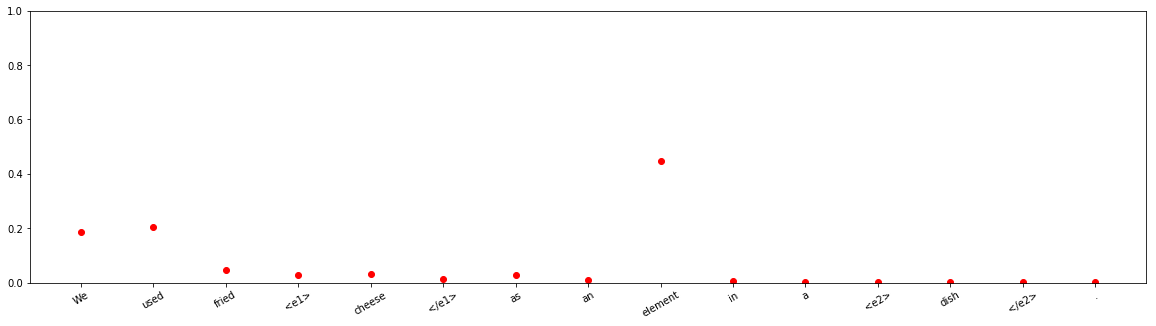


input sentence: Eighteen <e1> studies </e1> were focused on older <e2> adults </e2> living at home .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.00018079104
Cause-Effect 	:	 2.4887253e-10
Component-Whole 	:	 7.027124e-08
Entity-Destination 	:	 2.5042783e-09
Entity-Origin 	:	 1.2217858e-08
Product-Producer 	:	 4.101806e-10
Member-Collection 	:	 6.203897e-09
Message-Topic 	:	 0.9998191
Content-Container 	:	 8.8893287e-10
Instrument-Agency 	:	 1.2026877e-08



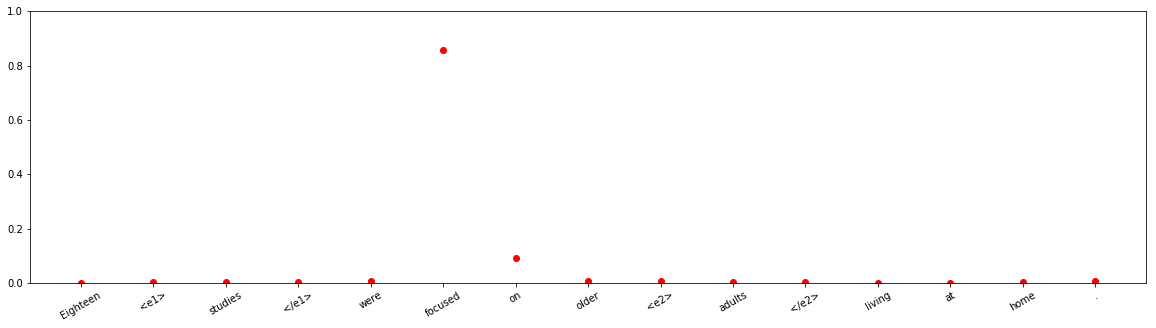


input sentence: The <e1> air </e1> was filled with the <e2> smell </e2> of burning plastic .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.011027088
Cause-Effect 	:	 0.00012552287
Component-Whole 	:	 0.008402473
Entity-Destination 	:	 0.0010478934
Entity-Origin 	:	 0.0013918264
Product-Producer 	:	 5.0143534e-08
Member-Collection 	:	 5.8497096e-07
Message-Topic 	:	 1.3074848e-06
Content-Container 	:	 0.9779424
Instrument-Agency 	:	 6.08251e-05



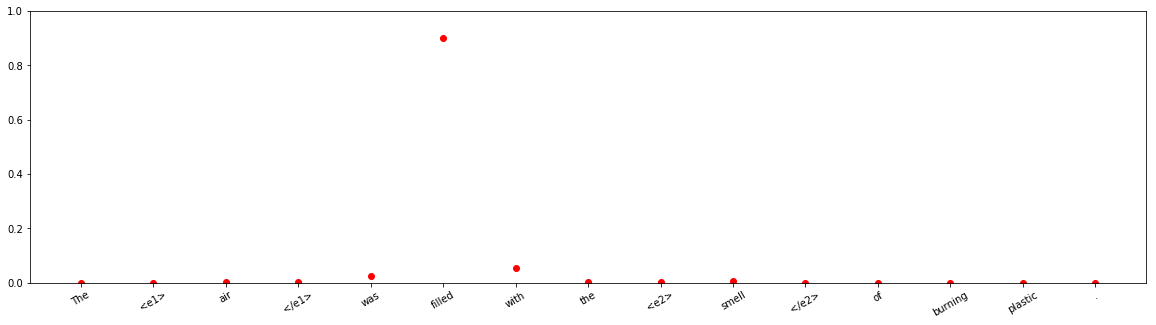


input sentence: Milk <e1> samples </e1> were obtained from one <e2> milking </e2> of each cow .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 6.98401e-10
Cause-Effect 	:	 1.1814196e-09
Component-Whole 	:	 2.7161457e-12
Entity-Destination 	:	 3.6940584e-09
Entity-Origin 	:	 1.0
Product-Producer 	:	 7.555948e-11
Member-Collection 	:	 1.2751199e-11
Message-Topic 	:	 2.9650165e-13
Content-Container 	:	 1.1478613e-09
Instrument-Agency 	:	 4.839239e-11



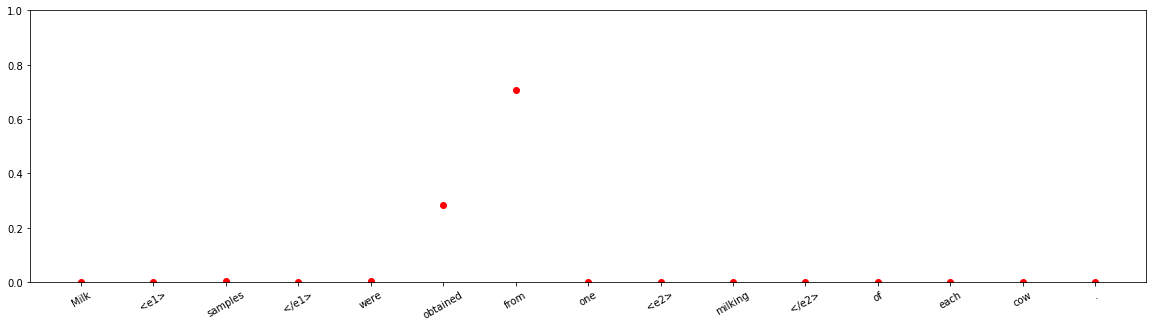




input sentence: A <e1> line </e1> is one of the basic terms in <e2> geometry </e2> .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.018577848
Cause-Effect 	:	 4.2027736e-07
Component-Whole 	:	 0.93174094
Entity-Destination 	:	 1.213839e-05
Entity-Origin 	:	 5.8026603e-07
Product-Producer 	:	 1.6170989e-06
Member-Collection 	:	 3.6127803e-05
Message-Topic 	:	 0.04726104
Content-Container 	:	 0.00029296795
Instrument-Agency 	:	 0.002076388



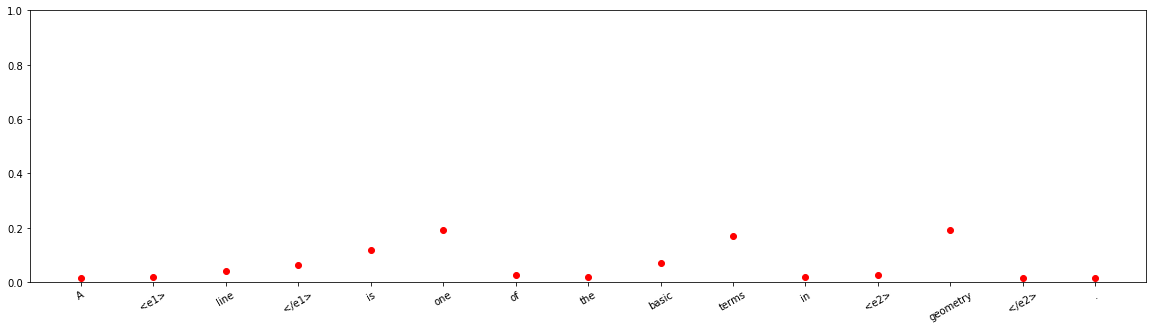





input sentence: He changed the <e1> litter </e1> in his pet 's <e2> litter box </e2> .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 3.4593126e-07
Cause-Effect 	:	 9.7006364e-08
Component-Whole 	:	 2.8112401e-05
Entity-Destination 	:	 0.9186339
Entity-Origin 	:	 5.379679e-07
Product-Producer 	:	 1.3294873e-06
Member-Collection 	:	 5.7762417e-08
Message-Topic 	:	 1.626703e-05
Content-Container 	:	 0.08131844
Instrument-Agency 	:	 8.667813e-07



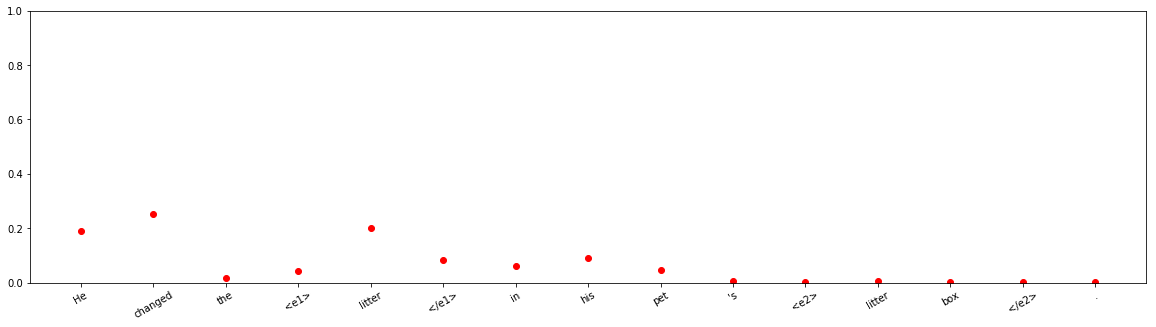


input sentence: Our <e1> staff </e1> has approached many <e2> people </e2> for the product survey .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.99936324
Cause-Effect 	:	 3.521193e-09
Component-Whole 	:	 5.991271e-07
Entity-Destination 	:	 4.0548635e-05
Entity-Origin 	:	 9.9896326e-08
Product-Producer 	:	 0.00046289785
Member-Collection 	:	 6.21362e-05
Message-Topic 	:	 4.602134e-05
Content-Container 	:	 9.384905e-09
Instrument-Agency 	:	 2.4435993e-05



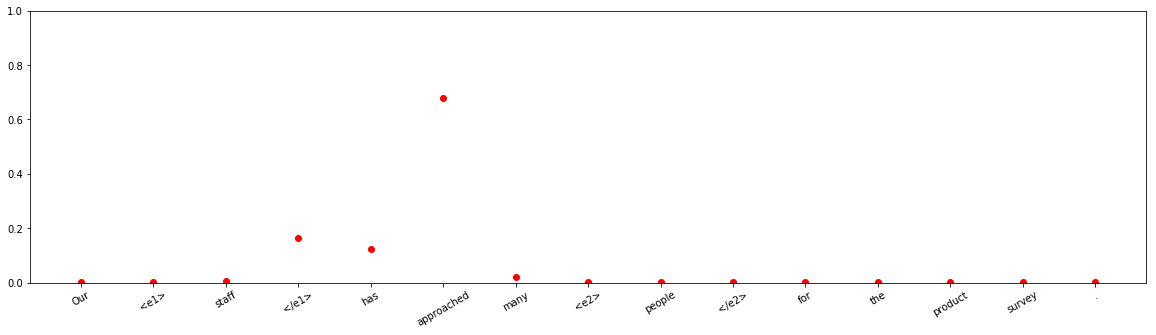



input sentence: Carolyn Cooke 's <e1> stories </e1> have been featured in the <e2> book </e2> .
answer label:    Member-Collection
wrong label:    Message-Topic
Other 	:	 9.734404e-08
Cause-Effect 	:	 5.6362724e-11
Component-Whole 	:	 0.00023105899
Entity-Destination 	:	 7.9495216e-08
Entity-Origin 	:	 2.3053905e-08
Product-Producer 	:	 3.8863976e-07
Member-Collection 	:	 6.781101e-09
Message-Topic 	:	 0.99976116
Content-Container 	:	 6.697221e-06
Instrument-Agency 	:	 4.532986e-07



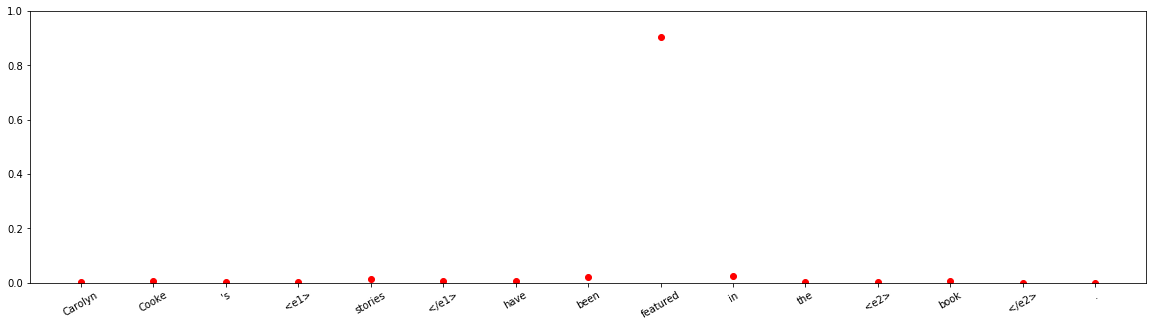









input sentence: Now a faint and lonely <e1> flame </e1> uprises from the <e2> pyre </e2> .
answer label:    Entity-Origin
wrong label:    Cause-Effect
Other 	:	 0.023398208
Cause-Effect 	:	 0.9199374
Component-Whole 	:	 7.0819203e-07
Entity-Destination 	:	 0.000258148
Entity-Origin 	:	 0.056281157
Product-Producer 	:	 6.582149e-05
Member-Collection 	:	 5.8028456e-07
Message-Topic 	:	 3.248127e-07
Content-Container 	:	 2.5675094e-08
Instrument-Agency 	:	 5.779143e-05



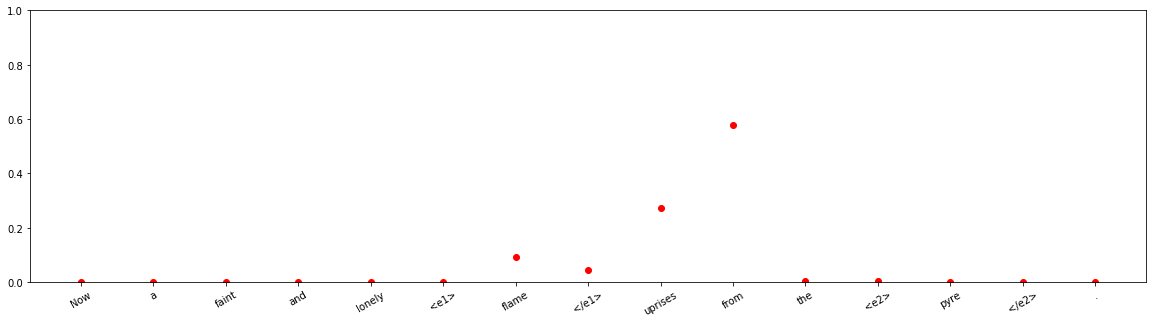






input sentence: The author <e1> index </e1> was generated using the LaTeX authorindex <e2> package </e2> .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 8.9611837e-07
Cause-Effect 	:	 3.6161823e-06
Component-Whole 	:	 6.936775e-07
Entity-Destination 	:	 0.061390035
Entity-Origin 	:	 0.00014763114
Product-Producer 	:	 1.0260125e-06
Member-Collection 	:	 7.4961404e-10
Message-Topic 	:	 1.3258056e-09
Content-Container 	:	 5.9842414e-06
Instrument-Agency 	:	 0.93845004



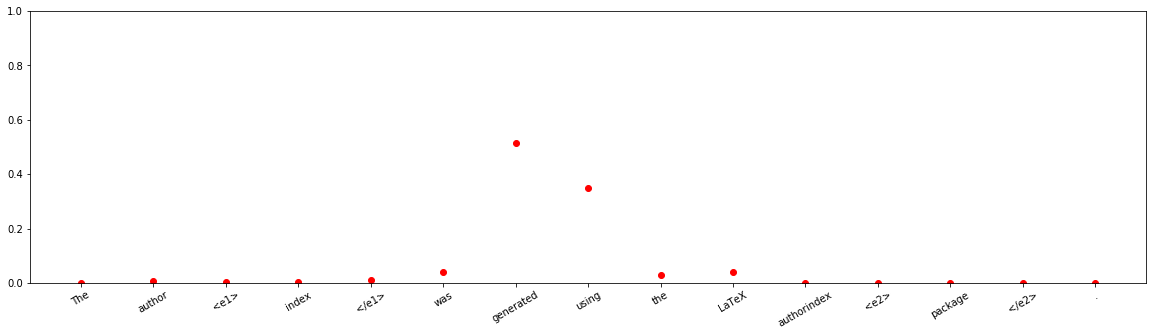



input sentence: 'Wellness ' tracker lures <e1> seniors </e1> to a <e2> data </e2> driven lifestyle .
answer label:    Instrument-Agency
wrong label:    Entity-Destination
Other 	:	 0.0016634162
Cause-Effect 	:	 1.2379904e-09
Component-Whole 	:	 6.167864e-06
Entity-Destination 	:	 0.99785906
Entity-Origin 	:	 7.7871235e-08
Product-Producer 	:	 2.1388387e-06
Member-Collection 	:	 3.975181e-06
Message-Topic 	:	 7.817322e-07
Content-Container 	:	 8.0995403e-07
Instrument-Agency 	:	 0.00046349375



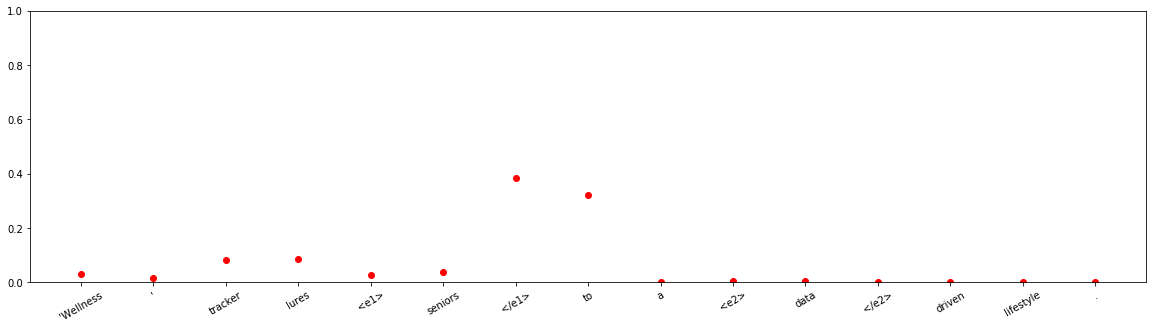




input sentence: The <e1> girls </e1> drank the vodka out of plastic water <e2> bottles </e2> .
answer label:    Instrument-Agency
wrong label:    Content-Container
Other 	:	 3.245476e-08
Cause-Effect 	:	 6.176487e-09
Component-Whole 	:	 3.049618e-07
Entity-Destination 	:	 0.012831099
Entity-Origin 	:	 0.020931445
Product-Producer 	:	 7.664652e-06
Member-Collection 	:	 6.467713e-07
Message-Topic 	:	 1.681952e-07
Content-Container 	:	 0.9651481
Instrument-Agency 	:	 0.0010804728



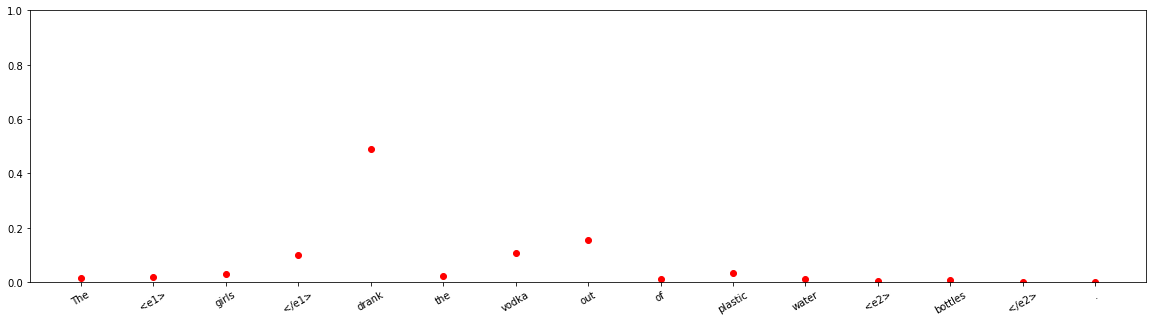













input sentence: Below you find my <e1> ideas </e1> with regard to this <e2> issue </e2> .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.6302079
Cause-Effect 	:	 7.8985135e-10
Component-Whole 	:	 5.7054325e-07
Entity-Destination 	:	 2.656308e-07
Entity-Origin 	:	 7.1614825e-10
Product-Producer 	:	 2.1266043e-08
Member-Collection 	:	 1.1713554e-08
Message-Topic 	:	 0.3697911
Content-Container 	:	 1.8595704e-10
Instrument-Agency 	:	 1.1641373e-07



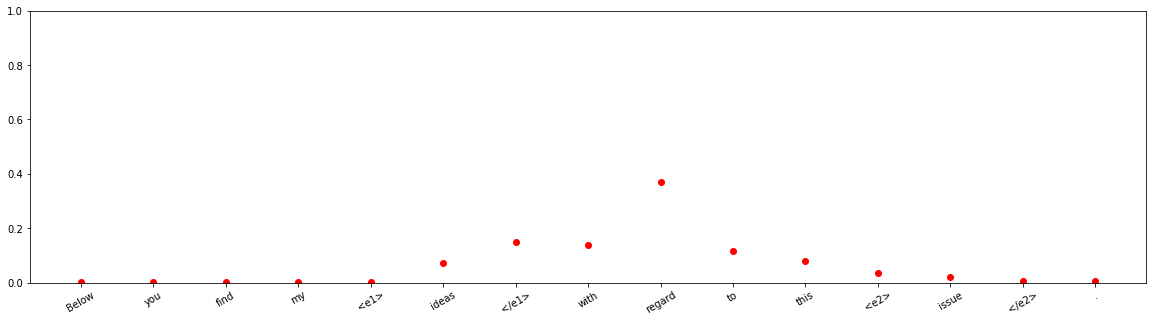


input sentence: Now this <e1> laboratory </e1> also is part of a larger <e2> organisation </e2> .
answer label:    Component-Whole
wrong label:    Member-Collection
Other 	:	 4.6046644e-08
Cause-Effect 	:	 1.0750518e-09
Component-Whole 	:	 0.0026506435
Entity-Destination 	:	 1.6282573e-10
Entity-Origin 	:	 2.1951689e-07
Product-Producer 	:	 6.8202226e-08
Member-Collection 	:	 0.9973152
Message-Topic 	:	 1.0031448e-05
Content-Container 	:	 2.3771248e-05
Instrument-Agency 	:	 1.3126422e-08



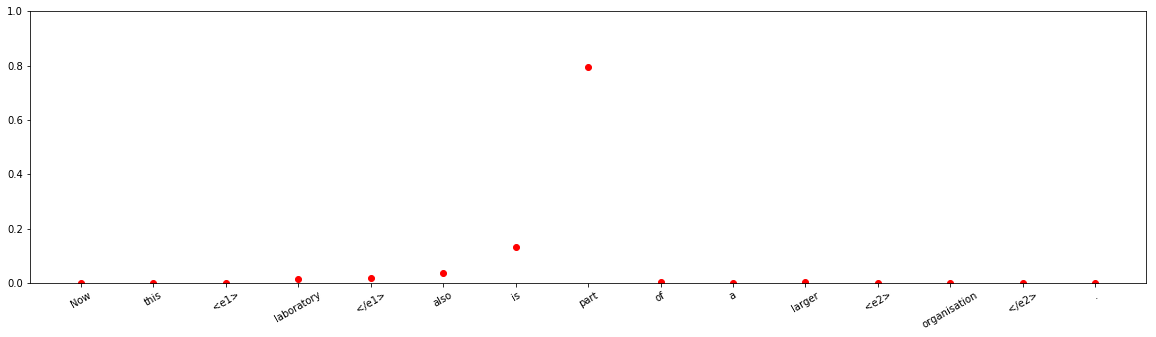



input sentence: A <e1> baby </e1> uses a box of baby <e2> wipes </e2> per week .
answer label:    Instrument-Agency
wrong label:    Content-Container
Other 	:	 1.7631764e-09
Cause-Effect 	:	 6.053263e-09
Component-Whole 	:	 5.387839e-05
Entity-Destination 	:	 1.3080005e-05
Entity-Origin 	:	 2.9299889e-08
Product-Producer 	:	 4.690775e-06
Member-Collection 	:	 1.2064675e-07
Message-Topic 	:	 2.1883036e-08
Content-Container 	:	 0.9997578
Instrument-Agency 	:	 0.00017026963



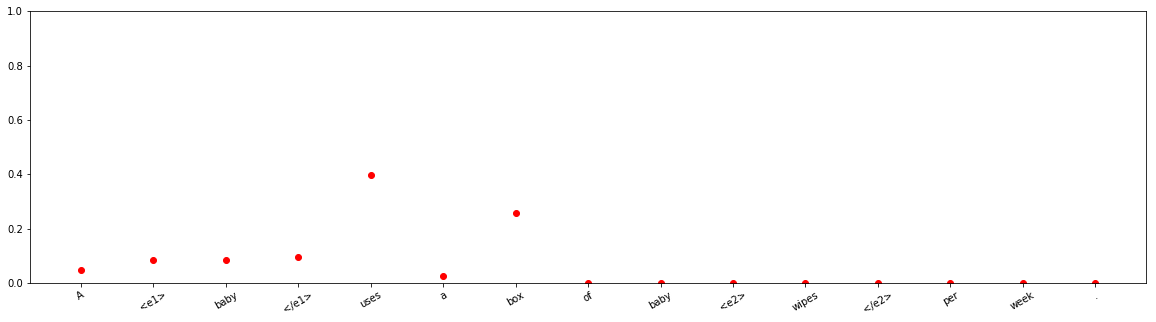







input sentence: Intuitively stack is visualized as indeed a <e1> stack </e1> of <e2> objects </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.75146407
Cause-Effect 	:	 8.9351044e-05
Component-Whole 	:	 0.00018794998
Entity-Destination 	:	 0.00014340361
Entity-Origin 	:	 2.0684682e-05
Product-Producer 	:	 1.758764e-05
Member-Collection 	:	 0.24646936
Message-Topic 	:	 0.0010895177
Content-Container 	:	 0.00046446093
Instrument-Agency 	:	 5.363653e-05



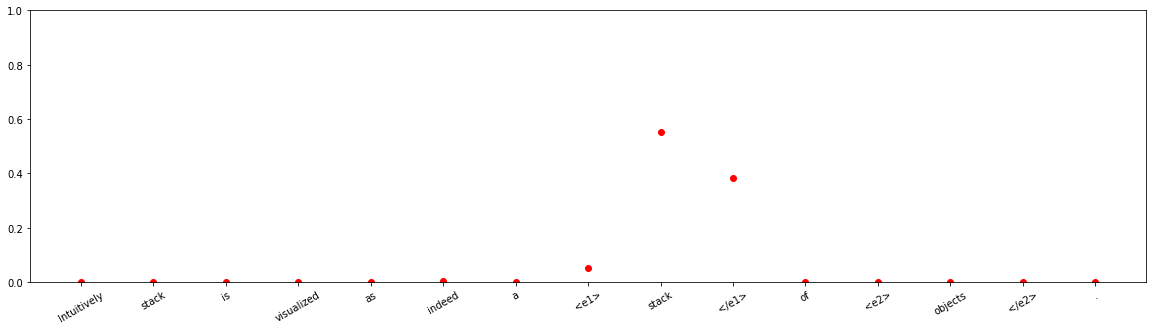





input sentence: This <e1> page </e1> carries a list of some of these <e2> conventions </e2> .
answer label:    Component-Whole
wrong label:    Content-Container
Other 	:	 2.3555762e-05
Cause-Effect 	:	 0.00043759434
Component-Whole 	:	 0.11394948
Entity-Destination 	:	 2.5520329e-05
Entity-Origin 	:	 0.00034546904
Product-Producer 	:	 0.0028913633
Member-Collection 	:	 0.018109594
Message-Topic 	:	 0.005054086
Content-Container 	:	 0.85740775
Instrument-Agency 	:	 0.0017555805



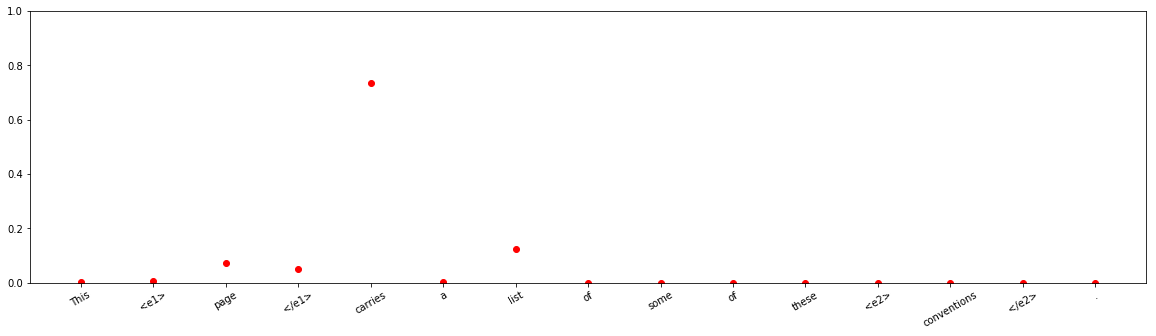








input sentence: Members are primarily interested in <e1> issues </e1> related to family <e2> law </e2> .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 5.9198872e-05
Cause-Effect 	:	 6.378942e-11
Component-Whole 	:	 2.710332e-07
Entity-Destination 	:	 3.743525e-08
Entity-Origin 	:	 1.9155297e-10
Product-Producer 	:	 1.692809e-12
Member-Collection 	:	 9.2558367e-10
Message-Topic 	:	 0.9999405
Content-Container 	:	 2.3671326e-10
Instrument-Agency 	:	 7.9799084e-11



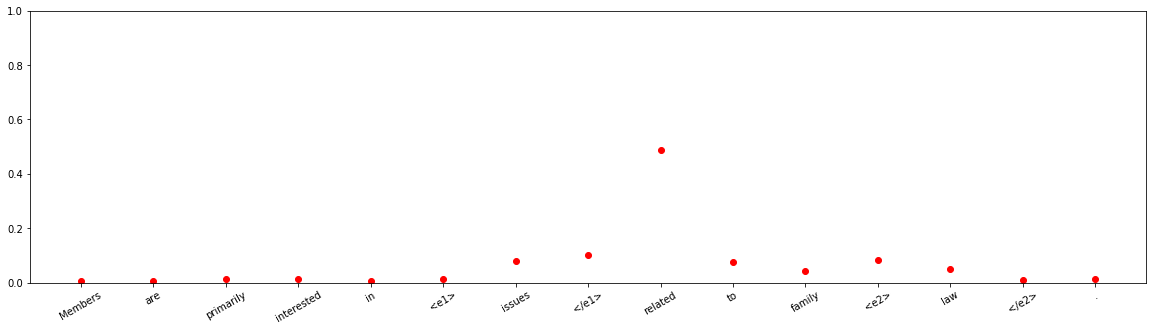




input sentence: Michael Jackson 's FBI <e1> file </e1> consists of about 600 <e2> pages </e2> .
answer label:    Component-Whole
wrong label:    Member-Collection
Other 	:	 8.25235e-07
Cause-Effect 	:	 2.9125081e-08
Component-Whole 	:	 0.024922628
Entity-Destination 	:	 2.3681537e-09
Entity-Origin 	:	 3.6168951e-06
Product-Producer 	:	 3.6619076e-06
Member-Collection 	:	 0.9742889
Message-Topic 	:	 7.7621746e-07
Content-Container 	:	 0.0007790884
Instrument-Agency 	:	 5.131879e-07



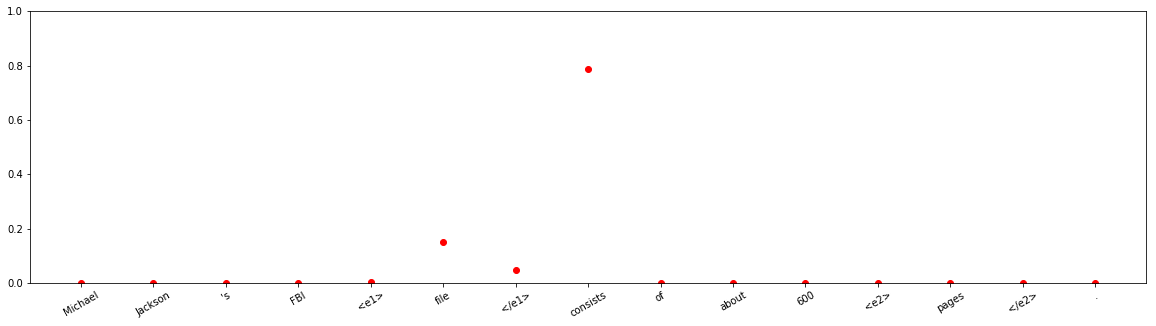








input sentence: EXE is the common <e1> filename extension </e1> denoting an executable <e2> file </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 0.00032868944
Cause-Effect 	:	 1.2649497e-05
Component-Whole 	:	 0.0013728779
Entity-Destination 	:	 0.99696046
Entity-Origin 	:	 7.918647e-06
Product-Producer 	:	 0.0010380811
Member-Collection 	:	 2.4157256e-08
Message-Topic 	:	 3.31258e-07
Content-Container 	:	 0.00013795366
Instrument-Agency 	:	 0.00014087996



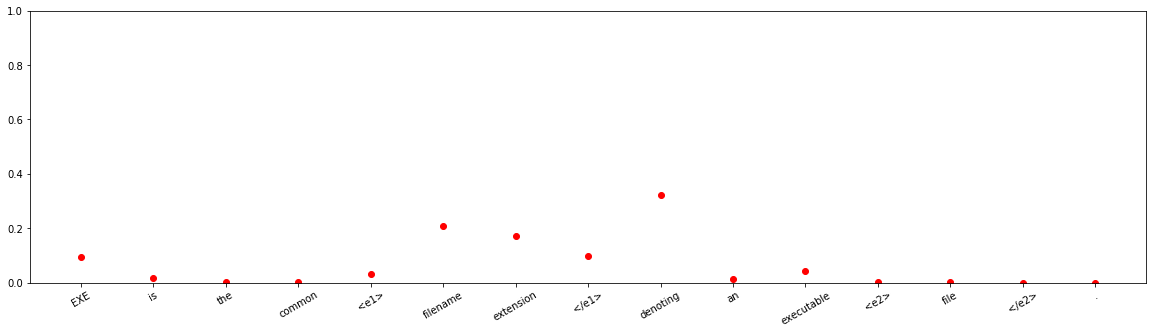



input sentence: All of our <e1> producers </e1> rear <e2> produce </e2> within the New Forest .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 1.7931815e-06
Cause-Effect 	:	 2.1659599e-08
Component-Whole 	:	 6.000496e-11
Entity-Destination 	:	 6.5906985e-10
Entity-Origin 	:	 5.7460817e-08
Product-Producer 	:	 0.99991846
Member-Collection 	:	 4.579887e-10
Message-Topic 	:	 1.7689717e-12
Content-Container 	:	 4.890188e-12
Instrument-Agency 	:	 7.962729e-05



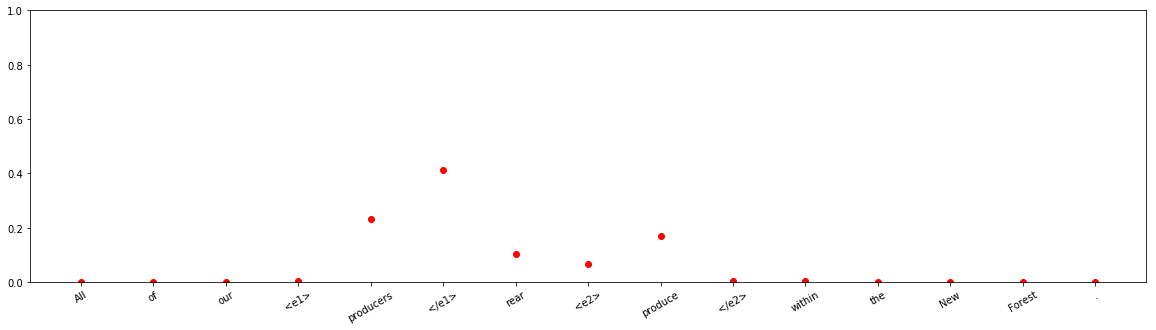






input sentence: Aromatic hydrocarbon-water separations by a <e1> pressure </e1> driven membrane separation <e2> process </e2> .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.9966794
Cause-Effect 	:	 0.0033204826
Component-Whole 	:	 4.743547e-09
Entity-Destination 	:	 2.2058898e-10
Entity-Origin 	:	 2.1386346e-09
Product-Producer 	:	 5.323457e-12
Member-Collection 	:	 1.465952e-09
Message-Topic 	:	 6.253333e-08
Content-Container 	:	 2.361201e-13
Instrument-Agency 	:	 1.6153926e-08



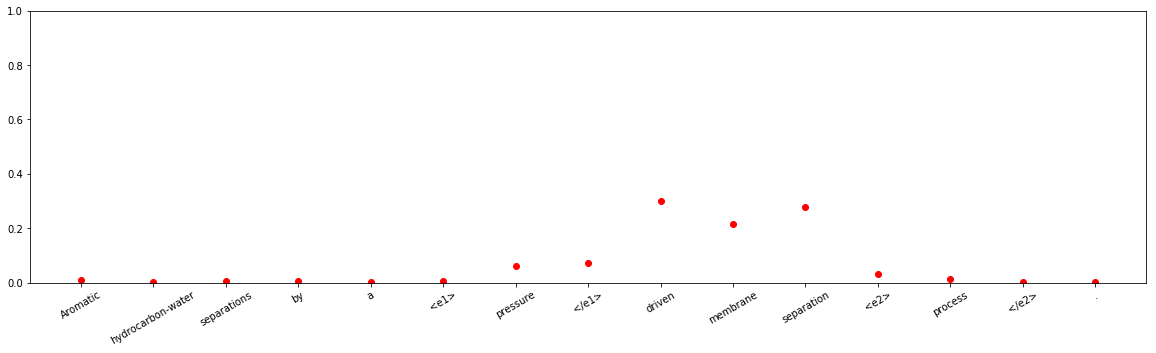















input sentence: Their parental <e1> responsibilities </e1> are handed over into another 's <e2> care </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.9999919
Cause-Effect 	:	 3.9607162e-10
Component-Whole 	:	 1.8583271e-10
Entity-Destination 	:	 8.118095e-06
Entity-Origin 	:	 1.1619492e-10
Product-Producer 	:	 5.7796446e-12
Member-Collection 	:	 1.7704763e-11
Message-Topic 	:	 2.9402982e-09
Content-Container 	:	 9.224684e-12
Instrument-Agency 	:	 8.7383956e-10



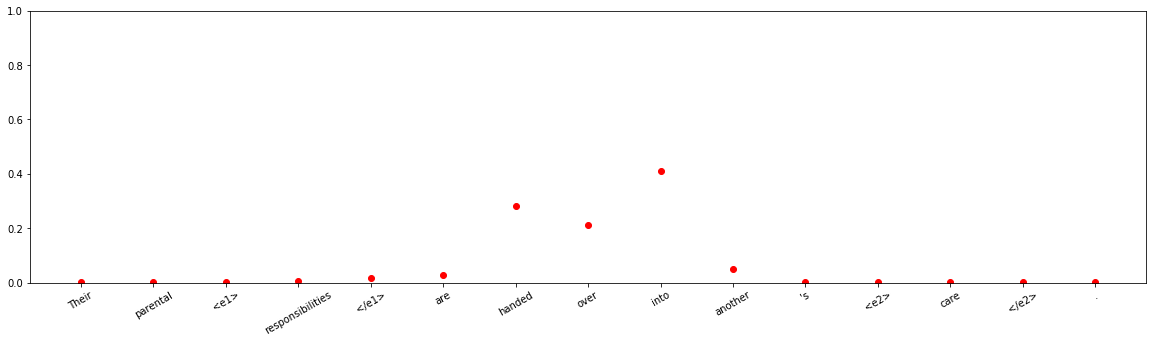


input sentence: <e1> Mothers </e1> were the single largest group to donate their <e2> kidneys </e2> .
answer label:    Entity-Origin
wrong label:    Entity-Destination
Other 	:	 1.0316289e-06
Cause-Effect 	:	 5.482778e-10
Component-Whole 	:	 2.3728446e-06
Entity-Destination 	:	 0.99535
Entity-Origin 	:	 5.2258565e-07
Product-Producer 	:	 0.00025601845
Member-Collection 	:	 1.6260801e-06
Message-Topic 	:	 1.790497e-08
Content-Container 	:	 1.5173047e-06
Instrument-Agency 	:	 0.00438675



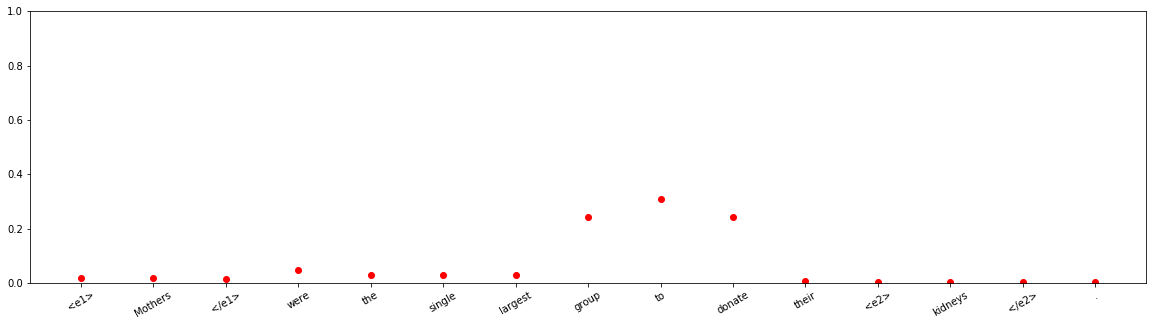




input sentence: My <e1> husband </e1> returned a $ 275 cashmere <e2> sweater </e2> to Jos .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.052016128
Cause-Effect 	:	 6.3152976e-07
Component-Whole 	:	 4.242535e-07
Entity-Destination 	:	 0.3188476
Entity-Origin 	:	 0.0052366103
Product-Producer 	:	 0.56649077
Member-Collection 	:	 0.00013308438
Message-Topic 	:	 8.906375e-08
Content-Container 	:	 0.051933594
Instrument-Agency 	:	 0.005341115



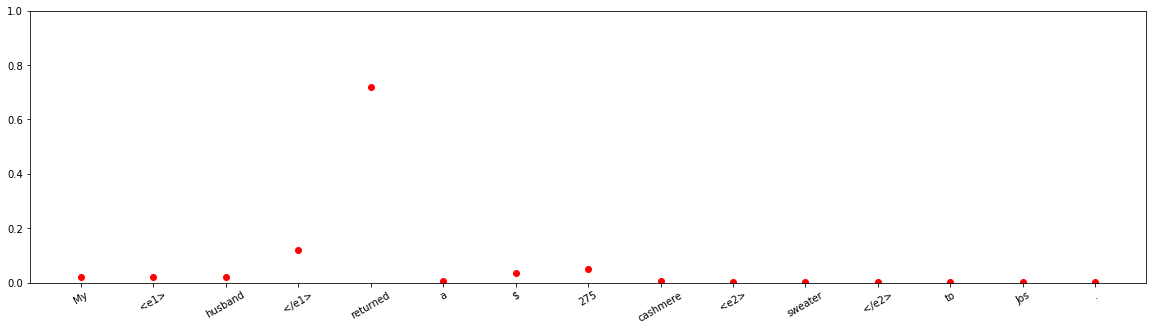




input sentence: The ultimate <e1> mystery </e1> is the source of the <e2> energy </e2> itself .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 0.3808774
Cause-Effect 	:	 0.20586367
Component-Whole 	:	 4.93044e-07
Entity-Destination 	:	 2.6626893e-05
Entity-Origin 	:	 0.41318727
Product-Producer 	:	 5.5041335e-07
Member-Collection 	:	 1.7533712e-07
Message-Topic 	:	 1.5115329e-06
Content-Container 	:	 1.3816681e-07
Instrument-Agency 	:	 4.2192525e-05



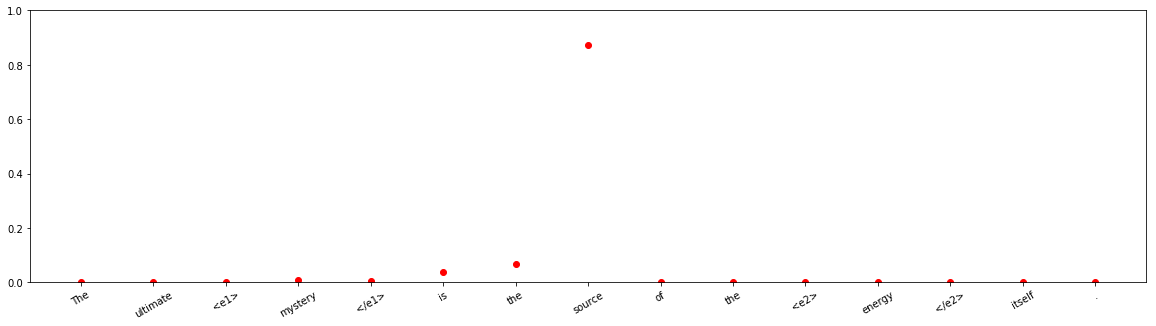






input sentence: <e1> Shampoos </e1> work by using <e2> acid </e2> to remove hard water scale .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 2.5687163e-05
Cause-Effect 	:	 1.0889841e-09
Component-Whole 	:	 1.3293979e-07
Entity-Destination 	:	 2.9785154e-09
Entity-Origin 	:	 8.352608e-09
Product-Producer 	:	 0.00048059397
Member-Collection 	:	 2.6236544e-11
Message-Topic 	:	 1.0792711e-10
Content-Container 	:	 4.2619266e-11
Instrument-Agency 	:	 0.9994936



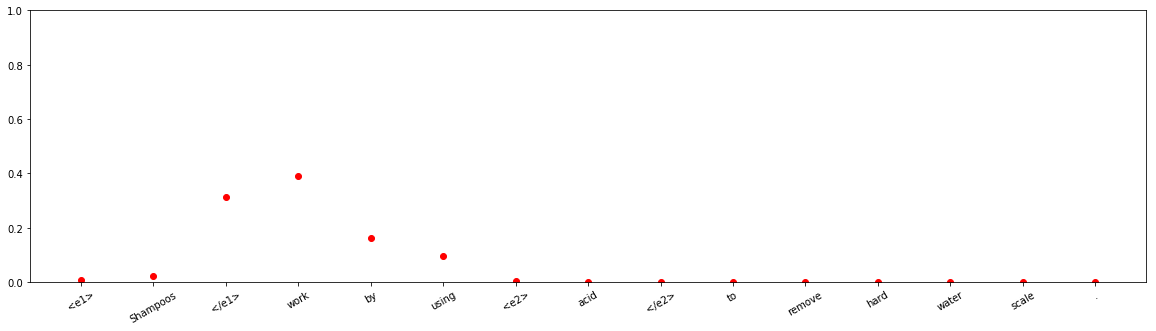













input sentence: The only <e1> escape </e1> I had now was in a <e2> bottle </e2> .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.017332708
Cause-Effect 	:	 2.360422e-06
Component-Whole 	:	 6.497671e-05
Entity-Destination 	:	 0.35003287
Entity-Origin 	:	 5.732195e-05
Product-Producer 	:	 1.1973957e-07
Member-Collection 	:	 4.0366814e-07
Message-Topic 	:	 0.000553434
Content-Container 	:	 0.63192916
Instrument-Agency 	:	 2.6654921e-05



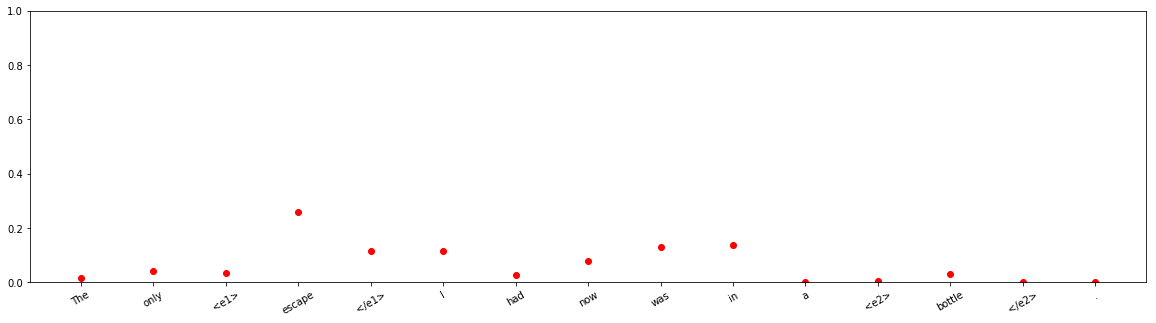




input sentence: <e1> Danger </e1> is part of the Palestinian journalist 's daily <e2> routine </e2> .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.009934985
Cause-Effect 	:	 0.0028986665
Component-Whole 	:	 0.98701394
Entity-Destination 	:	 5.8779583e-06
Entity-Origin 	:	 5.667592e-07
Product-Producer 	:	 6.6592587e-10
Member-Collection 	:	 8.4869e-06
Message-Topic 	:	 3.7820987e-06
Content-Container 	:	 1.5436606e-07
Instrument-Agency 	:	 0.00013352004



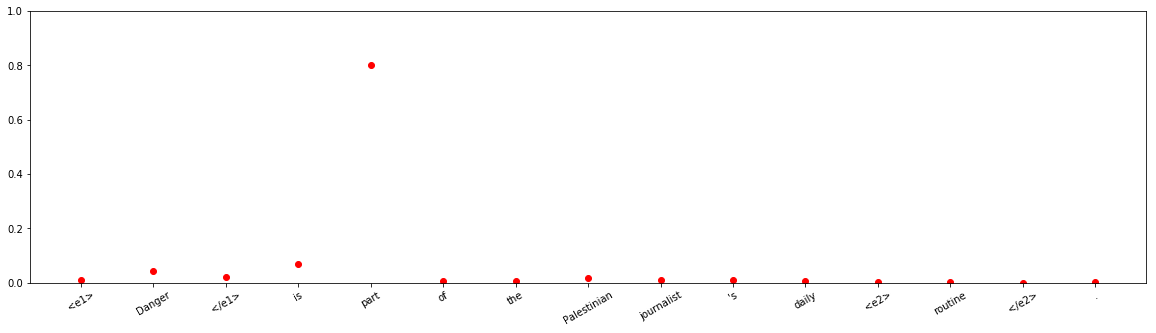







input sentence: 'We were n't sure how high we could go ' , said Bill Baker of Skidmore , Owings & Merrill , the <e1> building </e1> 's structural <e2> engineer </e2> .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.5913622
Cause-Effect 	:	 0.0007769354
Component-Whole 	:	 2.451289e-06
Entity-Destination 	:	 1.3232472e-09
Entity-Origin 	:	 2.9639926e-08
Product-Producer 	:	 0.40771177
Member-Collection 	:	 1.480484e-08
Message-Topic 	:	 4.2800696e-07
Content-Container 	:	 5.5062524e-11
Instrument-Agency 	:	 0.00014620533



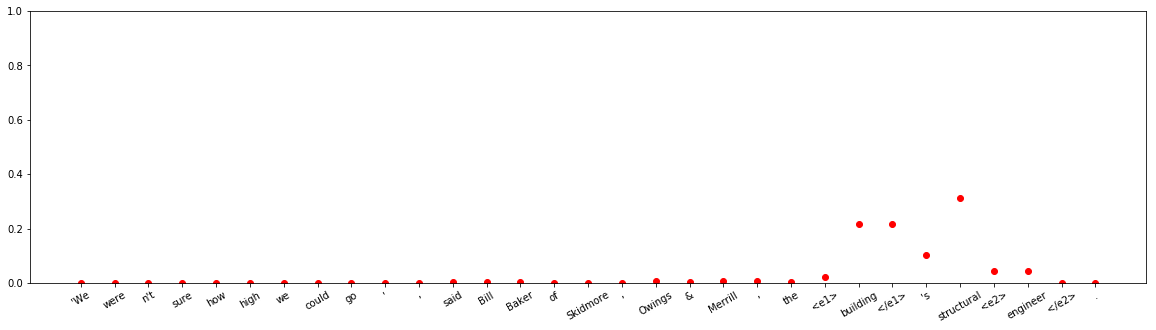









input sentence: An African <e1> immigrant </e1> arrives on board a rescue boat at the <e2> port </e2> of Los Cristianos on Spain 's Canary island of Tenerife October 17 , 2008 .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 2.2184418e-05
Cause-Effect 	:	 1.2646003e-09
Component-Whole 	:	 1.1713726e-05
Entity-Destination 	:	 0.87842655
Entity-Origin 	:	 0.09123525
Product-Producer 	:	 1.0614531e-05
Member-Collection 	:	 0.00018588717
Message-Topic 	:	 6.0938805e-07
Content-Container 	:	 0.0042228354
Instrument-Agency 	:	 0.025884423



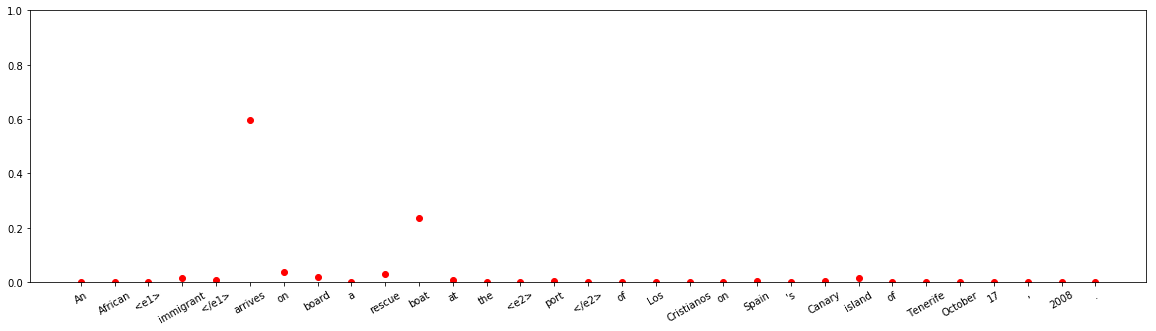












input sentence: The Polish Competition Authority condemns a <e1> producer </e1> of paid TV <e2> programs </e2> for abusing of its dominant position in the licensing agreement with the cable TV operator .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.88583595
Cause-Effect 	:	 4.1673155e-07
Component-Whole 	:	 1.454677e-05
Entity-Destination 	:	 8.001726e-06
Entity-Origin 	:	 3.4983364e-06
Product-Producer 	:	 0.0556896
Member-Collection 	:	 0.0010772871
Message-Topic 	:	 1.8317898e-05
Content-Container 	:	 8.105883e-08
Instrument-Agency 	:	 0.057352237



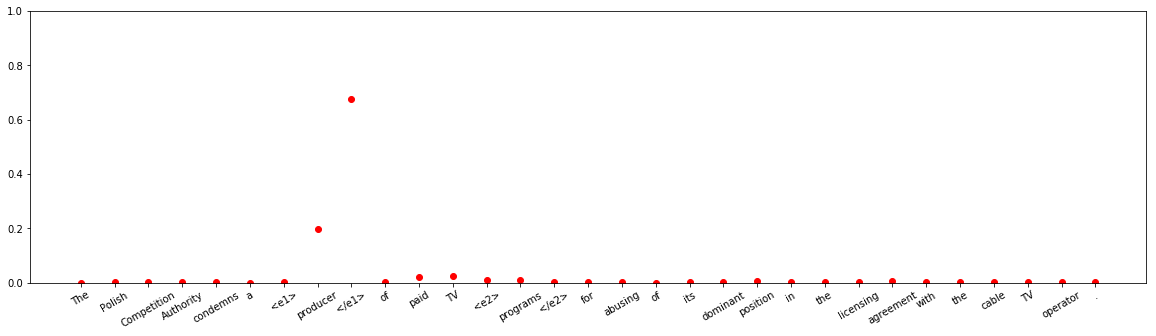









input sentence: The oak <e1> tree </e1> was growing in the <e2> woods </e2> of the Longleat Estate , in Wiltshire , at the time Darwin was alive and developing his theory .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.99997866
Cause-Effect 	:	 2.1038842e-08
Component-Whole 	:	 2.0876461e-05
Entity-Destination 	:	 1.1248908e-09
Entity-Origin 	:	 2.4913197e-08
Product-Producer 	:	 7.161061e-11
Member-Collection 	:	 2.1986313e-09
Message-Topic 	:	 5.0819693e-07
Content-Container 	:	 7.175968e-10
Instrument-Agency 	:	 4.827023e-11



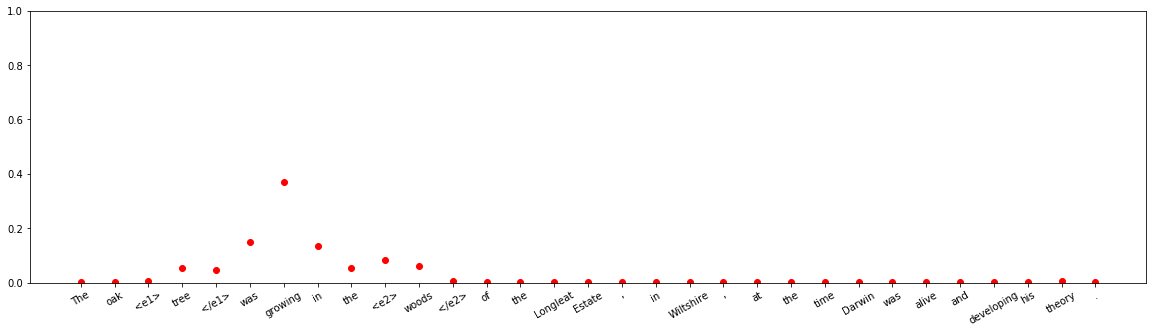



input sentence: The above <e1> chart </e1> , produced by a <e2> study </e2> at the Weizmann Institute of Science in Israel , shows our reactions to different smells along two axes .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 1.8500756e-06
Cause-Effect 	:	 7.953218e-06
Component-Whole 	:	 5.441915e-09
Entity-Destination 	:	 3.6589926e-11
Entity-Origin 	:	 2.244633e-08
Product-Producer 	:	 0.99998665
Member-Collection 	:	 4.2896576e-12
Message-Topic 	:	 8.56182e-10
Content-Container 	:	 7.951015e-11
Instrument-Agency 	:	 3.523882e-06



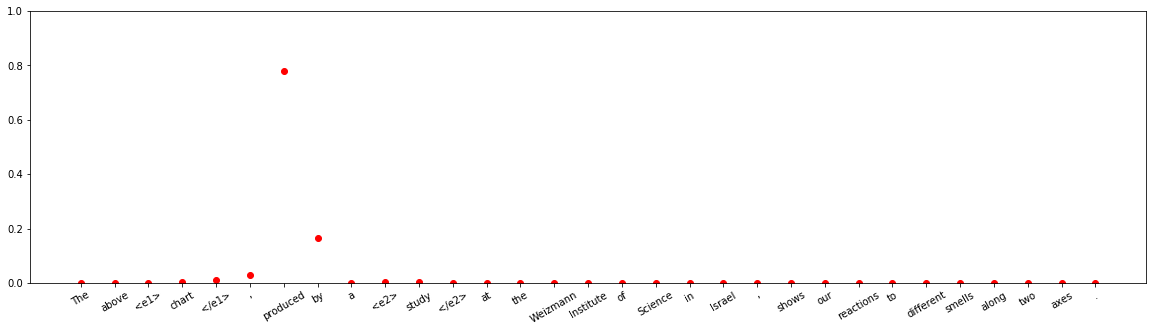


input sentence: Marking birds with color <e1> bands </e1> and a U.S . Fish and Wildlife Service uniquely numbered metal band enables <e2> researchers </e2> to follow individuals from year to year .
answer label:    Instrument-Agency
wrong label:    Product-Producer
Other 	:	 0.00063869136
Cause-Effect 	:	 1.6019696e-06
Component-Whole 	:	 0.005217181
Entity-Destination 	:	 6.968109e-06
Entity-Origin 	:	 3.6580124e-07
Product-Producer 	:	 0.62718016
Member-Collection 	:	 4.5203476e-05
Message-Topic 	:	 1.2594454e-06
Content-Container 	:	 1.0044703e-07
Instrument-Agency 	:	 0.3669085



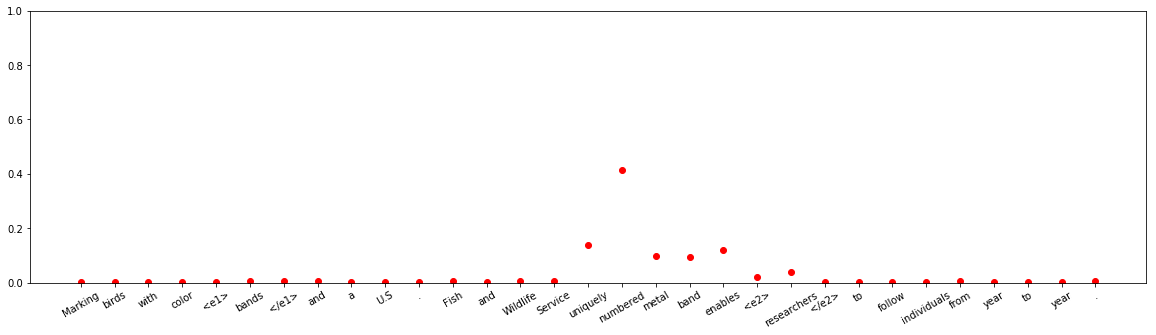




input sentence: Within minutes of last night 's terrorist attacks in Mumbai in India , <e1> blogs </e1> and social networks were buzzing with <e2> news </e2> , photos and eyewitness accounts .
answer label:    Component-Whole
wrong label:    Cause-Effect
Other 	:	 0.18151684
Cause-Effect 	:	 0.5637642
Component-Whole 	:	 7.669422e-05
Entity-Destination 	:	 1.4694209e-06
Entity-Origin 	:	 0.0007122111
Product-Producer 	:	 0.0066380124
Member-Collection 	:	 0.0029065434
Message-Topic 	:	 0.13469486
Content-Container 	:	 3.0450447e-06
Instrument-Agency 	:	 0.10968618



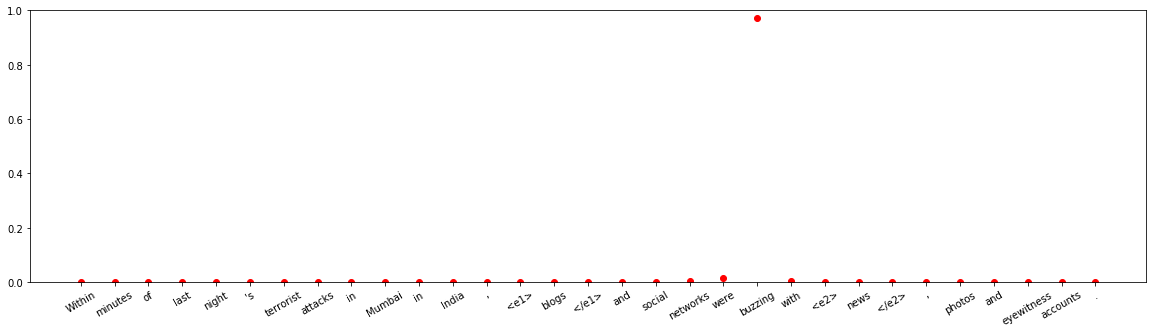





input sentence: Venous insufficiency ( a failure of the valves in the <e1> veins </e1> of the <e2> leg </e2> that causes congestion and slowing of blood circulation in the veins ) .
answer label:    Component-Whole
wrong label:    Cause-Effect
Other 	:	 0.052347977
Cause-Effect 	:	 0.9296687
Component-Whole 	:	 0.017964646
Entity-Destination 	:	 4.3564977e-08
Entity-Origin 	:	 2.7263125e-06
Product-Producer 	:	 6.25058e-08
Member-Collection 	:	 2.7328971e-07
Message-Topic 	:	 1.8007456e-06
Content-Container 	:	 7.2672717e-09
Instrument-Agency 	:	 1.3822837e-05



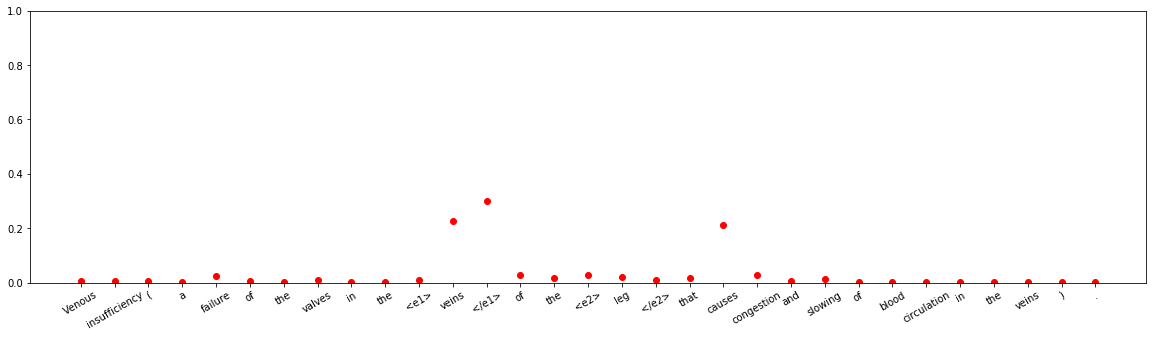




input sentence: The <e1> evangelist </e1> blasts the patrons with the <e2> news </e2> that they 're going to hell , if they do n't come to his meeting and get saved .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.00021826678
Cause-Effect 	:	 2.2825012e-07
Component-Whole 	:	 1.6896275e-08
Entity-Destination 	:	 6.773848e-08
Entity-Origin 	:	 1.4566195e-08
Product-Producer 	:	 0.0033084794
Member-Collection 	:	 1.2159704e-07
Message-Topic 	:	 8.3870555e-10
Content-Container 	:	 8.136093e-12
Instrument-Agency 	:	 0.9964728



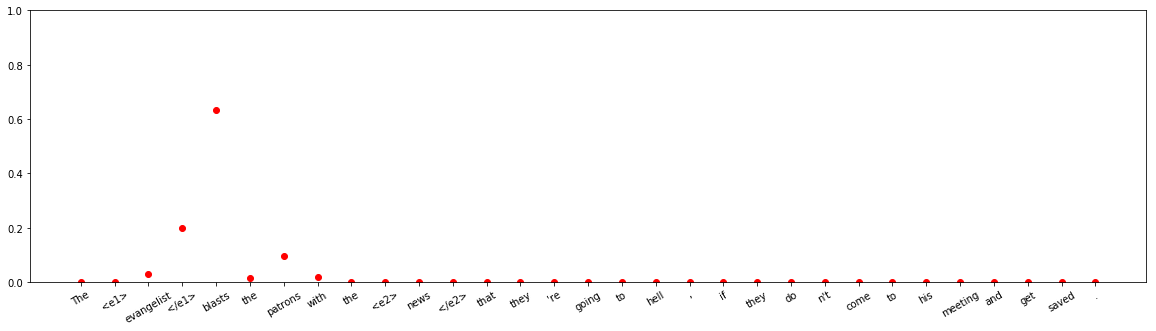









input sentence: We observed that a <e1> box </e1> was actually placed inside the <e2> cornerstone </e2> with a variety of artifacts and documents commemorating the event and the history of Savannah .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 0.12108933
Cause-Effect 	:	 3.4468266e-09
Component-Whole 	:	 3.8679627e-06
Entity-Destination 	:	 0.87879425
Entity-Origin 	:	 2.0516625e-05
Product-Producer 	:	 2.1757196e-09
Member-Collection 	:	 8.856713e-09
Message-Topic 	:	 3.9597116e-06
Content-Container 	:	 8.79646e-05
Instrument-Agency 	:	 5.5800236e-09



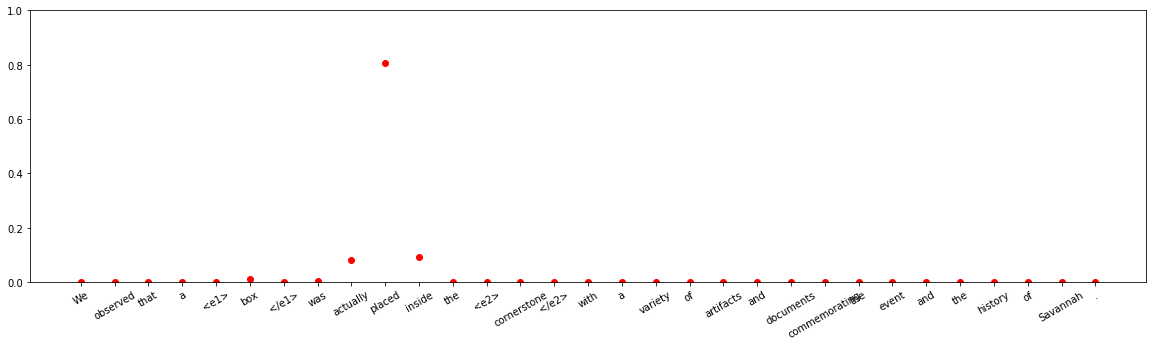


input sentence: One ounce of pure <e1> gold </e1> was sealed in a <e2> quartz tube </e2> and a section of 5-mm inside diameter quartz tube was sealed on the quartz-gold tube .
answer label:    Entity-Destination
wrong label:    Content-Container
Other 	:	 2.0330857e-05
Cause-Effect 	:	 1.14429306e-10
Component-Whole 	:	 3.325194e-08
Entity-Destination 	:	 0.072496064
Entity-Origin 	:	 1.3381492e-05
Product-Producer 	:	 2.7989845e-11
Member-Collection 	:	 9.222752e-08
Message-Topic 	:	 3.6284789e-09
Content-Container 	:	 0.9274701
Instrument-Agency 	:	 1.1058808e-09



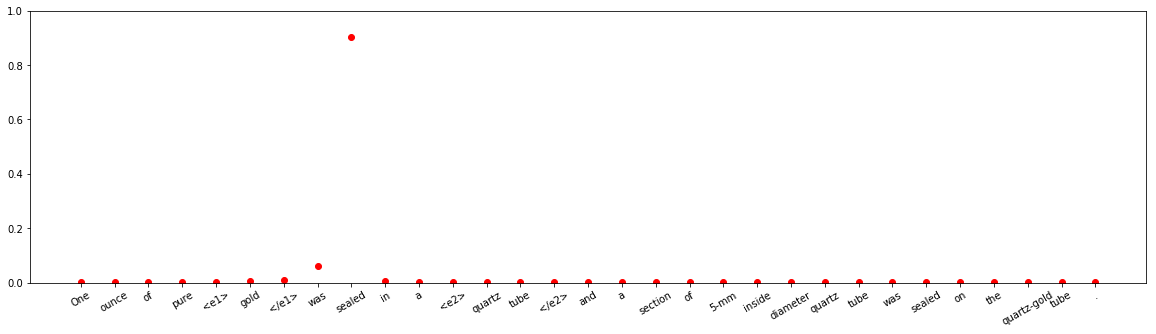











input sentence: <e1> Asteroid </e1> threatened Earth with <e2> disaster </e2> .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.0008023939
Cause-Effect 	:	 0.99919516
Component-Whole 	:	 2.059312e-11
Entity-Destination 	:	 1.3076958e-07
Entity-Origin 	:	 1.9362697e-06
Product-Producer 	:	 2.5268614e-09
Member-Collection 	:	 2.4580814e-08
Message-Topic 	:	 1.4715353e-08
Content-Container 	:	 4.8560104e-11
Instrument-Agency 	:	 4.391821e-07



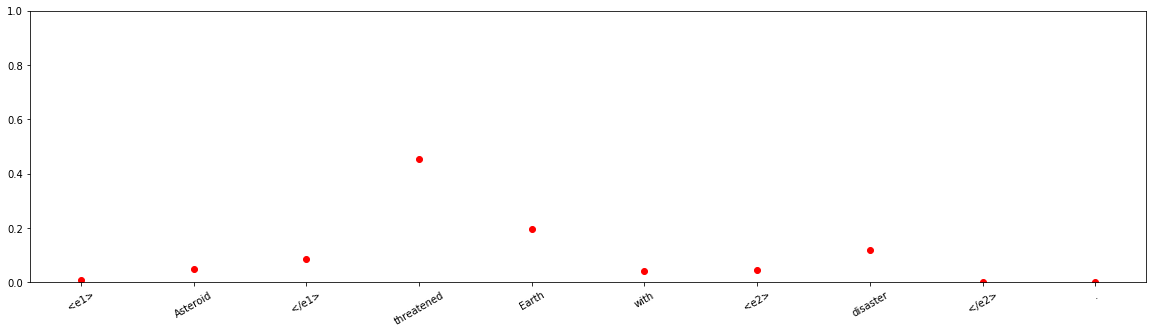

















input sentence: A work of the United States government , as defined by United States copyright law , is `` a <e1> work </e1> prepared by an officer or <e2> employee </e2> of the U.S. government as part of that person 's official duties . ''
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.96910983
Cause-Effect 	:	 2.9116645e-06
Component-Whole 	:	 1.6254138e-07
Entity-Destination 	:	 2.2019998e-08
Entity-Origin 	:	 4.196257e-08
Product-Producer 	:	 0.014806536
Member-Collection 	:	 3.3103714e-07
Message-Topic 	:	 4.2179005e-07
Content-Container 	:	 4.4121804e-09
Instrument-Agency 	:	 0.016079864



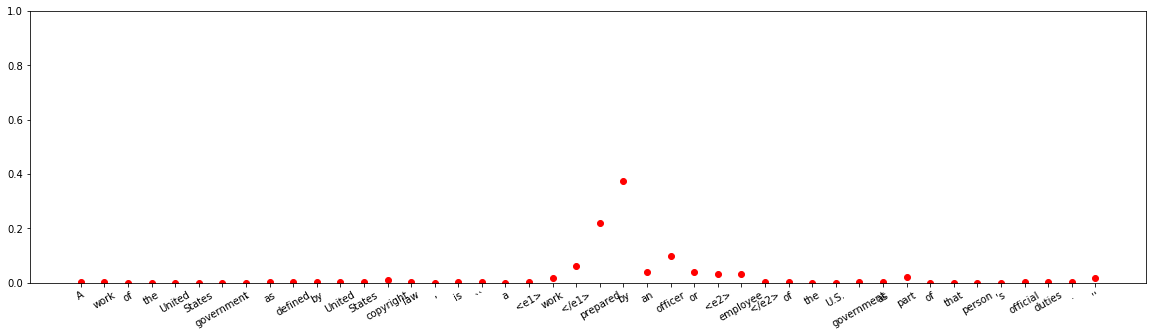


input sentence: That being said , I do love the game and play it all the time but would appreciate a little less <e1> frustration </e1> from programming and <e2> debugging </e2> , and sticking strictly with the frustration that comes from hitting bad shots .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.8340382
Cause-Effect 	:	 0.16593167
Component-Whole 	:	 1.700855e-06
Entity-Destination 	:	 1.3642331e-09
Entity-Origin 	:	 1.9830915e-07
Product-Producer 	:	 7.564926e-10
Member-Collection 	:	 3.6290512e-08
Message-Topic 	:	 1.7935074e-05
Content-Container 	:	 1.7251238e-10
Instrument-Agency 	:	 1.0331681e-05



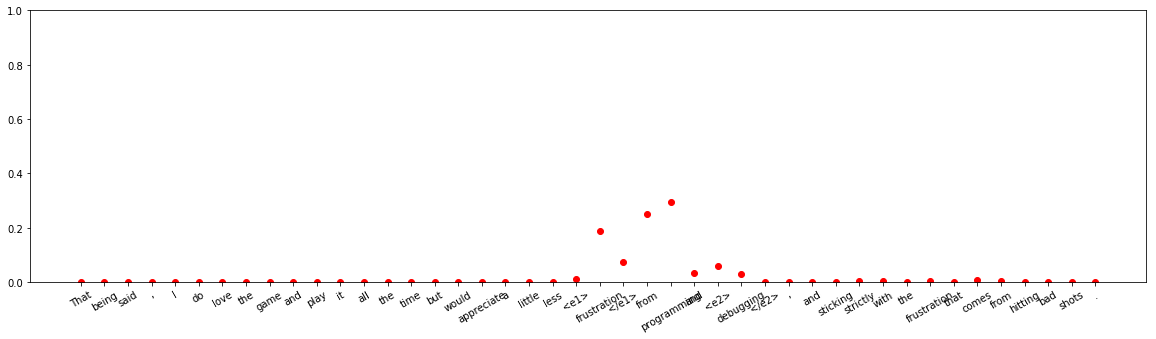





input sentence: These <e1> attributes </e1> are inherited to their <e2> children </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.99908173
Cause-Effect 	:	 1.5680179e-08
Component-Whole 	:	 7.1639693e-06
Entity-Destination 	:	 0.0009072669
Entity-Origin 	:	 6.407871e-08
Product-Producer 	:	 2.8022017e-08
Member-Collection 	:	 2.3418754e-09
Message-Topic 	:	 1.6576329e-06
Content-Container 	:	 3.8516364e-11
Instrument-Agency 	:	 1.9881902e-06



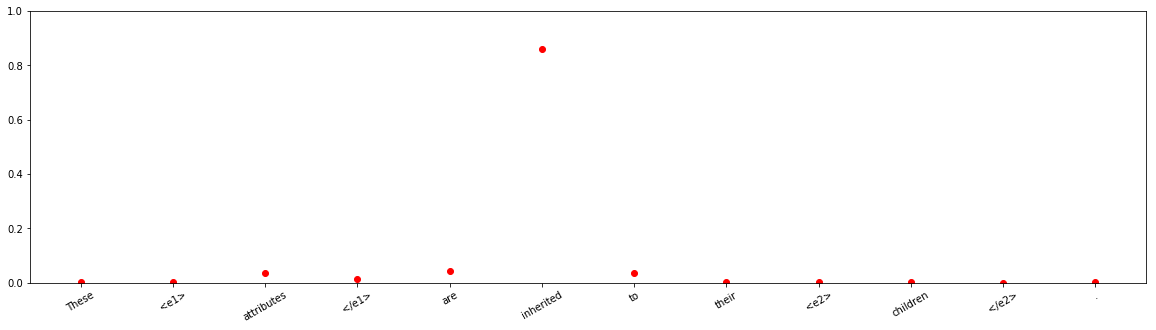










input sentence: The numismatic <e1> topics </e1> were placed into <e2> categories </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.9591033
Cause-Effect 	:	 2.5113502e-09
Component-Whole 	:	 1.2025104e-07
Entity-Destination 	:	 0.038315445
Entity-Origin 	:	 0.0005068527
Product-Producer 	:	 1.3357647e-08
Member-Collection 	:	 8.7791896e-10
Message-Topic 	:	 0.0020740668
Content-Container 	:	 1.5053087e-07
Instrument-Agency 	:	 8.098875e-08



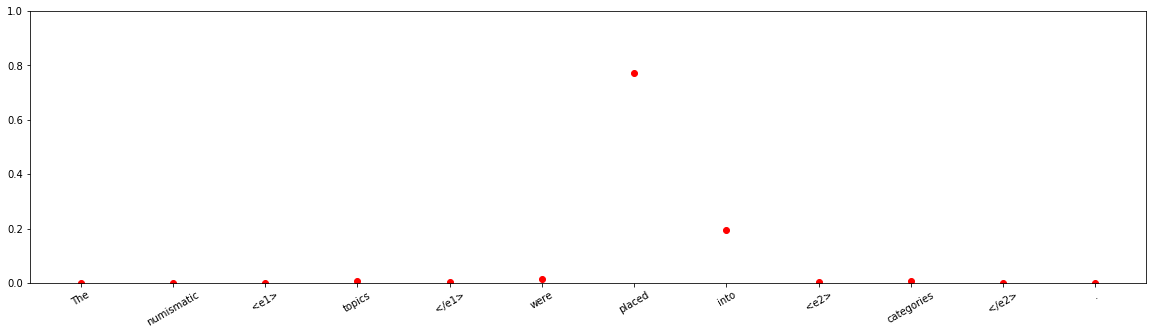

















input sentence: The <e1> archive </e1> contains reviews from previous <e2> months </e2> .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 6.993395e-05
Cause-Effect 	:	 3.9906586e-06
Component-Whole 	:	 0.037652638
Entity-Destination 	:	 4.3198997e-06
Entity-Origin 	:	 0.96155626
Product-Producer 	:	 9.1506416e-07
Member-Collection 	:	 3.5852631e-06
Message-Topic 	:	 7.059708e-05
Content-Container 	:	 0.00063689676
Instrument-Agency 	:	 9.655322e-07



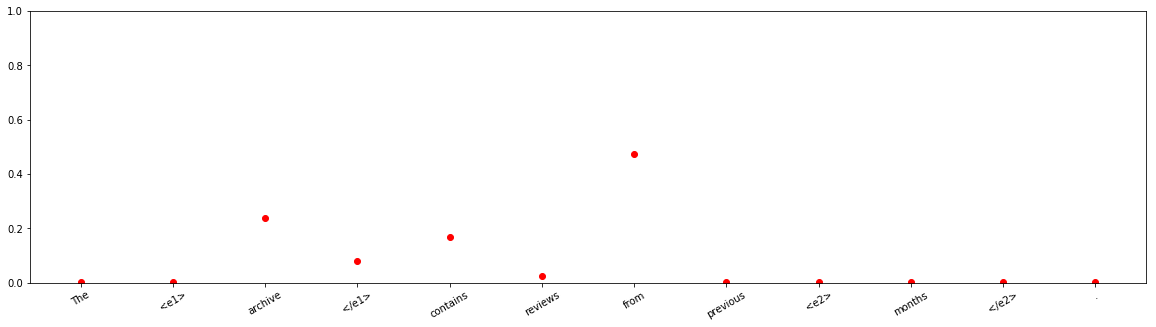




input sentence: A <e1> cigarette </e1> set off a smoke <e2> alarm </e2> .
answer label:    Cause-Effect
wrong label:    Component-Whole
Other 	:	 1.4546981e-08
Cause-Effect 	:	 0.00041766497
Component-Whole 	:	 0.98816013
Entity-Destination 	:	 1.08971456e-07
Entity-Origin 	:	 3.3699234e-08
Product-Producer 	:	 4.580939e-09
Member-Collection 	:	 0.00022145738
Message-Topic 	:	 5.0465385e-08
Content-Container 	:	 0.010480583
Instrument-Agency 	:	 0.0007199916



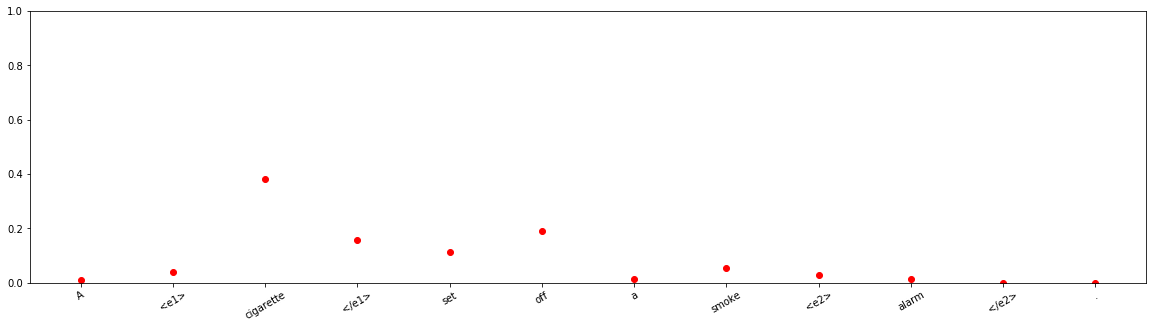


input sentence: <e1> Rumors </e1> have been leaked to the <e2> public </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 2.3443663e-09
Cause-Effect 	:	 1.148044e-10
Component-Whole 	:	 1.9034722e-08
Entity-Destination 	:	 0.9999994
Entity-Origin 	:	 4.1970002e-10
Product-Producer 	:	 1.0497325e-12
Member-Collection 	:	 8.5988703e-13
Message-Topic 	:	 6.537167e-07
Content-Container 	:	 4.9569476e-10
Instrument-Agency 	:	 2.4815944e-10



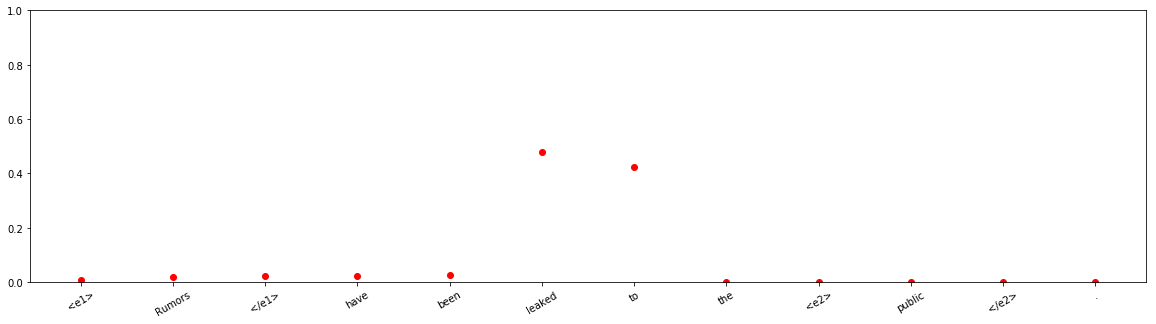



input sentence: My <e1> answer </e1> came in the last <e2> paragraph </e2> .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 2.2723656e-05
Cause-Effect 	:	 7.843531e-05
Component-Whole 	:	 1.2208914e-06
Entity-Destination 	:	 0.32020858
Entity-Origin 	:	 0.183976
Product-Producer 	:	 0.046730194
Member-Collection 	:	 1.1301467e-05
Message-Topic 	:	 0.3757207
Content-Container 	:	 0.07325028
Instrument-Agency 	:	 5.5977887e-07



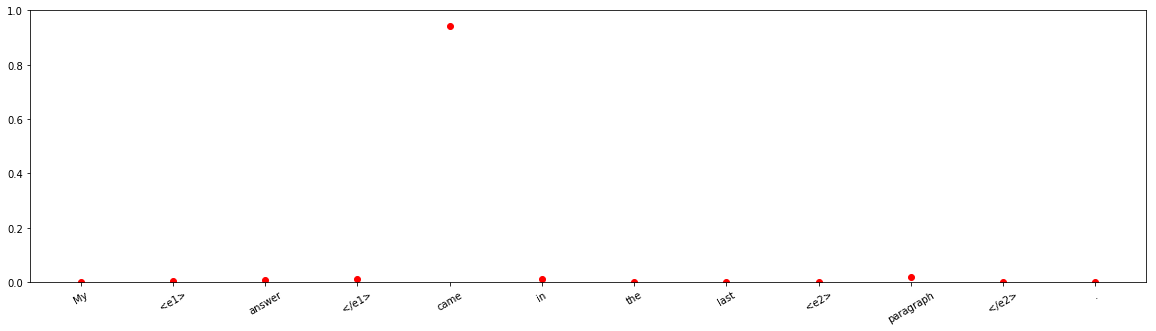






input sentence: Parent <e1> verbalizations </e1> were focused on story-relevant <e2> questions </e2> .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.7484039
Cause-Effect 	:	 6.8590434e-06
Component-Whole 	:	 2.6080125e-09
Entity-Destination 	:	 5.956867e-09
Entity-Origin 	:	 5.616669e-10
Product-Producer 	:	 4.59792e-11
Member-Collection 	:	 3.050534e-10
Message-Topic 	:	 0.25158924
Content-Container 	:	 1.7596589e-12
Instrument-Agency 	:	 5.799395e-10



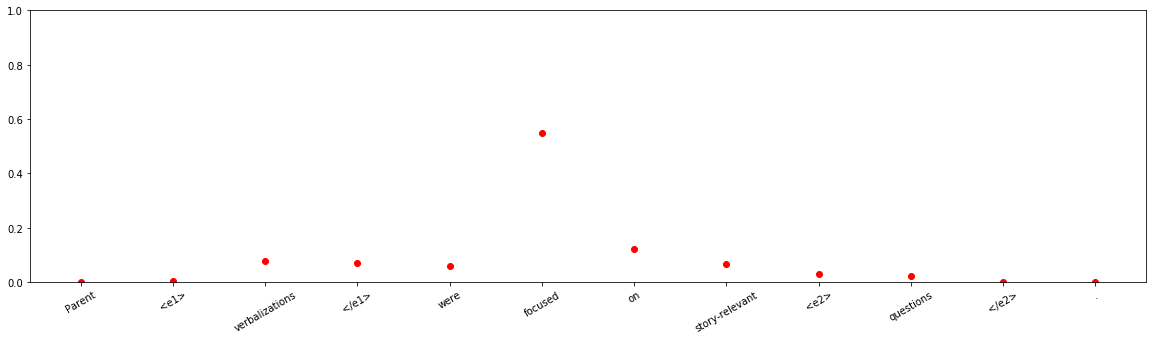




input sentence: The <e1> conference </e1> was organised around four <e2> roundtables </e2> .
answer label:    Component-Whole
wrong label:    Message-Topic
Other 	:	 5.0333355e-08
Cause-Effect 	:	 1.9059735e-11
Component-Whole 	:	 7.043424e-05
Entity-Destination 	:	 7.8047094e-08
Entity-Origin 	:	 5.2487734e-09
Product-Producer 	:	 2.7585227e-09
Member-Collection 	:	 1.2310758e-06
Message-Topic 	:	 0.9999161
Content-Container 	:	 1.2171936e-05
Instrument-Agency 	:	 7.3399536e-10



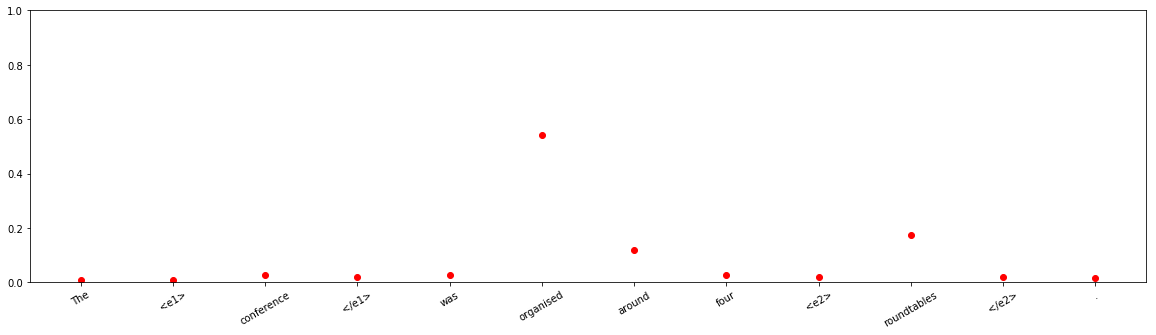





input sentence: He gave two <e1> candies </e1> to each <e2> child </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.9707647
Cause-Effect 	:	 3.5752437e-05
Component-Whole 	:	 0.00087036786
Entity-Destination 	:	 0.028174296
Entity-Origin 	:	 4.224817e-05
Product-Producer 	:	 1.3220419e-07
Member-Collection 	:	 2.6614694e-06
Message-Topic 	:	 3.877672e-05
Content-Container 	:	 5.9719987e-05
Instrument-Agency 	:	 1.1323047e-05



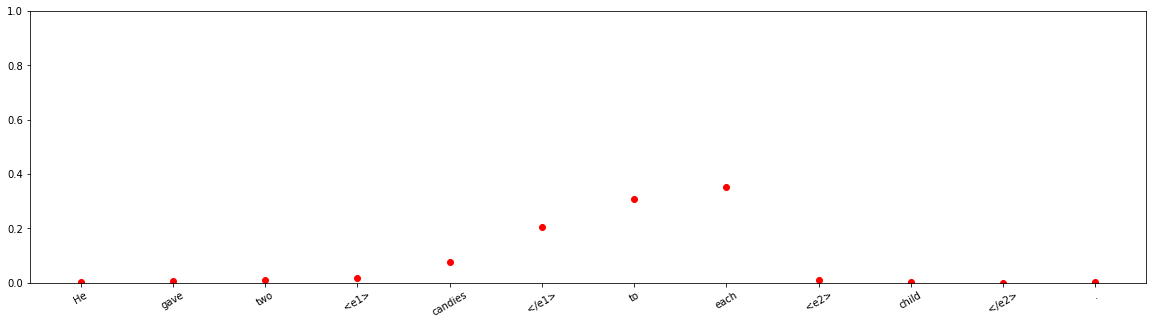



input sentence: The ship leaked <e1> oil </e1> into Brisbane <e2> river </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.7960928
Cause-Effect 	:	 1.42331436e-08
Component-Whole 	:	 1.5028328e-07
Entity-Destination 	:	 0.2037588
Entity-Origin 	:	 0.00014821571
Product-Producer 	:	 1.2624539e-09
Member-Collection 	:	 7.0097244e-09
Message-Topic 	:	 2.0174658e-08
Content-Container 	:	 2.1549221e-08
Instrument-Agency 	:	 4.9399573e-10



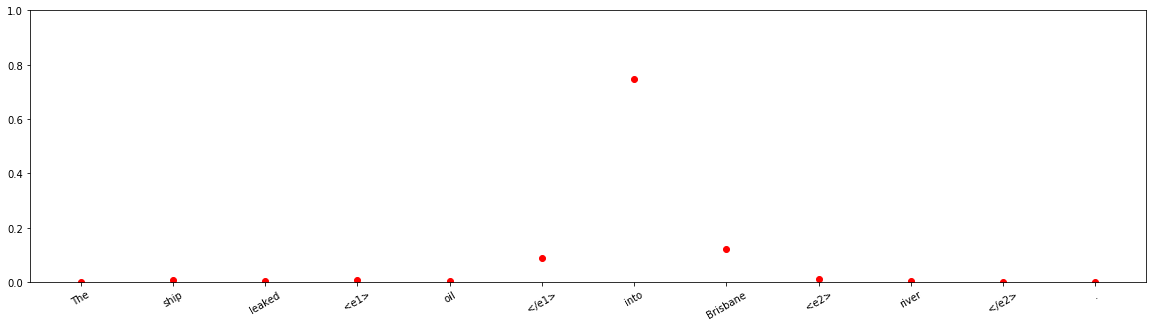




input sentence: My <e1> equipment </e1> was built in another <e2> country </e2> .
answer label:    Entity-Origin
wrong label:    Entity-Destination
Other 	:	 0.0018754621
Cause-Effect 	:	 1.3423484e-07
Component-Whole 	:	 0.011185263
Entity-Destination 	:	 0.5518734
Entity-Origin 	:	 0.0025999618
Product-Producer 	:	 0.057815883
Member-Collection 	:	 6.601441e-06
Message-Topic 	:	 4.2380878e-05
Content-Container 	:	 0.3745643
Instrument-Agency 	:	 3.6709578e-05



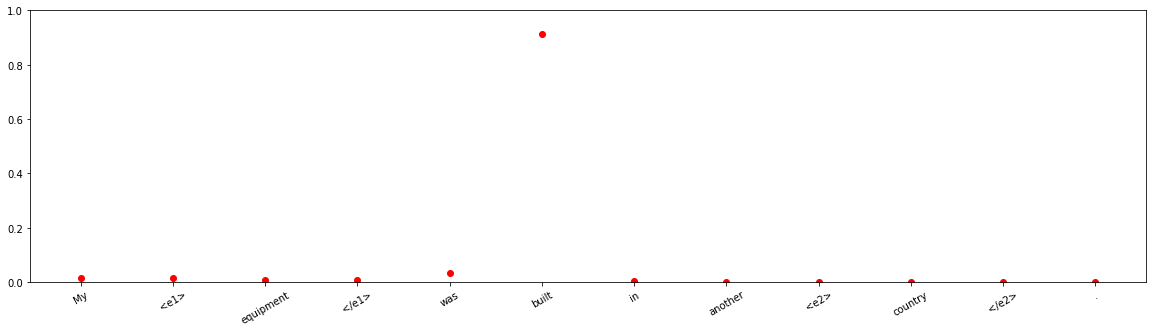



input sentence: The teacher always assigned <e1> students </e1> to <e2> groups </e2> .
answer label:    Member-Collection
wrong label:    Instrument-Agency
Other 	:	 0.024739392
Cause-Effect 	:	 8.6128943e-10
Component-Whole 	:	 6.0925442e-05
Entity-Destination 	:	 0.031011868
Entity-Origin 	:	 5.191395e-06
Product-Producer 	:	 0.00349757
Member-Collection 	:	 0.11904044
Message-Topic 	:	 0.0002106024
Content-Container 	:	 5.996916e-07
Instrument-Agency 	:	 0.8214334



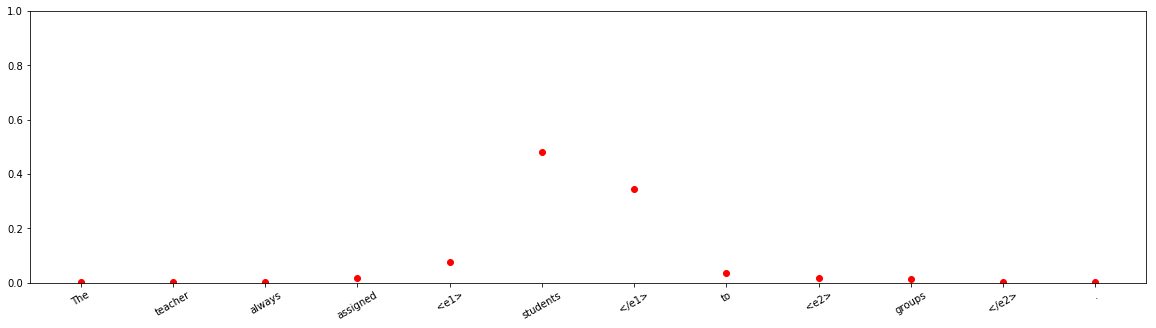



input sentence: There were concrete <e1> blocks </e1> inside a <e2> caisson </e2> .
answer label:    Content-Container
wrong label:    Component-Whole
Other 	:	 0.08099491
Cause-Effect 	:	 1.160776e-06
Component-Whole 	:	 0.90266687
Entity-Destination 	:	 0.014161201
Entity-Origin 	:	 4.807123e-06
Product-Producer 	:	 2.5383906e-05
Member-Collection 	:	 2.3887856e-07
Message-Topic 	:	 0.00010009092
Content-Container 	:	 0.0020439841
Instrument-Agency 	:	 1.3150618e-06



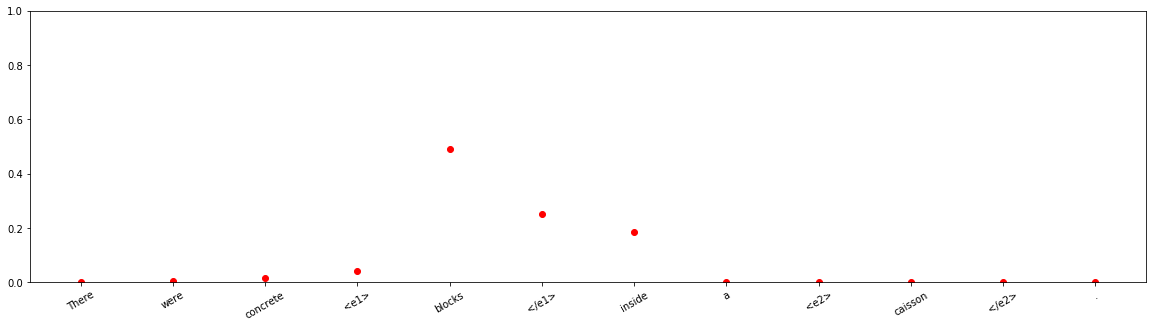


input sentence: The <e1> bungalow </e1> was built inside a <e2> barn </e2> .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.0045114253
Cause-Effect 	:	 1.9620966e-08
Component-Whole 	:	 0.9945967
Entity-Destination 	:	 0.00011197458
Entity-Origin 	:	 3.7890516e-08
Product-Producer 	:	 2.5551794e-06
Member-Collection 	:	 3.4266698e-08
Message-Topic 	:	 1.8481119e-07
Content-Container 	:	 0.000775875
Instrument-Agency 	:	 1.1368987e-06



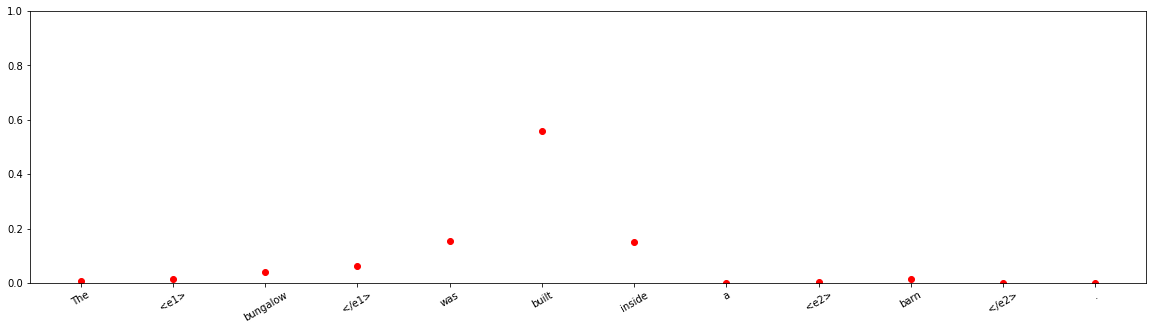





input sentence: This <e1> invertebrate </e1> builds armor from coconut <e2> halves </e2> .
answer label:    Instrument-Agency
wrong label:    Product-Producer
Other 	:	 9.552353e-06
Cause-Effect 	:	 1.334196e-07
Component-Whole 	:	 1.5599529e-08
Entity-Destination 	:	 4.035664e-09
Entity-Origin 	:	 0.0011987878
Product-Producer 	:	 0.9987643
Member-Collection 	:	 2.6063523e-08
Message-Topic 	:	 3.3813519e-09
Content-Container 	:	 6.483583e-08
Instrument-Agency 	:	 2.7192327e-05



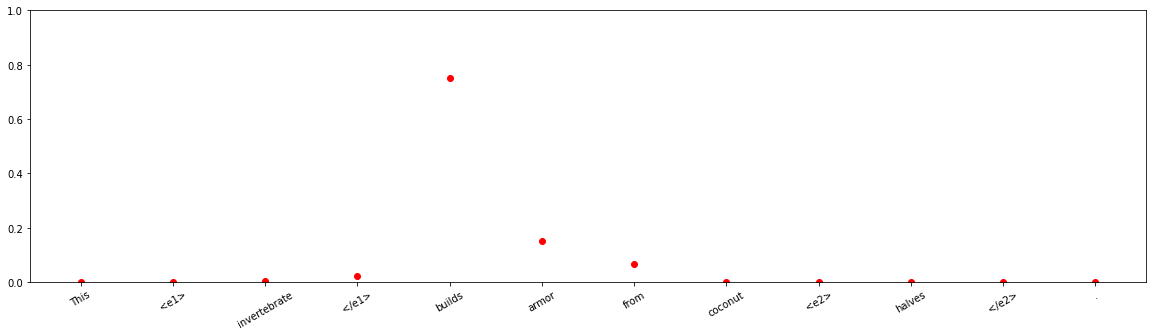






input sentence: The <e1> states </e1> are divided into smaller <e2> counties </e2> .
answer label:    Component-Whole
wrong label:    Entity-Destination
Other 	:	 0.0003939033
Cause-Effect 	:	 8.509713e-10
Component-Whole 	:	 0.033667076
Entity-Destination 	:	 0.9658551
Entity-Origin 	:	 7.924791e-07
Product-Producer 	:	 1.8341417e-06
Member-Collection 	:	 1.5727292e-05
Message-Topic 	:	 5.9057133e-05
Content-Container 	:	 3.5147461e-06
Instrument-Agency 	:	 2.8747236e-06



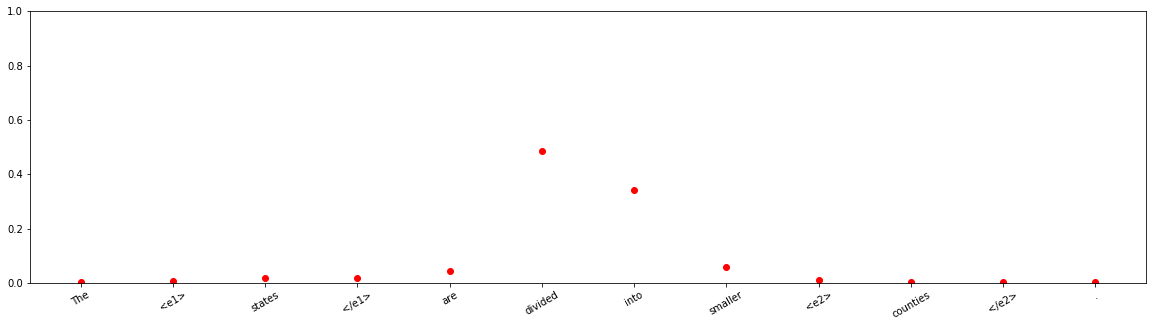










input sentence: This forum is dedicated to the late Lou Alessi , a devoted <e1> leather </e1> <e2> craftsman </e2> and an all around gentleman .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 2.8307866e-07
Cause-Effect 	:	 5.330689e-07
Component-Whole 	:	 8.946342e-05
Entity-Destination 	:	 5.790717e-10
Entity-Origin 	:	 6.264107e-08
Product-Producer 	:	 0.9643589
Member-Collection 	:	 1.6756394e-07
Message-Topic 	:	 2.6008004e-06
Content-Container 	:	 9.524762e-06
Instrument-Agency 	:	 0.035538428



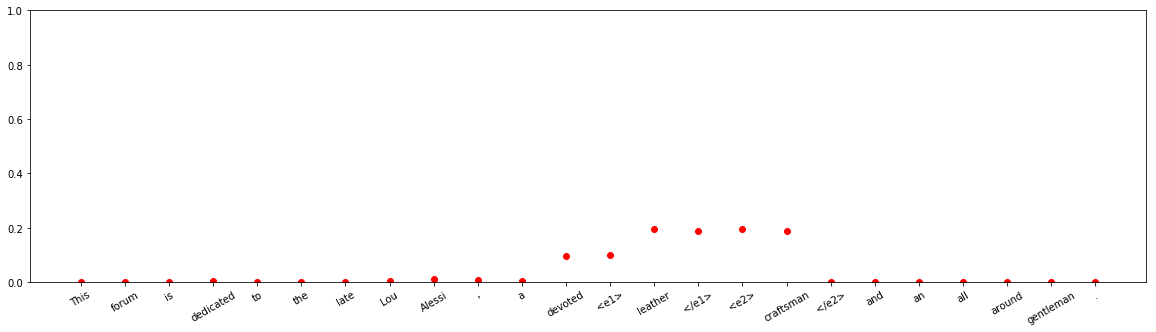






input sentence: The McCain <e1> team </e1> has hastily assembled a <e2> team </e2> of former Bush White House aides to tutor the vice-presidential candidate .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.024043875
Cause-Effect 	:	 8.3587076e-10
Component-Whole 	:	 1.7983897e-08
Entity-Destination 	:	 2.3299644e-05
Entity-Origin 	:	 4.0295856e-07
Product-Producer 	:	 0.9695612
Member-Collection 	:	 0.0063658273
Message-Topic 	:	 7.7658956e-07
Content-Container 	:	 7.6195613e-07
Instrument-Agency 	:	 3.7500504e-06



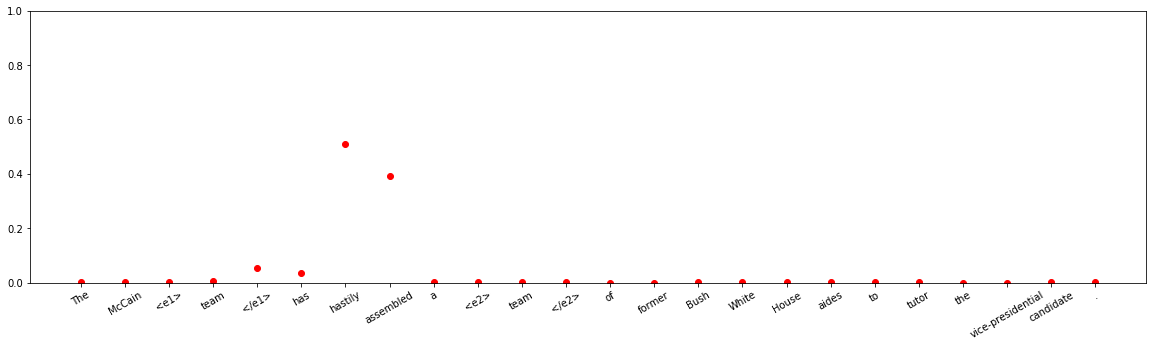



input sentence: An academic <e1> book </e1> has been reviewed by a fiction <e2> writer </e2> , who complained the book is `` academic '' .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 6.792339e-10
Cause-Effect 	:	 4.177961e-11
Component-Whole 	:	 2.067677e-11
Entity-Destination 	:	 1.0315623e-12
Entity-Origin 	:	 9.769272e-11
Product-Producer 	:	 0.99999654
Member-Collection 	:	 7.188007e-12
Message-Topic 	:	 3.2785147e-06
Content-Container 	:	 2.8079172e-10
Instrument-Agency 	:	 8.360227e-08



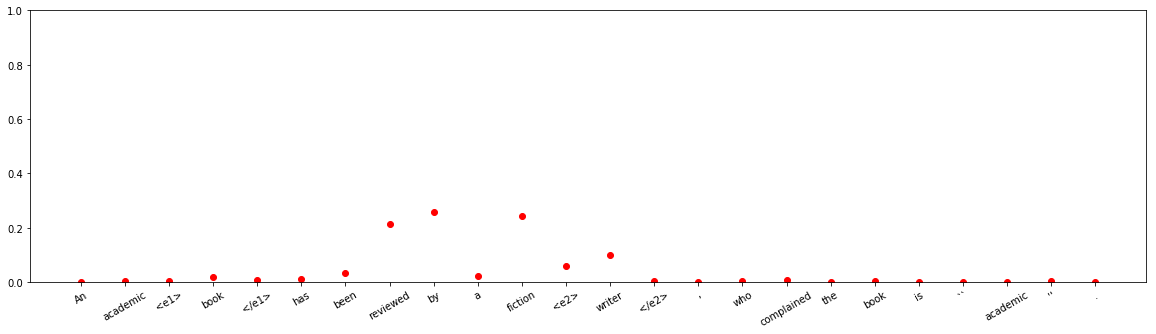









input sentence: A bundle of sensitive <e1> files </e1> linked to a massive police drugs <e2> bust </e2> have been found dumped in a skip .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 4.8906262e-08
Cause-Effect 	:	 1.4781996e-09
Component-Whole 	:	 2.2719084e-07
Entity-Destination 	:	 0.999987
Entity-Origin 	:	 5.7720677e-09
Product-Producer 	:	 4.5979125e-08
Member-Collection 	:	 2.654232e-10
Message-Topic 	:	 1.7729248e-07
Content-Container 	:	 2.3656046e-06
Instrument-Agency 	:	 1.0209471e-05



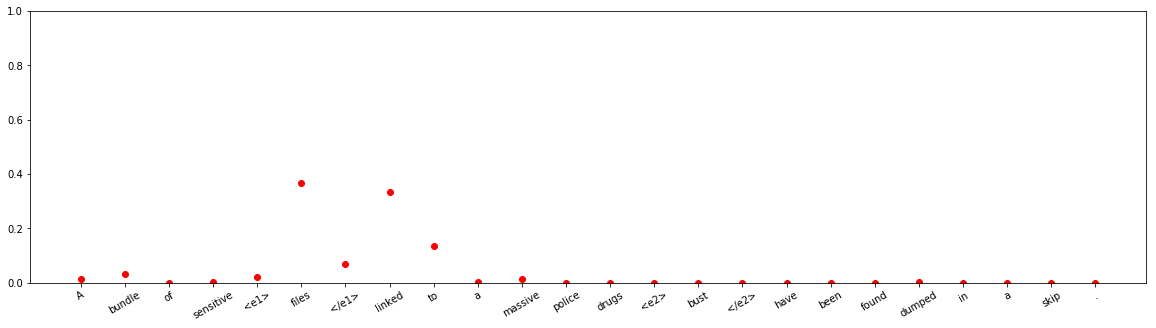




input sentence: Already by the middle of the eighteenth century , several small clockmaking <e1> shops </e1> produced cuckoo <e2> clocks </e2> with wooden gears .
answer label:    Product-Producer
wrong label:    Component-Whole
Other 	:	 3.0636775e-07
Cause-Effect 	:	 7.913466e-05
Component-Whole 	:	 0.9494521
Entity-Destination 	:	 4.341271e-10
Entity-Origin 	:	 0.0001620143
Product-Producer 	:	 0.046235967
Member-Collection 	:	 1.6284235e-05
Message-Topic 	:	 3.8053376e-08
Content-Container 	:	 1.598754e-05
Instrument-Agency 	:	 0.0040382547



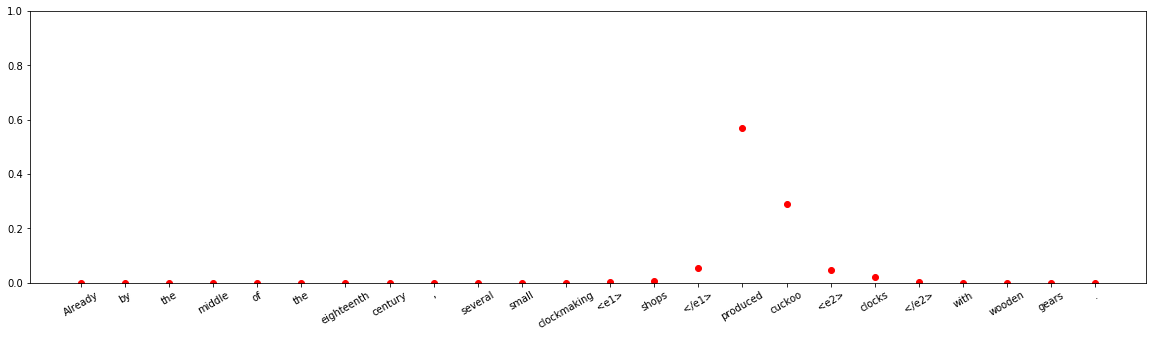


input sentence: The synthesist is thus carrying out a role which is analogous to that of a <e1> player </e1> in an <e2> orchestra </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.986217
Cause-Effect 	:	 3.6161268e-07
Component-Whole 	:	 0.00018820816
Entity-Destination 	:	 3.6683218e-07
Entity-Origin 	:	 2.3056796e-08
Product-Producer 	:	 3.6973606e-09
Member-Collection 	:	 0.013574995
Message-Topic 	:	 8.9856584e-08
Content-Container 	:	 1.0311971e-06
Instrument-Agency 	:	 1.7909733e-05



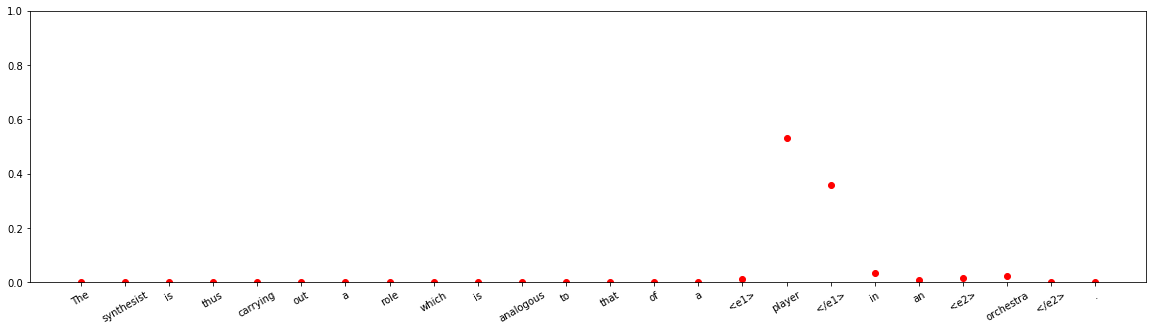



input sentence: Critical audience <e1> studies </e1> are migrating into intellectual <e2> inquiry </e2> focused on participation developing the stress on processes of interactive engagement .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.9998884
Cause-Effect 	:	 1.7481125e-09
Component-Whole 	:	 1.8922985e-10
Entity-Destination 	:	 8.571531e-05
Entity-Origin 	:	 1.8039985e-06
Product-Producer 	:	 2.8309946e-10
Member-Collection 	:	 1.10414906e-10
Message-Topic 	:	 2.4033987e-05
Content-Container 	:	 2.0183707e-11
Instrument-Agency 	:	 4.38729e-10



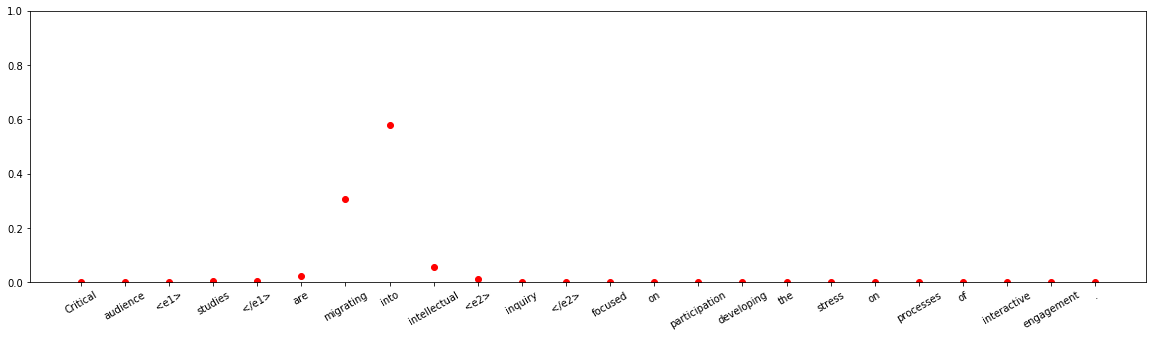




input sentence: The <e1> human </e1> lies down in a sealed <e2> box </e2> and allows his mind to do nothing but operate the avatar .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.00013646153
Cause-Effect 	:	 1.6137973e-07
Component-Whole 	:	 0.00017456227
Entity-Destination 	:	 0.024572976
Entity-Origin 	:	 9.311633e-06
Product-Producer 	:	 1.524115e-06
Member-Collection 	:	 1.625735e-05
Message-Topic 	:	 2.328751e-05
Content-Container 	:	 0.97505885
Instrument-Agency 	:	 6.6247417e-06



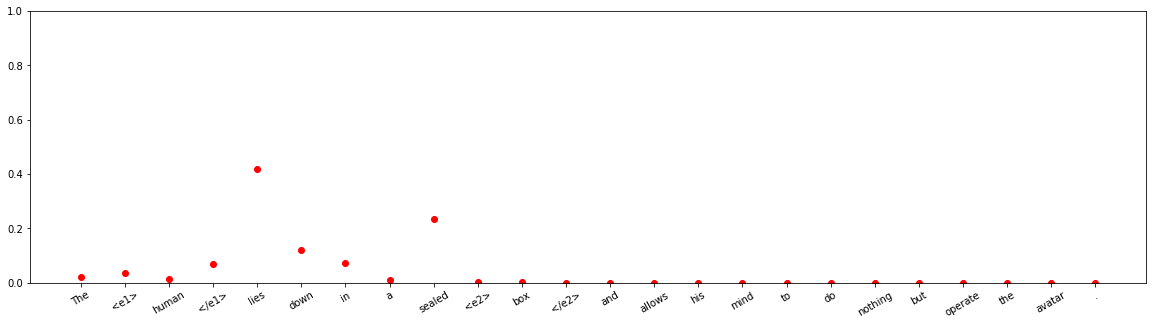






input sentence: From the ancient times , <e1> music </e1> documented the <e2> lives </e2> of the people and was widely patronized by the rulers .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.004361762
Cause-Effect 	:	 3.88266e-08
Component-Whole 	:	 1.7313886e-09
Entity-Destination 	:	 8.7829916e-10
Entity-Origin 	:	 4.4834817e-07
Product-Producer 	:	 0.0003032205
Member-Collection 	:	 1.8443637e-07
Message-Topic 	:	 0.99533325
Content-Container 	:	 5.191044e-09
Instrument-Agency 	:	 1.0722244e-06



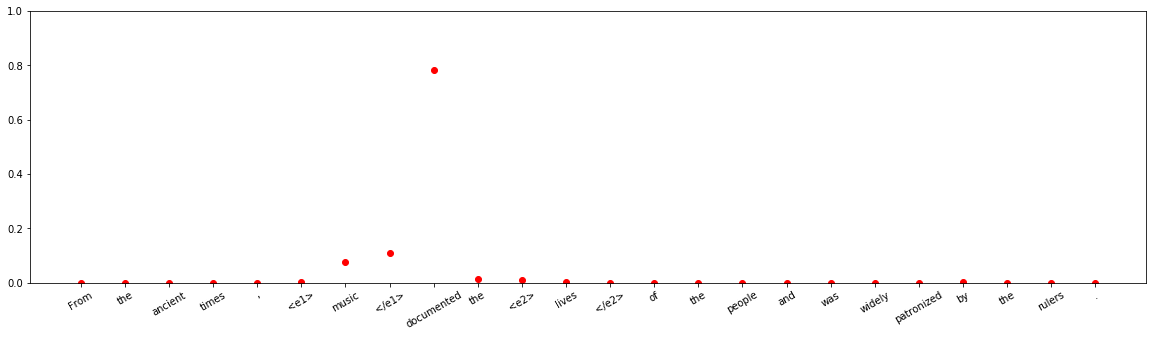


input sentence: The <e1> kingdom </e1> comprises four topographical and climatic <e2> areas </e2> , which vary from 400 to 1800 metres above sea level .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.6231929
Cause-Effect 	:	 1.4403981e-06
Component-Whole 	:	 0.37492982
Entity-Destination 	:	 1.30108155e-08
Entity-Origin 	:	 4.0129717e-06
Product-Producer 	:	 3.6356146e-06
Member-Collection 	:	 0.00072314875
Message-Topic 	:	 2.97891e-06
Content-Container 	:	 2.6226473e-07
Instrument-Agency 	:	 0.0011418215



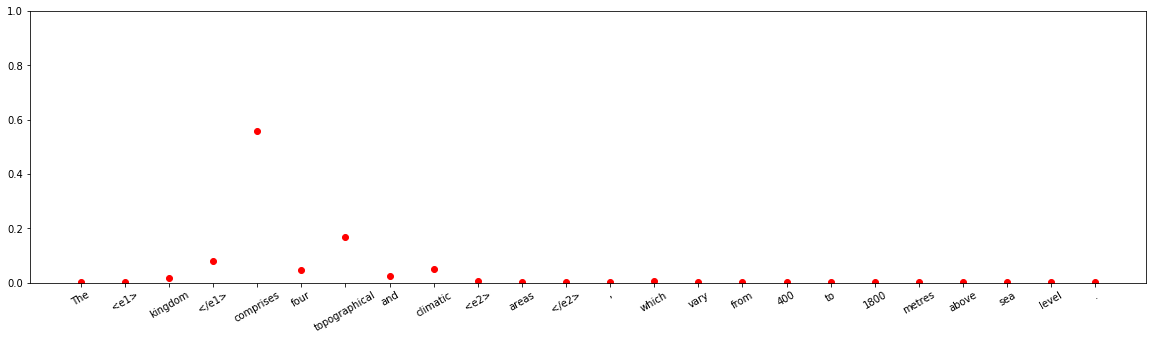


input sentence: In the 2006 Robin Hood series , Robin at one point is lowered into a <e1> pit </e1> of poisonous <e2> snakes </e2> .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 1.3841097e-05
Cause-Effect 	:	 8.197129e-10
Component-Whole 	:	 1.3475175e-06
Entity-Destination 	:	 4.8801596e-10
Entity-Origin 	:	 5.655671e-08
Product-Producer 	:	 4.3758672e-07
Member-Collection 	:	 0.99998164
Message-Topic 	:	 1.2505373e-06
Content-Container 	:	 1.4373117e-06
Instrument-Agency 	:	 1.14386424e-10



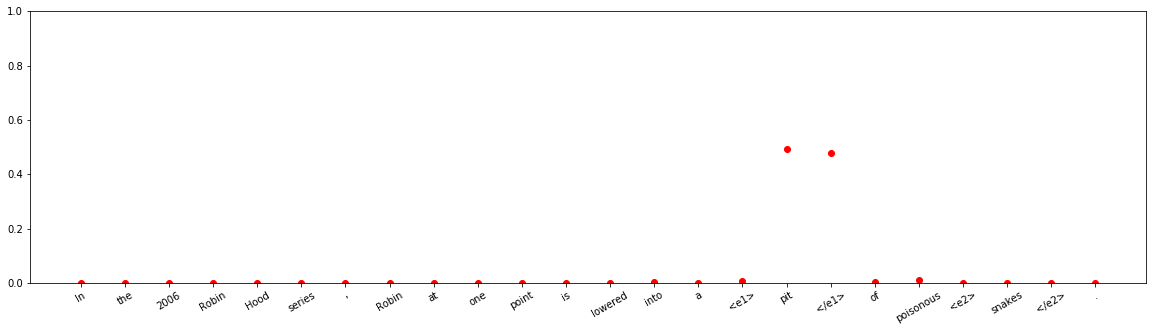










input sentence: The <e1> mosaicism </e1> observed in the proband was derived from a postzygotic somatic <e2> mutation </e2> of the normal maternal y chromosome .
answer label:    Cause-Effect
wrong label:    Entity-Origin
Other 	:	 0.48172447
Cause-Effect 	:	 0.00010987135
Component-Whole 	:	 1.2288346e-09
Entity-Destination 	:	 2.5554803e-09
Entity-Origin 	:	 0.5181657
Product-Producer 	:	 1.1743371e-09
Member-Collection 	:	 2.0135596e-08
Message-Topic 	:	 8.1957235e-10
Content-Container 	:	 2.7931601e-10
Instrument-Agency 	:	 1.4416745e-08



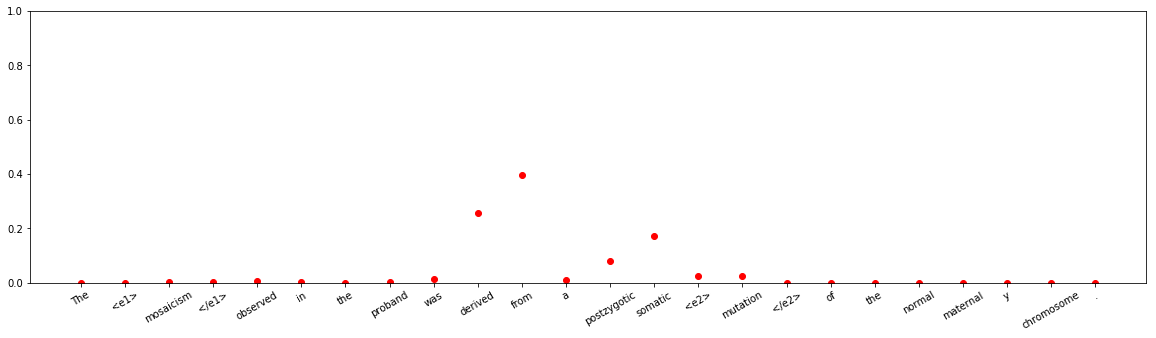


input sentence: The Historic District Commission <e1> members </e1> drafted a demolition delay <e2> ordinance </e2> that went before the Board of Selectmen last year .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9901495
Cause-Effect 	:	 0.00016769647
Component-Whole 	:	 2.764216e-09
Entity-Destination 	:	 7.6008033e-10
Entity-Origin 	:	 1.6622149e-09
Product-Producer 	:	 0.0093461685
Member-Collection 	:	 6.6696776e-07
Message-Topic 	:	 0.00033550896
Content-Container 	:	 9.186297e-10
Instrument-Agency 	:	 4.748927e-07



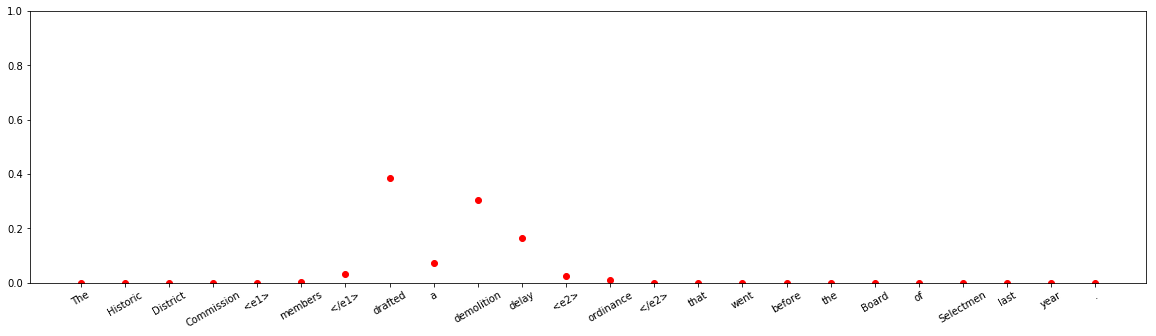




input sentence: Upon its discovery , King Tut 's <e1> mummy </e1> was placed inside three <e2> coffins </e2> , one smaller than the next .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 5.3437003e-07
Cause-Effect 	:	 6.2362973e-13
Component-Whole 	:	 1.9463519e-08
Entity-Destination 	:	 0.9998041
Entity-Origin 	:	 7.717869e-06
Product-Producer 	:	 5.1334412e-09
Member-Collection 	:	 6.017717e-09
Message-Topic 	:	 1.7199508e-08
Content-Container 	:	 0.00018764801
Instrument-Agency 	:	 3.8362216e-09



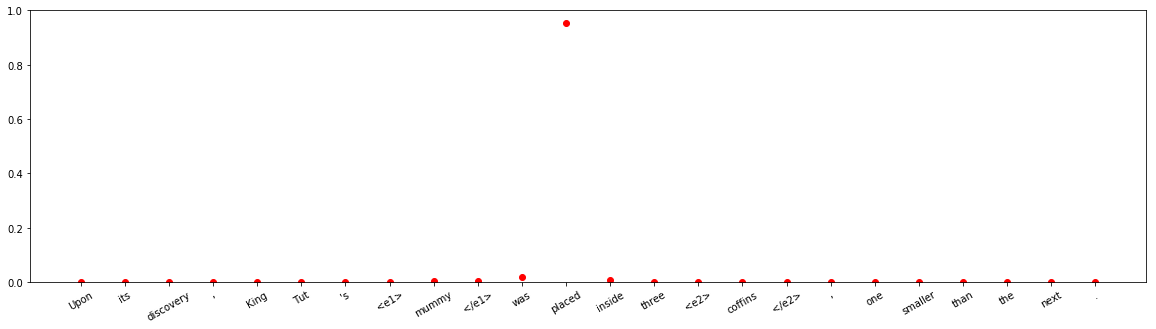




input sentence: High-frequency geometric <e1> ray theory </e1> is used to study the refracted arrival from a <e2> layer </e2> embedded in an infinite medium .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 0.04344314
Cause-Effect 	:	 0.0006784822
Component-Whole 	:	 4.743944e-10
Entity-Destination 	:	 4.999566e-05
Entity-Origin 	:	 0.95582837
Product-Producer 	:	 1.6960604e-10
Member-Collection 	:	 3.437296e-10
Message-Topic 	:	 6.0082184e-10
Content-Container 	:	 1.0364137e-09
Instrument-Agency 	:	 9.770831e-09



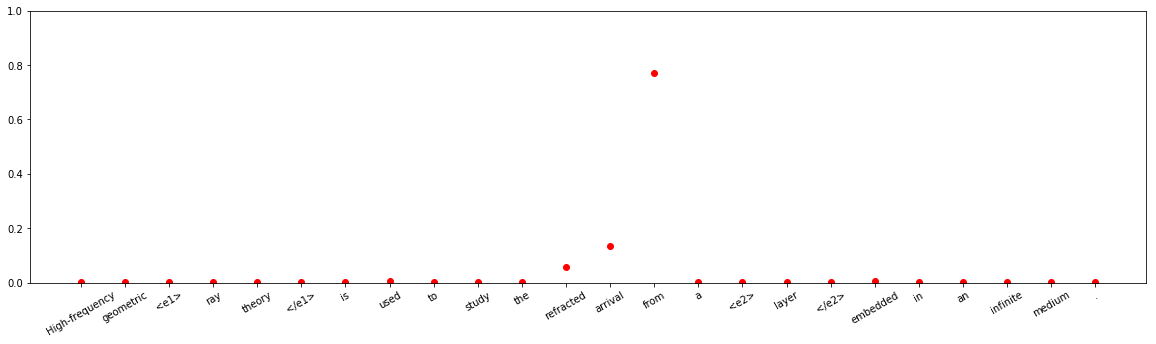






input sentence: The painting shows a historical view of the <e1> damage </e1> caused by the 1693 Catania earthquake and the <e2> reconstruction </e2> activities .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 6.966434e-07
Cause-Effect 	:	 0.9999993
Component-Whole 	:	 1.1428746e-10
Entity-Destination 	:	 1.7517795e-11
Entity-Origin 	:	 9.3748696e-11
Product-Producer 	:	 7.930875e-12
Member-Collection 	:	 9.56799e-13
Message-Topic 	:	 2.8946264e-11
Content-Container 	:	 4.612305e-15
Instrument-Agency 	:	 6.800009e-09



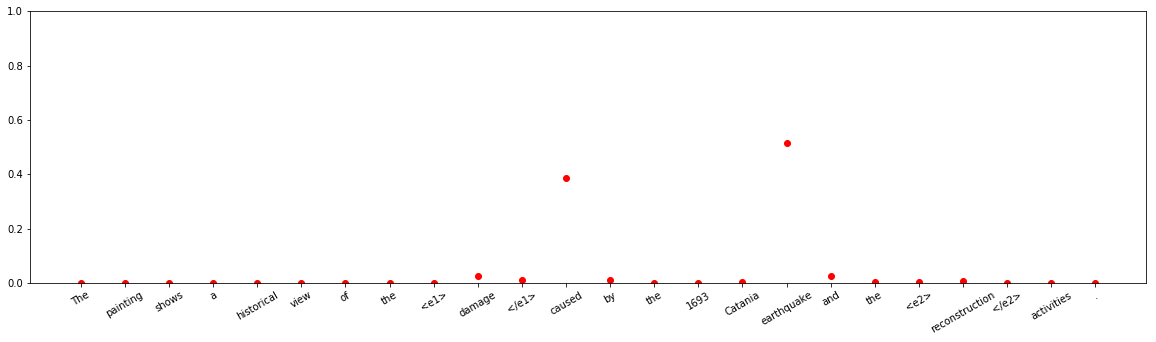










input sentence: Both <e1> cocaine </e1> and crack cocaine cause constricted blood vessels , increased heart rate , body temperature and blood <e2> pressure </e2> .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.00020849555
Cause-Effect 	:	 0.9997509
Component-Whole 	:	 4.8906446e-07
Entity-Destination 	:	 7.146913e-07
Entity-Origin 	:	 2.2867844e-05
Product-Producer 	:	 4.885349e-09
Member-Collection 	:	 2.839644e-08
Message-Topic 	:	 3.004203e-08
Content-Container 	:	 5.918101e-08
Instrument-Agency 	:	 1.6617032e-05



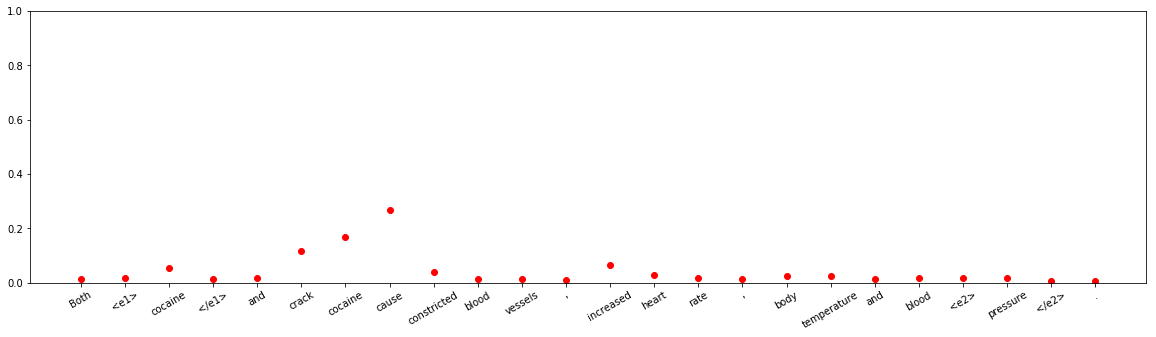


input sentence: At full establishment , a <e1> brigade </e1> of 18-lbr field <e2> guns </e2> consisted of 795 men of whom 23 were officers .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 4.0492902e-09
Cause-Effect 	:	 2.1386389e-12
Component-Whole 	:	 7.276599e-10
Entity-Destination 	:	 2.9719524e-13
Entity-Origin 	:	 8.748936e-11
Product-Producer 	:	 1.895144e-09
Member-Collection 	:	 1.0
Message-Topic 	:	 1.3740663e-10
Content-Container 	:	 7.963544e-09
Instrument-Agency 	:	 4.9251592e-11



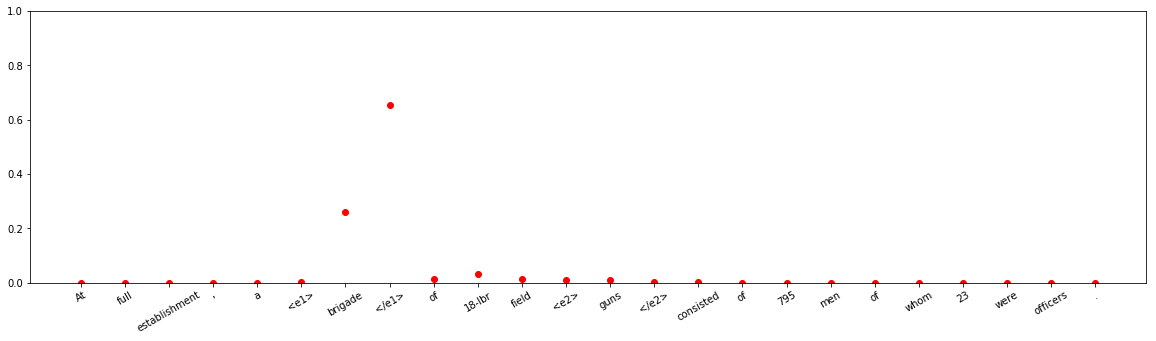





input sentence: The primary aim of the present invention is to provide a capless <e1> closure </e1> for a conventional fuel filler <e2> pipe </e2> .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 6.779085e-05
Cause-Effect 	:	 3.5274343e-06
Component-Whole 	:	 0.9885028
Entity-Destination 	:	 2.1250138e-05
Entity-Origin 	:	 9.4862946e-07
Product-Producer 	:	 2.4653082e-05
Member-Collection 	:	 1.4554463e-07
Message-Topic 	:	 3.924462e-05
Content-Container 	:	 0.001434777
Instrument-Agency 	:	 0.009904957



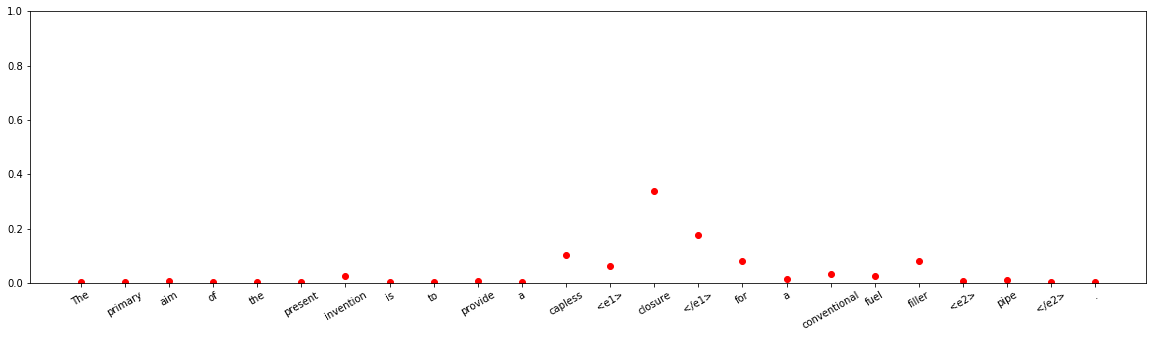



input sentence: There are a number of fairly standard conventions when framing a <e1> business </e1> <e2> letter </e2> that it is important to observe .
answer label:    Message-Topic
wrong label:    Product-Producer
Other 	:	 0.031207504
Cause-Effect 	:	 7.3295786e-07
Component-Whole 	:	 1.523373e-06
Entity-Destination 	:	 2.3006577e-07
Entity-Origin 	:	 1.6470615e-06
Product-Producer 	:	 0.775122
Member-Collection 	:	 0.00020858849
Message-Topic 	:	 0.19343928
Content-Container 	:	 1.5525123e-06
Instrument-Agency 	:	 1.6962289e-05



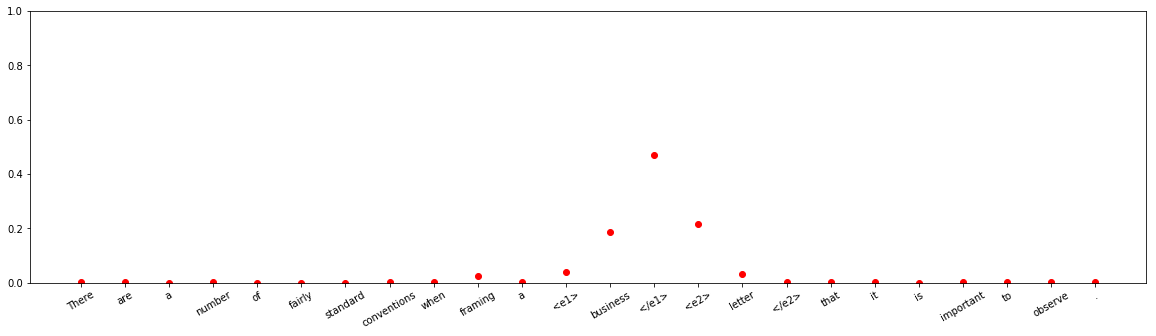


input sentence: The Learning Institute has several externally funded <e1> projects </e1> investigating <e2> aspects </e2> of learning and teaching or management in higher education .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.0018092248
Cause-Effect 	:	 7.625383e-09
Component-Whole 	:	 6.130676e-05
Entity-Destination 	:	 8.518356e-09
Entity-Origin 	:	 8.470418e-12
Product-Producer 	:	 3.4384853e-09
Member-Collection 	:	 1.5427574e-08
Message-Topic 	:	 0.9981294
Content-Container 	:	 4.1668054e-11
Instrument-Agency 	:	 1.7595508e-11



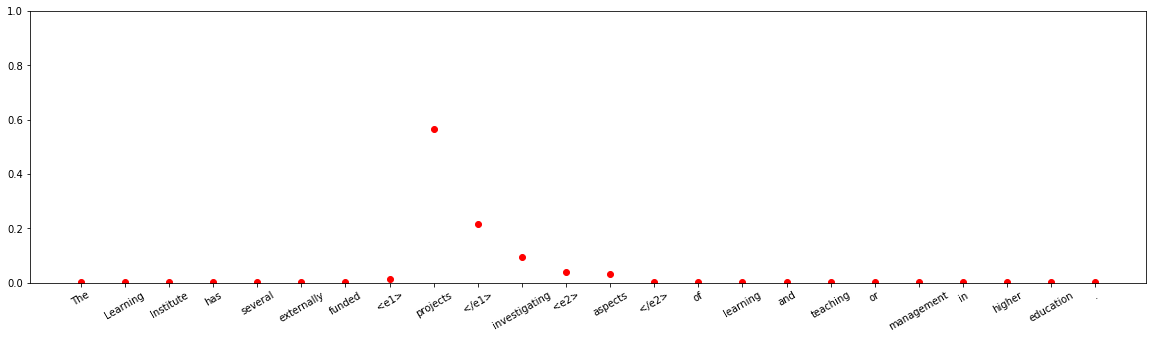



input sentence: <e1> End-sequencing </e1> of the fragments with short 36-base <e2> reads </e2> therefore leads to elevated coverage near the end of the baits .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.2546675
Cause-Effect 	:	 0.00042068286
Component-Whole 	:	 0.66330415
Entity-Destination 	:	 8.5017855e-05
Entity-Origin 	:	 1.7690056e-05
Product-Producer 	:	 0.002259547
Member-Collection 	:	 0.0013077168
Message-Topic 	:	 3.9430165e-06
Content-Container 	:	 3.7958715e-05
Instrument-Agency 	:	 0.07789581



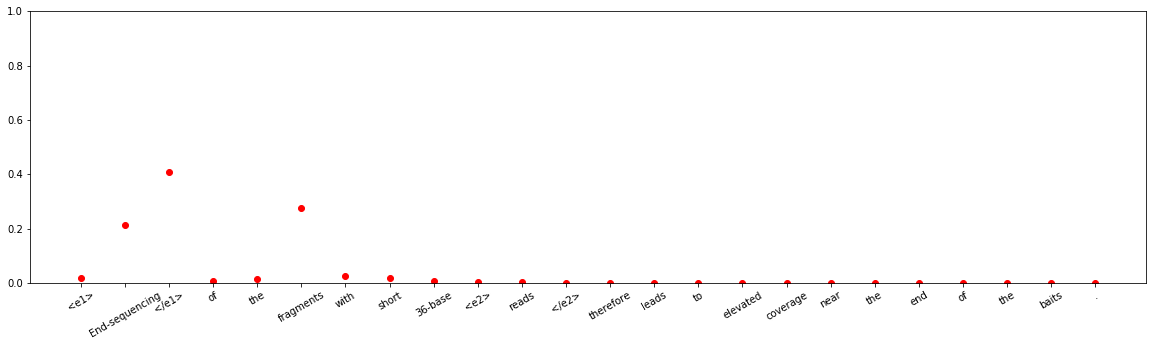





input sentence: The study focuses on the <e1> personnel </e1> in three service stations in Finland that are part of Teboil 's <e2> organisation </e2> .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 7.3671714e-08
Cause-Effect 	:	 3.2928469e-09
Component-Whole 	:	 0.0018702876
Entity-Destination 	:	 1.2705176e-10
Entity-Origin 	:	 3.418494e-08
Product-Producer 	:	 1.4653743e-07
Member-Collection 	:	 0.9980792
Message-Topic 	:	 4.732597e-05
Content-Container 	:	 2.9848898e-06
Instrument-Agency 	:	 2.912847e-09



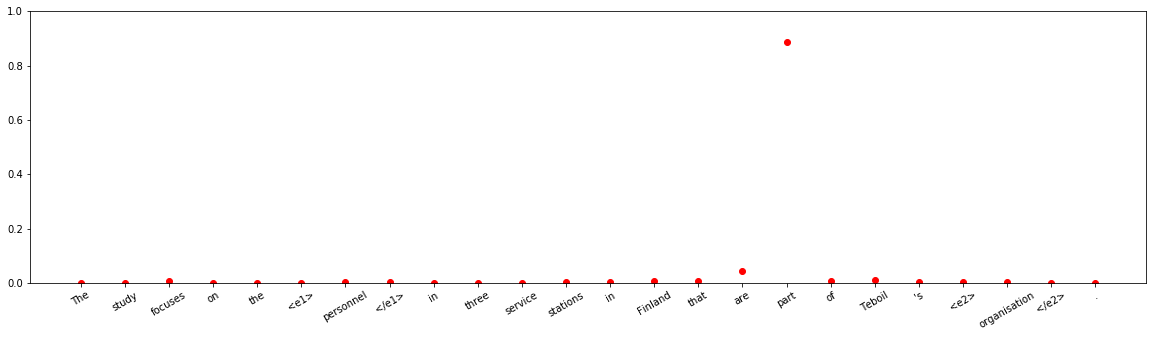





input sentence: <e1> Chimpanzees </e1> make <e2> love </e2> rather like humans do , but they do not usually run the risk of contracting syphilis .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.006812294
Cause-Effect 	:	 2.1869157e-06
Component-Whole 	:	 1.9414044e-08
Entity-Destination 	:	 7.6419715e-10
Entity-Origin 	:	 2.721776e-07
Product-Producer 	:	 0.99312466
Member-Collection 	:	 3.8952016e-06
Message-Topic 	:	 5.523987e-05
Content-Container 	:	 1.5008046e-08
Instrument-Agency 	:	 1.4400035e-06



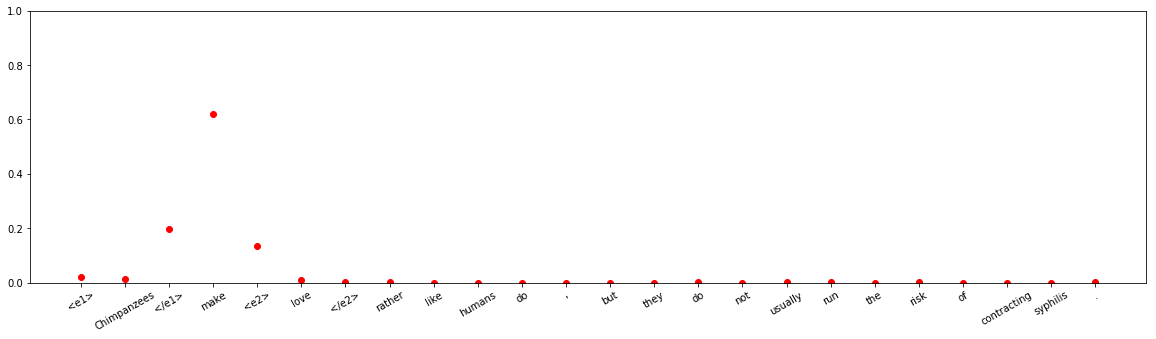






input sentence: Professionals from streams like law , engineering , agriculture also have opening in the management <e1> cadre </e1> of various <e2> banks </e2> .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.99994016
Cause-Effect 	:	 6.3972316e-10
Component-Whole 	:	 1.0017959e-07
Entity-Destination 	:	 1.0460204e-09
Entity-Origin 	:	 3.3696403e-09
Product-Producer 	:	 1.1812228e-07
Member-Collection 	:	 5.7008343e-05
Message-Topic 	:	 1.6124736e-07
Content-Container 	:	 8.082779e-12
Instrument-Agency 	:	 2.5223787e-06



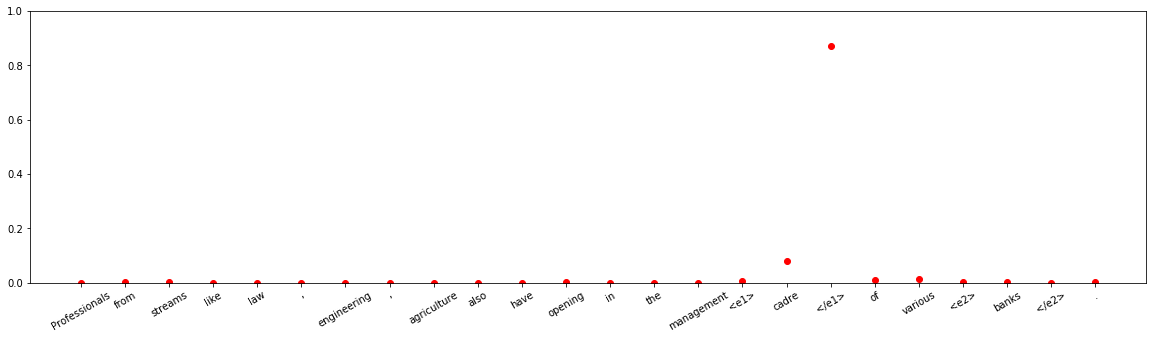



input sentence: It serves only the self-serving purposes of the political parties ; it provides them a faithful <e1> horde </e1> of <e2> believers </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9468095
Cause-Effect 	:	 4.815928e-09
Component-Whole 	:	 1.2409436e-10
Entity-Destination 	:	 1.698929e-08
Entity-Origin 	:	 1.6685725e-07
Product-Producer 	:	 5.659507e-08
Member-Collection 	:	 0.05318984
Message-Topic 	:	 4.150513e-07
Content-Container 	:	 3.74678e-09
Instrument-Agency 	:	 5.5025044e-08



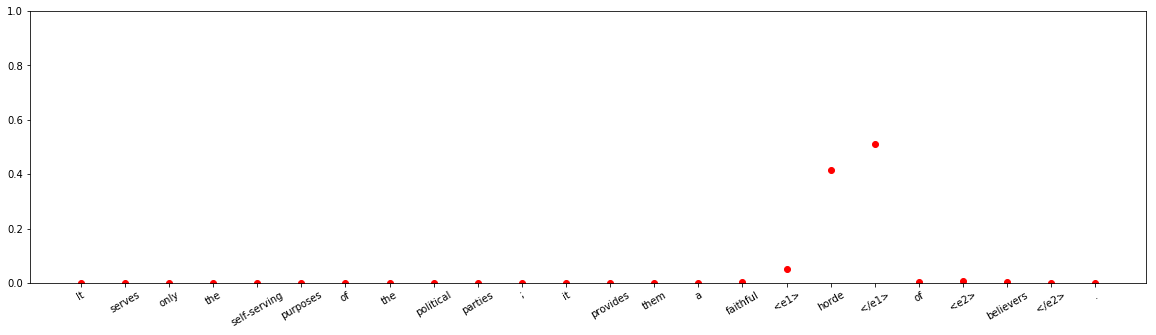




input sentence: The <e1> study </e1> assessed the effectiveness of the world 's fisheries management regimes using <e2> evaluations </e2> by nearly 1200 fisheries experts .
answer label:    Component-Whole
wrong label:    Instrument-Agency
Other 	:	 0.0014292244
Cause-Effect 	:	 4.3146446e-07
Component-Whole 	:	 0.00049487024
Entity-Destination 	:	 2.1692964e-08
Entity-Origin 	:	 5.3796465e-09
Product-Producer 	:	 4.5008937e-07
Member-Collection 	:	 7.123443e-07
Message-Topic 	:	 0.0014306454
Content-Container 	:	 7.5854224e-08
Instrument-Agency 	:	 0.99664354



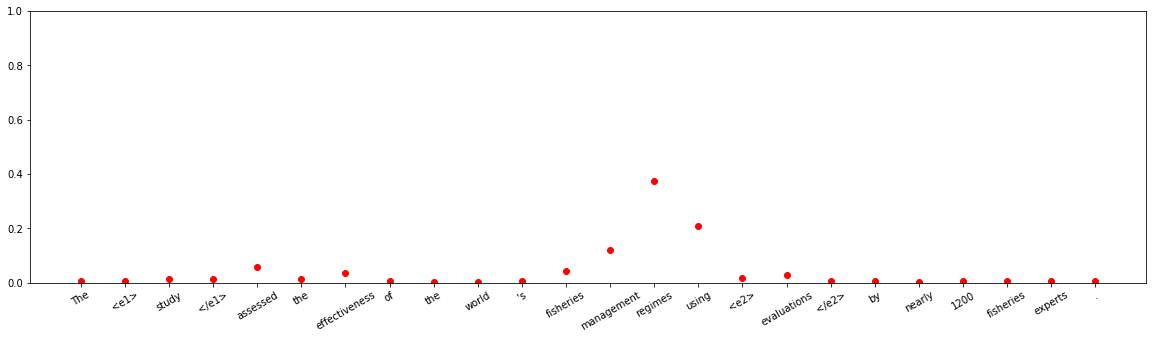


input sentence: You reassigned them after making a <e1> change </e1> in the registry through the administrative <e2> console </e2> or by using wsadmin scriptin .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.28118983
Cause-Effect 	:	 6.3758143e-06
Component-Whole 	:	 0.5891514
Entity-Destination 	:	 4.5234563e-05
Entity-Origin 	:	 2.1096878e-07
Product-Producer 	:	 2.4481135e-09
Member-Collection 	:	 3.5298393e-07
Message-Topic 	:	 2.069905e-07
Content-Container 	:	 4.7230706e-08
Instrument-Agency 	:	 0.12960638



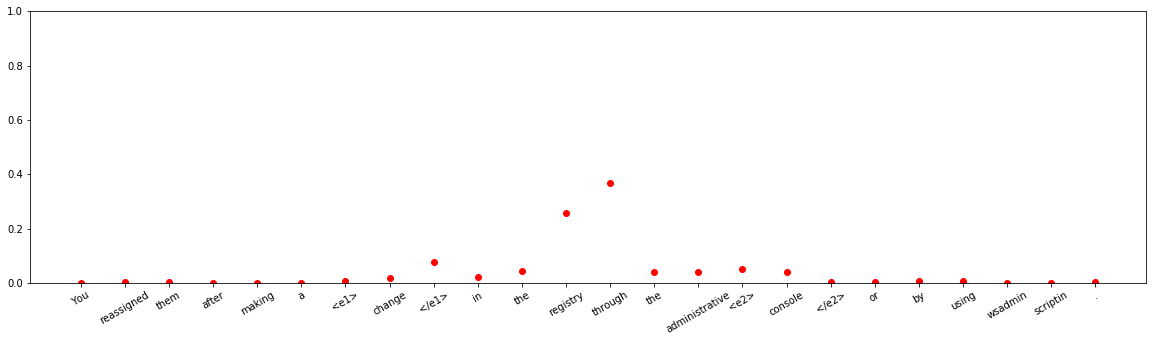






input sentence: During this transport , over about 10 kilometres , the Herschel <e1> spacecraft </e1> was placed inside the payload transport <e2> container </e2> .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 1.17519356e-07
Cause-Effect 	:	 3.7091485e-14
Component-Whole 	:	 1.3736115e-11
Entity-Destination 	:	 0.9999994
Entity-Origin 	:	 3.030692e-07
Product-Producer 	:	 7.04752e-12
Member-Collection 	:	 1.6126573e-12
Message-Topic 	:	 1.8033516e-11
Content-Container 	:	 1.577469e-07
Instrument-Agency 	:	 3.7796877e-10



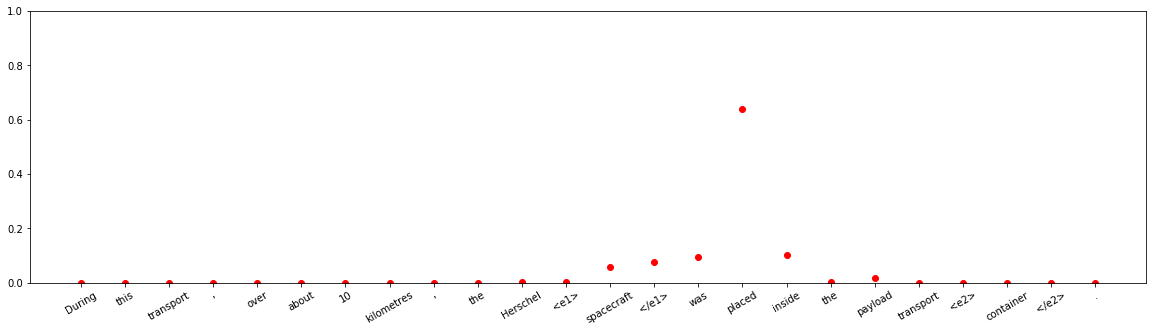


input sentence: The first <e1> box </e1> that arrived at Shirley Shupp 's door was filled with <e2> braces </e2> to help with her arthritis .
answer label:    Content-Container
wrong label:    Component-Whole
Other 	:	 0.004916867
Cause-Effect 	:	 7.4982665e-08
Component-Whole 	:	 0.9928585
Entity-Destination 	:	 0.000413409
Entity-Origin 	:	 4.157401e-06
Product-Producer 	:	 6.338958e-08
Member-Collection 	:	 2.8709147e-08
Message-Topic 	:	 5.5870206e-08
Content-Container 	:	 0.0016535075
Instrument-Agency 	:	 0.00015336025



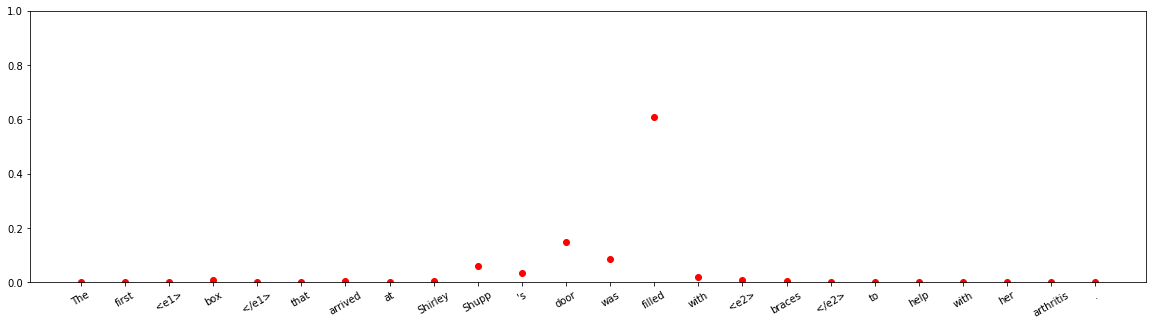





input sentence: Mobil is now turning to fine art as a way of protecting some of its huge <e1> profits </e1> from <e2> inflation </e2> .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 2.7166075e-06
Cause-Effect 	:	 0.99999726
Component-Whole 	:	 1.4703727e-12
Entity-Destination 	:	 1.0425236e-11
Entity-Origin 	:	 2.2305874e-10
Product-Producer 	:	 2.3342225e-10
Member-Collection 	:	 3.3089777e-11
Message-Topic 	:	 1.538073e-10
Content-Container 	:	 7.416096e-13
Instrument-Agency 	:	 1.8465891e-10



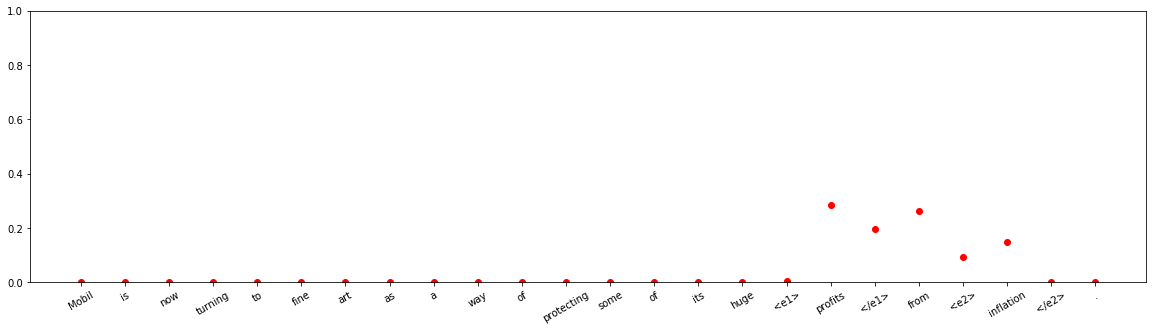


input sentence: US <e1> researchers </e1> have found a gene responsible for turning a plate of pasta into <e2> fat </e2> , offering new clues .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.08696944
Cause-Effect 	:	 3.455957e-07
Component-Whole 	:	 1.1831722e-05
Entity-Destination 	:	 0.00048280746
Entity-Origin 	:	 7.694967e-06
Product-Producer 	:	 0.01055738
Member-Collection 	:	 2.563803e-05
Message-Topic 	:	 5.6381367e-07
Content-Container 	:	 3.4383972e-06
Instrument-Agency 	:	 0.9019408



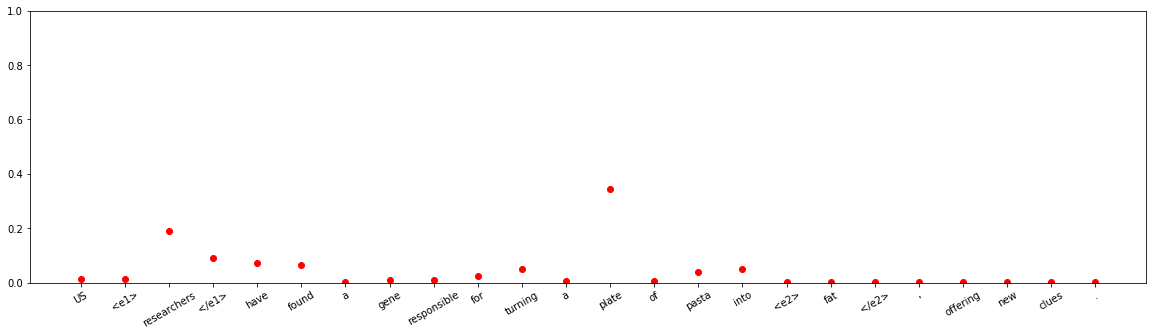












input sentence: The <e1> room </e1> was filled with huge Jack-the-Dripper <e2> canvases </e2> .
answer label:    Other
wrong label:    Content-Container
Other 	:	 0.00041160831
Cause-Effect 	:	 3.5207074e-07
Component-Whole 	:	 0.00023770092
Entity-Destination 	:	 0.0027626553
Entity-Origin 	:	 2.720186e-06
Product-Producer 	:	 1.2066235e-05
Member-Collection 	:	 4.940904e-07
Message-Topic 	:	 3.915465e-06
Content-Container 	:	 0.99656737
Instrument-Agency 	:	 1.025849e-06



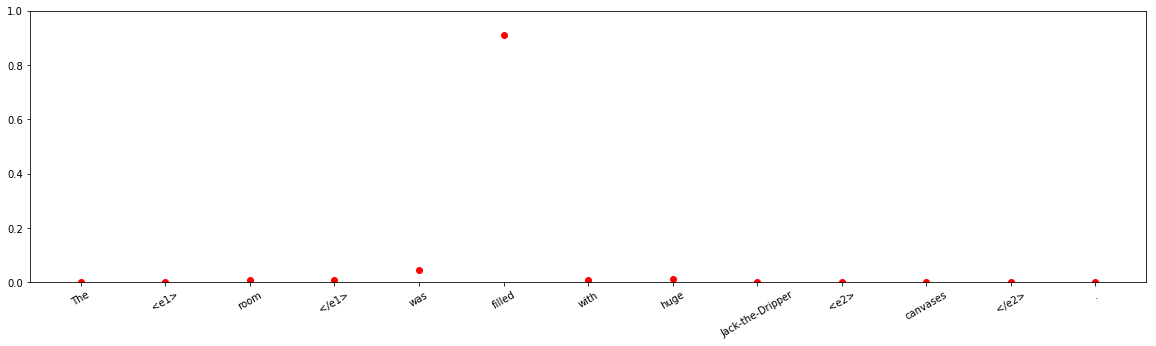


input sentence: People now post their <e1> opinions </e1> to this <e2> blog </e2> .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.000425739
Cause-Effect 	:	 6.8324795e-09
Component-Whole 	:	 0.000626366
Entity-Destination 	:	 0.06342883
Entity-Origin 	:	 3.2394396e-07
Product-Producer 	:	 5.018362e-05
Member-Collection 	:	 9.13712e-08
Message-Topic 	:	 0.93536556
Content-Container 	:	 1.3505154e-07
Instrument-Agency 	:	 0.000102856946



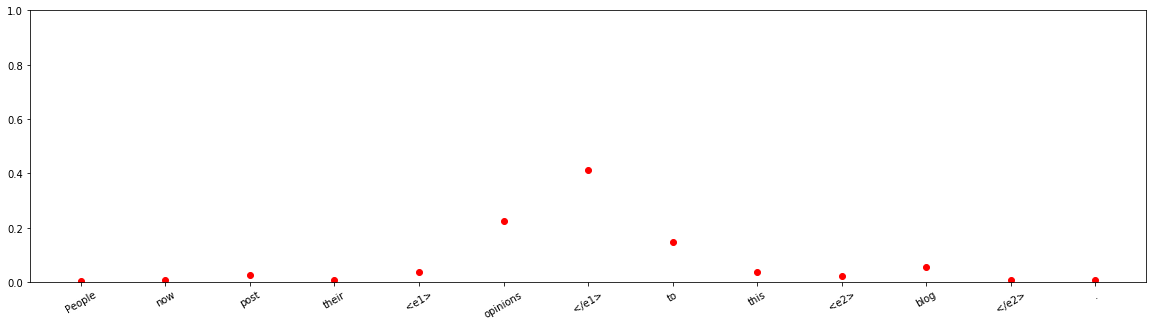






input sentence: He invested <e1> dollars </e1> into real estate investment <e2> trusts </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.98172104
Cause-Effect 	:	 7.275152e-07
Component-Whole 	:	 1.02272926e-10
Entity-Destination 	:	 0.018266495
Entity-Origin 	:	 1.1510743e-05
Product-Producer 	:	 9.464772e-09
Member-Collection 	:	 4.2645635e-08
Message-Topic 	:	 1.9231328e-07
Content-Container 	:	 3.7377536e-08
Instrument-Agency 	:	 1.4185877e-09



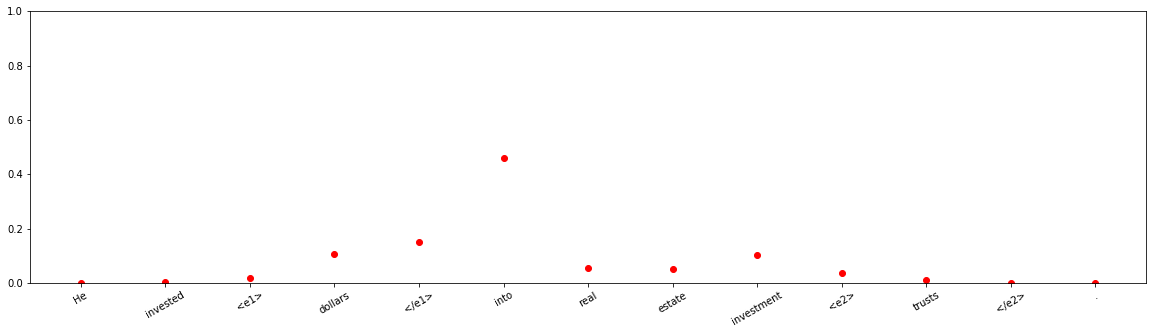







input sentence: The <e1> yeast </e1> is an ingredient for making <e2> beer </e2> .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 0.007228026
Cause-Effect 	:	 1.824829e-05
Component-Whole 	:	 1.4754299e-09
Entity-Destination 	:	 7.753102e-07
Entity-Origin 	:	 0.99271566
Product-Producer 	:	 4.2482616e-06
Member-Collection 	:	 4.4903183e-09
Message-Topic 	:	 8.945241e-08
Content-Container 	:	 3.0880263e-05
Instrument-Agency 	:	 1.983806e-06



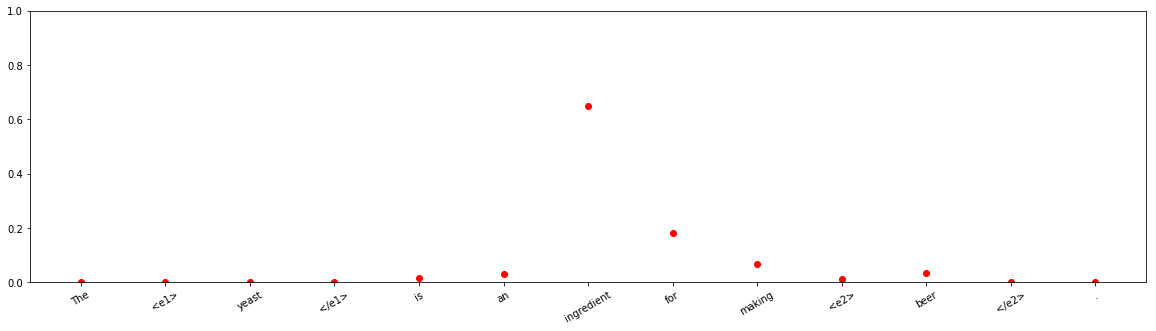










input sentence: <e1> Technicians </e1> quickly prepared the <e2> stage </e2> for the headliner .
answer label:    Product-Producer
wrong label:    Instrument-Agency
Other 	:	 0.012301678
Cause-Effect 	:	 2.974494e-08
Component-Whole 	:	 1.4064323e-08
Entity-Destination 	:	 0.13072607
Entity-Origin 	:	 1.7927081e-06
Product-Producer 	:	 0.21736096
Member-Collection 	:	 1.655283e-07
Message-Topic 	:	 4.3322572e-08
Content-Container 	:	 3.7645314e-09
Instrument-Agency 	:	 0.6396093



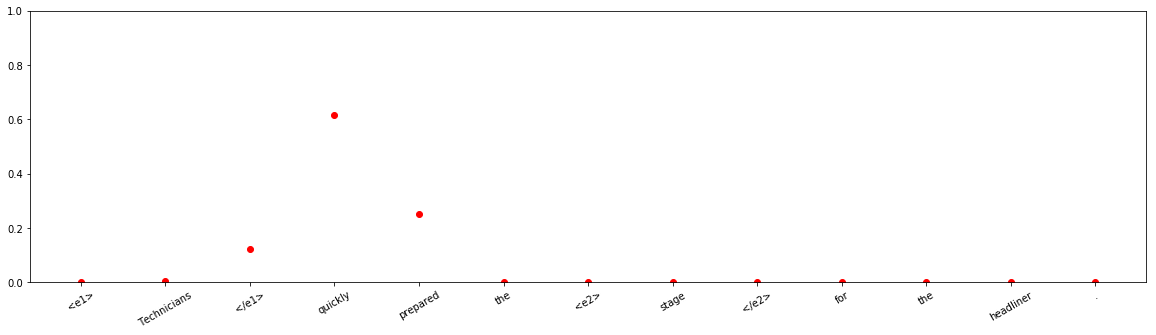





input sentence: The users sent an <e1> array </e1> to the <e2> responder </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.6685396
Cause-Effect 	:	 8.930762e-07
Component-Whole 	:	 6.1812425e-06
Entity-Destination 	:	 0.16030404
Entity-Origin 	:	 1.0939485e-06
Product-Producer 	:	 0.0013161537
Member-Collection 	:	 0.00046563835
Message-Topic 	:	 1.986496e-06
Content-Container 	:	 6.882233e-06
Instrument-Agency 	:	 0.16935743



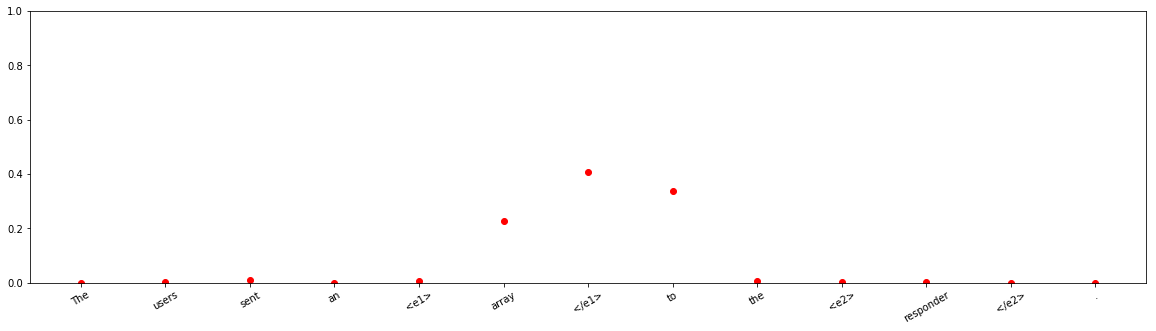




input sentence: Utilizing concrete plank floor/ceiling <e1> construction </e1> benefits the <e2> builder </e2> .
answer label:    Instrument-Agency
wrong label:    Product-Producer
Other 	:	 0.16538371
Cause-Effect 	:	 0.060629163
Component-Whole 	:	 3.661422e-05
Entity-Destination 	:	 5.8199544e-07
Entity-Origin 	:	 2.75742e-09
Product-Producer 	:	 0.77370363
Member-Collection 	:	 1.3416054e-09
Message-Topic 	:	 8.7037205e-07
Content-Container 	:	 1.1836307e-09
Instrument-Agency 	:	 0.00024547338



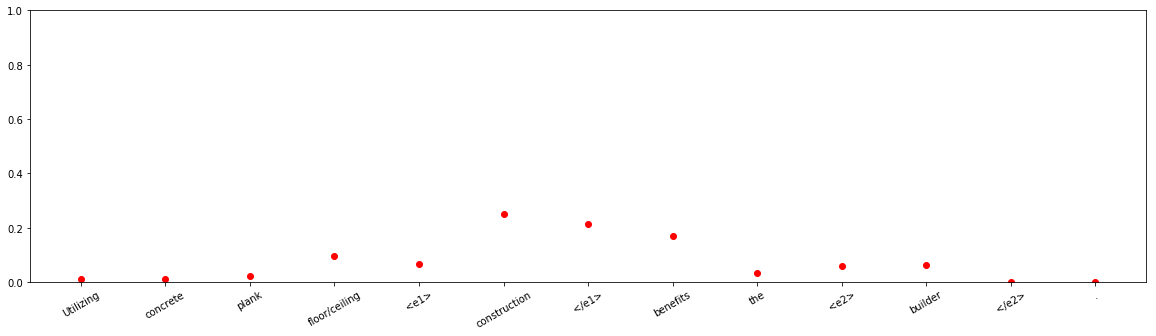




input sentence: The <e1> author </e1> identifies the Piper with the <e2> devil </e2> .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 0.29153082
Cause-Effect 	:	 8.958378e-07
Component-Whole 	:	 1.7175589e-06
Entity-Destination 	:	 9.069341e-08
Entity-Origin 	:	 3.192224e-08
Product-Producer 	:	 0.00010321794
Member-Collection 	:	 2.7996347e-07
Message-Topic 	:	 3.9993767e-05
Content-Container 	:	 2.0983226e-10
Instrument-Agency 	:	 0.70832294



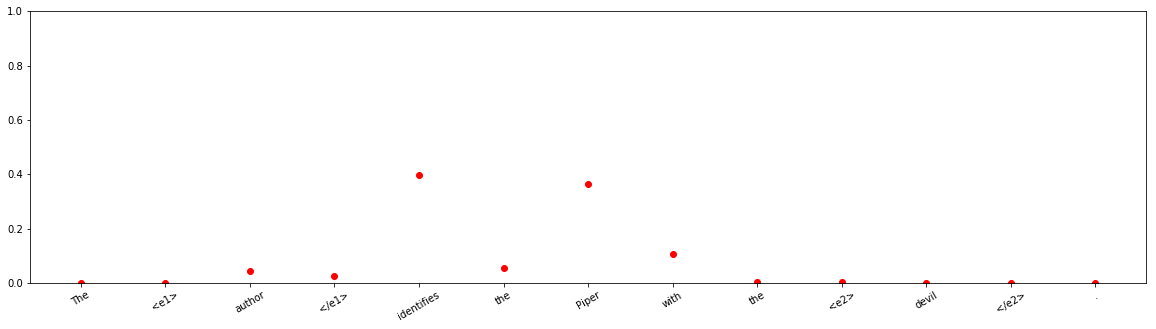










input sentence: You have poured <e1> balm </e1> into my anxious <e2> soul </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 0.0016776446
Cause-Effect 	:	 1.6733438e-07
Component-Whole 	:	 2.6846072e-09
Entity-Destination 	:	 0.99832076
Entity-Origin 	:	 1.4692775e-06
Product-Producer 	:	 2.535362e-10
Member-Collection 	:	 1.3273911e-09
Message-Topic 	:	 9.728828e-10
Content-Container 	:	 1.4743981e-08
Instrument-Agency 	:	 1.9623162e-11



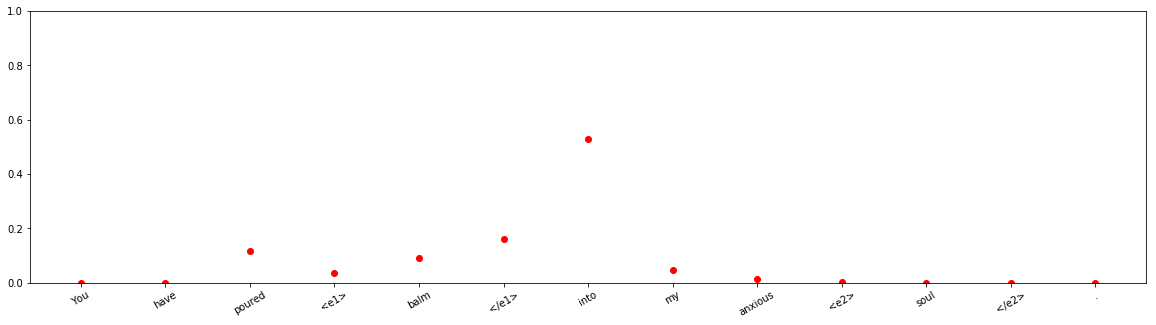












input sentence: I grew up with <e1> milk </e1> in a <e2> sack </e2> .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 4.216214e-06
Cause-Effect 	:	 3.2406396e-07
Component-Whole 	:	 6.9969184e-07
Entity-Destination 	:	 0.9940181
Entity-Origin 	:	 1.4014819e-05
Product-Producer 	:	 0.0033119023
Member-Collection 	:	 6.0302416e-09
Message-Topic 	:	 8.8838203e-07
Content-Container 	:	 0.002649355
Instrument-Agency 	:	 7.4299476e-07



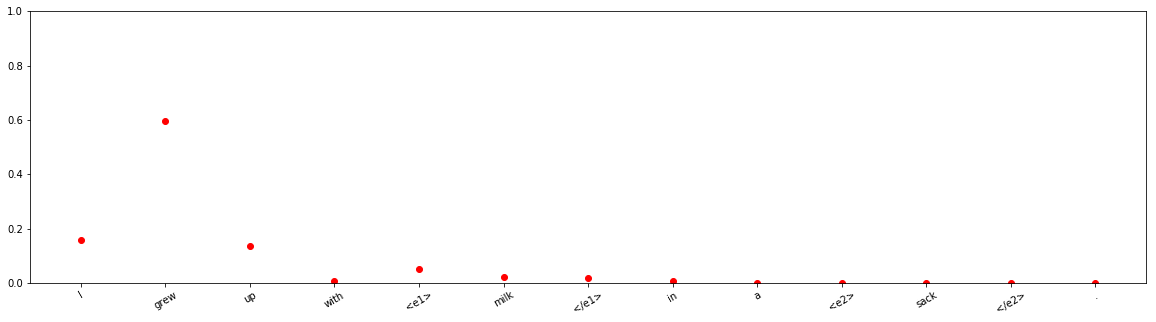






input sentence: Climate change <e1> talks </e1> have been moving into <e2> overtime </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.99325895
Cause-Effect 	:	 6.7766086e-07
Component-Whole 	:	 6.3171233e-06
Entity-Destination 	:	 0.003940397
Entity-Origin 	:	 3.091676e-07
Product-Producer 	:	 1.9380825e-07
Member-Collection 	:	 8.0430357e-10
Message-Topic 	:	 0.002788849
Content-Container 	:	 2.9915284e-08
Instrument-Agency 	:	 4.2042043e-06



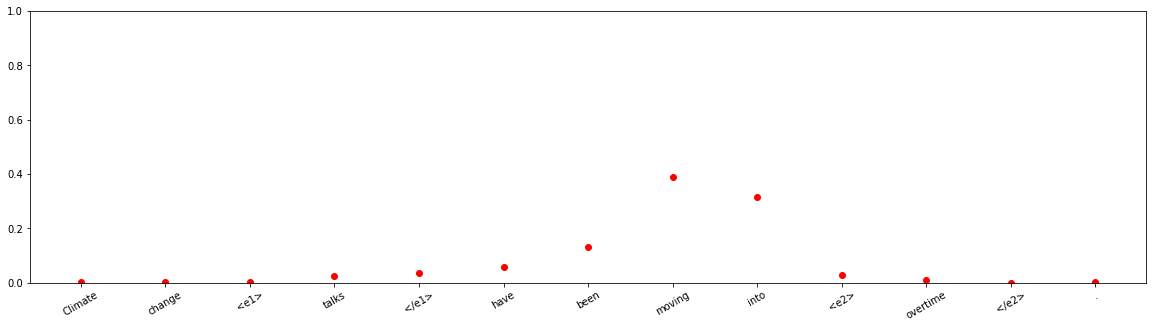







input sentence: The <e1> funds </e1> are invested into renewable energy <e2> schemes </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.93732446
Cause-Effect 	:	 0.00036901812
Component-Whole 	:	 3.1325607e-09
Entity-Destination 	:	 0.061462354
Entity-Origin 	:	 0.0008437882
Product-Producer 	:	 1.3318202e-08
Member-Collection 	:	 1.7828183e-08
Message-Topic 	:	 2.1069906e-07
Content-Container 	:	 2.724427e-08
Instrument-Agency 	:	 7.883853e-09



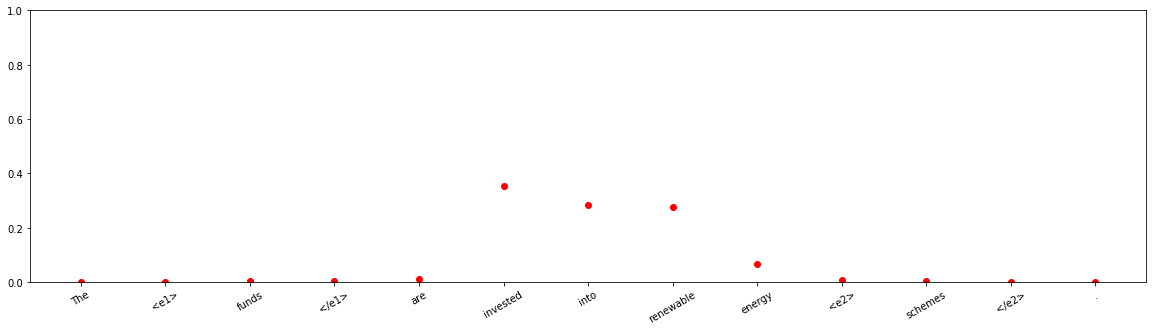



input sentence: The <e1> archives </e1> also publish historical and scientific <e2> studies </e2> .
answer label:    Product-Producer
wrong label:    Message-Topic
Other 	:	 1.9223996e-11
Cause-Effect 	:	 1.4273142e-12
Component-Whole 	:	 1.7809921e-09
Entity-Destination 	:	 1.4660845e-11
Entity-Origin 	:	 3.5694583e-10
Product-Producer 	:	 1.8040905e-09
Member-Collection 	:	 1.361136e-10
Message-Topic 	:	 1.0
Content-Container 	:	 2.4451605e-09
Instrument-Agency 	:	 6.7194995e-12



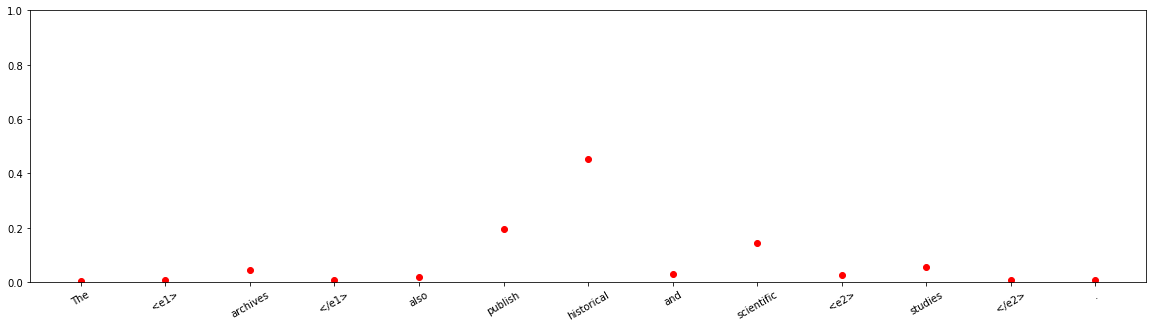


input sentence: The <e1> files </e1> reveal militarist <e2> plot </e2> to kill Yoshida .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.9429935
Cause-Effect 	:	 0.009465976
Component-Whole 	:	 1.5625064e-05
Entity-Destination 	:	 1.8175138e-05
Entity-Origin 	:	 8.738826e-06
Product-Producer 	:	 0.0014641474
Member-Collection 	:	 0.00022128552
Message-Topic 	:	 0.045807198
Content-Container 	:	 2.6065875e-06
Instrument-Agency 	:	 2.695957e-06



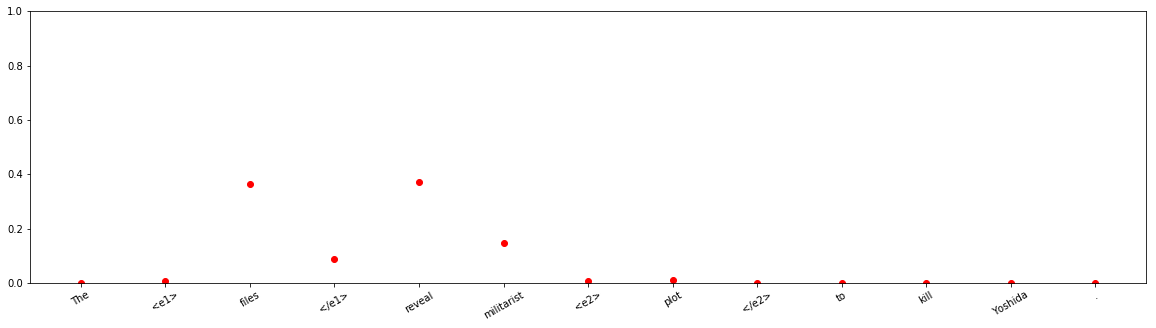









input sentence: The <e1> company </e1> is migrating into profitable new <e2> segments </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 0.0020678127
Cause-Effect 	:	 1.5532058e-11
Component-Whole 	:	 3.2827227e-11
Entity-Destination 	:	 0.997908
Entity-Origin 	:	 9.777814e-06
Product-Producer 	:	 1.3980942e-05
Member-Collection 	:	 4.579808e-09
Message-Topic 	:	 4.5149086e-08
Content-Container 	:	 2.5458344e-10
Instrument-Agency 	:	 4.5485868e-07



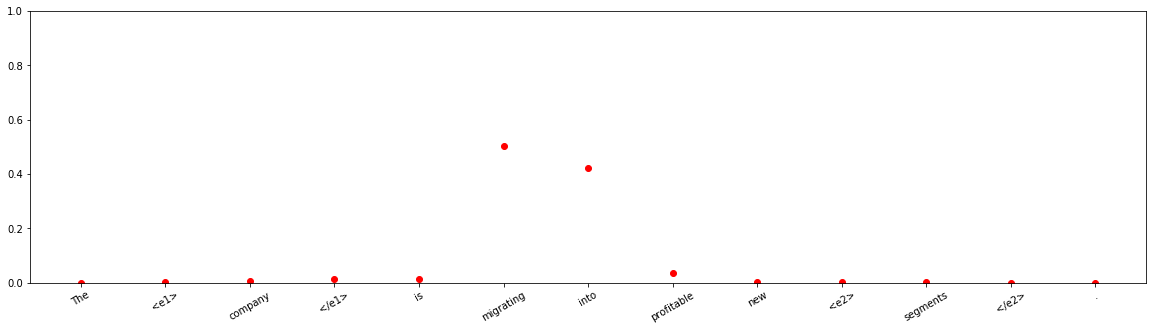





input sentence: We store the <e1> glue </e1> in a cool <e2> place </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 0.0018776873
Cause-Effect 	:	 1.3720496e-07
Component-Whole 	:	 0.004030307
Entity-Destination 	:	 0.9856053
Entity-Origin 	:	 1.6059782e-06
Product-Producer 	:	 2.6305195e-06
Member-Collection 	:	 1.7033287e-06
Message-Topic 	:	 0.00016622803
Content-Container 	:	 0.008244571
Instrument-Agency 	:	 6.975184e-05



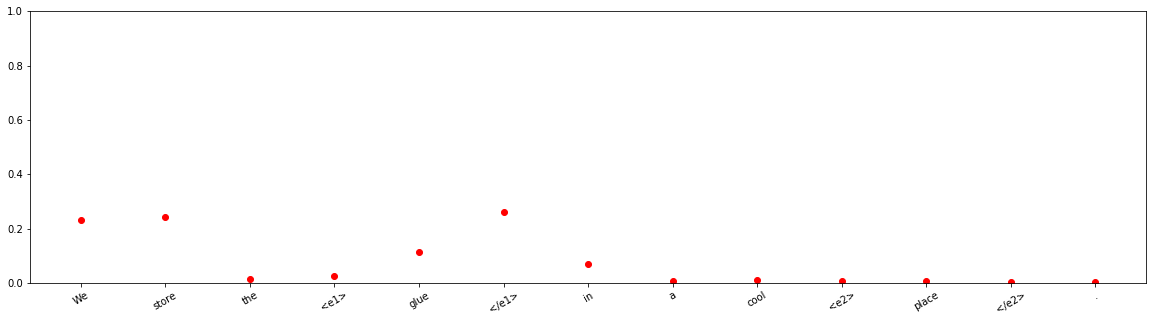





input sentence: This <e1> player </e1> has moved to the <e2> next round </e2> .
answer label:    Other
wrong label:    Entity-Destination
Other 	:	 6.543859e-05
Cause-Effect 	:	 4.549994e-12
Component-Whole 	:	 7.320464e-08
Entity-Destination 	:	 0.9999342
Entity-Origin 	:	 1.6650862e-08
Product-Producer 	:	 3.0977867e-09
Member-Collection 	:	 2.5714478e-10
Message-Topic 	:	 1.0091922e-08
Content-Container 	:	 1.683803e-10
Instrument-Agency 	:	 2.7002477e-07



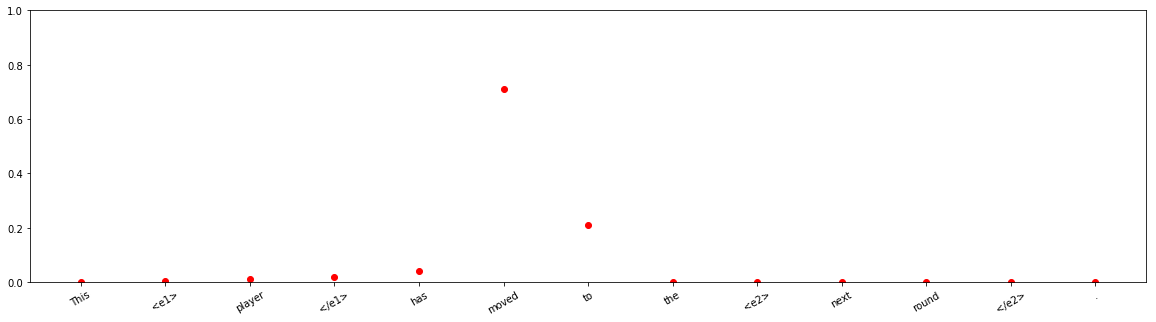





input sentence: Iraqi air force <e1> pilots </e1> took flight into <e2> history </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.704262
Cause-Effect 	:	 5.4069282e-08
Component-Whole 	:	 4.9393e-11
Entity-Destination 	:	 0.28476965
Entity-Origin 	:	 0.010772224
Product-Producer 	:	 8.406141e-06
Member-Collection 	:	 7.762696e-06
Message-Topic 	:	 6.763171e-05
Content-Container 	:	 7.15511e-08
Instrument-Agency 	:	 0.00011215084



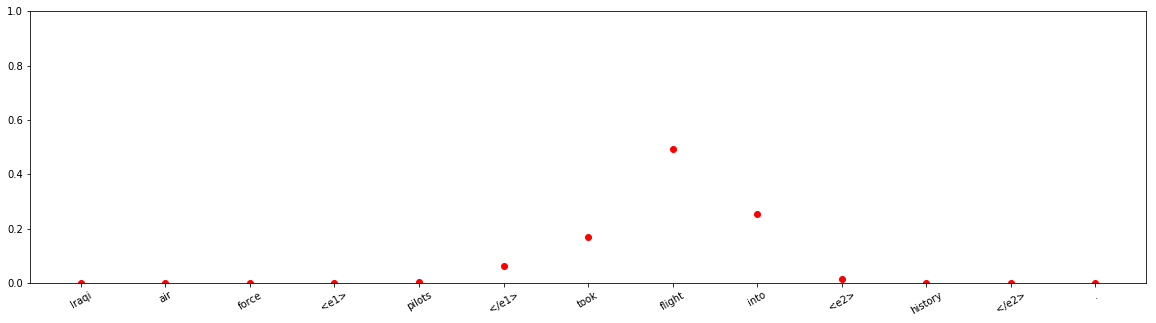


input sentence: The <e1> basin </e1> has sunk into a deep <e2> depression </e2> .
answer label:    Entity-Destination
wrong label:    Other
Other 	:	 0.99999976
Cause-Effect 	:	 4.1738293e-09
Component-Whole 	:	 1.7158939e-07
Entity-Destination 	:	 6.635541e-08
Entity-Origin 	:	 1.6434637e-09
Product-Producer 	:	 2.1509735e-11
Member-Collection 	:	 1.7680303e-11
Message-Topic 	:	 2.4927114e-09
Content-Container 	:	 2.2008445e-11
Instrument-Agency 	:	 1.3781539e-12



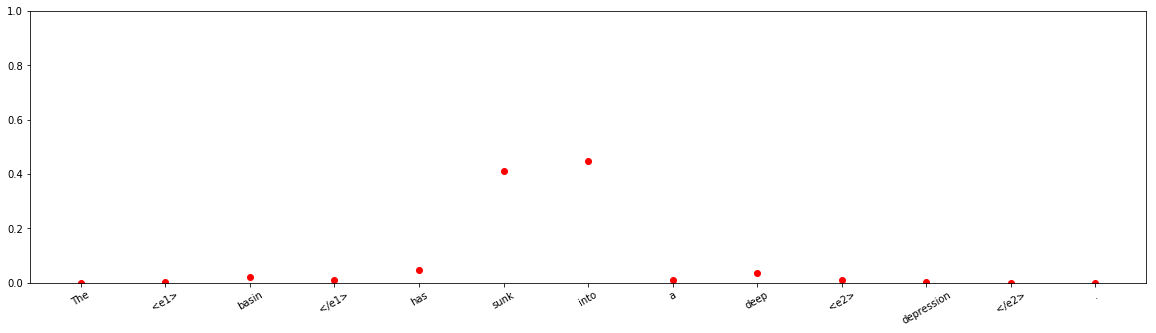















input sentence: The foreign <e1> machineguns </e1> , greasegun , and machine gun pistol were in a <e2> box </e2> about 3 ft long and 2 ft wide , olive drab in color , with white lettering on the box .
answer label:    Content-Container
wrong label:    Instrument-Agency
Other 	:	 1.1366308e-06
Cause-Effect 	:	 4.806266e-07
Component-Whole 	:	 2.1765178e-05
Entity-Destination 	:	 0.00025334407
Entity-Origin 	:	 5.473764e-05
Product-Producer 	:	 0.010584352
Member-Collection 	:	 5.791463e-05
Message-Topic 	:	 2.2857062e-06
Content-Container 	:	 0.37721443
Instrument-Agency 	:	 0.61180955



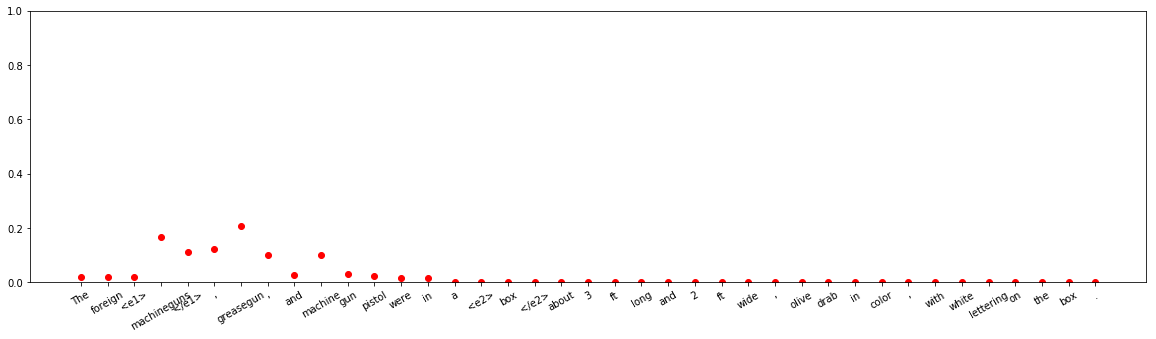







input sentence: After arresting a computer hacker who stole $ 2 million from the Federal Reserve , Jake assumes his identity to infiltrate a <e1> ring </e1> of his <e2> associates </e2> and discover what their next target will be .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.8304703
Cause-Effect 	:	 1.9082678e-07
Component-Whole 	:	 0.00035371186
Entity-Destination 	:	 1.1609024e-08
Entity-Origin 	:	 1.389444e-09
Product-Producer 	:	 1.16492815e-08
Member-Collection 	:	 0.16917285
Message-Topic 	:	 2.3557234e-06
Content-Container 	:	 1.806504e-08
Instrument-Agency 	:	 5.016265e-07



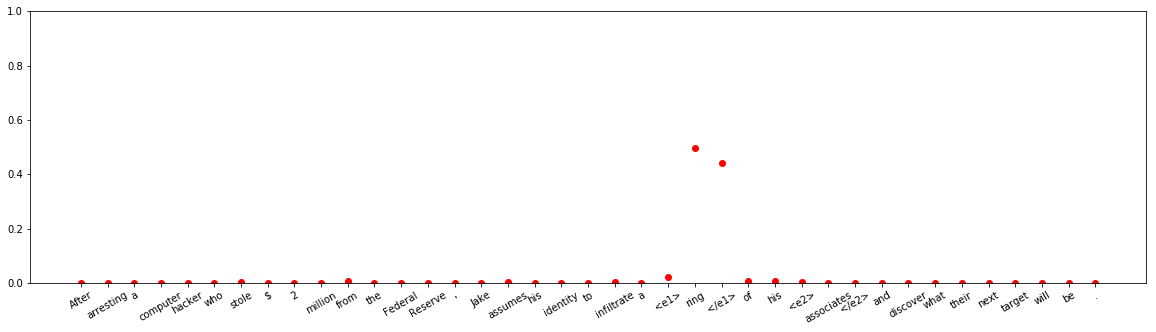



input sentence: Six Flags ' reorganization plan is supported by a steering <e1> committee </e1> of its secured <e2> creditors </e2> and led by investment firm Avenue Capital Management , which would take control of the company under the plan .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9999819
Cause-Effect 	:	 5.584323e-09
Component-Whole 	:	 3.5289333e-06
Entity-Destination 	:	 3.046622e-08
Entity-Origin 	:	 5.9563726e-10
Product-Producer 	:	 5.2729513e-07
Member-Collection 	:	 1.2544117e-05
Message-Topic 	:	 5.2605177e-08
Content-Container 	:	 5.5799654e-10
Instrument-Agency 	:	 1.5925001e-06



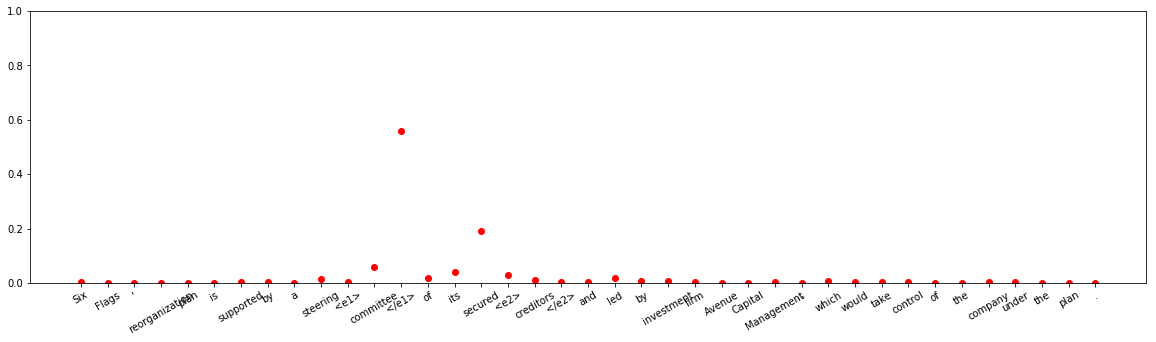



input sentence: Scientists in Cambridge have discovered that a lowly grape <e1> variety </e1> grown by <e2> peasants </e2> - but despised by noblemen - during the Middle Ages was the mother of many of today 's greatest grape varieties .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 0.08437528
Cause-Effect 	:	 1.1895518e-05
Component-Whole 	:	 2.9661965e-07
Entity-Destination 	:	 1.7079955e-09
Entity-Origin 	:	 0.00042916386
Product-Producer 	:	 0.9148789
Member-Collection 	:	 9.948499e-05
Message-Topic 	:	 1.7012133e-07
Content-Container 	:	 2.6815783e-07
Instrument-Agency 	:	 0.000204593



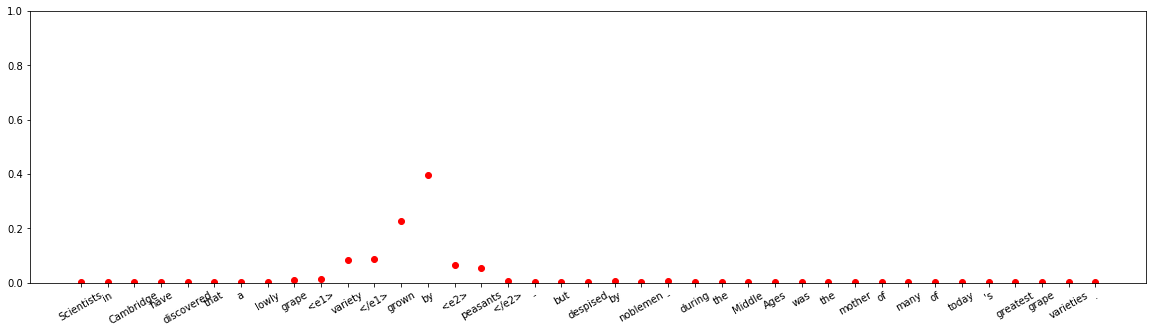




input sentence: Skype , a free software , allows a <e1> hookup </e1> of multiple computer <e2> users </e2> to join in an online conference call without incurring any telephone costs .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.5410198
Cause-Effect 	:	 1.086908e-06
Component-Whole 	:	 0.41770184
Entity-Destination 	:	 2.4555328e-07
Entity-Origin 	:	 4.305365e-08
Product-Producer 	:	 2.5039792e-08
Member-Collection 	:	 0.005817187
Message-Topic 	:	 8.218207e-06
Content-Container 	:	 2.3273739e-07
Instrument-Agency 	:	 0.03545123



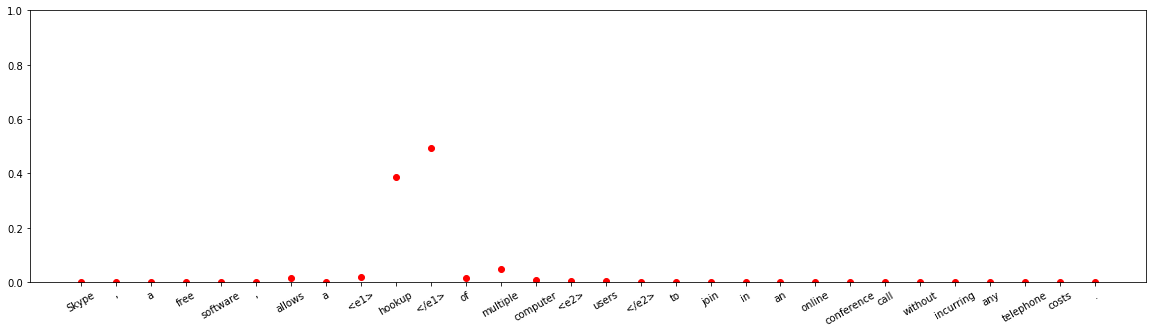



input sentence: The <e1> subject </e1> of `` imply '' is the source of an <e2> implication </e2> while the subject of `` infer '' is the recipient of an implication .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.9692123
Cause-Effect 	:	 0.02369321
Component-Whole 	:	 7.8096626e-08
Entity-Destination 	:	 9.141869e-08
Entity-Origin 	:	 0.0068501295
Product-Producer 	:	 5.500035e-07
Member-Collection 	:	 4.2615713e-07
Message-Topic 	:	 0.00024219412
Content-Container 	:	 1.1852491e-07
Instrument-Agency 	:	 8.3660143e-07



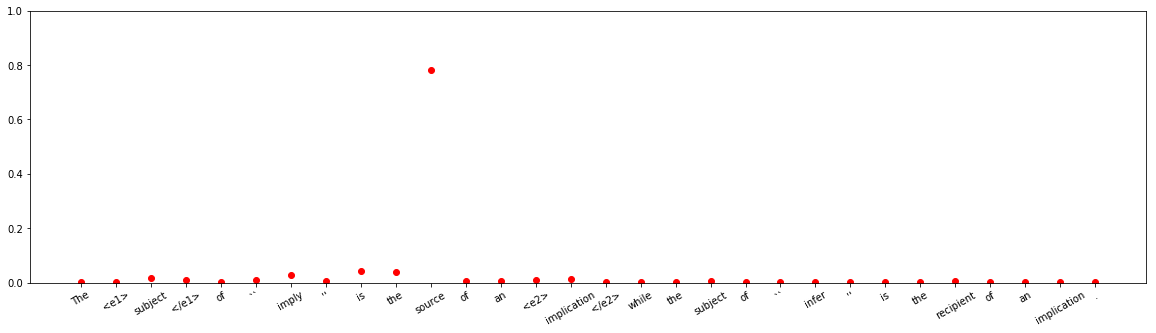













input sentence: A <e1> brick </e1> <e2> mason </e2> is able to use these materials with hand tools and is able to mix the correct mortar to hold it all together .
answer label:    Instrument-Agency
wrong label:    Product-Producer
Other 	:	 2.3033058e-06
Cause-Effect 	:	 1.3639975e-06
Component-Whole 	:	 0.012792297
Entity-Destination 	:	 4.984694e-05
Entity-Origin 	:	 1.7148193e-05
Product-Producer 	:	 0.7156047
Member-Collection 	:	 3.959902e-06
Message-Topic 	:	 1.4510712e-07
Content-Container 	:	 0.0005255598
Instrument-Agency 	:	 0.27100256



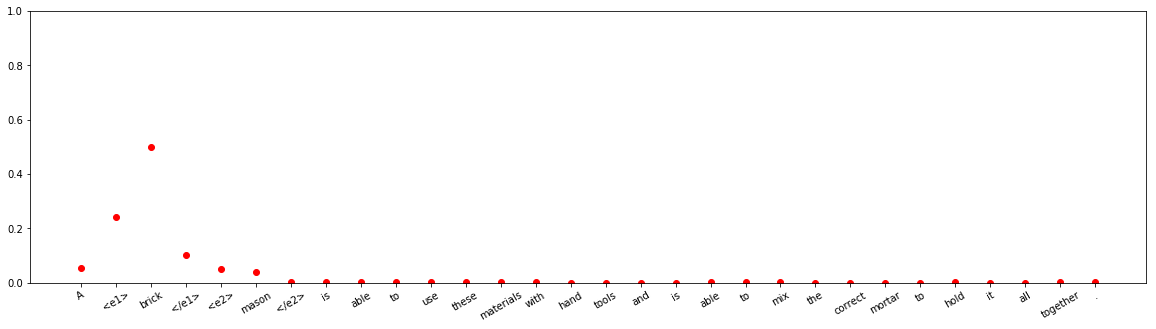




input sentence: The time to the arrival of the first Brownian <e1> particle </e1> from an equilibrated continuum <e2> bath </e2> to an absorbing sphere was shown by Bordewijk in 1975 .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.98046345
Cause-Effect 	:	 0.00070721994
Component-Whole 	:	 1.8099364e-06
Entity-Destination 	:	 0.00024657967
Entity-Origin 	:	 0.018534528
Product-Producer 	:	 4.826906e-10
Member-Collection 	:	 6.5848267e-06
Message-Topic 	:	 6.076081e-06
Content-Container 	:	 5.454503e-07
Instrument-Agency 	:	 3.3196382e-05



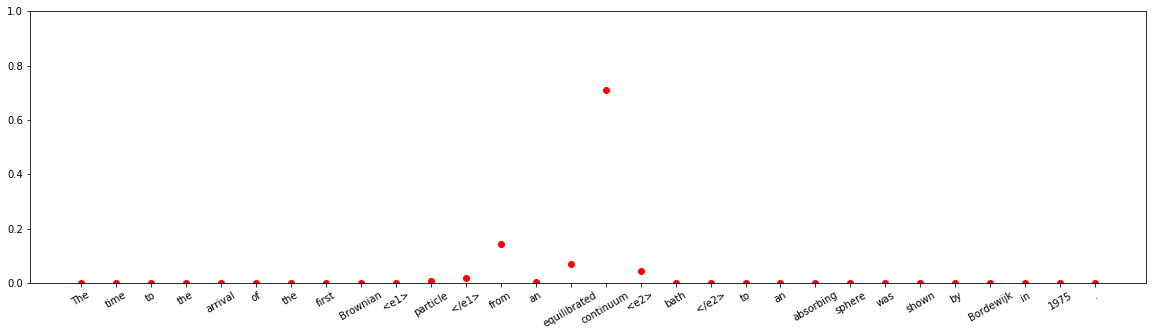


input sentence: Transport authorities in the Western Cape have warned of hefty fines for motorists who ignore dedicated <e1> lane </e1> for buses and minibus taxis on the <e2> road </e2> .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.99768853
Cause-Effect 	:	 1.0178535e-07
Component-Whole 	:	 1.1194069e-06
Entity-Destination 	:	 2.7662749e-05
Entity-Origin 	:	 1.5263744e-05
Product-Producer 	:	 9.7653805e-09
Member-Collection 	:	 1.9761858e-08
Message-Topic 	:	 2.2528873e-05
Content-Container 	:	 9.62544e-11
Instrument-Agency 	:	 0.0022448783



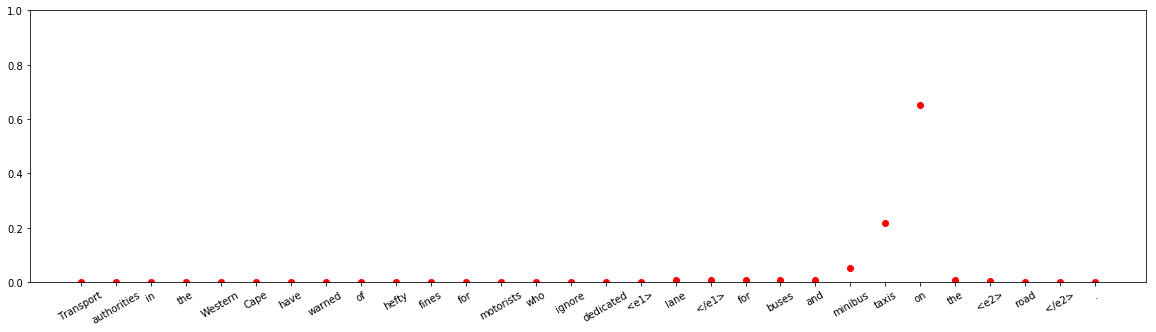















input sentence: The rural European 'stem family ' , or extended <e1> family </e1> , consisting of parents and one married <e2> child </e2> who would eventually inherit the family property .
answer label:    Member-Collection
wrong label:    Component-Whole
Other 	:	 0.028422587
Cause-Effect 	:	 6.4258654e-07
Component-Whole 	:	 0.9672706
Entity-Destination 	:	 8.6625834e-10
Entity-Origin 	:	 4.8182687e-06
Product-Producer 	:	 0.00017156475
Member-Collection 	:	 0.0040964843
Message-Topic 	:	 1.01516164e-07
Content-Container 	:	 1.9502733e-07
Instrument-Agency 	:	 3.2805812e-05



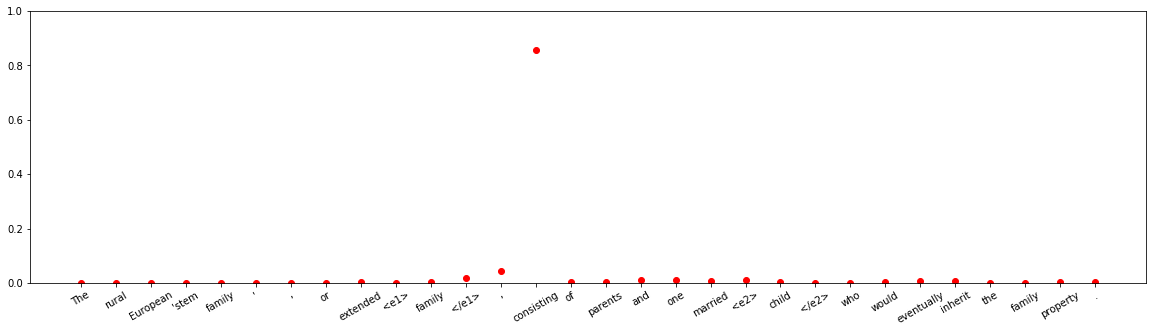
















input sentence: Both her and her <e1> troop </e1> of pampered Beverly Hills <e2> princesses </e2> learn valuable lessons in character , courage , and friendship with a super happy ending .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.58276606
Cause-Effect 	:	 5.8907023e-08
Component-Whole 	:	 0.00014953023
Entity-Destination 	:	 3.7768727e-06
Entity-Origin 	:	 4.166354e-07
Product-Producer 	:	 2.7089052e-06
Member-Collection 	:	 0.41661838
Message-Topic 	:	 0.0004570993
Content-Container 	:	 1.0994083e-06
Instrument-Agency 	:	 8.840989e-07



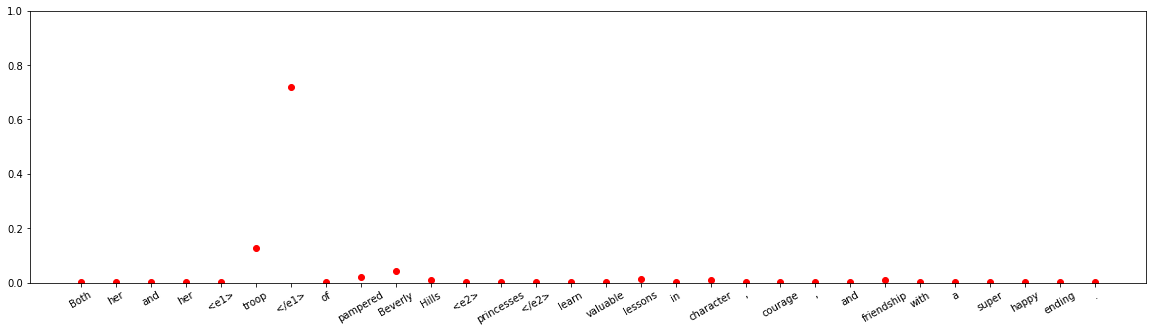


input sentence: The inside of your <e1> nose </e1> is lined with a moist , thin layer of <e2> tissue </e2> called a mucous membrane ( say : myoo-kus mem-brayne ) .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.059310153
Cause-Effect 	:	 1.2994653e-06
Component-Whole 	:	 0.940675
Entity-Destination 	:	 1.2997789e-06
Entity-Origin 	:	 9.707351e-07
Product-Producer 	:	 5.4633922e-08
Member-Collection 	:	 4.6615675e-08
Message-Topic 	:	 2.5387916e-07
Content-Container 	:	 8.0988764e-07
Instrument-Agency 	:	 1.01374835e-05



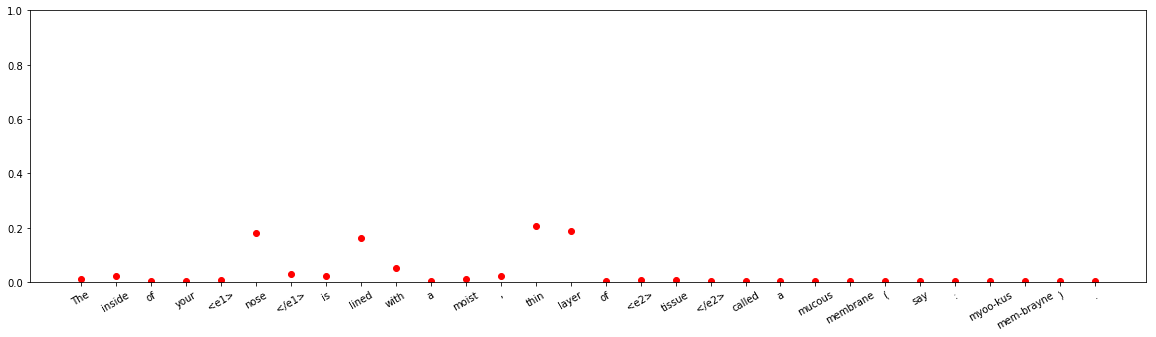



input sentence: At the moment , we have to expend a great deal of effort to fight black Sigatoka , which attacks the banana <e1> plant </e1> 's <e2> leaves </e2> .
answer label:    Component-Whole
wrong label:    Product-Producer
Other 	:	 0.074128605
Cause-Effect 	:	 9.378126e-05
Component-Whole 	:	 0.0011363903
Entity-Destination 	:	 2.4121226e-05
Entity-Origin 	:	 0.01697336
Product-Producer 	:	 0.9073622
Member-Collection 	:	 1.6969011e-06
Message-Topic 	:	 2.8173267e-06
Content-Container 	:	 5.3560843e-06
Instrument-Agency 	:	 0.0002716051



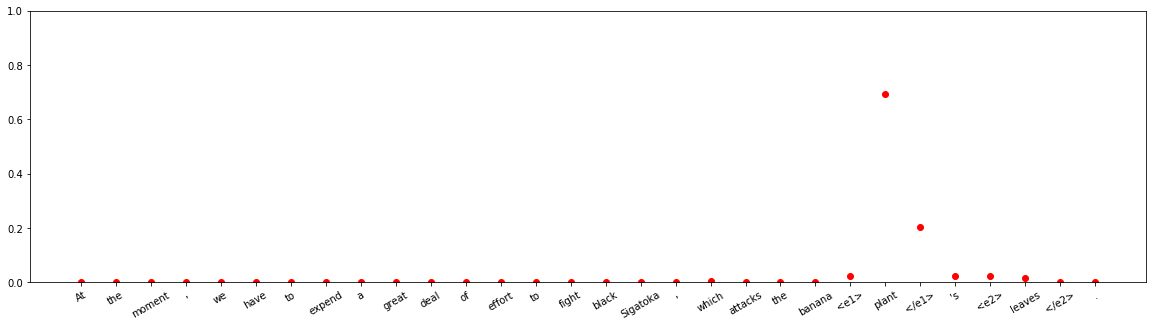








input sentence: A 7-month-old <e1> baby </e1> was locked in a 2-by-3 foot <e2> cedar chest </e2> hidden underneath her aunt 's bed for 12 hours before police found her Wednesday .
answer label:    Other
wrong label:    Content-Container
Other 	:	 2.9301378e-10
Cause-Effect 	:	 8.1022797e-13
Component-Whole 	:	 1.2930805e-07
Entity-Destination 	:	 7.060923e-06
Entity-Origin 	:	 3.732048e-09
Product-Producer 	:	 8.101774e-12
Member-Collection 	:	 1.7443156e-08
Message-Topic 	:	 2.7213715e-10
Content-Container 	:	 0.99999285
Instrument-Agency 	:	 5.6144567e-10



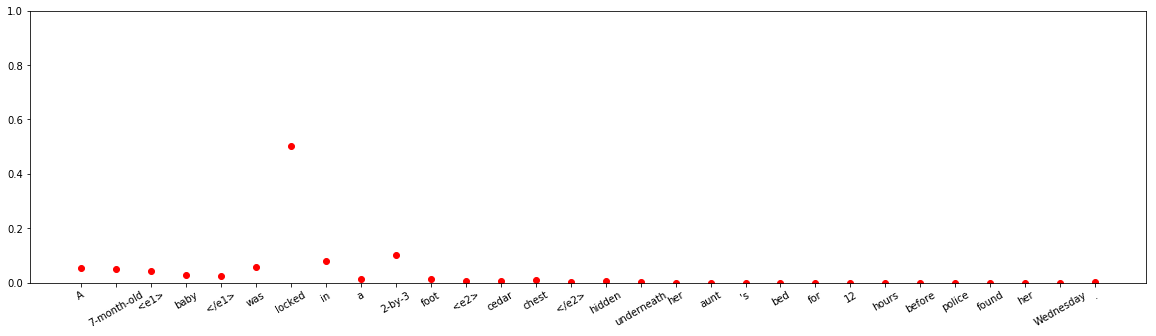









input sentence: A <e1> paper </e1> co-authored by JRC <e2> staff </e2> entitled `` Plutonium-based superconductivity with a transition temperature above 18K '' was published on 21 November in Nature magazine .
answer label:    Product-Producer
wrong label:    Message-Topic
Other 	:	 2.4588688e-05
Cause-Effect 	:	 0.00027555623
Component-Whole 	:	 0.010159751
Entity-Destination 	:	 1.4569898e-07
Entity-Origin 	:	 8.3542346e-07
Product-Producer 	:	 0.2811427
Member-Collection 	:	 1.0580264e-05
Message-Topic 	:	 0.6969191
Content-Container 	:	 9.4522264e-05
Instrument-Agency 	:	 0.011372183



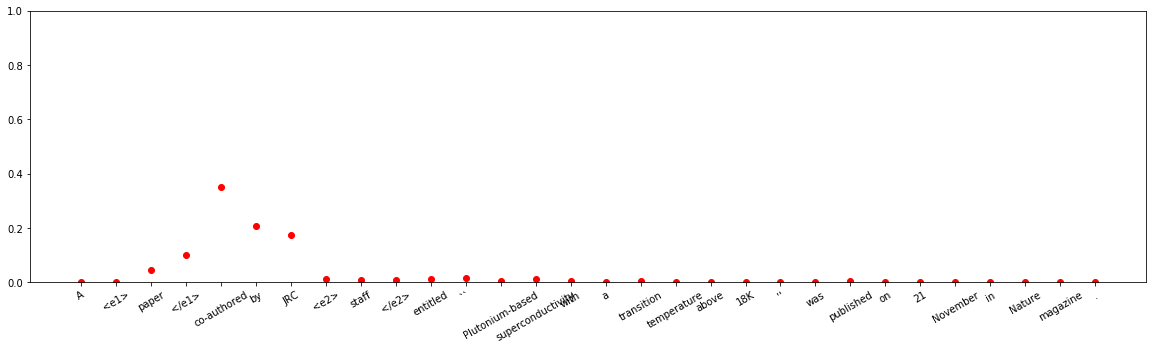








input sentence: They shop there for a huge selection of furniture and table legs , carved and turned <e1> furniture </e1> <e2> legs </e2> and feet , wood turnings and more .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 6.6491447e-07
Cause-Effect 	:	 1.9224062e-09
Component-Whole 	:	 0.9999987
Entity-Destination 	:	 1.7701111e-10
Entity-Origin 	:	 3.0955174e-09
Product-Producer 	:	 1.1668665e-08
Member-Collection 	:	 7.77841e-08
Message-Topic 	:	 2.0676626e-10
Content-Container 	:	 1.6867807e-08
Instrument-Agency 	:	 4.1985692e-07



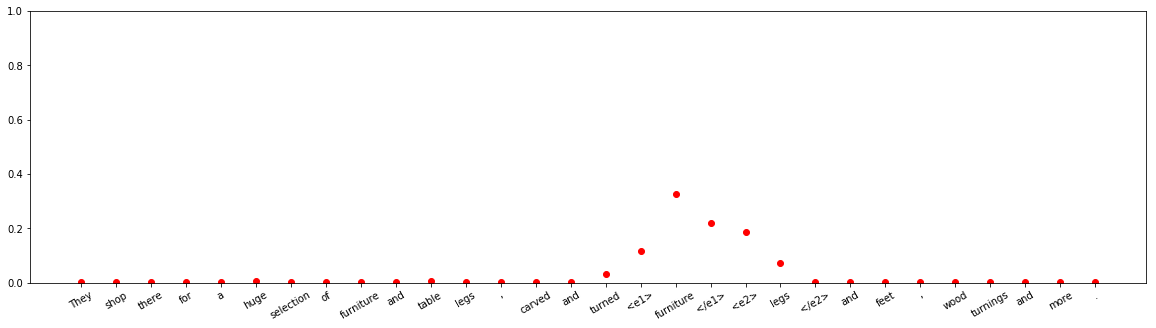


input sentence: When a <e1> property </e1> is the source of a data binding <e2> expression </e2> , Flex automatically copies the value of the source property to any destination property .
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.9874999
Cause-Effect 	:	 0.00454063
Component-Whole 	:	 2.9969684e-07
Entity-Destination 	:	 3.3512113e-06
Entity-Origin 	:	 0.007819943
Product-Producer 	:	 9.4889157e-07
Member-Collection 	:	 1.5070918e-06
Message-Topic 	:	 5.598247e-07
Content-Container 	:	 3.1655262e-07
Instrument-Agency 	:	 0.00013242858



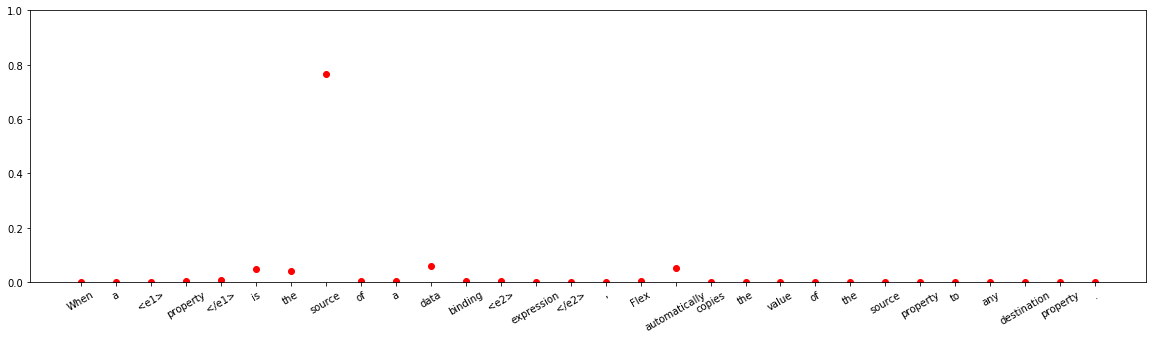



input sentence: The children , seated on their mother 's laps , played with toys on a table in front of a <e1> picture </e1> with <e2> holes </e2> in it .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.8161862
Cause-Effect 	:	 6.9208517e-07
Component-Whole 	:	 0.113148086
Entity-Destination 	:	 0.0007715201
Entity-Origin 	:	 6.2709187e-06
Product-Producer 	:	 0.00013503684
Member-Collection 	:	 0.001517249
Message-Topic 	:	 0.046941813
Content-Container 	:	 0.012874522
Instrument-Agency 	:	 0.008418581



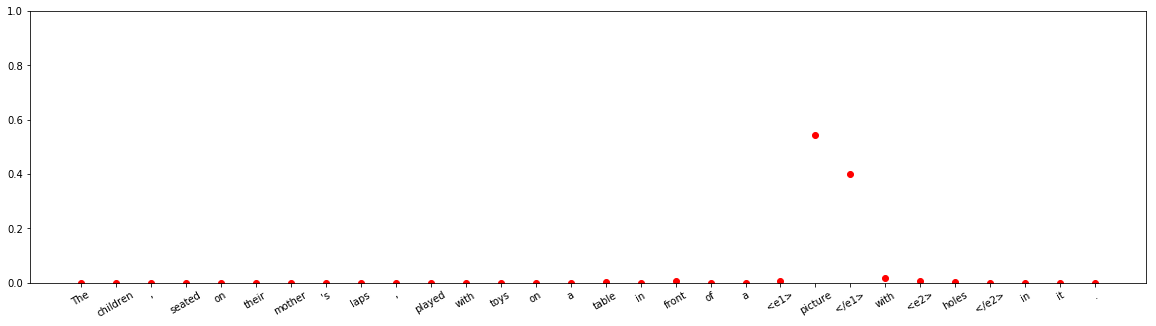



input sentence: Officer Daniel testified that the <e1> methamphetamine </e1> was inside a glass <e2> container </e2> that was placed and sealed inside a `` Winnie the Pooh '' plastic container .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 5.3336935e-06
Cause-Effect 	:	 3.2779676e-10
Component-Whole 	:	 2.7996823e-08
Entity-Destination 	:	 0.96678823
Entity-Origin 	:	 9.817913e-06
Product-Producer 	:	 2.7108278e-09
Member-Collection 	:	 7.0065553e-10
Message-Topic 	:	 7.763372e-08
Content-Container 	:	 0.033196334
Instrument-Agency 	:	 1.5272626e-07



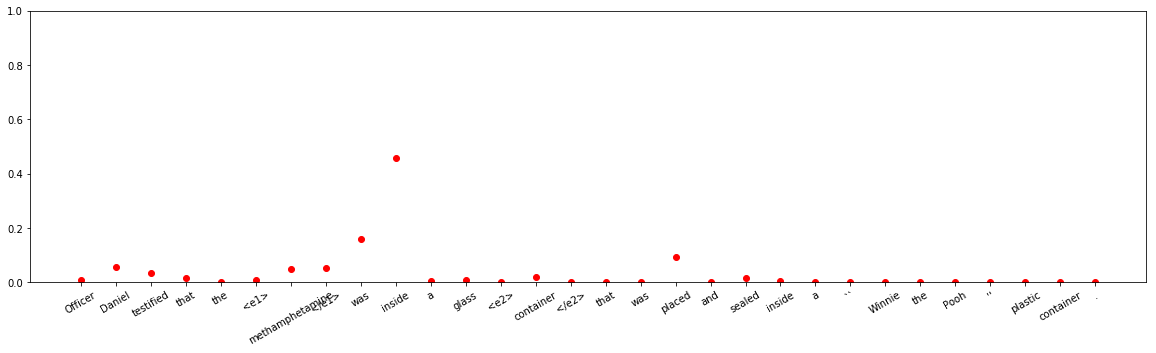





input sentence: The purpose of this funding , a <e1> memo </e1> from the <e2> chairman </e2> of RJ Reynolds shows , was to `` refute the criticisms against cigarettes '' .
answer label:    Product-Producer
wrong label:    Entity-Origin
Other 	:	 0.00061394664
Cause-Effect 	:	 2.613082e-05
Component-Whole 	:	 1.234101e-08
Entity-Destination 	:	 9.935066e-08
Entity-Origin 	:	 0.9876304
Product-Producer 	:	 0.011657918
Member-Collection 	:	 5.009589e-05
Message-Topic 	:	 2.0741596e-05
Content-Container 	:	 5.806632e-07
Instrument-Agency 	:	 1.7499145e-08



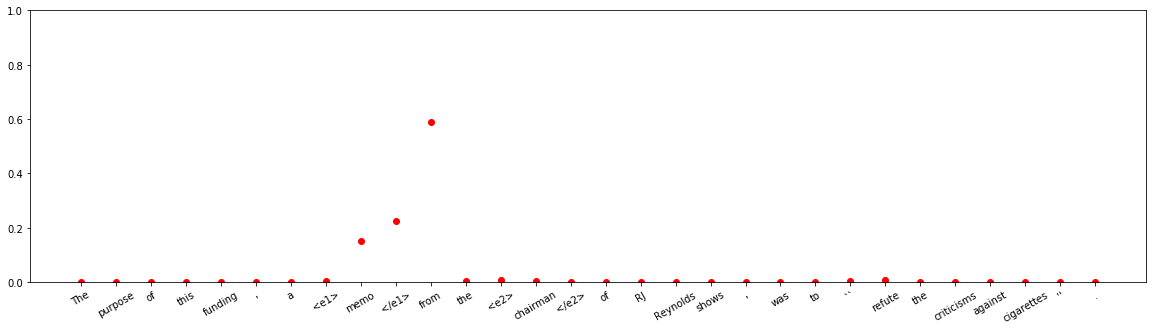




input sentence: Part of the seam had been opened up and a roasting <e1> pan </e1> filled with wet <e2> spaghetti </e2> , cherry pie filling and jello was put inside .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 0.16528438
Cause-Effect 	:	 2.2089464e-06
Component-Whole 	:	 0.15572818
Entity-Destination 	:	 0.58616453
Entity-Origin 	:	 5.3588148e-05
Product-Producer 	:	 1.04008495e-05
Member-Collection 	:	 1.9484898e-07
Message-Topic 	:	 5.247141e-06
Content-Container 	:	 0.09267892
Instrument-Agency 	:	 7.229238e-05



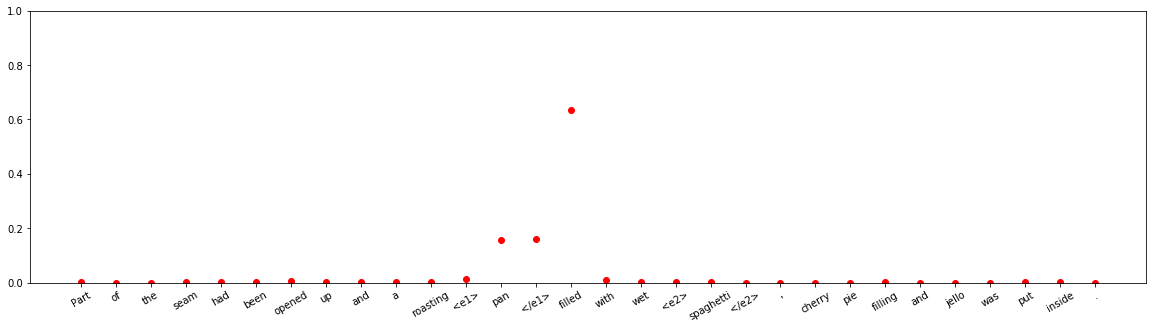






input sentence: At the public inquiry into the disaster <e1> firefighters </e1> described the <e2> horror </e2> that faced them when they arrived at the scene of the Paddington rail crash .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.34353593
Cause-Effect 	:	 0.0017791195
Component-Whole 	:	 1.898504e-06
Entity-Destination 	:	 2.894885e-05
Entity-Origin 	:	 3.7317927e-09
Product-Producer 	:	 9.056707e-07
Member-Collection 	:	 4.458188e-07
Message-Topic 	:	 0.6544507
Content-Container 	:	 9.607103e-09
Instrument-Agency 	:	 0.00020209122



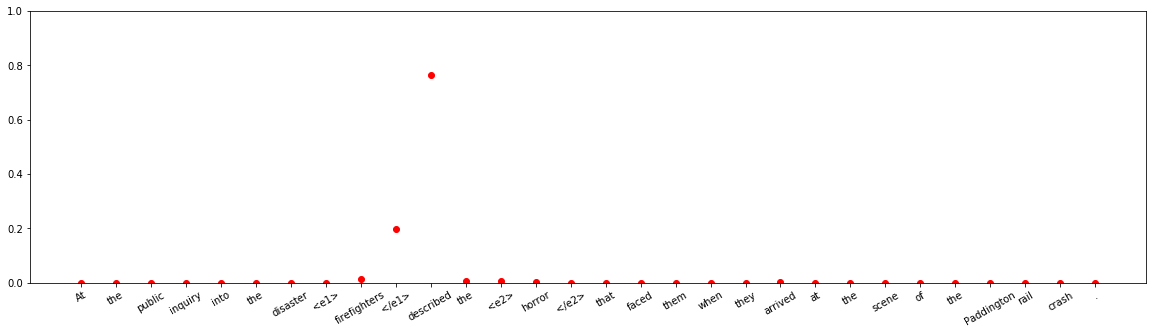


input sentence: After 2000 , his <e1> research </e1> has concerned <e2> environmental issues </e2> in South Africa .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 2.0400575e-08
Cause-Effect 	:	 1.3596324e-12
Component-Whole 	:	 4.0612055e-11
Entity-Destination 	:	 2.7719984e-13
Entity-Origin 	:	 4.434385e-12
Product-Producer 	:	 2.6749042e-11
Member-Collection 	:	 8.6116414e-10
Message-Topic 	:	 1.0
Content-Container 	:	 3.40285e-11
Instrument-Agency 	:	 3.0482154e-13



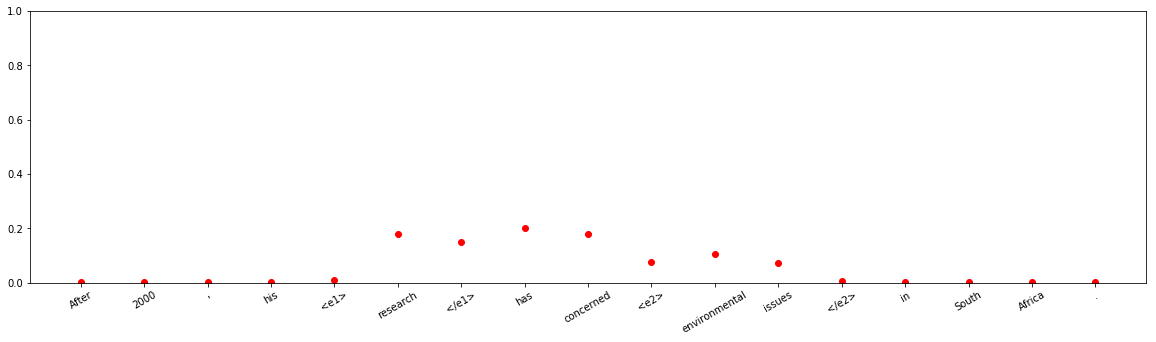







input sentence: The <e1> guard </e1> did his job with a scowling <e2> look </e2> on his face .
answer label:    Other
wrong label:    Instrument-Agency
Other 	:	 5.2680607e-05
Cause-Effect 	:	 1.9959568e-08
Component-Whole 	:	 0.0004898373
Entity-Destination 	:	 6.4365946e-07
Entity-Origin 	:	 1.5168221e-09
Product-Producer 	:	 0.042544257
Member-Collection 	:	 3.2206092e-08
Message-Topic 	:	 1.7576915e-07
Content-Container 	:	 1.019612e-06
Instrument-Agency 	:	 0.9569113



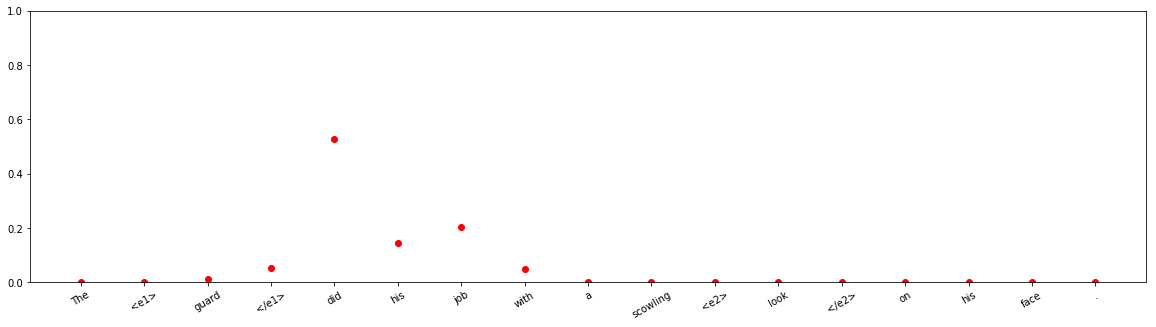




input sentence: She had left her notebook out on the <e1> fire </e1> escape by <e2> accident </e2> .
answer label:    Other
wrong label:    Cause-Effect
Other 	:	 0.008576196
Cause-Effect 	:	 0.9914238
Component-Whole 	:	 6.713321e-10
Entity-Destination 	:	 3.156623e-10
Entity-Origin 	:	 1.4958045e-08
Product-Producer 	:	 3.5324596e-10
Member-Collection 	:	 6.394979e-11
Message-Topic 	:	 1.5876229e-09
Content-Container 	:	 5.105075e-13
Instrument-Agency 	:	 1.0726265e-08



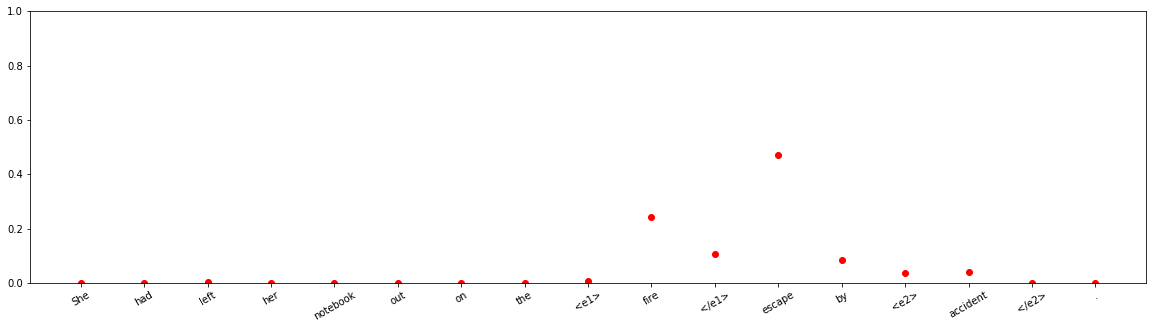









input sentence: <e1> References </e1> to the hearing transcript are denoted by volume and page <e2> numbers </e2> .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 0.32044736
Cause-Effect 	:	 0.0007909373
Component-Whole 	:	 0.1368295
Entity-Destination 	:	 0.0012980757
Entity-Origin 	:	 0.0008841511
Product-Producer 	:	 0.13560279
Member-Collection 	:	 0.003111538
Message-Topic 	:	 0.37635112
Content-Container 	:	 0.003093628
Instrument-Agency 	:	 0.021591006



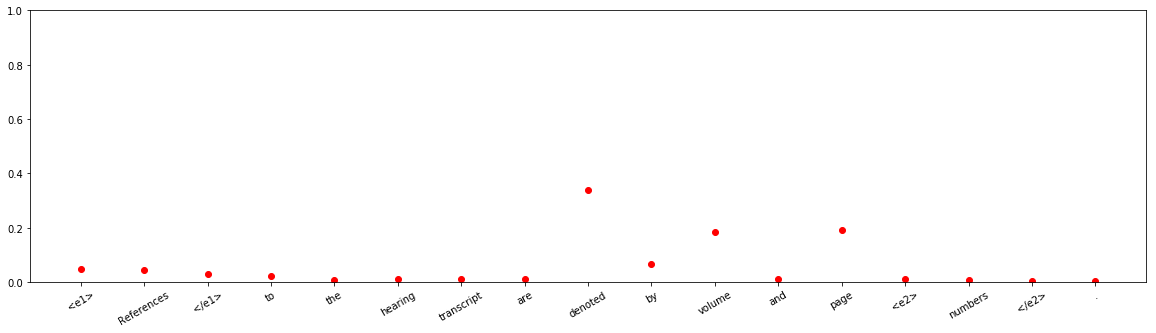




input sentence: On a friend 's advice , I purchased a sauerkraut and <e1> kimchi </e1> <e2> maker </e2> here and it is just fabulous ( and cheap too ) .
answer label:    Other
wrong label:    Product-Producer
Other 	:	 9.1323377e-10
Cause-Effect 	:	 5.9988e-08
Component-Whole 	:	 3.809794e-10
Entity-Destination 	:	 4.993013e-09
Entity-Origin 	:	 1.204388e-06
Product-Producer 	:	 0.99999857
Member-Collection 	:	 5.0544924e-12
Message-Topic 	:	 2.8980686e-13
Content-Container 	:	 8.4014545e-08
Instrument-Agency 	:	 2.7486937e-08



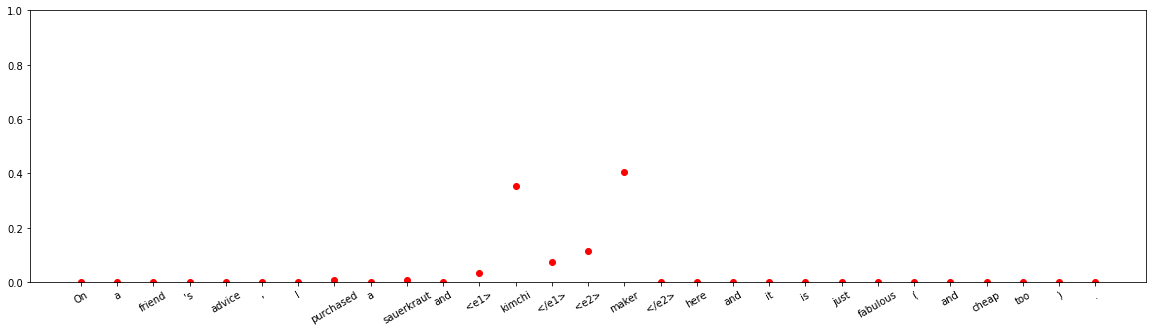


input sentence: The <e1> family </e1> constructed some TCU Horned Frog supporting snow <e2> features </e2> as well as just a really nice picture of an old fashioned light post .
answer label:    Product-Producer
wrong label:    Component-Whole
Other 	:	 0.004735087
Cause-Effect 	:	 1.6976962e-08
Component-Whole 	:	 0.9924114
Entity-Destination 	:	 1.4242889e-07
Entity-Origin 	:	 5.522041e-07
Product-Producer 	:	 0.0027460214
Member-Collection 	:	 2.5882295e-07
Message-Topic 	:	 5.196553e-07
Content-Container 	:	 1.11573875e-07
Instrument-Agency 	:	 0.00010602556



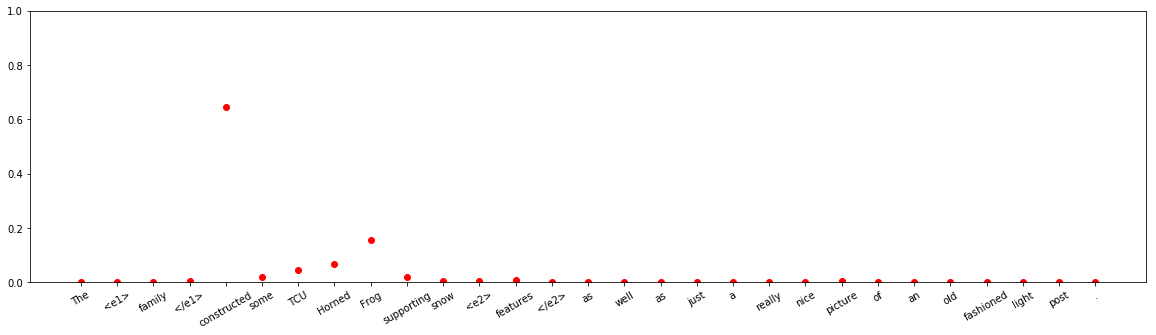


input sentence: Ambassador SUN Shuzhong answered the <e1> questions </e1> from the local <e2> press </e2> after his visit to the Memorial Center in Kigali on Dec. 28 , 2007 .
answer label:    Product-Producer
wrong label:    Entity-Origin
Other 	:	 0.0027049715
Cause-Effect 	:	 0.00042819936
Component-Whole 	:	 2.71252e-05
Entity-Destination 	:	 0.00047128508
Entity-Origin 	:	 0.9962255
Product-Producer 	:	 1.8296007e-06
Member-Collection 	:	 3.891405e-09
Message-Topic 	:	 0.00013884825
Content-Container 	:	 2.8736373e-08
Instrument-Agency 	:	 2.419834e-06



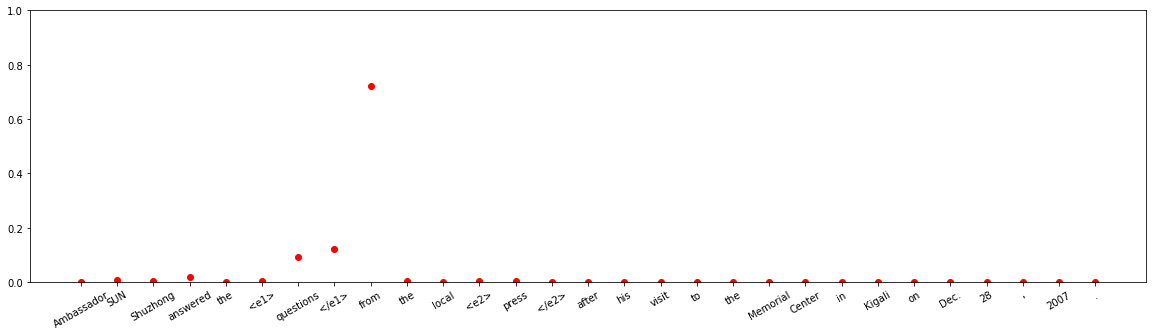





input sentence: Sci-Fi Channel is the <e1> cable network </e1> exclusively dedicated to offering classic <e2> science fiction TV shows </e2> and movies , as well as bold original programming .
answer label:    Other
wrong label:    Message-Topic
Other 	:	 5.282616e-07
Cause-Effect 	:	 8.1809e-11
Component-Whole 	:	 0.00031469623
Entity-Destination 	:	 1.3712516e-07
Entity-Origin 	:	 4.1817415e-08
Product-Producer 	:	 1.7195813e-06
Member-Collection 	:	 1.6730294e-08
Message-Topic 	:	 0.99968266
Content-Container 	:	 1.3285036e-07
Instrument-Agency 	:	 9.335609e-08



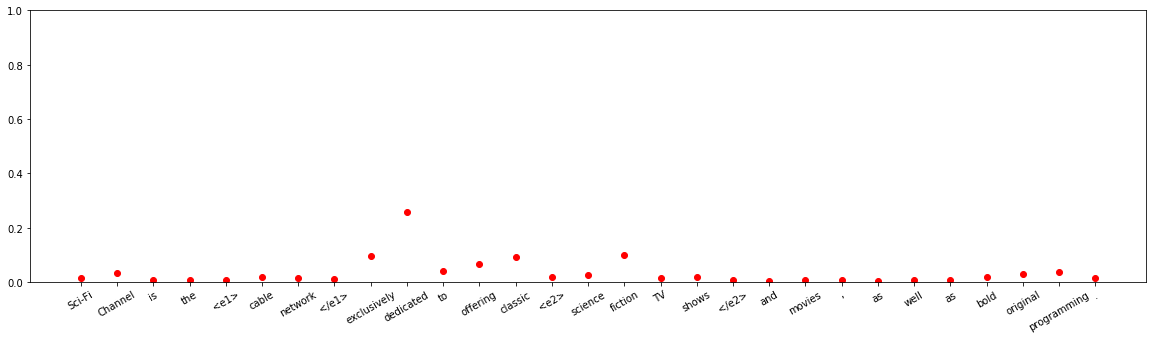












input sentence: We study the influence of an external electromagnetic field of 1.8 GHz in the formation or disaggregation of long <e1> rouleau </e1> of identical erythrocyte <e2> cells </e2> .
answer label:    Component-Whole
wrong label:    Other
Other 	:	 0.9982249
Cause-Effect 	:	 3.1197706e-07
Component-Whole 	:	 1.4199944e-05
Entity-Destination 	:	 2.13398e-08
Entity-Origin 	:	 3.241727e-08
Product-Producer 	:	 5.053132e-10
Member-Collection 	:	 0.0017350857
Message-Topic 	:	 2.541438e-05
Content-Container 	:	 1.5209354e-08
Instrument-Agency 	:	 1.2149487e-10



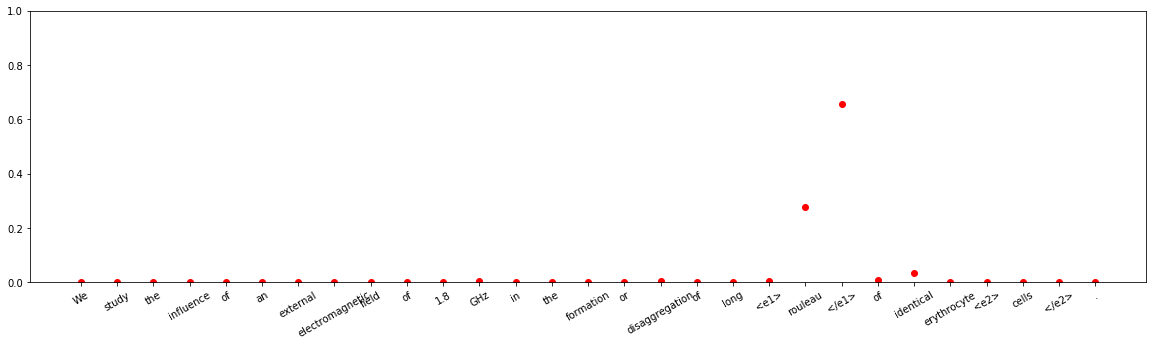



input sentence: The <e1> lychee </e1> stuffed in the meat stirs the palate with a resonating <e2> note </e2> of citrus while the elusive taste of the lotus leaves fades .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.0017375903
Cause-Effect 	:	 0.0034645714
Component-Whole 	:	 0.99479043
Entity-Destination 	:	 1.7774086e-07
Entity-Origin 	:	 2.9845188e-07
Product-Producer 	:	 1.9982487e-08
Member-Collection 	:	 2.458408e-06
Message-Topic 	:	 2.729178e-08
Content-Container 	:	 3.0849028e-06
Instrument-Agency 	:	 1.4383404e-06



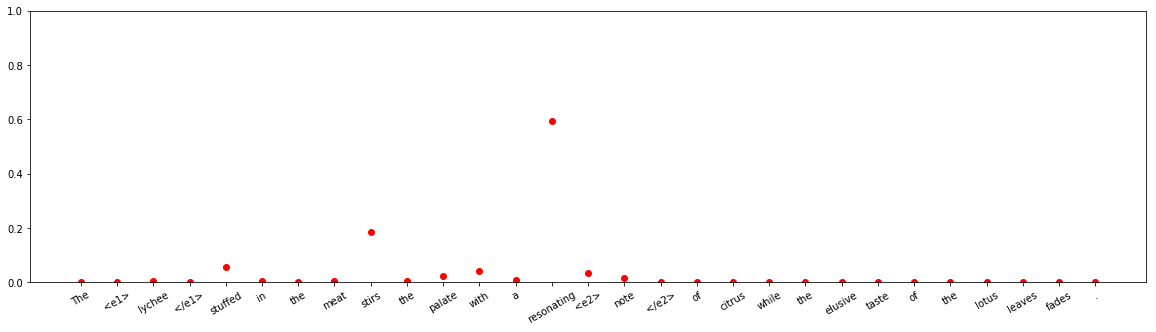





input sentence: After the <e1> drug </e1> leaves the <e2> brain </e2> , the user may experience a `` coke crash '' that causes the user to feel depressed and irritable
answer label:    Entity-Origin
wrong label:    Other
Other 	:	 0.9924407
Cause-Effect 	:	 2.8609666e-05
Component-Whole 	:	 1.6543687e-07
Entity-Destination 	:	 8.119541e-08
Entity-Origin 	:	 0.007464809
Product-Producer 	:	 8.9357385e-08
Member-Collection 	:	 1.4025957e-08
Message-Topic 	:	 9.004616e-09
Content-Container 	:	 7.160681e-10
Instrument-Agency 	:	 6.553316e-05



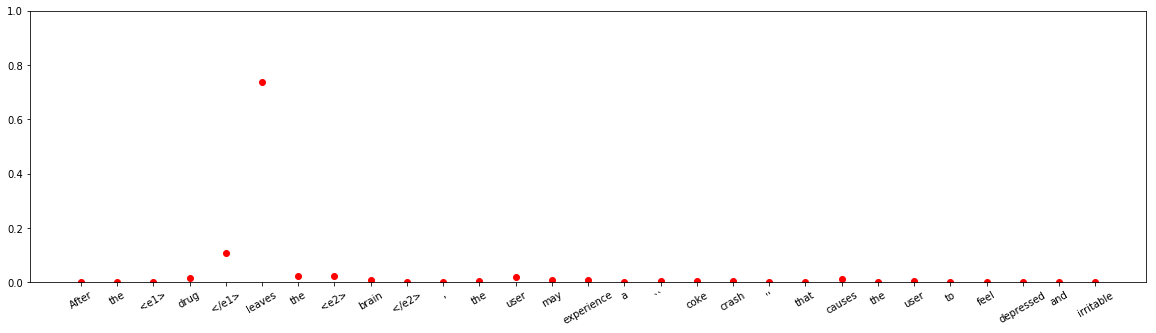






input sentence: The use of mathematical models and numerical techniques is a practice employed by a growing <e1> number </e1> of applied <e2> mathematicians </e2> working on applications in finance .
answer label:    Member-Collection
wrong label:    Instrument-Agency
Other 	:	 0.0045692837
Cause-Effect 	:	 1.2007013e-05
Component-Whole 	:	 0.21836795
Entity-Destination 	:	 2.6305003e-07
Entity-Origin 	:	 1.2099255e-07
Product-Producer 	:	 0.00069630373
Member-Collection 	:	 0.03497999
Message-Topic 	:	 7.3911244e-05
Content-Container 	:	 2.7782096e-06
Instrument-Agency 	:	 0.74129736



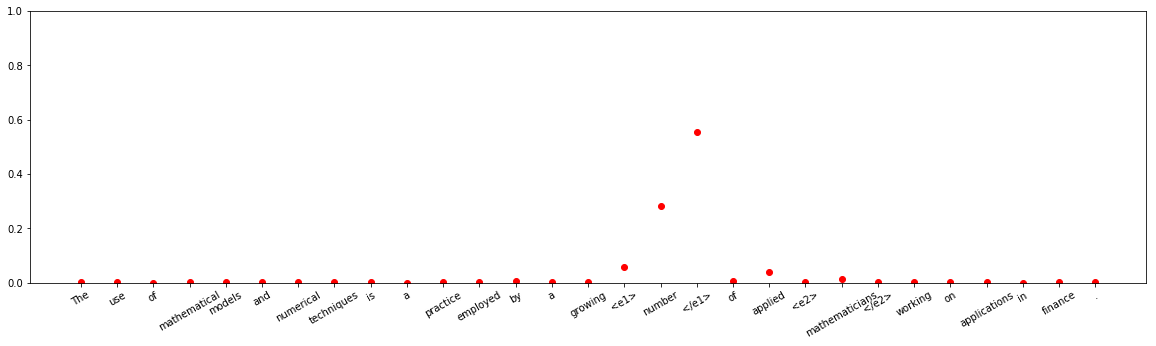







input sentence: Without wasting time , a medical <e1> team </e1> of the <e2> army </e2> rushed to the house of the militant and provided emergent medical treatment to her .
answer label:    Component-Whole
wrong label:    Member-Collection
Other 	:	 9.5948504e-05
Cause-Effect 	:	 1.6949521e-09
Component-Whole 	:	 1.6510285e-08
Entity-Destination 	:	 3.9551216e-09
Entity-Origin 	:	 1.5620268e-08
Product-Producer 	:	 8.2279365e-07
Member-Collection 	:	 0.9999014
Message-Topic 	:	 1.9861886e-10
Content-Container 	:	 2.7611406e-09
Instrument-Agency 	:	 1.7441364e-06



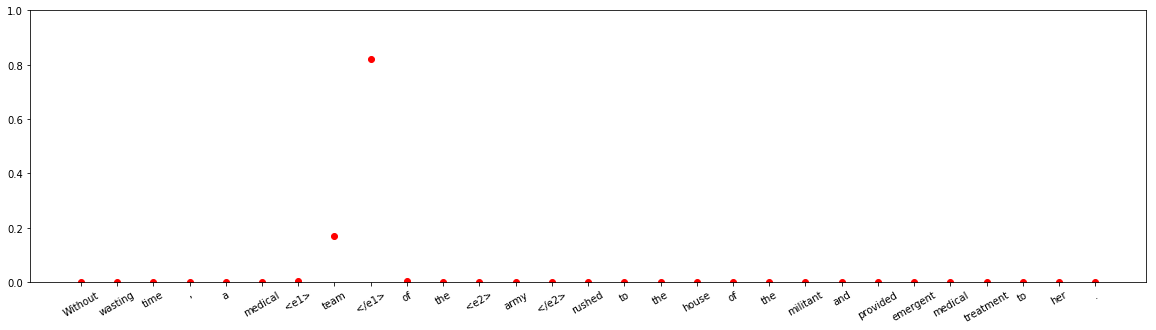


input sentence: On this basis , the vibronically coupled CD bands of lutein diacetate are attributed to an excitonic <e1> interaction </e1> arose from the twisted nematic <e2> layers </e2> .
answer label:    Cause-Effect
wrong label:    Other
Other 	:	 0.9813995
Cause-Effect 	:	 0.01833442
Component-Whole 	:	 7.381798e-07
Entity-Destination 	:	 1.8564139e-06
Entity-Origin 	:	 0.00026356845
Product-Producer 	:	 1.646949e-11
Member-Collection 	:	 1.9692405e-09
Message-Topic 	:	 2.143307e-08
Content-Container 	:	 4.807499e-12
Instrument-Agency 	:	 3.1446135e-08



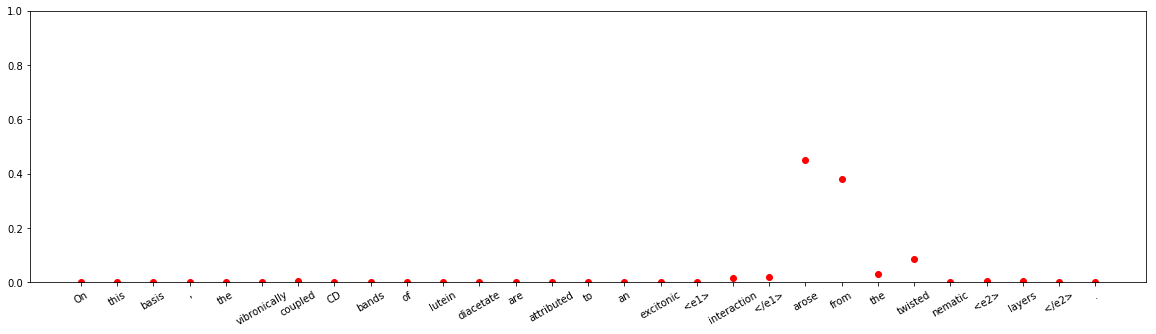




input sentence: Each year , waterfowl enthusiasts and conservationists gather to learn about DU 's priorities , socialize and enjoy the <e1> camaraderie </e1> of other DU <e2> supporters </e2> .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.14470705
Cause-Effect 	:	 4.154572e-07
Component-Whole 	:	 1.0868009e-09
Entity-Destination 	:	 9.238472e-10
Entity-Origin 	:	 5.617984e-09
Product-Producer 	:	 9.253172e-08
Member-Collection 	:	 0.8552708
Message-Topic 	:	 2.1628279e-05
Content-Container 	:	 1.020731e-09
Instrument-Agency 	:	 2.6832836e-09



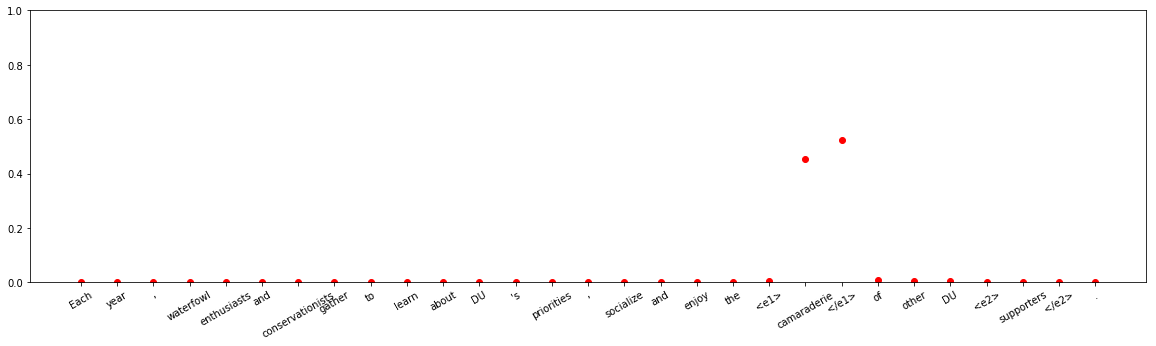


input sentence: The <e1> model </e1> developed from that <e2> event </e2> include academic visits and symposia , alumni and . VIP events , together with government and press relations .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 0.009911121
Cause-Effect 	:	 1.0872848e-06
Component-Whole 	:	 1.7857114e-05
Entity-Destination 	:	 5.3145573e-08
Entity-Origin 	:	 0.99001163
Product-Producer 	:	 5.6892583e-05
Member-Collection 	:	 1.7481423e-07
Message-Topic 	:	 4.2261314e-07
Content-Container 	:	 9.2447445e-09
Instrument-Agency 	:	 8.001767e-07



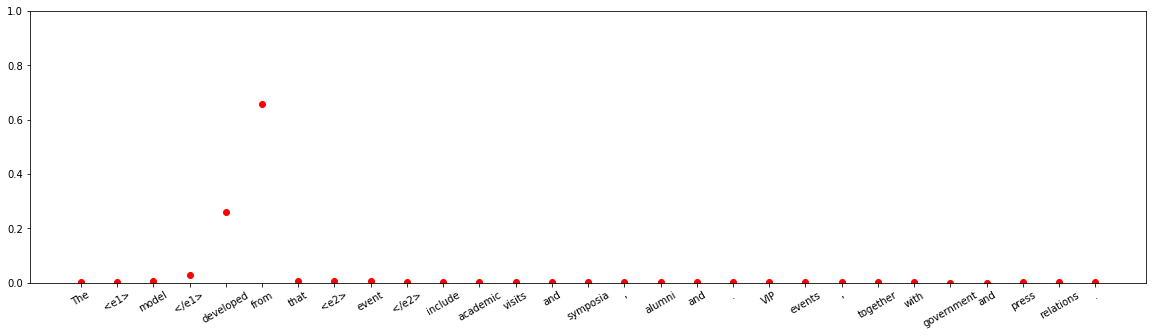


input sentence: I first became acquainted with the book through an audio <e1> book </e1> I was given by a dear <e2> friend </e2> of mine a few years ago .
answer label:    Entity-Origin
wrong label:    Product-Producer
Other 	:	 0.0012966362
Cause-Effect 	:	 2.4513383e-05
Component-Whole 	:	 1.142215e-08
Entity-Destination 	:	 4.4459828e-08
Entity-Origin 	:	 4.4694666e-06
Product-Producer 	:	 0.9985464
Member-Collection 	:	 2.1983997e-08
Message-Topic 	:	 3.1171453e-06
Content-Container 	:	 5.292152e-06
Instrument-Agency 	:	 0.00011947456



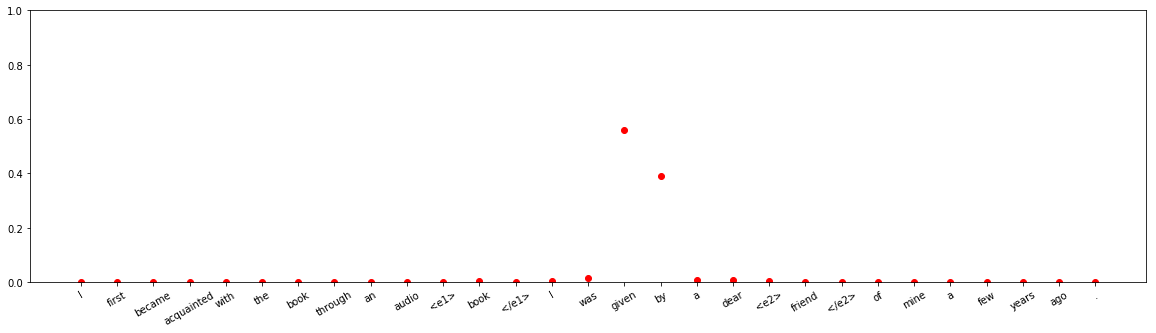



input sentence: The <e1> hostel </e1> comprises of a main <e2> building </e2> of 3 floors , it started its life as a nun 's convent that 's been renovated .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 6.1567085e-09
Cause-Effect 	:	 3.8900954e-13
Component-Whole 	:	 1.0
Entity-Destination 	:	 1.0119977e-12
Entity-Origin 	:	 9.858152e-13
Product-Producer 	:	 4.125156e-13
Member-Collection 	:	 5.639851e-09
Message-Topic 	:	 3.9413876e-14
Content-Container 	:	 8.763332e-11
Instrument-Agency 	:	 3.2744965e-09



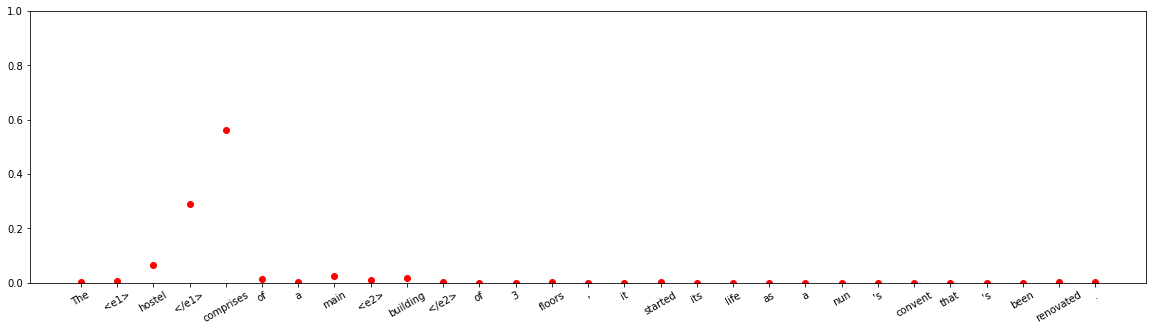










input sentence: KHZZ experienced <e1> competition </e1> from former oldies <e2> station </e2> KHYL , but both stations ended up giving up the format , with KHZZ turning to oldies .
answer label:    Cause-Effect
wrong label:    Entity-Origin
Other 	:	 0.00015426602
Cause-Effect 	:	 6.72052e-05
Component-Whole 	:	 4.915779e-12
Entity-Destination 	:	 1.8446415e-06
Entity-Origin 	:	 0.9997764
Product-Producer 	:	 2.2349342e-08
Member-Collection 	:	 8.818775e-08
Message-Topic 	:	 1.6183133e-10
Content-Container 	:	 1.6891523e-11
Instrument-Agency 	:	 1.1067806e-07



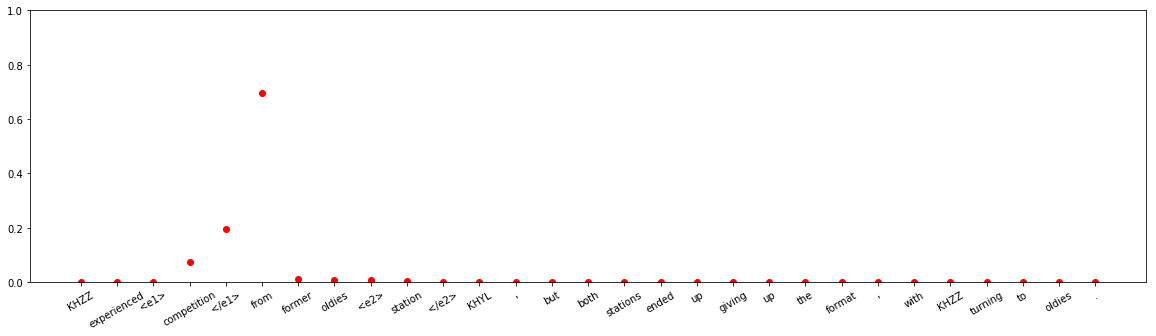






input sentence: The idea is the heatsink removes the heat from the CPU and the <e1> fan </e1> blasts the heatsink with the surrounding <e2> air </e2> cooling it down .
answer label:    Instrument-Agency
wrong label:    Component-Whole
Other 	:	 0.0033194614
Cause-Effect 	:	 4.7796093e-06
Component-Whole 	:	 0.9964104
Entity-Destination 	:	 1.5760922e-06
Entity-Origin 	:	 1.3692392e-09
Product-Producer 	:	 3.4765115e-09
Member-Collection 	:	 6.773722e-08
Message-Topic 	:	 4.5677538e-07
Content-Container 	:	 4.2701833e-09
Instrument-Agency 	:	 0.000263199



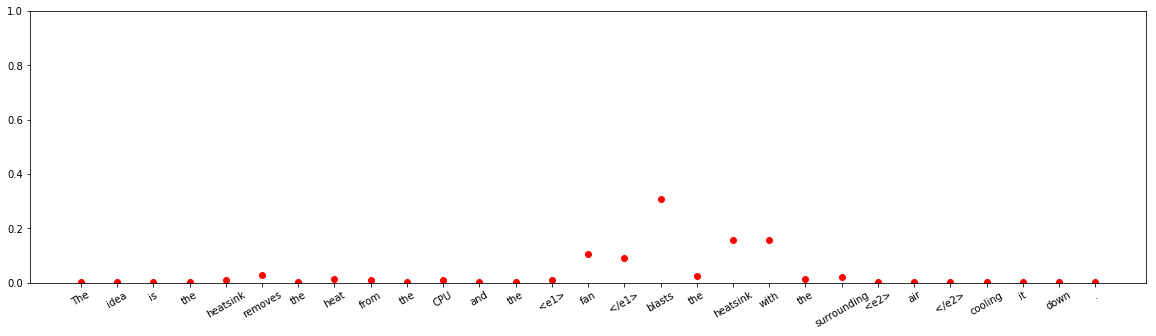









input sentence: Each of these contain many <e1> modules </e1> on different topics , such as <e2> apostrophes </e2> , silent letters , personal pronouns , spelling plurals , etc .
answer label:    Message-Topic
wrong label:    Component-Whole
Other 	:	 0.010941496
Cause-Effect 	:	 1.8925586e-05
Component-Whole 	:	 0.9860415
Entity-Destination 	:	 1.2716838e-07
Entity-Origin 	:	 1.7433784e-07
Product-Producer 	:	 4.4188124e-07
Member-Collection 	:	 1.3545197e-06
Message-Topic 	:	 0.0028703846
Content-Container 	:	 1.765808e-06
Instrument-Agency 	:	 0.0001238938



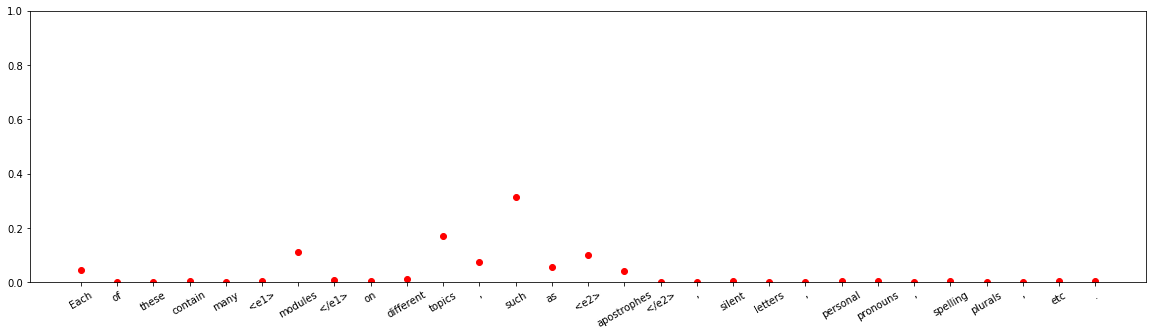


input sentence: Congress <e1> workers </e1> play with colours while celebrating <e2> party </e2> 's win in the Assembly elections of three states at party office in Kolkata on Thursday .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9999329
Cause-Effect 	:	 8.674564e-06
Component-Whole 	:	 1.02981605e-08
Entity-Destination 	:	 9.1420377e-10
Entity-Origin 	:	 9.933402e-09
Product-Producer 	:	 2.9355368e-08
Member-Collection 	:	 7.6161064e-06
Message-Topic 	:	 1.1959657e-05
Content-Container 	:	 1.9584348e-11
Instrument-Agency 	:	 3.886936e-05



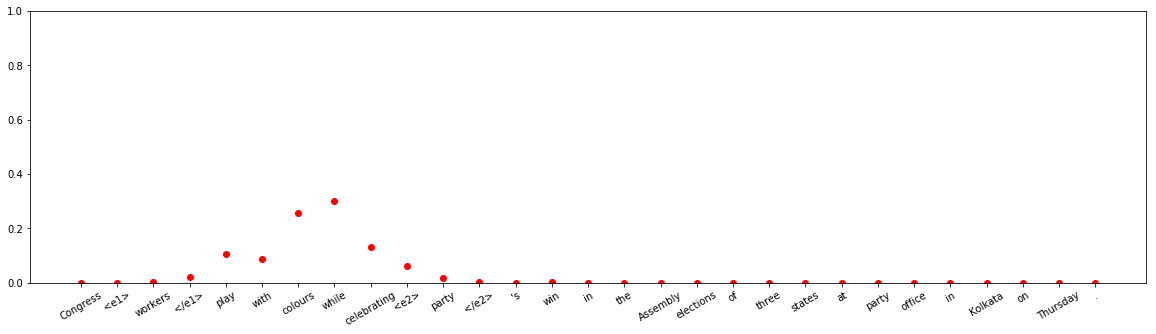




input sentence: The annual residence <e1> league </e1> of various sport <e2> codes </e2> , the Mini Olympics held during the September break has proven very popular amongst our students .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.9352788
Cause-Effect 	:	 3.5719584e-08
Component-Whole 	:	 1.4812603e-05
Entity-Destination 	:	 5.451315e-08
Entity-Origin 	:	 8.853878e-08
Product-Producer 	:	 4.914055e-07
Member-Collection 	:	 0.061877076
Message-Topic 	:	 0.0028149702
Content-Container 	:	 1.0866968e-07
Instrument-Agency 	:	 1.36190065e-05



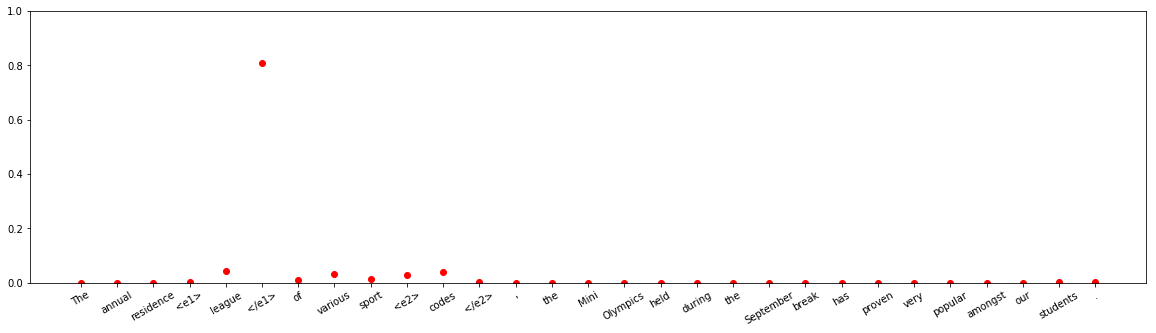


input sentence: A certificated security for which the certificate has been surrendered to the issuer is reached by a <e1> creditor </e1> by legal <e2> process </e2> upon the issuer .
answer label:    Instrument-Agency
wrong label:    Other
Other 	:	 0.9999988
Cause-Effect 	:	 1.3284044e-07
Component-Whole 	:	 1.2500029e-10
Entity-Destination 	:	 8.046278e-11
Entity-Origin 	:	 7.331315e-09
Product-Producer 	:	 9.2131614e-08
Member-Collection 	:	 1.426735e-07
Message-Topic 	:	 7.979377e-09
Content-Container 	:	 1.0334558e-11
Instrument-Agency 	:	 8.4022133e-07



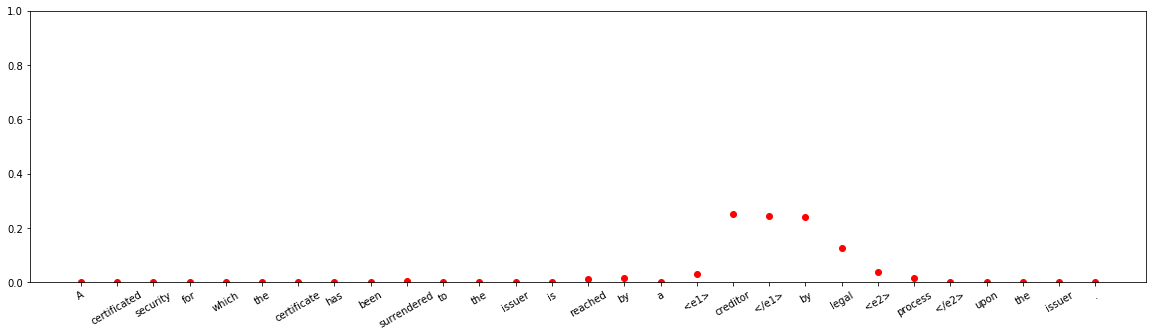







input sentence: It 's a powerful personal <e1> work </e1> by a <e2> man </e2> who still thinks for himself in an era of fear , conformity , and dehumanization .
answer label:    Product-Producer
wrong label:    Other
Other 	:	 0.9999496
Cause-Effect 	:	 1.5406953e-06
Component-Whole 	:	 2.8620722e-10
Entity-Destination 	:	 1.5895101e-11
Entity-Origin 	:	 2.1184174e-10
Product-Producer 	:	 4.823078e-05
Member-Collection 	:	 2.0396502e-09
Message-Topic 	:	 4.6940244e-08
Content-Container 	:	 3.2128696e-12
Instrument-Agency 	:	 5.539694e-07



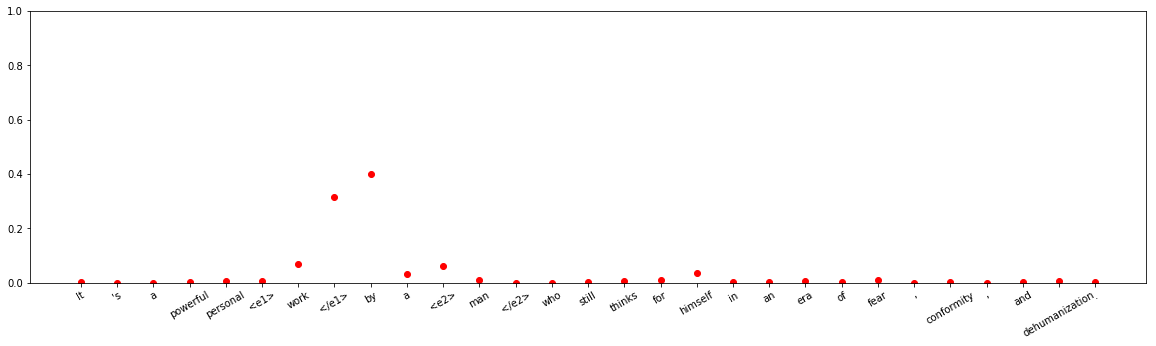








input sentence: In the years following , Detroit 's <e1> population </e1> fell from a <e2> peak </e2> of roughly 1.8 million in 1950 to about half that number today .
answer label:    Other
wrong label:    Entity-Origin
Other 	:	 6.074351e-05
Cause-Effect 	:	 6.256392e-07
Component-Whole 	:	 7.8763886e-14
Entity-Destination 	:	 1.2269455e-09
Entity-Origin 	:	 0.9999386
Product-Producer 	:	 3.5133071e-10
Member-Collection 	:	 9.2004315e-09
Message-Topic 	:	 8.0127636e-14
Content-Container 	:	 3.920407e-11
Instrument-Agency 	:	 9.033095e-11



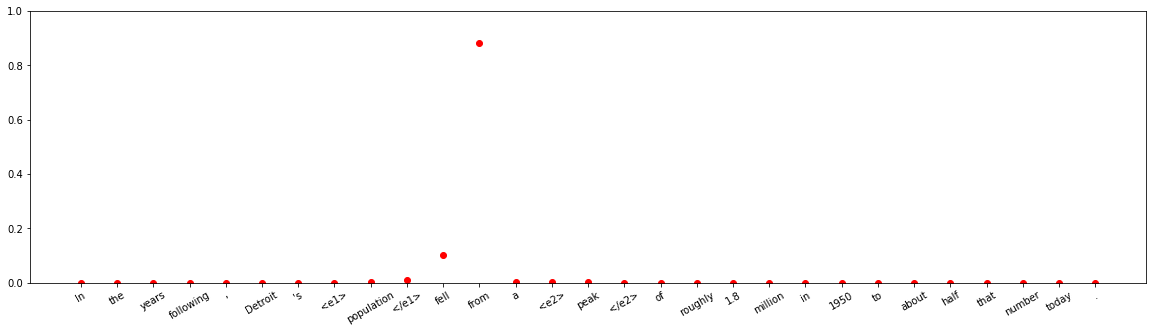
































input sentence: We double-checked that a maximum of 80 <e1> larvae </e1> were placed inside each <e2> vial </e2> .
answer label:    Content-Container
wrong label:    Entity-Destination
Other 	:	 1.5448263e-07
Cause-Effect 	:	 4.9445484e-14
Component-Whole 	:	 1.242124e-08
Entity-Destination 	:	 0.9999957
Entity-Origin 	:	 1.3002249e-06
Product-Producer 	:	 7.02471e-11
Member-Collection 	:	 2.571119e-11
Message-Topic 	:	 8.020921e-12
Content-Container 	:	 2.8047843e-06
Instrument-Agency 	:	 2.3464557e-09



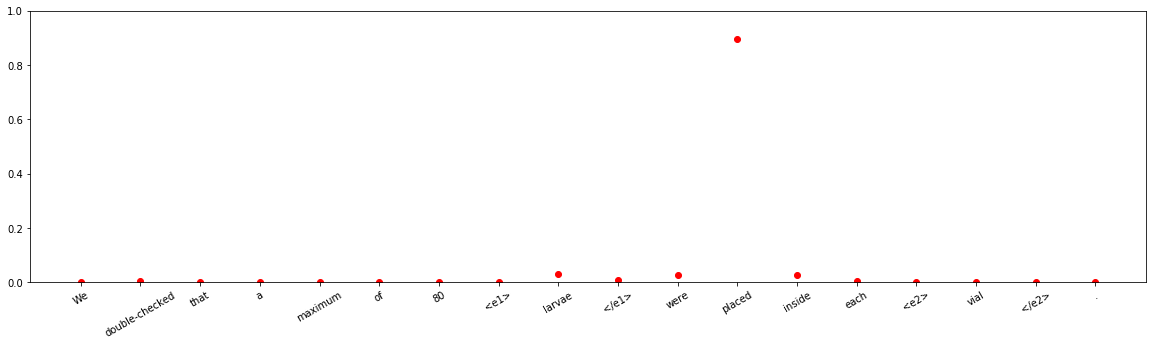












input sentence: And destiny lies for us in many places , way up in the High Lonesome with a <e1> cowardice </e1> of <e2> curs </e2> or our passions for the loves we know .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.07861582
Cause-Effect 	:	 4.4685115e-07
Component-Whole 	:	 6.516401e-07
Entity-Destination 	:	 1.1829246e-11
Entity-Origin 	:	 7.9299895e-08
Product-Producer 	:	 8.8341073e-10
Member-Collection 	:	 0.9213803
Message-Topic 	:	 2.7855024e-06
Content-Container 	:	 1.1559885e-09
Instrument-Agency 	:	 5.2387394e-10



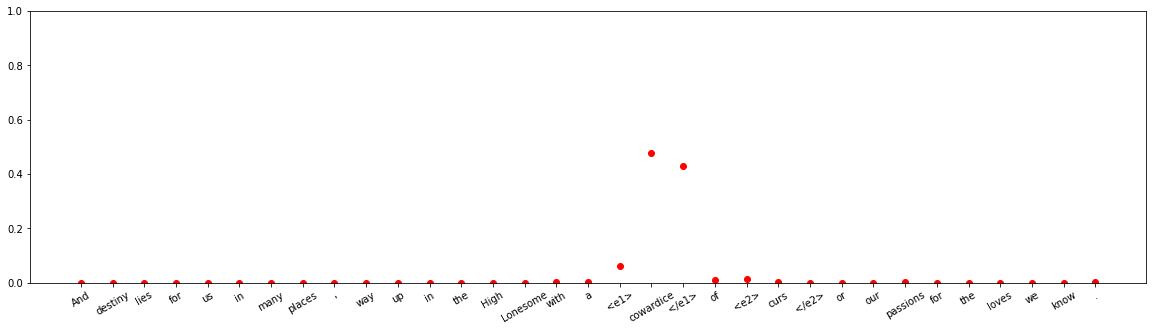




input sentence: The Japanese team conducted their preliminary research on mice , with a cancer gene among the regulators , and created in the process a <e1> mischief </e1> of clone <e2> mice </e2> .
answer label:    Member-Collection
wrong label:    Other
Other 	:	 0.78674
Cause-Effect 	:	 0.00039708256
Component-Whole 	:	 5.9434315e-06
Entity-Destination 	:	 1.4473498e-09
Entity-Origin 	:	 2.0968776e-07
Product-Producer 	:	 1.4407237e-08
Member-Collection 	:	 0.21285568
Message-Topic 	:	 9.3425433e-07
Content-Container 	:	 1.2054539e-08
Instrument-Agency 	:	 1.6717496e-07



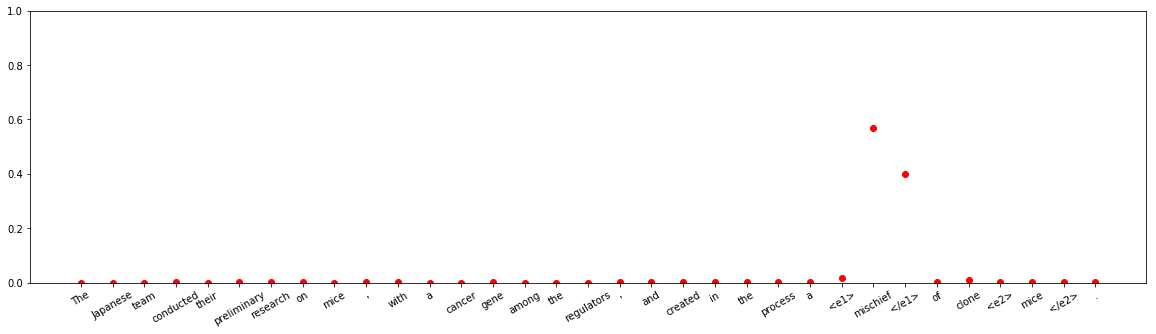






input sentence: This group 0+ baby <e1> car </e1> <e2> seat </e2> fits easily into the car and connects to the Jane Powertwin Pro pushchair ( sold separately ) to make a travel system .
answer label:    Component-Whole
wrong label:    Instrument-Agency
Other 	:	 0.04236257
Cause-Effect 	:	 5.9239884e-08
Component-Whole 	:	 0.05022025
Entity-Destination 	:	 0.00020360683
Entity-Origin 	:	 9.273463e-06
Product-Producer 	:	 0.0032785258
Member-Collection 	:	 2.359061e-05
Message-Topic 	:	 1.0873367e-05
Content-Container 	:	 6.376284e-05
Instrument-Agency 	:	 0.9038275



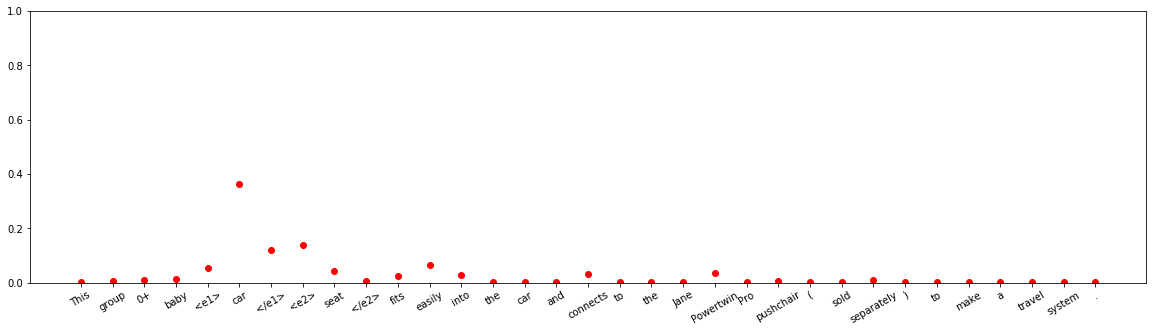



input sentence: The purpose of the <e1> class </e1> was to examine the <e2> therapeutic benefits </e2> of writing and to discern whether writing can be a help or a hinderance in some situations .
answer label:    Message-Topic
wrong label:    Other
Other 	:	 0.99841785
Cause-Effect 	:	 1.2029021e-09
Component-Whole 	:	 8.0405647e-07
Entity-Destination 	:	 1.5359369e-06
Entity-Origin 	:	 1.2263793e-09
Product-Producer 	:	 3.853503e-09
Member-Collection 	:	 8.245878e-09
Message-Topic 	:	 0.0015509989
Content-Container 	:	 1.0510767e-09
Instrument-Agency 	:	 2.8788672e-05



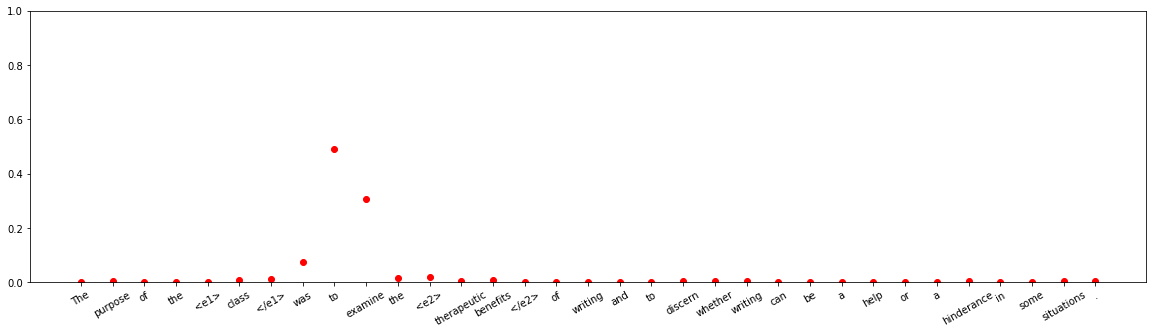



input sentence: It features some of the most beautiful <e1> mountain </e1> <e2> landscapes </e2> anywhere , with vertical walls , sheer cliffs and a high density of narrow , deep and long valleys .
answer label:    Other
wrong label:    Component-Whole
Other 	:	 0.45491636
Cause-Effect 	:	 2.4774292e-07
Component-Whole 	:	 0.544535
Entity-Destination 	:	 3.878662e-07
Entity-Origin 	:	 7.857243e-06
Product-Producer 	:	 3.632406e-06
Member-Collection 	:	 4.880621e-05
Message-Topic 	:	 9.22871e-05
Content-Container 	:	 2.4098762e-07
Instrument-Agency 	:	 0.00039510135



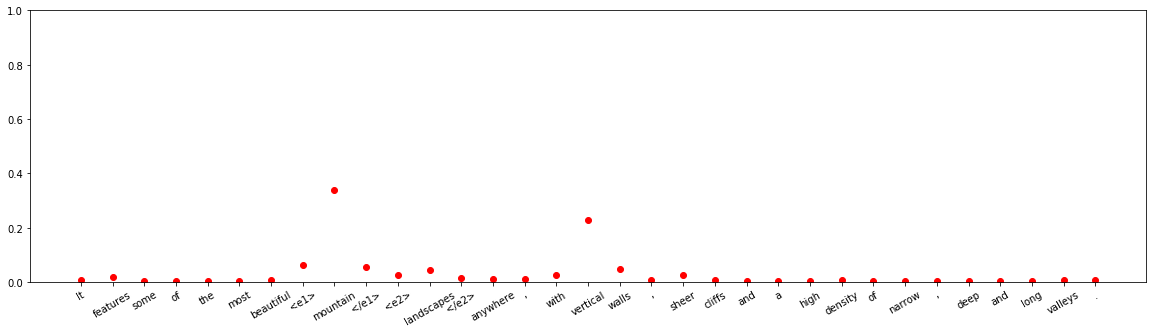


input sentence: Since Sally Industries ' inception , John Wood has been a <e1> key </e1> <e2> member </e2> of the company 's management team and a founding member of the board of directors .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 8.850259e-06
Cause-Effect 	:	 4.8369662e-11
Component-Whole 	:	 6.71776e-06
Entity-Destination 	:	 3.5472864e-12
Entity-Origin 	:	 1.1188964e-10
Product-Producer 	:	 1.9138037e-08
Member-Collection 	:	 0.99998415
Message-Topic 	:	 1.6144233e-07
Content-Container 	:	 7.0894096e-08
Instrument-Agency 	:	 5.662091e-10



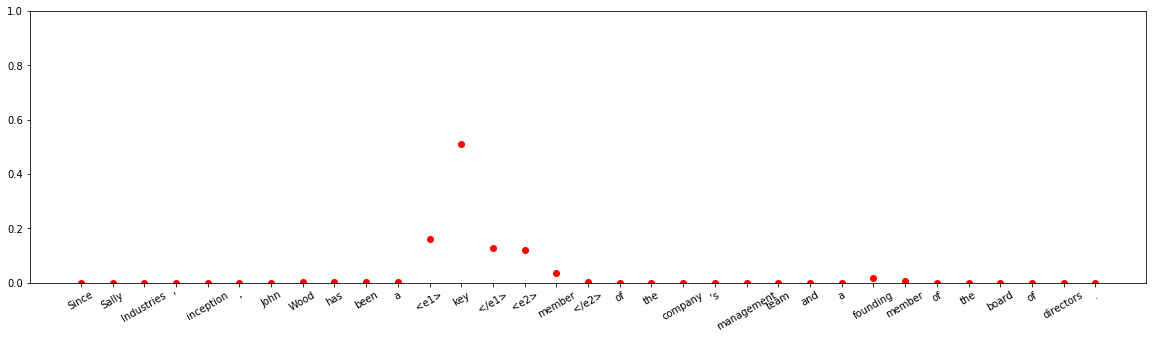












input sentence: In late summer ( July to September ) , the robins disperse and the Culex shift to feeding on humans , again despite the <e1> ubiquity </e1> of house <e2> sparrows </e2> .
answer label:    Other
wrong label:    Member-Collection
Other 	:	 0.025642617
Cause-Effect 	:	 2.7191115e-06
Component-Whole 	:	 9.3279304e-08
Entity-Destination 	:	 3.5219723e-09
Entity-Origin 	:	 9.441036e-08
Product-Producer 	:	 4.083466e-08
Member-Collection 	:	 0.974221
Message-Topic 	:	 0.00013343264
Content-Container 	:	 1.12255805e-08
Instrument-Agency 	:	 1.862854e-09



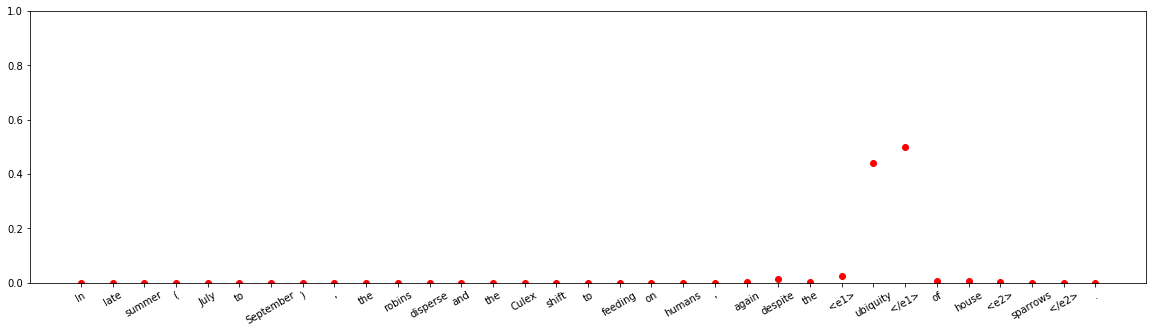


input sentence: <e1> Scientists </e1> responsible for analysing the seizures have given a <e2> warning </e2> that traffickers are turning to hospital X-ray equipment and laboratory supplies as an illicit source of radioactive material .
answer label:    Product-Producer
wrong label:    Cause-Effect
Other 	:	 2.1969672e-05
Cause-Effect 	:	 0.9371703
Component-Whole 	:	 1.0107908e-06
Entity-Destination 	:	 3.5921807e-06
Entity-Origin 	:	 1.0137991e-06
Product-Producer 	:	 4.6987636e-05
Member-Collection 	:	 0.00035224567
Message-Topic 	:	 2.0495804e-07
Content-Container 	:	 6.93431e-05
Instrument-Agency 	:	 0.062333196



In [ ]:
relation_extr.evaluatation(test_input, test_output, header = 'Test', analyze  = True)

In [ ]:

for param in relation_extr.named_parameters():
    print(param)

In [ ]:
a = [[0]*10]*20
print(a)
a[0][0] = 1
print(a)

In [ ]:
optimizer.